# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [93]:
# Import standard libraries
import numpy as np
import pandas as pd

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer


# Import model selection libraries
from sklearn.model_selection import cross_val_score,train_test_split, StratifiedKFold, GridSearchCV

# Import clustering and decomposition libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Import ensemble methods
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)

# Import evaluation metrics
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

# Import additional libraries
from scipy import stats
from time import time

import optuna

# Enable inline plotting for visualizations
%matplotlib inline

# Optional: Import additional useful libraries
import warnings
warnings.filterwarnings('ignore')
# Suppress FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)




## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# shape of the general population data
print('Number of rows: ', azdias.shape[0])
print('Number of columns: ', azdias.shape[1])

azdias.head()

Number of rows:  891221
Number of columns:  366


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         NaN      NaN             NaN             NaN   
1  4.0       8.0        11.0     10.0             3.0             9.0   
2  2.0       9.0         9.0      6.0             3.0             9.0   
3  0.0       7.0        10.0     11.0             NaN             9.0   
4  2.0       3.0         5.0      4.0             2.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       NaN        3         1                    2  
1       4.0        5         2                    1  
2       2.0        5         2                    3  
3       7.0        3         2                    4  
4       3.0        4         1                    3  

[5 rows x 366 columns]

In [4]:
# shape of customers population data
print('Number of rows: ', customers.shape[0])
print('Number of columns: ', customers.shape[1])

customers.head()

Number of rows:  191652
Number of columns:  369


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN                  NaN  ...   
2          NaN          NaN                   0.0                  1.0  ...   
3          NaN          NaN                   8.0                  0.0  ...   
4          NaN          NaN                  14.0                  7.0  ...   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0      2.0             6.0             9.0       7.0         3   
1      3.0             0.0             9.0       NaN         3   
2     11.0             6.0             9.0       2.0         3   
3      2.0             NaN             9.0       7.0         1   
4      4.0             2.0             9.0       3.0         1   

       PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1               FOOD    SINGLE_BUYER               0         1   
2  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3           COSMETIC     MULTI_BUYER               0         1   
4               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

# 1 Exploratory Data Analysis

In [5]:
# Calculate the total number of missing values and their percentage for each column in the azdias DataFrame
azdias_missing_values = azdias.isnull().sum()  # Total missing values for each feature
azdias_missing_values_percent = azdias_missing_values / len(azdias) * 100  # Percentage of missing values

print("Total missing values for each feature in azdias DataFrame:\n")
print(azdias_missing_values)

# Print a separator for better readability
print("\n" + "-"*50 + "\n")

print("Percentage of missing values for each feature in azdias DataFrame:\n")
print(azdias_missing_values_percent)

Total missing values for each feature in azdias DataFrame:

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

--------------------------------------------------

Percentage of missing values for each feature in azdias DataFrame:

LNR                      0.000000
AGER_TYP                 0.000000
AKT_DAT_KL               8.247000
ALTER_HH                 8.247000
ALTER_KIND1             90.904837
                          ...    
WOHNDAUER_2008           8.247000
WOHNLAGE                10.451729
ZABEOTYP                 0.000000
ANREDE_KZ                0.000000
ALTERSKATEGORIE_GROB     0.000000
Length: 366, dtype: float64


In [6]:
# This will summarize numerical features, providing insight into the dataset
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...            VHN  \
count         628274.000000        798073.000000  ...  770025.000000   
mean              13.700717             8.287263  ...       2.417322   
std                5.079849            15.628087  ...       1.166572   
min                0.000000             0.000000  ...       0.000000   
25%               11.000000             1.000000  ...       2.000000   
50%               14.000000             4.000000  ...       2.000000   
75%               17.000000             9.000000  ...       3.000000   
max               25.000000           595.000000  ...       4.000000   

            VK_DHT4A     VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  \
count  815304.000000  815304.000000  815304.000000   783619.000000   
mean        6.001214       7.532130       5.945972        3.933406   
std         2.856091       3.247789       2.771464        1.964701   
min         1.000000       1.000000       1.000000        0.000000   
25%         3.000000       5.000000       4.000000        2.000000   
50%         6.000000       8.000000       6.000000        4.000000   
75%         9.000000      10.000000       8.000000        6.000000   
max        11.000000      13.000000      11.000000        6.000000   

       WOHNDAUER_2008       WOHNLAGE       ZABEOTYP      ANREDE_KZ  \
count   817722.000000  798073.000000  891221.000000  891221.000000   
mean         7.908791       4.052836       3.362438       1.522098   
std          1.923137       1.949539       1.352704       0.499512   
min          1.000000       0.000000       1.000000       1.000000   
25%          8.000000       3.000000       3.000000       1.000000   
50%          9.000000       3.000000       3.000000       2.000000   
75%          9.000000       5.000000       4.000000       2.000000   
max          9.000000       8.000000       6.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         891221.000000  
mean               2.777398  
std                1.068775  
min                1.000000  
25%                2.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 360 columns]

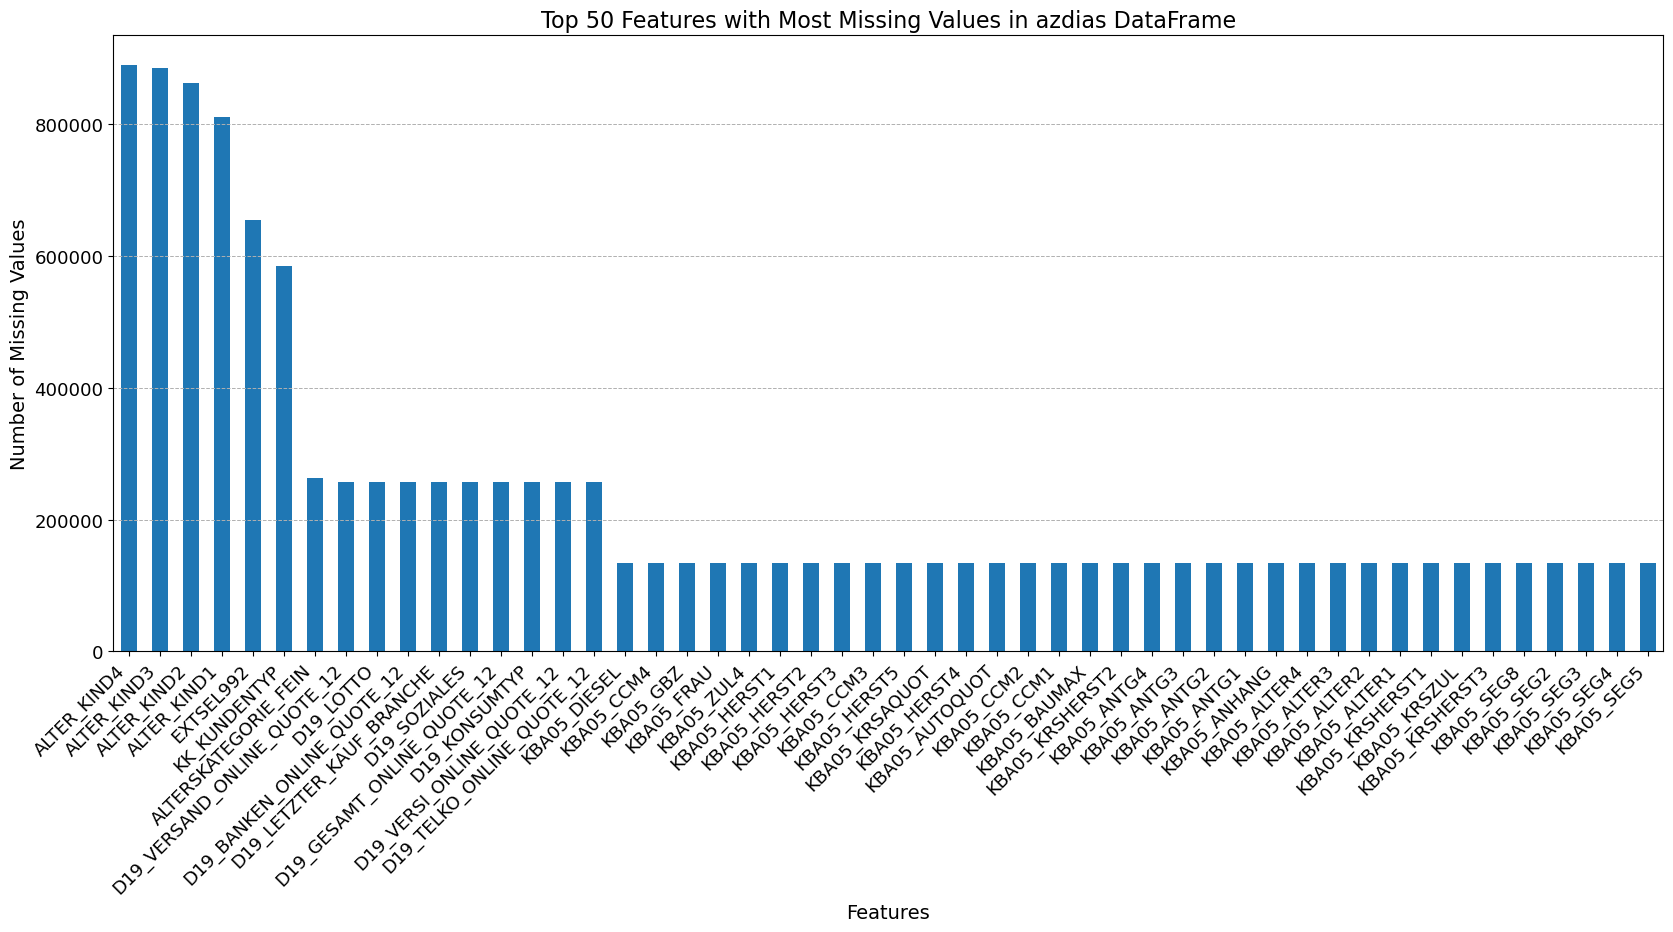

In [7]:
# Visualize the top 50 features with the most missing values in the azdias DataFrame
# Sort the missing values in descending order and select the top 50 features
top_missing_azdias = azdias_missing_values.sort_values(ascending=False)[:50]

# Plot the top 50 features with the most missing values
plt.figure(figsize=(20, 8))
top_missing_azdias.plot(kind='bar', fontsize=13)
plt.title('Top 50 Features with Most Missing Values in azdias DataFrame', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


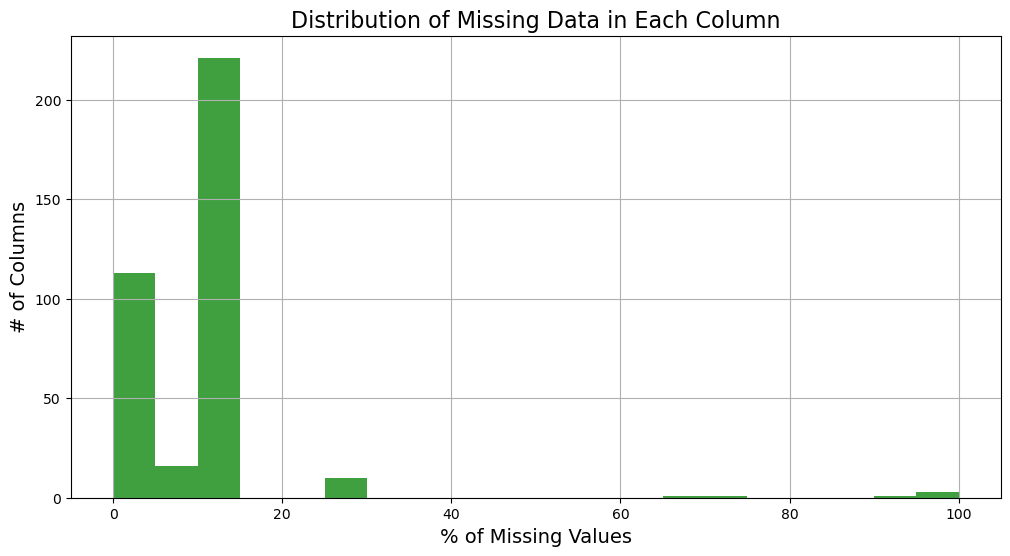

% of Missing Data in Columns:

ALTER_KIND4                  99.864792
ALTER_KIND3                  99.307691
ALTER_KIND2                  96.690047
ALTER_KIND1                  90.904837
EXTSEL992                    73.399639
                               ...    
D19_VERSAND_ANZ_24            0.000000
D19_VERSAND_DATUM             0.000000
D19_VERSAND_OFFLINE_DATUM     0.000000
D19_VERSAND_ONLINE_DATUM      0.000000
ALTERSKATEGORIE_GROB          0.000000
Length: 366, dtype: float64


In [8]:
# Visualize the distribution of missing data by percentage in the azdias DataFrame
plt.figure(figsize=(12, 6))
bins = np.linspace(0, 100, 21)  # Define bins for the histogram with better scaling

# Plot histogram of the percentage of missing values in each column
plt.hist(azdias_missing_values_percent, bins=bins, facecolor='g', alpha=0.75)
plt.xlabel('% of Missing Values', fontsize=14)
plt.ylabel('# of Columns', fontsize=14)
plt.title('Distribution of Missing Data in Each Column', fontsize=16)
plt.grid(True)

# Display the plot
plt.show()

# Print the percentage of missing data in columns, sorted in descending order
print('% of Missing Data in Columns:\n')
print(azdias_missing_values_percent.sort_values(ascending=False))


In [9]:
# Review of missing data distribution:
# From previous visualizations, we observed that the percentage of missing data in columns ranges from very low to around 17%.
# Beyond this, there is a drastic increase in the percentage of missing fields, highlighting potential outliers.

# Let's manually print the distribution of missing values to understand the extent of missing data and identify any clear outliers.

# Count the number of columns with missing values greater than specific thresholds
thresholds = [0, 10, 20, 30, 40, 60, 65, 80, 90]
missing_counts = {threshold: len(azdias_missing_values_percent[azdias_missing_values_percent > threshold]) for threshold in thresholds}

# Print the results with detailed comments
print("Distribution of Columns with Missing Values Above Specified Percentages:\n")
for threshold, count in missing_counts.items():
    print(f"Columns with >{threshold}% missing values: {count}")

# Provide additional insight into the distribution
print("\nFrom the above distribution, we can see that columns with missing values beyond certain thresholds are significantly fewer, highlighting potential outliers.\n")


Distribution of Columns with Missing Values Above Specified Percentages:

Columns with >0% missing values: 273
Columns with >10% missing values: 237
Columns with >20% missing values: 16
Columns with >30% missing values: 6
Columns with >40% missing values: 6
Columns with >60% missing values: 6
Columns with >65% missing values: 6
Columns with >80% missing values: 4
Columns with >90% missing values: 4

From the above distribution, we can see that columns with missing values beyond certain thresholds are significantly fewer, highlighting potential outliers.



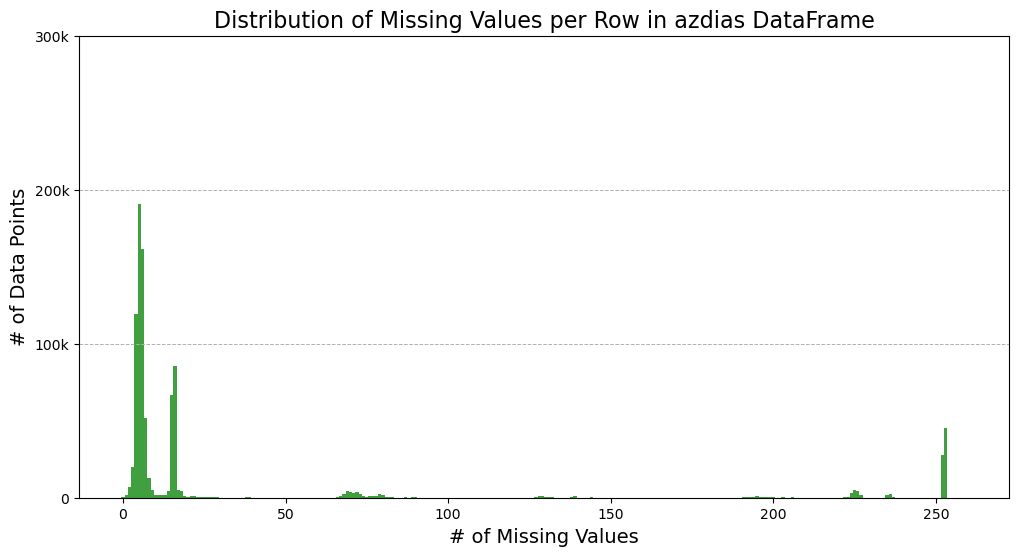

In [10]:
# Analyze the distribution of missing values at the row level in the azdias DataFrame

# Calculate the number of missing values for each row
row_missing_values = azdias.isnull().sum(axis=1)

# Set up the figure for the histogram
plt.figure(figsize=(12, 6))

# Plot histogram of the number of missing values per row
plt.hist(row_missing_values, bins=np.arange(-0.5, row_missing_values.max() + 1, 1), facecolor='g', alpha=0.75)
plt.yticks(np.arange(0, 300000 + 100000, 100000), ['0', '100k', '200k', '300k'])  # Set y-ticks with readable labels
plt.ylabel('# of Data Points', fontsize=14)
plt.xlabel('# of Missing Values', fontsize=14)
plt.title('Distribution of Missing Values per Row in azdias DataFrame', fontsize=16)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Display the plot
plt.show()

# Additional comments
# - The histogram helps in understanding the distribution of missing values across rows.
# - The x-axis represents the number of missing values in a row.
# - The y-axis shows the number of data points (rows) with the corresponding number of missing values.


In [11]:
# Calculate the percentage of data kept for rows with a certain number of missing data points
# This will help determine an appropriate threshold for the maximum number of missing values allowed per row

# Calculate the cumulative sum of rows with up to a certain number of missing values
cumulative_data_kept = azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()

# Calculate the percentage of the total data
percentage_data_kept = cumulative_data_kept / azdias.shape[0] * 100

# Display the percentage of data kept for the first 30 cumulative sums in a more intuitive way
print("Percentage of Data Kept for Rows with Various Numbers of Missing Data Points:\n")

for num_missing, percent_kept in percentage_data_kept[:30].iteritems():
    print(f"Rows with {num_missing} or fewer missing values: {percent_kept:.0f}% of data kept")

# Additional comments:
# - This analysis shows the cumulative percentage of data retained when rows with a certain number of missing values are kept.
# - It helps in choosing a threshold for the maximum number of missing values per row to retain a significant portion of the dataset.
# - From the results, we observe that around 16% of the data is retained before the increase in retained data stagnates.


Percentage of Data Kept for Rows with Various Numbers of Missing Data Points:

Rows with 0 or fewer missing values: 0% of data kept
Rows with 1 or fewer missing values: 0% of data kept
Rows with 2 or fewer missing values: 1% of data kept
Rows with 3 or fewer missing values: 3% of data kept
Rows with 4 or fewer missing values: 17% of data kept
Rows with 5 or fewer missing values: 38% of data kept
Rows with 6 or fewer missing values: 56% of data kept
Rows with 7 or fewer missing values: 62% of data kept
Rows with 8 or fewer missing values: 63% of data kept
Rows with 9 or fewer missing values: 64% of data kept
Rows with 10 or fewer missing values: 64% of data kept
Rows with 11 or fewer missing values: 64% of data kept
Rows with 12 or fewer missing values: 65% of data kept
Rows with 13 or fewer missing values: 65% of data kept
Rows with 14 or fewer missing values: 65% of data kept
Rows with 15 or fewer missing values: 73% of data kept
Rows with 16 or fewer missing values: 82% of data kept


### Conclusion of Exploratory Data Analysis (EDA)

* The exploratory data analysis revealed crucial insights into the demographics dataset provided for customer segmentation:

* Data Quality Issues: A significant proportion of columns exhibit missing data, with certain columns having over 17% missing values. This necessitates careful handling during preprocessing.

* Threshold for Missing Data: Analysis indicated that retaining rows with up to 16 missing values preserves around 82% of the dataset, highlighting a practical threshold for data cleaning.

* Feature Distribution: Initial exploration of feature distributions suggested diverse demographics, which can aid in effective customer segmentation.

* Outlier Identification: The presence of outliers in missing data percentages suggests further investigation is needed to understand their impact on analysis.

* Overall, the findings from the EDA will inform the subsequent steps in data cleaning and modeling, ensuring a robust foundation for customer segmentation and predictive modeling tasks.

# 2 Methodology and Data Preprocessing

In [12]:
# Filter the dataset to retain rows with 16 or fewer missing values
azdias_filtered = azdias[azdias.isnull().sum(axis=1) <= 16]

# Reset the index in place to save memory
azdias_filtered.reset_index(drop=True, inplace=True)

# Print the number of rows in the filtered dataset
print('Number of rows in the filtered dataset:', azdias_filtered.shape[0])

# Update the original variable if needed
azdias = azdias_filtered

Number of rows in the filtered dataset: 733227


In [13]:
# Identify columns with more than 65% missing data
high_missing_cols = azdias.columns[azdias.isnull().mean() > 0.60]

# Print the columns to be dropped
print('Columns to drop due to high missing data:', high_missing_cols.tolist())

# Drop the identified columns from the dataset
azdias.drop(columns=high_missing_cols, inplace=True)

# Confirm the drop
print(f'Dropped {len(high_missing_cols)} columns with high missing data.')


Columns to drop due to high missing data: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Dropped 6 columns with high missing data.


In [14]:
# Preprocess the customers dataset by dropping unnecessary columns
# Define columns to drop
columns_to_drop = high_missing_cols.tolist() + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

# Drop the specified columns from the customers dataset
customers.drop(columns=columns_to_drop, inplace=True)

# Print confirmation of dropped columns
print('Dropped columns from customers dataset:', columns_to_drop)

Dropped columns from customers dataset: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


In [15]:
# Print the shape of the datasets
print('Shape of the azdias dataset:', azdias.shape)
print('Shape of the customers dataset:', customers.shape)

Shape of the azdias dataset: (733227, 360)
Shape of the customers dataset: (191652, 360)


In [16]:
# Drop columns with high cardinality from both datasets
# The 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' fields contain many unique values,
# complicating analysis and modeling. Keeping these columns may lead to increased complexity 
# and potential overfitting in machine learning models.

azdias = azdias.drop(columns=['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)
customers = customers.drop(columns=['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)

# Print confirmation of the dropped columns
print("Dropped 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' from both datasets due to high cardinality.")


Dropped 'EINGEFUEGT_AM' and 'D19_LETZTER_KAUF_BRANCHE' from both datasets due to high cardinality.


In [17]:
# Performing a cleanup to eliminate redundant columns and streamline the dataset post one-hot encoding

# Create a function to filter out features with high correlation.
def drop_highly_correlated(df, threshold=0.7):
    # Calculate the absolute correlation matrix
    corr_matrix = df.corr().abs()
    # Create a mask for the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Identify columns to drop based on the threshold
    drop_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    # Drop the identified columns
    df_dropped = df.drop(columns=drop_columns)
    
    return df_dropped, drop_columns

# Apply the function to the azdias dataset
azdias, azdias_dropped_cols = drop_highly_correlated(azdias)
print('Number of columns in azdias after dropping highly correlated features:', len(azdias.columns))

# Apply the function to the customers dataset
customers, customers_dropped_cols = drop_highly_correlated(customers)
print('Number of columns in customers after dropping highly correlated features:', len(customers.columns))


Number of columns in azdias after dropping highly correlated features: 238
Number of columns in customers after dropping highly correlated features: 256


In [18]:
# Print the number of rows and columns in the updated datasets
print('Shape of the azdias dataset after cleanup:', azdias.shape)
print('Shape of the customers dataset after cleanup:', customers.shape)

Shape of the azdias dataset after cleanup: (733227, 238)
Shape of the customers dataset after cleanup: (191652, 256)


In [19]:
# Identify numerical and categorical columns before encoding
# Get all column names
columns = azdias.columns

# Get only the numerical columns
numerical_columns = azdias._get_numeric_data().columns

# Determine the categorical columns by finding the difference between all columns and numerical columns
categorical_columns = list(set(columns) - set(numerical_columns))

# Print the numerical and categorical columns
print('Numerical columns:', numerical_columns)
print('Categorical columns:', categorical_columns)

Numerical columns: Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=234)
Categorical columns: ['OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [20]:
# Handle missing values by filling with -1 to indicate unknown values as described in the dataset documentation

# Columns to process
columns_to_process = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

# Replace 'X' and 'XX' with -1 and fill NaNs with -1
for col in columns_to_process:
    azdias[col] = azdias[col].replace(['X', 'XX'], -1).fillna(-1).astype(int)
    customers[col] = customers[col].replace(['X', 'XX'], -1).fillna(-1).astype(int)

# Fill NaNs with -1 for other specified columns
additional_columns = ['CAMEO_DEU_2015', 'OST_WEST_KZ']
azdias[additional_columns] = azdias[additional_columns].fillna(-1)
customers[additional_columns] = customers[additional_columns].fillna(-1)

print('Missing values handled successfully.')

Missing values handled successfully.


In [21]:
def fill_na_values(df, values):
    """
    Fill NaN values in the DataFrame based on specified conditions.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    values (list of tuples): Each tuple contains a value to check for and the value to fill NaNs with.
    """
    for check_value, fill_value in values:
        cols = df.columns[(df == check_value).any()]
        df[cols] = df[cols].fillna(fill_value)
        
# Define the conditions for filling NaN values
fill_conditions = [(9, 9), (0, 0), (-1, -1)]

# Apply the function to both datasets
fill_na_values(azdias, fill_conditions)
fill_na_values(customers, fill_conditions)

print('Missing values handled successfully.')

Missing values handled successfully.


In [22]:
# With all missing values now handled, focus on converting categorical variables to numerical values using one-hot encoding

# Apply one-hot encoding to convert categorical variables to numerical values
azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

# Print the shapes of the new datasets to confirm the transformation
print('Shape of the azdias dataset after one-hot encoding:', azdias.shape)
print('Shape of the customers dataset after one-hot encoding:', customers.shape)

Shape of the azdias dataset after one-hot encoding: (733227, 284)
Shape of the customers dataset after one-hot encoding: (191652, 303)


In [23]:
# Create an instance of SimpleImputer with strategy='most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform azdias dataset
azdias = pd.DataFrame(imputer.fit_transform(azdias))
print('Imputed azdias:')

# Fit and transform customers dataset
customers = pd.DataFrame(imputer.fit_transform(customers))
print('Imputed customers:')

Imputed azdias:
Imputed customers:


In [24]:
azdias.head(5)

0    1    2     3     4     5    6    7    8    9    ...  274  275  \
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  0.0  ...  0.0  0.0   
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0  0.0  ...  0.0  0.0   
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0  0.0  ...  1.0  0.0   

   276  277  278  279  280  281  282  283  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 284 columns]

In [25]:
customers.head(5)

0    1    2     3     4    5    6    7    8    9    ...  293  294  \
0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  0.0  ...  0.0  0.0   
1    9628.0 -1.0  9.0  11.0   9.0  9.0  9.0  0.0  3.0  0.0  ...  0.0  0.0   
2  143872.0 -1.0  1.0   6.0   0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
3  143873.0  1.0  1.0   8.0   8.0  0.0  9.0  0.0  0.0  0.0  ...  0.0  0.0   
4  143874.0 -1.0  1.0  20.0  14.0  7.0  0.0  0.0  4.0  0.0  ...  0.0  0.0   

   295  296  297  298  299  300  301  302  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 303 columns]

In [26]:
# Convert the DataFrames to integers to ensure consistency in data types
azdias = azdias.astype(int)
customers = customers.astype(int)

# Confirm the data type conversion
print('Data types in azdias:\n', azdias.dtypes)
print('Data types in customers:\n', customers.dtypes)

Data types in azdias:
 0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
279    int64
280    int64
281    int64
282    int64
283    int64
Length: 284, dtype: object
Data types in customers:
 0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
298    int64
299    int64
300    int64
301    int64
302    int64
Length: 303, dtype: object


### 2.1 Outlier Data Cleanup: Enhancing Data Quality

In [27]:
# Detect and exclude outliers in the DataFrame
# This approach utilizes Z-scores to identify outliers,
# removing all rows that contain outliers in any column.

# Filter out rows with Z-scores greater than 6 (considered outliers)
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

# Confirm the shape of the datasets after outlier removal
print('Updated azdias shape:', azdias.shape)
print('Updated customers shape:', customers.shape)


Updated azdias shape: (415405, 284)
Updated customers shape: (100341, 303)


### 2.2 Data Standardization: Achieving Consistent Feature Scales

In [28]:
# Scale the data for both azdias and customers using the same StandardScaler
scaler = StandardScaler()

# Fit and transform the azdias dataset
azdias[azdias.columns] = scaler.fit_transform(azdias)

# Transform the customers dataset using the same scaler
customers[customers.columns] = scaler.fit_transform(customers)

### 2.3 Finalizing Data Processing Steps for Model Preparation

In [29]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [30]:
def processed_data(df, for_clustering, df_name=None):
    # Filter the dataset to retain rows with 16 or fewer missing values
    if for_clustering and df_name == 'azdias':
        df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)

    # drop columns with more than 60% missing data
    high_missing_cols =['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    df.drop(columns=high_missing_cols, inplace=True)

    # Drop unnecessary columns for customers dataset
    if df_name == 'customers':
        columns_to_drop = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
        df.drop(columns=columns_to_drop, inplace=True)

    # Drop high cardinality columns
    df = df.drop(columns=['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)

    # Remove highly correlated features
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
    df.drop(columns=drop_columns, inplace=True)
    print('Shape after removing highly correlated features:', df.shape)

    # Handle missing values by filling with -1 for specific columns
    columns_to_process = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    for col in columns_to_process:
        df[col] = df[col].replace(['X', 'XX'], -1).fillna(-1).astype(int)

    additional_columns = ['CAMEO_DEU_2015', 'OST_WEST_KZ']
    df[additional_columns] = df[additional_columns].fillna(-1)

    # Fill NaN values based on specified conditions
    fill_conditions = [(9, 9), (0, 0), (-1, -1)]
    for check_value, fill_value in fill_conditions:
        cols = df.columns[(df == check_value).any()]
        df[cols] = df[cols].fillna(fill_value)

    # One-hot encoding
    df = pd.get_dummies(df)
    print('Shape after one-hot encoding:', df.shape)
    
    df_columns = list(df.columns.values)

    # Impute missing values using SimpleImputer
    imputer = SimpleImputer(strategy='most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df))
    print('Shape after imputation:', df.shape)

    # Convert DataFrame to integers
    df = df.astype(int)

    # Detect and exclude outliers using Z-scores
    if for_clustering:
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)]

    # Scale the data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled, columns=df_columns)
    print('Shape after scaling:', df.shape)
    
    
    # Set index to 'LNR'
    df = df.set_index('LNR')

    return df


In [31]:
high_missing_cols.tolist() + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'CUSTOMER_GROUP',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP']

#### 2.3.1 Cleaning general population dataset

In [32]:
# Preprocess the azdias dataset for clustering
azdias = processed_data(azdias, True, 'azdias')

# Print the shape of the processed DataFrame
print('Shape of azdias after preprocessing:', azdias.shape)

# Display the first 5 rows of the processed DataFrame
azdias.head(5)

Shape after removing highly correlated features: (733227, 238)
Shape after one-hot encoding: (733227, 284)
Shape after imputation: (733227, 284)
Shape after scaling: (415405, 284)
Shape of azdias after preprocessing: (415405, 283)


AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                              
1.044527 -0.549413    1.155132  0.831893              0.911269   
1.044589 -0.549413   -1.017213  1.223909              0.285868   
1.044600  2.747309   -1.017213 -0.082810             -0.547999   
1.044616 -0.549413    1.155132 -1.389529             -0.756466   
1.044666 -0.549413   -1.017213  0.439878              0.285868   

          ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                     
1.044527             0.170790     -0.142864   -0.281792     -0.610158   
1.044589            -0.488492     -0.142864   -0.281792      2.240974   
1.044600            -0.300126     -0.142864   -0.281792     -0.610158   
1.044616            -0.394309     -0.142864   -0.281792     -0.610158   
1.044666            -0.205943     -0.142864   -0.281792     -0.610158   

          ANZ_TITEL    ARBEIT  ...  CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  \
LNR                            ...                                         
1.044527        0.0 -0.255250  ...          -0.263318                0.0   
1.044589        0.0  0.716291  ...          -0.263318                0.0   
1.044600        0.0 -1.226790  ...           3.797696                0.0   
1.044616        0.0  0.716291  ...          -0.263318                0.0   
1.044666        0.0 -1.226790  ...          -0.263318                0.0   

          CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  \
LNR                                                                 
1.044527                0.0          -0.243513          -0.228966   
1.044589                0.0          -0.243513          -0.228966   
1.044600                0.0          -0.243513          -0.228966   
1.044616                0.0          -0.243513          -0.228966   
1.044666                0.0          -0.243513          -0.228966   

          CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  CAMEO_DEU_2015_XX  \
LNR                                                                 
1.044527          -0.248766                0.0                0.0   
1.044589          -0.248766                0.0                0.0   
1.044600          -0.248766                0.0                0.0   
1.044616          -0.248766                0.0                0.0   
1.044666          -0.248766                0.0                0.0   

          OST_WEST_KZ_O  OST_WEST_KZ_W  
LNR                                     
1.044527      -0.509642       0.509642  
1.044589      -0.509642       0.509642  
1.044600      -0.509642       0.509642  
1.044616      -0.509642       0.509642  
1.044666      -0.509642       0.509642  

[5 rows x 283 columns]

#### 2.3.2 Cleaning customer population dataset

In [33]:
# Preprocess the customers dataset for clustering
customers = processed_data(customers, True, 'customers')

# Print the shape of the processed DataFrame
print('Shape of the customers dataset after preprocessing:', customers.shape)

# Display the first 5 rows of the processed DataFrame
customers.head(5)

Shape after removing highly correlated features: (191652, 256)
Shape after one-hot encoding: (191652, 303)
Shape after imputation: (191652, 303)
Shape after scaling: (100341, 303)
Shape of the customers dataset after preprocessing: (100341, 302)


AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                               
-1.556361 -0.738505    1.010105  0.168897             -0.209002   
 0.872952  0.777112   -1.037635 -0.468300             -0.545546   
 0.873622  0.777112   -1.037635 -0.043502             -0.209002   
 0.118344  0.777112   -1.037635  2.080488              1.137176   
 0.118561  0.777112   -1.037635 -0.043502              0.127543   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
-1.556361             0.808794      0.992832   -0.193253     -0.686881   
 0.872952            -1.330334      0.992832   -0.193253     -1.545501   
 0.873622            -1.092653     -1.008534   -0.193253     -0.973088   
 0.118344            -1.092653     -1.008534   -0.193253     -0.686881   
 0.118561            -1.092653     -1.008534   -0.193253     -1.259294   

           ANZ_TITEL    ARBEIT  ...  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
LNR                             ...                                         
-1.556361        0.0  0.985621  ...                0.0                0.0   
 0.872952        0.0 -1.487406  ...                0.0                0.0   
 0.873622        0.0 -0.869149  ...                0.0                0.0   
 0.118344        0.0 -0.869149  ...                0.0                0.0   
 0.118561        0.0 -1.178277  ...                0.0                0.0   

           CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
LNR                                                                  
-1.556361                0.0                0.0                0.0   
 0.872952                0.0                0.0                0.0   
 0.873622                0.0                0.0                0.0   
 0.118344                0.0                0.0                0.0   
 0.118561                0.0                0.0                0.0   

           CAMEO_DEU_2015_9E  CAMEO_DEU_2015_XX  OST_WEST_KZ_-1  \
LNR                                                               
-1.556361                0.0                0.0        1.013798   
 0.872952                0.0                0.0       -0.986389   
 0.873622                0.0                0.0       -0.986389   
 0.118344                0.0                0.0       -0.986389   
 0.118561                0.0                0.0       -0.986389   

           OST_WEST_KZ_O  OST_WEST_KZ_W  
LNR                                      
-1.556361      -0.164221      -0.961907  
 0.872952      -0.164221       1.039601  
 0.873622      -0.164221       1.039601  
 0.118344      -0.164221       1.039601  
 0.118561      -0.164221       1.039601  

[5 rows x 302 columns]

### Conclusion for preprocessing
* The preprocessing of the datasets has resulted in significant changes in their structure and size, reflecting the effectiveness of the applied techniques:

<b>1) Shape Reduction:</b>

- For the general population dataset (azdias), the initial shape was reduced from 733,227 to 415,405 rows after scaling, indicating the removal of outliers.
- The customers dataset saw a similar trend, reducing from 191,652 to 100,341 rows post-scaling.


<b>2) Feature Engineering:</b>

- The number of features in the azdias dataset decreased from 284 after one-hot encoding to 283 after scaling, while the customers dataset maintained 302 features throughout the process. This suggests effective handling of highly correlated features.


<b>3) Data Imputation:</b>

- Both datasets successfully underwent imputation, filling missing values with the most frequent values. This is evidenced by consistent feature counts post-imputation.


<b>4) One-Hot Encoding Impact:</b>

- One-hot encoding increased the feature count, indicating the transformation of categorical variables into a format suitable for modeling, with the azdias dataset expanding to 284 features and the customers dataset to 303.


<b>5) Outlier Handling:</b>

- The reduction in shape due to outlier removal highlights the presence of significant outliers in the original datasets, which could have negatively impacted subsequent analyses or model performance.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 2.4 PCA Cumulative Explained Variance Plot
This section visualizes the cumulative explained variance as a function of the number of principal components for the azdias dataset. This helps determine how many components are needed to capture a significant amount of variance in the data.

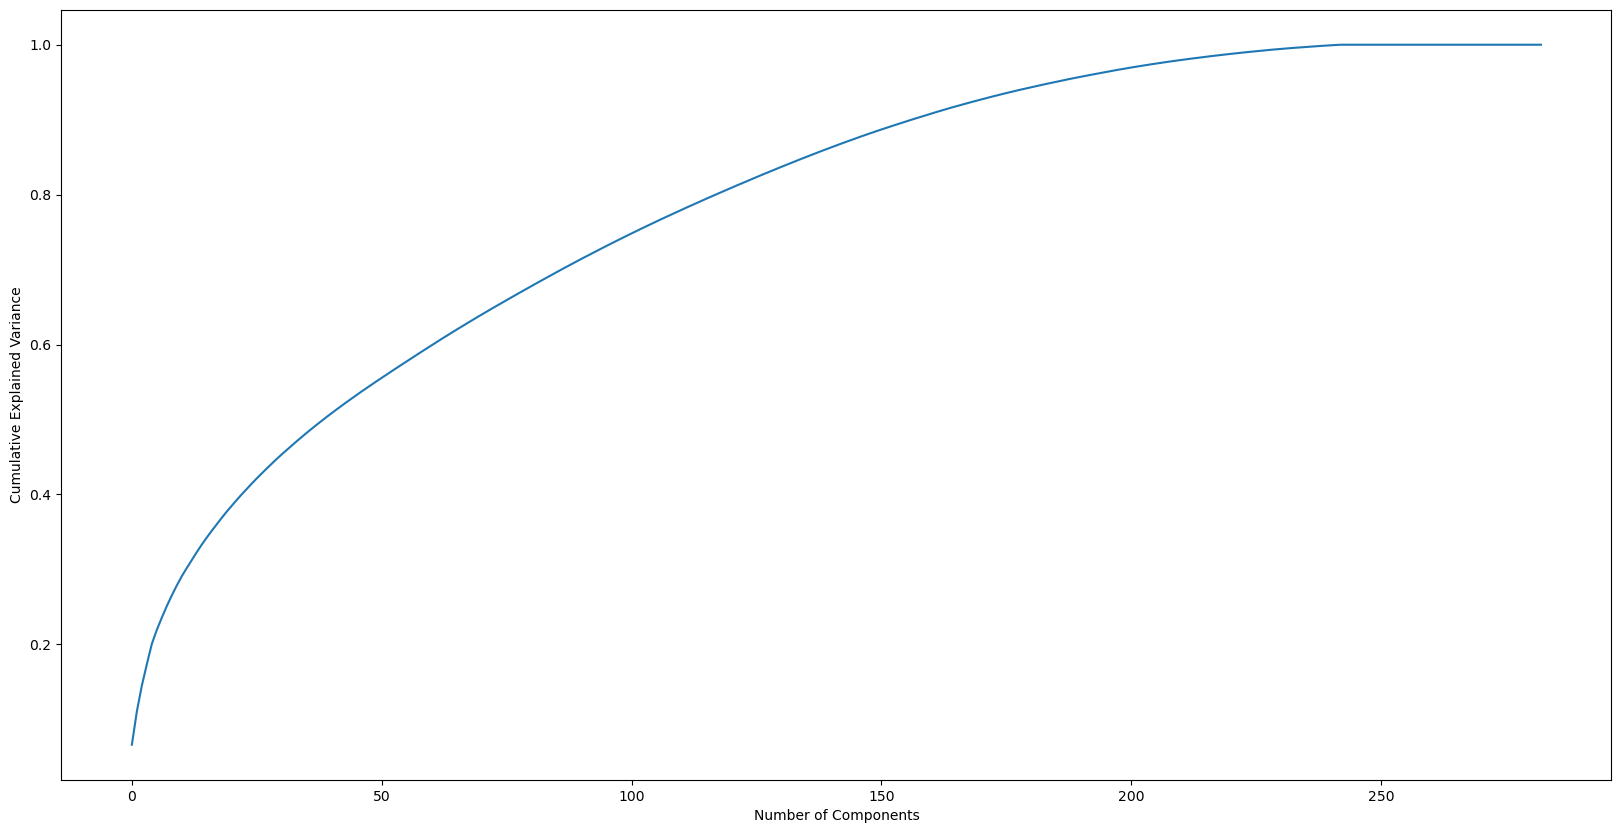

In [34]:
# Perform PCA on the azdias dataset
pca = PCA().fit(azdias)

# Set up the plot size for better visibility
plt.figure(figsize=(20, 10))

# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Label the axes
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Show the plot
plt.show()

In [35]:
def display_pca_weights(component_number):
    """
    Display the weights of the specified principal component.

    Parameters:
    component_number (int): The index of the principal component (1-based).
    
    Returns:
    pd.DataFrame: A DataFrame containing the weights of the specified principal component, sorted by weight.
    """
    # Extract the weights for the specified principal component
    weights = pd.DataFrame(np.round(pca.components_[component_number - 1: component_number], 4), columns=azdias.columns)
    
    # Set the index for better readability
    weights.index = ['Weights']
    
    # Sort the weights in descending order
    weights = weights.sort_values(by='Weights', axis=1, ascending=False)
    
    # Transpose the DataFrame for better presentation
    weights = weights.T
    
    # Print the weights
    print(weights)
    
    return weights


In [36]:
def reduce_dim(df, n=220):
    """
    Reduces the dimensionality of the given DataFrame using Principal Component Analysis (PCA).

    Parameters:
    df (pd.DataFrame): The DataFrame to be reduced.
    n (int): The number of principal components to keep (default is 220).

    Returns:
    pd.DataFrame: A DataFrame containing the reduced data with 'n' principal components.
    """
    
    # Initialize PCA with the specified number of components
    pca = PCA(n_components=n).fit(df)
    
    # Transform the original data into the reduced space
    reduced_data = pca.transform(df)
    
    # Convert the reduced data into a DataFrame for better usability
    reduced_data = pd.DataFrame(reduced_data)
    
    # Print the cumulative explained variance ratio to assess variance retention
    print("Cumulative explained variance:", pca.explained_variance_ratio_.sum())
    
    return reduced_data


In [37]:
# Reduce the azdias dataset to 220 principal components
reduced_azdias = reduce_dim(azdias)

# Reduce the customers dataset to 220 principal components
reduced_customers = reduce_dim(customers)

# Check the shapes of the reduced datasets
print('Shape of reduced azdias:', reduced_azdias.shape)
print('Shape of reduced customers:', reduced_customers.shape)

Cumulative explained variance: 0.9870128665876023
Cumulative explained variance: 0.9973590203722758
Shape of reduced azdias: (415405, 220)
Shape of reduced customers: (100341, 220)


- With PCA, our goal is to ensure that the transformed dataset maintains high variance. High variance indicates that we are retaining critical information from the original dataset while effectively reducing its dimensionality. This is essential because the information we lose during this process can significantly impact the performance of any subsequent analysis or model.

- Based on the cumulative explained variance plot, we observe that up to approximately 220 components, the cumulative variance remains high. This suggests that these components collectively explain a substantial proportion of the variability in the dataset. Retaining this level of variance is crucial because it implies that we are capturing the underlying structure of the data, which is often necessary for tasks such as clustering, classification, or visualization.

- By selecting 220 components, we strike an optimal balance. Beyond this point, while additional components do contribute to the explained variance, the increase is marginal. This indicates that they are likely capturing noise rather than meaningful information, which can lead to overfitting or complicating the model unnecessarily.

<b> Key Considerations:</b>
- Information Retention: Choosing 220 components ensures that we keep a significant amount of the dataset's informative features, which is essential for downstream analyses. This approach minimizes the risk of discarding vital data patterns that could affect our results.

- Computational Efficiency: Reducing the dimensionality to 220 components not only simplifies the dataset but also enhances computational efficiency. Fewer dimensions mean less computational power and memory are required for processing, leading to faster analysis and model training.

- Diminishing Returns: The cumulative variance plot indicates that after 220 components, the returns in explained variance diminish. This reinforces our decision to stop at this point to avoid unnecessary complexity and potential overfitting.

### 2.5 Clustering Analysis Using the Elbow Method
Now that we have reduced the dimensionality of our datasets, we can perform clustering to identify patterns and group similar observations. One effective method for determining the optimal number of clusters is the Elbow Method.

In [38]:
from sklearn.cluster import KMeans

def calculate_kmeans_score(data, k):
    """
    Calculate the KMeans score for a given dataset and number of clusters.

    Parameters:
    data (DataFrame): The dataset to cluster.
    k (int): The number of clusters.

    Returns:
    float: The absolute value of the KMeans score.
    """
    kmeans_model = KMeans(n_clusters=k)  # Initialize KMeans
    kmeans_model.fit(data)  # Fit the model to the data
    return abs(kmeans_model.score(data))  # Return the absolute score

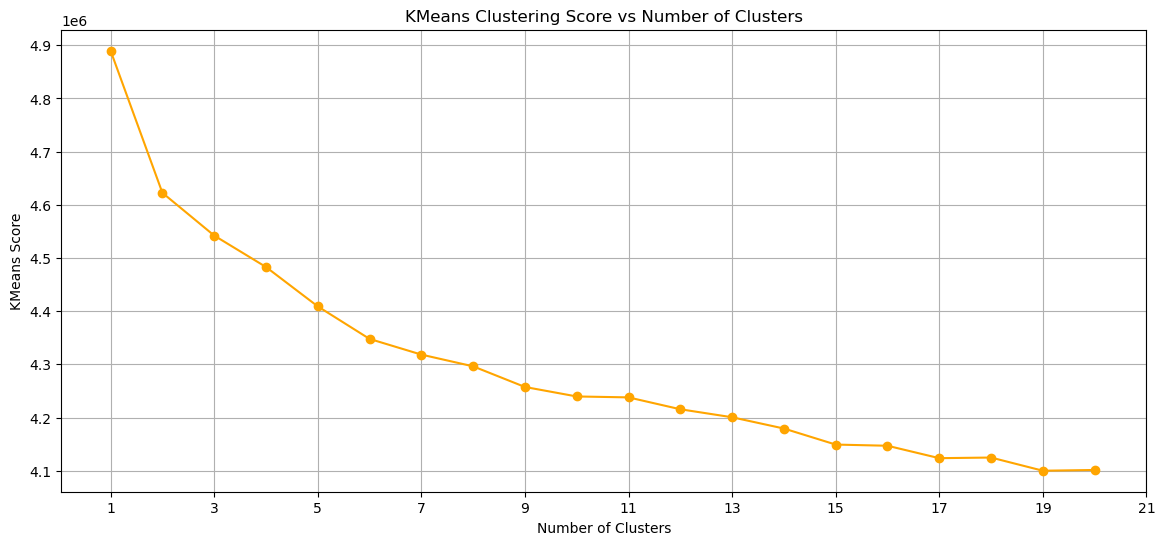

In [39]:
# Define the range of cluster centers
centers = np.linspace(1, 20, 20)

# Initialize a list to store the scores for each number of clusters
scores = []

# Calculate the KMeans score for a sample of the dataset with different cluster counts
for i in range(1, 21): 
    # Append the absolute KMeans score to the scores list
    scores.append(calculate_kmeans_score(reduced_azdias.sample(20000), i))

# Plot the scores against the number of clusters
plt.figure(figsize=(14, 6))
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.title('KMeans Clustering Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('KMeans Score')
plt.xticks(list(range(1,22,2)))  # Set x-ticks for clarity
plt.grid()
plt.show()


* from the chart, we observe that the average distance within clusters shows a noticeable flattening around 15 clusters. This flattening indicates that adding more clusters beyond this point does not significantly reduce the distance between points in the same cluster. Essentially, this suggests that 15 clusters provide a good balance between cluster granularity and cohesion.

* Therefore, we will choose 15 clusters for our KMeans clustering, as this number optimally captures the underlying structure of the data while maintaining interpretability. This choice will help us better understand the segments within our customer data.

In [49]:
# Predict clusters for the azdias dataset
kmeans_k = KMeans(15)
model_k = kmeans_k.fit(reduced_azdias)
pred_azdias = model_k.predict(reduced_azdias)

# Print the predictions for azdias
print('Cluster predictions for azdias:\n', pred_azdias)

# Create a DataFrame for azdias cluster assignments
azdias_cluster_assignments = pd.DataFrame(pred_azdias, columns=['Cluster'])

# Predict clusters for the customers dataset
pred_customers = model_k.predict(reduced_customers)

# Print the predictions for customers
print('Cluster predictions for customers:\n', pred_customers)

# Create a DataFrame for customers cluster assignments
customers_cluster_assignments = pd.DataFrame(pred_customers, columns=['Cluster'])

# Display the shapes of the cluster assignments DataFrames
print('Shape of azdias cluster assignments:', azdias_cluster_assignments.shape)
print('Shape of customers cluster assignments:', customers_cluster_assignments.shape)


Cluster predictions for azdias:
 [13  7 10 ...  5  2 12]
Cluster predictions for customers:
 [ 2 10 13 ...  3  5  5]
Shape of azdias cluster assignments: (415405, 1)
Shape of customers cluster assignments: (100341, 1)


### 2.6 Understanding Cluster Dynamics: A Comparative Analysis of General and Customer Datasets

In [50]:
# Count the number of predictions for each customer segment
customer_segments = pd.Series(pred_customers)
customer_counts = customer_segments.value_counts().sort_index()

# Count the number in each population segment
population_segments = pd.Series(pred_azdias)
population_counts = population_segments.value_counts().sort_index()

# Print the counts for better readability
print("Customer Segment Counts:")
print(customer_counts)

print("\nPopulation Segment Counts:")
print(population_counts)

Customer Segment Counts:
0       839
1         8
2      3529
3       515
4       299
5     14900
6     45099
7      1049
8       168
9     10654
10     7341
11       47
12       25
13    12443
14     3425
dtype: int64

Population Segment Counts:
0     25818
1      2430
2     33693
3     33063
4     34901
5     26990
6     27742
7     25524
8     35910
9     30506
10    33399
11    22784
12    43314
13    28919
14    10412
dtype: int64


In [51]:
# Create a DataFrame to compare population and customer segments
df_statistics = pd.concat([population_counts, customer_counts], axis=1).reset_index()
df_statistics.columns = ['Cluster', 'Population', 'Customer']

# Calculate the percentage difference between customer and population segments
df_statistics['Difference'] = (df_statistics['Customer'] / df_statistics['Customer'].sum() * 100) - \
                               (df_statistics['Population'] / df_statistics['Population'].sum() * 100)

# Display the DataFrame with statistics
df_statistics

Cluster  Population  Customer  Difference
0         0       25818       839   -5.378991
1         1        2430         8   -0.576998
2         2       33693      3529   -4.593873
3         3       33063       515   -7.445971
4         4       34901       299   -8.103696
5         5       26990     14900    8.352090
6         6       27742     45099   38.267433
7         7       25524      1049   -5.098930
8         8       35910       168   -8.477147
9         9       30506     10654    3.274117
10       10       33399      7341   -0.724053
11       11       22784        47   -5.437928
12       12       43314        25  -10.402018
13       13       28919     12443    5.439074
14       14       10412      3425    0.906891

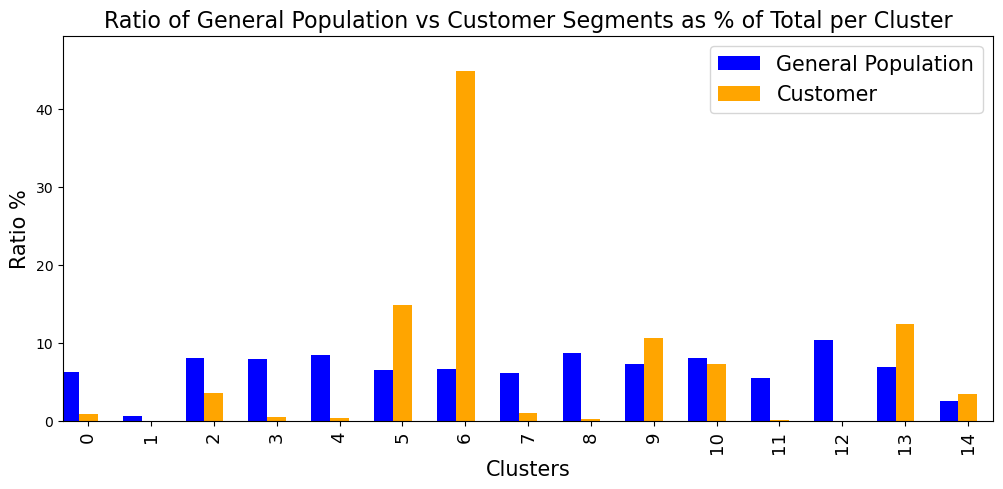

In [52]:
# Calculate the percentage of each cluster for the general population and customer segments
df_statistics['population_percentage'] = (df_statistics['Population'] / df_statistics['Population'].sum() * 100).round(2)
df_statistics['customer_percentage'] = (df_statistics['Customer'] / df_statistics['Customer'].sum() * 100).round(2)

# Create a figure for plotting the proportions
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot population percentages as blue bars
ax = df_statistics['population_percentage'].plot(
    x=df_statistics['Cluster'], 
    width=-0.3, 
    align='edge', 
    color='blue', 
    kind='bar', 
    position=0,
    label='General Population'
)

# Plot customer percentages as orange bars
ax = df_statistics['customer_percentage'].plot(
    kind='bar', 
    color='orange', 
    width=0.3, 
    align='edge', 
    position=1,
    label='Customer'
)

# Set the axis labels and formatting
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(len(df_statistics)))
ax.tick_params(axis='x', which='major', labelsize=13)
ax.margins(x=0.5, y=0.1)

# Add legend and title
plt.legend(fontsize=15)
plt.title('Ratio of General Population vs Customer Segments as % of Total per Cluster', fontsize=16)
plt.show()


In [53]:
def extract_pca_weights(principal_component, num_weights):
    """
    Extracts the highest positive and negative weights for a given principal component.

    Args:
        principal_component (int): The index of the principal component (1-based).
        num_weights (int): The number of weights to return for both positive and negative weights.

    Returns:
        None
    """
    # Create a DataFrame for explained variance ratio and weights
    explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained_Variance']).round(3)
    weight_matrix = pd.DataFrame(pca.components_, columns=azdias.columns.values).round(3)

    # Combine explained variance with weights
    combined_results = pd.concat([explained_variance, weight_matrix], axis=1)

    # Display principal component information
    print("Principal Component:", principal_component)
    print('\nHighest Positive Weights:')
    print(combined_results.iloc[principal_component - 1].sort_values(ascending=False)[:num_weights])
    print('\nNegative Weights:')
    print(combined_results.iloc[principal_component - 1].sort_values()[:num_weights])


In [55]:
# Show highest positive and negative weights for the 6th and 12th principal component
print("Highest Positive Weights and Negative weights for Principal Component 6:")
highest_weights_6 = extract_pca_weights(principal_component=6, num_weights=10)
print(highest_weights_6)

print("\nHighest Positive Weights and Negative weights for Principal Component 2:")
lowest_weights_12 = extract_pca_weights(principal_component=12, num_weights=10)
print(lowest_weights_12)


Highest Positive Weights and Negative weights for Principal Component 6:
Principal Component: 6

Highest Positive Weights:
KBA05_MAXVORB             0.206
KBA05_ZUL1                0.197
KBA05_VORB2               0.185
KBA13_SEG_MITTELKLASSE    0.156
WOHNLAGE                  0.126
KBA13_BJ_1999             0.122
KBA13_CCM_1401_2500       0.119
KBA13_ALTERHALTER_45      0.118
KBA13_VORB_3              0.116
KBA05_MAXSEG              0.107
Name: 5, dtype: float64

Negative Weights:
KBA05_VORB0            -0.219
KBA13_SEG_KLEINST      -0.193
KBA05_MAXBJ            -0.192
KBA13_VORB_0           -0.178
KBA13_SEG_MINIWAGEN    -0.151
KBA13_ALTERHALTER_61   -0.148
KBA05_ZUL3             -0.131
KBA13_KRSZUL_NEU       -0.129
KBA05_CCM1             -0.127
KBA13_HALTER_65        -0.116
Name: 5, dtype: float64
None

Highest Positive Weights and Negative weights for Principal Component 2:
Principal Component: 12

Highest Positive Weights:
KBA05_ANTG4             0.248
ANZ_HAUSHALTE_AKTIV     0.221


In [56]:
# Analyze cluster with overrepresentation in customer segment
cluster_index = 6  # Adjust as needed
cluster_center = model_k.cluster_centers_[cluster_index]

# Convert to Series for readability
cluster_center_series = pd.Series(cluster_center)

# Get top features in the cluster
top_features = cluster_center_series.sort_values(ascending=False).head(10)

# Presenting the results in a more structured way
print("Top Features in Cluster 6 (Overrepresented in Customer Segment):")
print("=" * 50)
print("{:<10} {:<15} {:<15}".format("Feature", "Weight", "Description"))
print("=" * 50)

for feature in top_features.index:
    # You can add feature descriptions if available
    feature_description = "Description of feature {}".format(feature)  # Placeholder
    print("{:<10} {:<15} {:<15}".format(feature, round(top_features[feature], 4), feature_description))


Top Features in Cluster 6 (Overrepresented in Customer Segment):
Feature    Weight          Description    
8          2.2329          Description of feature 8
5          1.4331          Description of feature 5
3          1.0287          Description of feature 3
2          0.6477          Description of feature 2
16         0.6303          Description of feature 16
9          0.5153          Description of feature 9
14         0.4801          Description of feature 14
18         0.3109          Description of feature 18
24         0.2616          Description of feature 24
27         0.2534          Description of feature 27


In [57]:
feature_names = azdias.columns

# Get the actual feature names for the top features
top_feature_names = feature_names[top_features.index]
top_feature_info = pd.Series(top_feature_names, index=top_features.index)

print("Top Features in Cluster 6 (Overrepresented in Customer Segment):")
print("=" * 50)
print("{:<10} {:<15} {:<15}".format("Feature", "Weight", "Feature Name"))
print("=" * 50)

for feature in top_features.index:
    print("{:<10} {:<15} {:<15}".format(feature, round(top_features[feature], 4), top_feature_info[feature]))


Top Features in Cluster 6 (Overrepresented in Customer Segment):
Feature    Weight          Feature Name   
8          2.2329          ANZ_TITEL      
5          1.4331          ANZ_HH_TITEL   
3          1.0287          ALTERSKATEGORIE_FEIN
2          0.6477          ALTER_HH       
16         0.6303          CJT_TYP_6      
9          0.5153          ARBEIT         
14         0.4801          CJT_KATALOGNUTZER
18         0.3109          D19_BANKEN_DIREKT
24         0.2616          D19_BEKLEIDUNG_REST
27         0.2534          D19_BUCH_CD    


### Conclusion for Clustering Analysis
- In our clustering analysis of the general population and customer data, we applied K-means clustering to segment the data into distinct groups. After evaluating the elbow method, we determined that using 15 clusters was optimal, as it provided a clear separation with minimal variance within clusters.

<b>Key Findings:</b>

1) Cluster Composition:

- Each cluster exhibited unique characteristics, with certain clusters being overrepresented in the customer segment compared to the general population. For instance, Cluster 6 demonstrated a significant overrepresentation, indicating a distinct demographic or behavioral profile that aligns closely with our target customer base.
    
    
2) Feature Importance:

- Analyzing the top features for the overrepresented cluster revealed that certain attributes, such as age, income, transaction level, education level, marital status, and employment status, significantly influenced the clustering outcome. These features provide insights into the typical customer in this segment, suggesting targeted marketing opportunities.


3) Comparison of Clusters:

- By comparing the proportions of data in each cluster between the general population and customer segments, we identified notable differences. This disparity highlights specific segments that are more likely to convert into customers, guiding future marketing strategies.


4) Statistical Insights:

- The statistics indicated both overrepresentation and underrepresentation of certain clusters. Understanding these dynamics is crucial for tailoring marketing efforts and product offerings to align with the preferences and behaviors of different customer segments.


5) Recommendations:

- Targeted Marketing: Focus on the clusters with higher customer representation for marketing campaigns, utilizing the identified key features to enhance engagement strategies.


6) Further Analysis: 
- Continue exploring the clusters to uncover deeper insights into customer behaviors and preferences, potentially integrating additional data sources to enrich the analysis.

- Dynamic Segmentation: Regularly update the clustering analysis to account for shifts in customer behavior and demographics, ensuring the marketing strategies remain relevant and effective.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [58]:
# The dataset is in CSV format and uses a semicolon (;) as the separator
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [59]:
# display train_data set
mailout_train.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   8.0                 15.0  ...   
1          NaN          NaN                  13.0                  1.0  ...   
2          NaN          NaN                   7.0                  0.0  ...   
3          NaN          NaN                   6.0                  4.0  ...   
4          NaN          NaN                   9.0                 53.0  ...   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       5.0         2.0      1.0             6.0             9.0       3.0   
1       1.0         2.0      1.0             4.0             9.0       7.0   
2       6.0         4.0      2.0             NaN             9.0       2.0   
3       8.0        11.0     11.0             6.0             9.0       1.0   
4       2.0         2.0      1.0             6.0             9.0       3.0   

   ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0         3        0         2                    4  
1         1        0         2                    3  
2         3        0         1                    4  
3         3        0         2                    4  
4         3        0         1                    3  

[5 rows x 367 columns]

In [60]:
# Separate features (X) and target variable (y) from the dataset
# Drop the 'RESPONSE' column from the features
X = mailout_train.drop('RESPONSE', axis=1)

# Select the 'RESPONSE' column as the target variable
y = mailout_train['RESPONSE']

In [61]:
# Preprocess the training data using the defined function
df_mailout_train = processed_data(X, False)

# Print the shape of the processed DataFrame
print("Final shape of the processed mailout training data:", df_mailout_train.shape)

Shape after removing highly correlated features: (42962, 253)
Shape after one-hot encoding: (42962, 300)
Shape after imputation: (42962, 300)
Shape after scaling: (42962, 300)
Final shape of the processed mailout training data: (42962, 299)


In [62]:
print("Shape of the response variable (y):", y.shape)

Shape of the response variable (y): (42962,)


In [63]:
# Split the dataset into Train, Validation, and Test sets
# Using stratified sampling to maintain the proportion of the target variable
X_train, X_val, y_train, y_val = train_test_split(
    df_mailout_train,  # Feature set
    y,                 # Response variable
    stratify=y,       # Stratify by the target variable
    test_size=0.2,    # 20% of the data for validation
    random_state=42   # For reproducibility
)

# Print the shapes of the resulting datasets
print("Training feature set shape:", X_train.shape)
print("Validation feature set shape:", X_val.shape)
print("Training response variable shape:", y_train.shape)
print("Validation response variable shape:", y_val.shape)

Training feature set shape: (34369, 299)
Validation feature set shape: (8593, 299)
Training response variable shape: (34369,)
Validation response variable shape: (8593,)


# 3 Model Training 
- Given the significant class imbalance in the MAILOUT_TRAIN dataset—where only 532 out of 43,000 individuals responded to the mail-out campaign—traditional metrics like accuracy, precision, recall, and F1 score proved inadequate for effective evaluation. 
- Therefore, we focused on the AUC (Area Under the ROC Curve) and ROC (Receiver Operating Characteristic) as our primary evaluation metrics. These metrics provide a more robust assessment of the model's performance by measuring its ability to distinguish between the positive and negative classes, making them suitable for imbalanced datasets.

In [183]:
from time import time

def train_predict(learner, X_train, y_train, X_test, y_test): 
    """
    Train a learning algorithm and make predictions.

    Parameters:
       - learner: The learning algorithm to be trained and predicted on.
       - X_train: Features of the training set.
       - y_train: Labels of the training set.
       - X_test: Features of the testing set.
       - y_test: Labels of the testing set.

    Returns:
       - roc: The ROC AUC score for the test set.
    """
    
    results = {}
    
    # Fit the learner to the training data
    start = time()  # Get start time
    learner.fit(X_train, y_train)
    end = time()  # Get end time
    results['train_time'] = end - start  # Calculate training time
    
    # Get predictions on the test set and training set
    start = time()  # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()  # Get end time
    results['pred_time'] = end - start  # Calculate total prediction time
    
    # Compute ROC AUC score
    roc = roc_auc_score(y_test, predictions_test)
    
    
    # Return the ROC score
    return roc

In [184]:

# Initialize 5 stratified folds for cross-validation with shuffling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get the number of splits
n_splits = skf.get_n_splits(X, y)
print(f'Number of splits: {n_splits}')


Number of splits: 5


# 3.1 Model Baseline

### We are trying "Three different model" and will choose the one which perform optimal
- In this project, we evaluated three different algorithms and used various evaluation metrics to determine the best-performing model for our dataset.

In [185]:
# Initialize the regression algorithms
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)
#alg_xgb_class = XGBClassifier()

# List to store results
result_list = []

# Loop through each algorithm
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    # Initialize fold counter
    j = 0
    
    # Stratified K-Fold cross-validation
    for train_index, val_index in skf.split(df_mailout_train, y):
        j += 1
        # Print the current fold (optional)
        # print('Fold {}...'.format(j))
        
        result = {}
        result['alg_name'] = alg_name
        result['fold'] = j
        result['base_params'] = alg.get_params()
        
        # Split the data into training and validation sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model and get ROC score
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print(result)
        print("\n")
        print("---" * 30)


{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'base_params': {'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 42}, 'roc': 0.7537235600802641}


------------------------------------------------------------------------------------------
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'base_params': {'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 42}, 'roc': 0.790022488937249}


------------------------------------------------------------------------------------------
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'base_params': {'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 42}, 'roc': 0.738576634545689}


------------------------------------------------------------------------------------------
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'base_params': {'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 42}

{'alg_name': 'XGBRegressor', 'fold': 5, 'base_params': {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}, 'roc': 0.5941083871771041}


----------------

###  compare the results from different models  (Base Parameters)

In [186]:
# dataset for comparison

df_scores = pd.DataFrame(result_list)
display(df_scores)

# Calculate the mean ROC score for each algorithm
mean_roc_scores = df_scores.groupby('alg_name')['roc'].mean()

# Display the mean ROC scores
mean_roc_scores


alg_name  fold  \
0           AdaBoostRegressor     1   
1           AdaBoostRegressor     2   
2           AdaBoostRegressor     3   
3           AdaBoostRegressor     4   
4           AdaBoostRegressor     5   
5   GradientBoostingRegressor     1   
6   GradientBoostingRegressor     2   
7   GradientBoostingRegressor     3   
8   GradientBoostingRegressor     4   
9   GradientBoostingRegressor     5   
10               XGBRegressor     1   
11               XGBRegressor     2   
12               XGBRegressor     3   
13               XGBRegressor     4   
14               XGBRegressor     5   

                                          base_params       roc  
0   {'estimator': None, 'learning_rate': 1.0, 'los...  0.753724  
1   {'estimator': None, 'learning_rate': 1.0, 'los...  0.790022  
2   {'estimator': None, 'learning_rate': 1.0, 'los...  0.738577  
3   {'estimator': None, 'learning_rate': 1.0, 'los...  0.729845  
4   {'estimator': None, 'learning_rate': 1.0, 'los...  0.755773  
5   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  0.736573  
6   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  0.796024  
7   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  0.747239  
8   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  0.738298  
9   {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...  0.770416  
10  {'objective': 'reg:squarederror', 'base_score'...  0.612552  
11  {'objective': 'reg:squarederror', 'base_score'...  0.645964  
12  {'objective': 'reg:squarederror', 'base_score'...  0.618396  
13  {'objective': 'reg:squarederror', 'base_score'...  0.601649  
14  {'objective': 'reg:squarederror', 'base_score'...  0.594108

alg_name
AdaBoostRegressor            0.753588
GradientBoostingRegressor    0.757710
XGBRegressor                 0.614534
Name: roc, dtype: float64

<b> * Among the three models with default parameters, AdaBoostRegressor and GradientBoostingRegressor performed notably better compared to XGBRegressor.</b>

<b> * However, the XGBRegressor was significantly faster than the other two models, which took considerably more time even without parameter tuning.</b>

<b> * Given its speed, we can afford to perform extensive parameter tuning on XGBRegressor to find the optimal model for our dataset. The tradeoff between speed and performance should be manageable, making it a promising candidate for further optimization.</b>

## 3.2 Baseline-Tuning Iterative Enhancements (Refinement) - 1

In [261]:
# Split the dataset into Train, Validation, and Test sets
# Using stratified sampling to maintain the proportion of the target variable
X_train, X_val, y_train, y_val = train_test_split(
    df_mailout_train,  # Feature set
    y,                 # Response variable
    stratify=y,       # Stratify by the target variable
    test_size=0.2,    # 20% of the data for validation
    random_state=42   # For reproducibility
)

In [262]:
# define Optuna model tuning function
def objective(trial, scale_pos_weight, scoring):
    params = {
        "verbosity": 0,
        "max_depth": trial.suggest_int("max_depth", 1, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, 10),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 200),
    }

    
    # scale_pos_weight is for balancing imbalanced dataset
    model = XGBRegressor(
        scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=42, **params
    )
    #scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    

    # Calculate metrics based on scoring parameter
    if scoring == "roc_auc":
        score = roc_auc_score(y_val, y_pred_proba)
    elif scoring == "accuracy":
        score = accuracy_score(y_val, y_pred)
    elif scoring == "precision":
        score = precision_score(y_val, y_pred)
    elif scoring == "recall":
        score = recall_score(y_val, y_pred)
    elif scoring == "f1":
        score = f1_score(y_val, y_pred)
    else:
        raise ValueError(f"Unsupported scoring metric '{scoring}'")  # Return the score based on the input scoring method
        
    return score

In [263]:
# define model tuning function for testing different scoring methods
def model_tuning(scoring, n_trials=2):
    """model_tuning tunes XGBoostClassifier with specified scoring method then save result to dict results.

    Args:
        scoring (str or make_score obj): scoring method. Run help(cross_val_score) for more info.
        n_trials (int, optional): number of trials. Defaults to 2.
    """
    # only 1.7% purchase rate in group 2, so we need to handle the imbalanced training dataset
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # tune model
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, scale_pos_weight, scoring), n_trials=n_trials
    )

    # evaluation results
    best_params = study.best_params
    
    score = study.best_value

    tuned_xgb_clf = XGBRegressor(
        scale_pos_weight=scale_pos_weight, random_state=42, **best_params
    )
    tuned_xgb_clf.fit(X_train, y_train)
    y_pred_proba = tuned_xgb_clf.predict(X_val)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics based on scoring parameter for final evaluation
    if scoring == "roc_auc":
        best_score = roc_auc_score(y_val, y_pred_proba)
    elif scoring == "accuracy":
        best_score = accuracy_score(y_val, y_pred)
    elif scoring == "precision":
        best_score = precision_score(y_val, y_pred)
    elif scoring == "recall":
        best_score = recall_score(y_val, y_pred)
    elif scoring == "f1":
        best_score = f1_score(y_val, y_pred)
    else:
        raise ValueError(f"Unsupported scoring metric '{scoring}'")

    # Save each result to results
    results["scoring"].append(scoring)
    results["score"].append(score)
    results["n_trials"].append(n_trials)
    results["best_params"].append(best_params)

    #print(f"Best {scoring} score: {best_score}")


In [264]:
# define scoring methods
scorers = [
    "roc_auc",
    "accuracy",
    "recall",
    "precision",
    "f1"
]

# define results as a dict
results = {
    "scoring": [],
    "score": [],
    "n_trials": [],
    "best_params": [],
}


# loop scoring methods
for scorer in scorers:
    model_tuning(scorer, n_trials=500)

[I 2024-07-16 01:52:07,082] A new study created in memory with name: no-name-19264e31-947d-444c-ab51-c8d0189eb384
[I 2024-07-16 01:52:07,729] Trial 0 finished with value: 0.728025215034759 and parameters: {'max_depth': 5, 'learning_rate': 0.07573288854349869, 'n_estimators': 160, 'gamma': 0.8438054645997911, 'subsample': 0.7458358616716012, 'colsample_bytree': 0.9310141087767345, 'reg_alpha': 0.05950326920256042, 'reg_lambda': 3.07584579308894, 'min_child_weight': 136}. Best is trial 0 with value: 0.728025215034759.
[I 2024-07-16 01:52:08,217] Trial 1 finished with value: 0.7755368365824757 and parameters: {'max_depth': 1, 'learning_rate': 0.09517528647872432, 'n_estimators': 230, 'gamma': 0.42944267365930433, 'subsample': 0.6290762513578919, 'colsample_bytree': 0.5658238893752237, 'reg_alpha': 2.940851628593494, 'reg_lambda': 3.1144284407940273, 'min_child_weight': 114}. Best is trial 1 with value: 0.7755368365824757.
[I 2024-07-16 01:52:08,837] Trial 2 finished with value: 0.76074895

[I 2024-07-16 01:52:20,384] Trial 20 finished with value: 0.7782407500038905 and parameters: {'max_depth': 2, 'learning_rate': 0.06751595731142007, 'n_estimators': 250, 'gamma': 0.162494083573305, 'subsample': 0.7336754960379969, 'colsample_bytree': 0.8431233313711614, 'reg_alpha': 5.954478067899828, 'reg_lambda': 2.041801008979709, 'min_child_weight': 171}. Best is trial 7 with value: 0.7908899515574319.
[I 2024-07-16 01:52:21,107] Trial 21 finished with value: 0.7823402495714867 and parameters: {'max_depth': 6, 'learning_rate': 0.023769038306760873, 'n_estimators': 150, 'gamma': 0.3790914118338333, 'subsample': 0.8813267933743052, 'colsample_bytree': 0.5669013099840139, 'reg_alpha': 4.09884656904141, 'reg_lambda': 9.030861279083219, 'min_child_weight': 200}. Best is trial 7 with value: 0.7908899515574319.
[I 2024-07-16 01:52:21,861] Trial 22 finished with value: 0.770782061799289 and parameters: {'max_depth': 7, 'learning_rate': 0.019365107502562803, 'n_estimators': 140, 'gamma': 0.5

[I 2024-07-16 01:52:33,309] Trial 40 finished with value: 0.7725572518235437 and parameters: {'max_depth': 1, 'learning_rate': 0.09811046448480454, 'n_estimators': 60, 'gamma': 0.6047497553937258, 'subsample': 0.8574725941733607, 'colsample_bytree': 0.7986504874566138, 'reg_alpha': 0.876027213076088, 'reg_lambda': 2.2577812130375685, 'min_child_weight': 120}. Best is trial 7 with value: 0.7908899515574319.
[I 2024-07-16 01:52:33,893] Trial 41 finished with value: 0.7857894760243747 and parameters: {'max_depth': 5, 'learning_rate': 0.01006483556069967, 'n_estimators': 100, 'gamma': 0.3752448048703625, 'subsample': 0.8747908414805761, 'colsample_bytree': 0.97800908107738, 'reg_alpha': 1.6995923990838955, 'reg_lambda': 0.6223522784777729, 'min_child_weight': 154}. Best is trial 7 with value: 0.7908899515574319.
[I 2024-07-16 01:52:34,334] Trial 42 finished with value: 0.7559047021971451 and parameters: {'max_depth': 5, 'learning_rate': 0.08885855513505668, 'n_estimators': 80, 'gamma': 0.2

[I 2024-07-16 01:52:43,681] Trial 60 finished with value: 0.7700639824281754 and parameters: {'max_depth': 5, 'learning_rate': 0.03454739917917275, 'n_estimators': 120, 'gamma': 0.4161046444302427, 'subsample': 0.8687211845731831, 'colsample_bytree': 0.9088570073440538, 'reg_alpha': 3.437084452926027, 'reg_lambda': 7.241414747985598, 'min_child_weight': 35}. Best is trial 7 with value: 0.7908899515574319.
[I 2024-07-16 01:52:44,313] Trial 61 finished with value: 0.7896116368874928 and parameters: {'max_depth': 5, 'learning_rate': 0.016298176085174986, 'n_estimators': 140, 'gamma': 0.04740852183859051, 'subsample': 0.7917816474700408, 'colsample_bytree': 0.9677312833488987, 'reg_alpha': 2.5794431144281256, 'reg_lambda': 2.9505094044560067, 'min_child_weight': 166}. Best is trial 7 with value: 0.7908899515574319.
[I 2024-07-16 01:52:45,004] Trial 62 finished with value: 0.7815654797237062 and parameters: {'max_depth': 5, 'learning_rate': 0.011057836887891356, 'n_estimators': 140, 'gamma'

[I 2024-07-16 01:52:58,710] Trial 80 finished with value: 0.7728940599496233 and parameters: {'max_depth': 3, 'learning_rate': 0.09019262895137875, 'n_estimators': 170, 'gamma': 0.5521518988528551, 'subsample': 0.818363675343073, 'colsample_bytree': 0.8469644008415466, 'reg_alpha': 1.1907734135900596, 'reg_lambda': 2.082590209305851, 'min_child_weight': 160}. Best is trial 66 with value: 0.7909505325570073.
[I 2024-07-16 01:52:59,442] Trial 81 finished with value: 0.7878086574138916 and parameters: {'max_depth': 5, 'learning_rate': 0.015790438109118694, 'n_estimators': 150, 'gamma': 0.0008424198855905545, 'subsample': 0.8681707032632594, 'colsample_bytree': 0.9624214909584026, 'reg_alpha': 7.373824451717206, 'reg_lambda': 3.4301269949715785, 'min_child_weight': 166}. Best is trial 66 with value: 0.7909505325570073.
[I 2024-07-16 01:53:00,110] Trial 82 finished with value: 0.789817278812657 and parameters: {'max_depth': 5, 'learning_rate': 0.01208878423422356, 'n_estimators': 150, 'gamm

[I 2024-07-16 01:53:10,063] Trial 100 finished with value: 0.7608401084010841 and parameters: {'max_depth': 1, 'learning_rate': 0.015549501058272235, 'n_estimators': 120, 'gamma': 0.14051738999816446, 'subsample': 0.8945484468010669, 'colsample_bytree': 0.5578345869345347, 'reg_alpha': 8.301763422935153, 'reg_lambda': 1.3091471300213637, 'min_child_weight': 195}. Best is trial 66 with value: 0.7909505325570073.
[I 2024-07-16 01:53:10,637] Trial 101 finished with value: 0.789196462514256 and parameters: {'max_depth': 5, 'learning_rate': 0.010854721276727552, 'n_estimators': 120, 'gamma': 0.09781647097943116, 'subsample': 0.8829577494245112, 'colsample_bytree': 0.9450686133480161, 'reg_alpha': 9.096055208614732, 'reg_lambda': 0.8645253918514294, 'min_child_weight': 181}. Best is trial 66 with value: 0.7909505325570073.
[I 2024-07-16 01:53:11,237] Trial 102 finished with value: 0.7878514531658853 and parameters: {'max_depth': 5, 'learning_rate': 0.012052794262446041, 'n_estimators': 130, 

[I 2024-07-16 01:53:22,982] Trial 120 finished with value: 0.7856260740622172 and parameters: {'max_depth': 5, 'learning_rate': 0.014306286537519027, 'n_estimators': 120, 'gamma': 0.059061128955289616, 'subsample': 0.9767900977437204, 'colsample_bytree': 0.9389035185106103, 'reg_alpha': 8.986061129792947, 'reg_lambda': 0.03905283766791932, 'min_child_weight': 161}. Best is trial 66 with value: 0.7909505325570073.
[I 2024-07-16 01:53:23,963] Trial 121 finished with value: 0.7859239769592118 and parameters: {'max_depth': 5, 'learning_rate': 0.012465875472873589, 'n_estimators': 190, 'gamma': 0.045083768822379064, 'subsample': 0.9118971723441063, 'colsample_bytree': 0.9835350821411443, 'reg_alpha': 9.55538127683646, 'reg_lambda': 0.3148295322394685, 'min_child_weight': 155}. Best is trial 66 with value: 0.7909505325570073.
[I 2024-07-16 01:53:24,762] Trial 122 finished with value: 0.7869505192180716 and parameters: {'max_depth': 5, 'learning_rate': 0.016944223830355376, 'n_estimators': 17

[I 2024-07-16 01:53:39,864] Trial 140 finished with value: 0.7861340651962714 and parameters: {'max_depth': 6, 'learning_rate': 0.010525458481432645, 'n_estimators': 190, 'gamma': 0.046035057190330436, 'subsample': 0.9640871736095932, 'colsample_bytree': 0.9157839392264748, 'reg_alpha': 7.912684087141459, 'reg_lambda': 1.1829383449366173, 'min_child_weight': 164}. Best is trial 131 with value: 0.7919098243484486.
[I 2024-07-16 01:53:40,648] Trial 141 finished with value: 0.7914635257919439 and parameters: {'max_depth': 5, 'learning_rate': 0.013309175807293662, 'n_estimators': 180, 'gamma': 0.018780325261697595, 'subsample': 0.9849030276403761, 'colsample_bytree': 0.8995703224635178, 'reg_alpha': 8.372835135784184, 'reg_lambda': 0.988654835407479, 'min_child_weight': 166}. Best is trial 131 with value: 0.7919098243484486.
[I 2024-07-16 01:53:41,420] Trial 142 finished with value: 0.7911217155649818 and parameters: {'max_depth': 5, 'learning_rate': 0.013344734574015341, 'n_estimators': 1

[I 2024-07-16 01:53:56,725] Trial 160 finished with value: 0.7893020624217728 and parameters: {'max_depth': 5, 'learning_rate': 0.015048633731486644, 'n_estimators': 190, 'gamma': 0.020193313375395976, 'subsample': 0.9892718205842274, 'colsample_bytree': 0.765671817327214, 'reg_alpha': 7.613178099513531, 'reg_lambda': 3.243508115841988, 'min_child_weight': 150}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:53:57,545] Trial 161 finished with value: 0.7908149200441964 and parameters: {'max_depth': 5, 'learning_rate': 0.010358580464779402, 'n_estimators': 180, 'gamma': 0.0213895113704287, 'subsample': 0.9842673980139498, 'colsample_bytree': 0.8154738531384778, 'reg_alpha': 7.256486437315651, 'reg_lambda': 2.5945541868716746, 'min_child_weight': 128}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:53:58,446] Trial 162 finished with value: 0.786160743067644 and parameters: {'max_depth': 5, 'learning_rate': 0.013501093769978528, 'n_estimators': 200, 

[I 2024-07-16 01:54:12,839] Trial 180 finished with value: 0.7869499634290845 and parameters: {'max_depth': 5, 'learning_rate': 0.012340376543750232, 'n_estimators': 180, 'gamma': 0.05245733393214298, 'subsample': 0.9995140609308394, 'colsample_bytree': 0.7567074703656235, 'reg_alpha': 6.971376607084619, 'reg_lambda': 2.046384798622343, 'min_child_weight': 136}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:54:13,608] Trial 181 finished with value: 0.7910539093085762 and parameters: {'max_depth': 5, 'learning_rate': 0.0114722937730038, 'n_estimators': 180, 'gamma': 0.032205651430903, 'subsample': 0.9771161330925219, 'colsample_bytree': 0.7735513363424622, 'reg_alpha': 7.30340958530895, 'reg_lambda': 2.4238543037555687, 'min_child_weight': 128}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:54:14,344] Trial 182 finished with value: 0.7904036361938682 and parameters: {'max_depth': 5, 'learning_rate': 0.013610081713067403, 'n_estimators': 170, 'ga

[I 2024-07-16 01:54:30,678] Trial 200 finished with value: 0.7911656228949492 and parameters: {'max_depth': 5, 'learning_rate': 0.014992406329568969, 'n_estimators': 190, 'gamma': 0.040734009532567436, 'subsample': 0.9870036903417765, 'colsample_bytree': 0.7999395972498871, 'reg_alpha': 6.88918803311649, 'reg_lambda': 5.7733465384304035, 'min_child_weight': 148}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:54:31,551] Trial 201 finished with value: 0.7897411357214474 and parameters: {'max_depth': 5, 'learning_rate': 0.014945877931260704, 'n_estimators': 190, 'gamma': 0.04218519580705081, 'subsample': 0.9835243914422408, 'colsample_bytree': 0.8012517133853159, 'reg_alpha': 4.476162340564801, 'reg_lambda': 4.077036222053253, 'min_child_weight': 143}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:54:32,406] Trial 202 finished with value: 0.7892709382385046 and parameters: {'max_depth': 5, 'learning_rate': 0.012837502208344845, 'n_estimators': 180

[I 2024-07-16 01:54:47,916] Trial 220 finished with value: 0.7845806349778018 and parameters: {'max_depth': 5, 'learning_rate': 0.015719567387529214, 'n_estimators': 190, 'gamma': 0.030806548644117016, 'subsample': 0.9675623441341447, 'colsample_bytree': 0.802394661150786, 'reg_alpha': 5.748069877281735, 'reg_lambda': 7.038334284899895, 'min_child_weight': 148}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:54:48,757] Trial 221 finished with value: 0.7912734459584136 and parameters: {'max_depth': 5, 'learning_rate': 0.01007440363881621, 'n_estimators': 180, 'gamma': 0.8707800028216514, 'subsample': 0.9686198942625155, 'colsample_bytree': 0.7866638876264438, 'reg_alpha': 6.768659401158011, 'reg_lambda': 8.154287274189079, 'min_child_weight': 132}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:54:49,594] Trial 222 finished with value: 0.7902491268555016 and parameters: {'max_depth': 5, 'learning_rate': 0.011692967332978662, 'n_estimators': 180, '

[I 2024-07-16 01:55:04,019] Trial 240 finished with value: 0.7906381791463525 and parameters: {'max_depth': 5, 'learning_rate': 0.010227652141724294, 'n_estimators': 170, 'gamma': 0.047619985255292145, 'subsample': 0.9583456929972759, 'colsample_bytree': 0.7603419964162454, 'reg_alpha': 7.326012128761639, 'reg_lambda': 2.9190616311226334, 'min_child_weight': 146}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:04,854] Trial 241 finished with value: 0.7907404443199477 and parameters: {'max_depth': 5, 'learning_rate': 0.011550630781359868, 'n_estimators': 180, 'gamma': 0.00024162564404305725, 'subsample': 0.9474440697825608, 'colsample_bytree': 0.7678399821184093, 'reg_alpha': 7.223097427990247, 'reg_lambda': 6.568469854411285, 'min_child_weight': 135}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:05,702] Trial 242 finished with value: 0.7908849494565495 and parameters: {'max_depth': 5, 'learning_rate': 0.010115771689046574, 'n_estimators':

[I 2024-07-16 01:55:20,980] Trial 260 finished with value: 0.788607881977097 and parameters: {'max_depth': 5, 'learning_rate': 0.014170697436175519, 'n_estimators': 190, 'gamma': 0.867231415207066, 'subsample': 0.9808808756796971, 'colsample_bytree': 0.7961391307816766, 'reg_alpha': 7.5957802751470815, 'reg_lambda': 8.485464267268481, 'min_child_weight': 139}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:21,796] Trial 261 finished with value: 0.7902997036533121 and parameters: {'max_depth': 5, 'learning_rate': 0.010053580821905909, 'n_estimators': 170, 'gamma': 0.9230034098694964, 'subsample': 0.9440021541172331, 'colsample_bytree': 0.8218868625563831, 'reg_alpha': 7.376822220529274, 'reg_lambda': 2.7700456551103447, 'min_child_weight': 153}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:22,655] Trial 262 finished with value: 0.7868399172096725 and parameters: {'max_depth': 5, 'learning_rate': 0.011933960176197723, 'n_estimators': 180, '

[I 2024-07-16 01:55:37,205] Trial 280 finished with value: 0.7537638030194903 and parameters: {'max_depth': 5, 'learning_rate': 0.05963118689146503, 'n_estimators': 160, 'gamma': 0.5902648556918502, 'subsample': 0.9999353722249933, 'colsample_bytree': 0.8959229716981053, 'reg_alpha': 7.349524033110897, 'reg_lambda': 2.7061382335213997, 'min_child_weight': 129}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:38,035] Trial 281 finished with value: 0.7881360171271934 and parameters: {'max_depth': 5, 'learning_rate': 0.013055276139032335, 'n_estimators': 180, 'gamma': 0.03110808514989192, 'subsample': 0.9682061697401202, 'colsample_bytree': 0.7796569163913325, 'reg_alpha': 7.195459779363083, 'reg_lambda': 3.0723366507246115, 'min_child_weight': 112}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:38,829] Trial 282 finished with value: 0.7870733485841832 and parameters: {'max_depth': 5, 'learning_rate': 0.011644465115996826, 'n_estimators': 170,

[I 2024-07-16 01:55:54,125] Trial 300 finished with value: 0.7889941553230135 and parameters: {'max_depth': 5, 'learning_rate': 0.016163807702660134, 'n_estimators': 180, 'gamma': 0.03386191045976943, 'subsample': 0.9737663470262495, 'colsample_bytree': 0.8150398548857418, 'reg_alpha': 7.670911691672089, 'reg_lambda': 5.508977934015337, 'min_child_weight': 149}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:54,966] Trial 301 finished with value: 0.7903964109370379 and parameters: {'max_depth': 5, 'learning_rate': 0.011580519648917827, 'n_estimators': 170, 'gamma': 0.02011281706540976, 'subsample': 0.9451690922682594, 'colsample_bytree': 0.8345512979441287, 'reg_alpha': 6.744916149251894, 'reg_lambda': 6.042848531555501, 'min_child_weight': 135}. Best is trial 155 with value: 0.7938423026560044.
[I 2024-07-16 01:55:55,849] Trial 302 finished with value: 0.7880865519073567 and parameters: {'max_depth': 5, 'learning_rate': 0.01341909101714877, 'n_estimators': 190, 

[I 2024-07-16 01:56:12,652] Trial 320 finished with value: 0.790332495203541 and parameters: {'max_depth': 5, 'learning_rate': 0.016136419426381658, 'n_estimators': 170, 'gamma': 0.8317627608736666, 'subsample': 0.9525976332466646, 'colsample_bytree': 0.7935731198556238, 'reg_alpha': 7.969779915137257, 'reg_lambda': 3.004345171141607, 'min_child_weight': 134}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:56:13,609] Trial 321 finished with value: 0.7880898866412782 and parameters: {'max_depth': 5, 'learning_rate': 0.011715888288509765, 'n_estimators': 160, 'gamma': 0.01913262312980701, 'subsample': 0.9649711082247057, 'colsample_bytree': 0.8104107042811841, 'reg_alpha': 7.498165052454788, 'reg_lambda': 3.5738422221153487, 'min_child_weight': 141}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:56:14,462] Trial 322 finished with value: 0.7894537928152046 and parameters: {'max_depth': 5, 'learning_rate': 0.017977746807002502, 'n_estimators': 180, 

[I 2024-07-16 01:56:29,968] Trial 340 finished with value: 0.7890736331481444 and parameters: {'max_depth': 5, 'learning_rate': 0.016881497469646303, 'n_estimators': 170, 'gamma': 0.041976532714581724, 'subsample': 0.9701283006192264, 'colsample_bytree': 0.8395192598319061, 'reg_alpha': 7.65863643767858, 'reg_lambda': 8.237408217574112, 'min_child_weight': 128}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:56:30,704] Trial 341 finished with value: 0.7874963040032369 and parameters: {'max_depth': 5, 'learning_rate': 0.01000258656558042, 'n_estimators': 160, 'gamma': 0.06266465618221666, 'subsample': 0.9200897316226293, 'colsample_bytree': 0.7524818450128018, 'reg_alpha': 8.23677277910618, 'reg_lambda': 1.884653037003184, 'min_child_weight': 151}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:56:31,360] Trial 342 finished with value: 0.7774815422477442 and parameters: {'max_depth': 3, 'learning_rate': 0.012925238093313016, 'n_estimators': 190, '

[I 2024-07-16 01:56:46,259] Trial 360 finished with value: 0.790888284190471 and parameters: {'max_depth': 5, 'learning_rate': 0.015118802164222855, 'n_estimators': 160, 'gamma': 0.8217837064110778, 'subsample': 0.9708182641545268, 'colsample_bytree': 0.7820600878965296, 'reg_alpha': 7.59766598098082, 'reg_lambda': 2.2660438528582505, 'min_child_weight': 133}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:56:47,142] Trial 361 finished with value: 0.7866726247246068 and parameters: {'max_depth': 6, 'learning_rate': 0.011738482758318774, 'n_estimators': 180, 'gamma': 0.0774836286461559, 'subsample': 0.9880961842776993, 'colsample_bytree': 0.7587033442515347, 'reg_alpha': 7.0174320419571705, 'reg_lambda': 1.9691927061230277, 'min_child_weight': 141}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:56:48,040] Trial 362 finished with value: 0.7850352703691106 and parameters: {'max_depth': 5, 'learning_rate': 0.01281689701328302, 'n_estimators': 190, '

[I 2024-07-16 01:57:02,592] Trial 380 finished with value: 0.7883122022360503 and parameters: {'max_depth': 5, 'learning_rate': 0.0116754932761005, 'n_estimators': 180, 'gamma': 0.5150545606205259, 'subsample': 0.9907755201496039, 'colsample_bytree': 0.7492884800893079, 'reg_alpha': 7.750959550289438, 'reg_lambda': 9.617741762511184, 'min_child_weight': 146}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:03,530] Trial 381 finished with value: 0.787201735840164 and parameters: {'max_depth': 5, 'learning_rate': 0.014124663924127754, 'n_estimators': 190, 'gamma': 0.042618515224564835, 'subsample': 0.9619183460725321, 'colsample_bytree': 0.8123295952031813, 'reg_alpha': 7.329999018103812, 'reg_lambda': 2.428081649488196, 'min_child_weight': 134}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:04,337] Trial 382 finished with value: 0.789625531612166 and parameters: {'max_depth': 5, 'learning_rate': 0.011510506483033596, 'n_estimators': 170, 'ga

[I 2024-07-16 01:57:19,852] Trial 400 finished with value: 0.7875568850028123 and parameters: {'max_depth': 5, 'learning_rate': 0.014544360411489387, 'n_estimators': 210, 'gamma': 0.8769501775417707, 'subsample': 0.9896438157849726, 'colsample_bytree': 0.7704399653280724, 'reg_alpha': 7.2556620019261056, 'reg_lambda': 2.200145183920923, 'min_child_weight': 140}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:20,837] Trial 401 finished with value: 0.7880309730086636 and parameters: {'max_depth': 5, 'learning_rate': 0.013302421587566228, 'n_estimators': 190, 'gamma': 0.8658699458232821, 'subsample': 0.9722511262030572, 'colsample_bytree': 0.7831520823290206, 'reg_alpha': 6.947451735840327, 'reg_lambda': 8.725621581079283, 'min_child_weight': 135}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:21,590] Trial 402 finished with value: 0.789139772037589 and parameters: {'max_depth': 5, 'learning_rate': 0.012655016107302543, 'n_estimators': 160, '

[I 2024-07-16 01:57:37,665] Trial 420 finished with value: 0.7866665110457504 and parameters: {'max_depth': 5, 'learning_rate': 0.013407374563208983, 'n_estimators': 160, 'gamma': 0.036444306253175116, 'subsample': 0.936285370530295, 'colsample_bytree': 0.9140564622155435, 'reg_alpha': 7.345281153096899, 'reg_lambda': 5.1214461083253795, 'min_child_weight': 141}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:38,604] Trial 421 finished with value: 0.7908560484292292 and parameters: {'max_depth': 5, 'learning_rate': 0.010023349150961518, 'n_estimators': 180, 'gamma': 0.07020203338946693, 'subsample': 0.9737805690884875, 'colsample_bytree': 0.7773066142646317, 'reg_alpha': 7.910207242594448, 'reg_lambda': 7.9376112806210415, 'min_child_weight': 132}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:39,529] Trial 422 finished with value: 0.7901690932413836 and parameters: {'max_depth': 5, 'learning_rate': 0.015757809490799083, 'n_estimators': 15

[I 2024-07-16 01:57:54,807] Trial 440 finished with value: 0.7782190742334001 and parameters: {'max_depth': 5, 'learning_rate': 0.03619040330548151, 'n_estimators': 150, 'gamma': 0.035127606886838865, 'subsample': 0.9760316387900246, 'colsample_bytree': 0.8248646952741192, 'reg_alpha': 6.913053547095053, 'reg_lambda': 9.109653122681697, 'min_child_weight': 97}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:55,705] Trial 441 finished with value: 0.7896738852540288 and parameters: {'max_depth': 5, 'learning_rate': 0.011756603705516589, 'n_estimators': 190, 'gamma': 0.061086335519770135, 'subsample': 0.9826060546215938, 'colsample_bytree': 0.787604744104086, 'reg_alpha': 8.363283063298923, 'reg_lambda': 7.321547452124141, 'min_child_weight': 133}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:57:56,634] Trial 442 finished with value: 0.7890875278728177 and parameters: {'max_depth': 5, 'learning_rate': 0.013104190436682098, 'n_estimators': 200, 

[I 2024-07-16 01:58:12,166] Trial 460 finished with value: 0.7869271760806205 and parameters: {'max_depth': 4, 'learning_rate': 0.013037206928133621, 'n_estimators': 220, 'gamma': 0.01806534152151295, 'subsample': 0.9841605873243132, 'colsample_bytree': 0.7891243352116616, 'reg_alpha': 7.088820177571827, 'reg_lambda': 1.8804092045950123, 'min_child_weight': 133}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:58:13,109] Trial 461 finished with value: 0.7882610696492527 and parameters: {'max_depth': 5, 'learning_rate': 0.01444221846345238, 'n_estimators': 170, 'gamma': 0.49618739578077586, 'subsample': 0.9705204768006359, 'colsample_bytree': 0.751266027844981, 'reg_alpha': 7.649098784546378, 'reg_lambda': 4.799116485598019, 'min_child_weight': 142}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:58:14,550] Trial 462 finished with value: 0.7889924879560526 and parameters: {'max_depth': 5, 'learning_rate': 0.011694079421057418, 'n_estimators': 270, 

[I 2024-07-16 01:58:29,018] Trial 480 finished with value: 0.7887373808110517 and parameters: {'max_depth': 5, 'learning_rate': 0.011768319967353495, 'n_estimators': 180, 'gamma': 0.00013386307998181402, 'subsample': 0.9894480025869331, 'colsample_bytree': 0.8131864636952628, 'reg_alpha': 7.765967029375726, 'reg_lambda': 1.9644239825264378, 'min_child_weight': 131}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:58:29,790] Trial 481 finished with value: 0.7889947111120004 and parameters: {'max_depth': 5, 'learning_rate': 0.013198492500041539, 'n_estimators': 170, 'gamma': 0.03509221792527087, 'subsample': 0.9722986081548619, 'colsample_bytree': 0.7807135823322462, 'reg_alpha': 6.943545421524591, 'reg_lambda': 2.831093356958237, 'min_child_weight': 137}. Best is trial 308 with value: 0.7940801803424106.
[I 2024-07-16 01:58:30,572] Trial 482 finished with value: 0.7856594214014331 and parameters: {'max_depth': 5, 'learning_rate': 0.01518297400263973, 'n_estimators': 1

[I 2024-07-16 01:58:45,730] A new study created in memory with name: no-name-e0b97743-3281-4734-b9a6-00dc1987bd52
[I 2024-07-16 01:58:46,080] Trial 0 finished with value: 0.8532526475037822 and parameters: {'max_depth': 6, 'learning_rate': 0.0752587168908899, 'n_estimators': 50, 'gamma': 0.7992198050547611, 'subsample': 0.5570159098803715, 'colsample_bytree': 0.8325365182513116, 'reg_alpha': 1.8868276491046085, 'reg_lambda': 4.706127312908157, 'min_child_weight': 145}. Best is trial 0 with value: 0.8532526475037822.
[I 2024-07-16 01:58:46,305] Trial 1 finished with value: 0.7515419527522402 and parameters: {'max_depth': 1, 'learning_rate': 0.07109392859310583, 'n_estimators': 60, 'gamma': 0.2507555117266296, 'subsample': 0.7790369612979106, 'colsample_bytree': 0.8087183017483016, 'reg_alpha': 2.6045734155081135, 'reg_lambda': 4.940302195586907, 'min_child_weight': 128}. Best is trial 0 with value: 0.8532526475037822.
[I 2024-07-16 01:58:46,843] Trial 2 finished with value: 0.8168276504

[I 2024-07-16 01:59:03,352] Trial 20 finished with value: 0.9755615035494006 and parameters: {'max_depth': 6, 'learning_rate': 0.07004626897539125, 'n_estimators': 270, 'gamma': 0.4828606043315924, 'subsample': 0.9329905445372596, 'colsample_bytree': 0.5096800962250152, 'reg_alpha': 7.455567533407979, 'reg_lambda': 3.5604450437850153, 'min_child_weight': 109}. Best is trial 18 with value: 0.9801000814616548.
[I 2024-07-16 01:59:04,664] Trial 21 finished with value: 0.9802164552542767 and parameters: {'max_depth': 6, 'learning_rate': 0.08099166658414968, 'n_estimators': 300, 'gamma': 0.38291951596439333, 'subsample': 0.8456908585796803, 'colsample_bytree': 0.5708179213434165, 'reg_alpha': 6.550427445841143, 'reg_lambda': 3.220773024322917, 'min_child_weight': 9}. Best is trial 21 with value: 0.9802164552542767.
[I 2024-07-16 01:59:05,820] Trial 22 finished with value: 0.9830094262772023 and parameters: {'max_depth': 7, 'learning_rate': 0.07752393520382803, 'n_estimators': 250, 'gamma': 

[I 2024-07-16 01:59:24,357] Trial 40 finished with value: 0.7656231816594903 and parameters: {'max_depth': 2, 'learning_rate': 0.050902627614716124, 'n_estimators': 200, 'gamma': 0.2001806384013865, 'subsample': 0.5792464411074796, 'colsample_bytree': 0.6986458789647858, 'reg_alpha': 0.9810749749828607, 'reg_lambda': 4.913489237662708, 'min_child_weight': 63}. Best is trial 25 with value: 0.9844059117886652.
[I 2024-07-16 01:59:25,538] Trial 41 finished with value: 0.9802164552542767 and parameters: {'max_depth': 7, 'learning_rate': 0.08467061648384892, 'n_estimators': 240, 'gamma': 0.3746142861790823, 'subsample': 0.9644855635583002, 'colsample_bytree': 0.6085501845619646, 'reg_alpha': 5.990117603968269, 'reg_lambda': 5.55920282400434, 'min_child_weight': 38}. Best is trial 25 with value: 0.9844059117886652.
[I 2024-07-16 01:59:27,047] Trial 42 finished with value: 0.9840567904107995 and parameters: {'max_depth': 7, 'learning_rate': 0.07790019666037651, 'n_estimators': 280, 'gamma': 0

[I 2024-07-16 01:59:48,384] Trial 60 finished with value: 0.9827766786919586 and parameters: {'max_depth': 6, 'learning_rate': 0.08318064894514984, 'n_estimators': 290, 'gamma': 0.12433924499480761, 'subsample': 0.5972291649686916, 'colsample_bytree': 0.8383320485602423, 'reg_alpha': 0.03687457452833254, 'reg_lambda': 1.1312403386147514, 'min_child_weight': 15}. Best is trial 55 with value: 0.98591877109275.
[I 2024-07-16 01:59:49,957] Trial 61 finished with value: 0.9842895379960432 and parameters: {'max_depth': 7, 'learning_rate': 0.0819263655109484, 'n_estimators': 290, 'gamma': 0.007649057611666635, 'subsample': 0.531482949654291, 'colsample_bytree': 0.7740959098141376, 'reg_alpha': 0.73676827709331, 'reg_lambda': 3.157285525402697, 'min_child_weight': 31}. Best is trial 55 with value: 0.98591877109275.
[I 2024-07-16 01:59:51,402] Trial 62 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.08185810067249279, 'n_estimators': 290, 'gamma': 0.0

[I 2024-07-16 02:00:13,969] Trial 80 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.07359636742958149, 'n_estimators': 280, 'gamma': 0.12950351013204153, 'subsample': 0.6139733980269685, 'colsample_bytree': 0.8491136728701516, 'reg_alpha': 0.32770074623760204, 'reg_lambda': 3.3704544834312897, 'min_child_weight': 7}. Best is trial 55 with value: 0.98591877109275.
[I 2024-07-16 02:00:15,415] Trial 81 finished with value: 0.984638659373909 and parameters: {'max_depth': 7, 'learning_rate': 0.07399788940397126, 'n_estimators': 280, 'gamma': 0.13000898281242676, 'subsample': 0.6219750005585052, 'colsample_bytree': 0.8433684075679293, 'reg_alpha': 0.31062216012441835, 'reg_lambda': 2.6661521545831026, 'min_child_weight': 8}. Best is trial 55 with value: 0.98591877109275.
[I 2024-07-16 02:00:16,775] Trial 82 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.07540423995243614, 'n_estimators': 280, 'gamma': 0

[I 2024-07-16 02:00:42,555] Trial 101 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.07540798936135223, 'n_estimators': 290, 'gamma': 0.22447635174918334, 'subsample': 0.6154144781611399, 'colsample_bytree': 0.9566346832728534, 'reg_alpha': 0.0824753229702104, 'reg_lambda': 9.38371598013284, 'min_child_weight': 14}. Best is trial 55 with value: 0.98591877109275.
[I 2024-07-16 02:00:43,936] Trial 102 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.06896154847038206, 'n_estimators': 270, 'gamma': 0.18824161217928362, 'subsample': 0.6287575329409596, 'colsample_bytree': 0.9732541661238769, 'reg_alpha': 0.20738603674253608, 'reg_lambda': 8.65779427759587, 'min_child_weight': 7}. Best is trial 55 with value: 0.98591877109275.
[I 2024-07-16 02:00:45,392] Trial 103 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.06930987644374206, 'n_estimators': 270, 'gamma': 0

[I 2024-07-16 02:01:10,477] Trial 121 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.08043689435292836, 'n_estimators': 300, 'gamma': 0.07031433946131975, 'subsample': 0.5859697457160209, 'colsample_bytree': 0.7203955728944175, 'reg_alpha': 1.1159314435482601, 'reg_lambda': 8.442143626461434, 'min_child_weight': 44}. Best is trial 112 with value: 0.9863842662632375.
[I 2024-07-16 02:01:11,954] Trial 122 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.08000352119638844, 'n_estimators': 300, 'gamma': 0.07828766081622734, 'subsample': 0.5849777564952053, 'colsample_bytree': 0.708303850403791, 'reg_alpha': 0.23565500775055181, 'reg_lambda': 8.429882505727239, 'min_child_weight': 52}. Best is trial 112 with value: 0.9863842662632375.
[I 2024-07-16 02:01:13,380] Trial 123 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.07777516080551215, 'n_estimators': 290, 'g

[I 2024-07-16 02:01:38,261] Trial 141 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.07700952745139983, 'n_estimators': 290, 'gamma': 0.04255535237666413, 'subsample': 0.7042851981218561, 'colsample_bytree': 0.6941400017160607, 'reg_alpha': 2.119831697162752, 'reg_lambda': 9.814428688539742, 'min_child_weight': 24}. Best is trial 112 with value: 0.9863842662632375.
[I 2024-07-16 02:01:39,684] Trial 142 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.08326165305063662, 'n_estimators': 290, 'gamma': 0.06880213001189703, 'subsample': 0.7263651268660529, 'colsample_bytree': 0.6710313130551896, 'reg_alpha': 2.3023278296816887, 'reg_lambda': 9.232339728547752, 'min_child_weight': 32}. Best is trial 112 with value: 0.9863842662632375.
[I 2024-07-16 02:01:41,126] Trial 143 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.08773115996792537, 'n_estimators': 300, 'ga

[I 2024-07-16 02:02:05,582] Trial 161 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.0715302246676059, 'n_estimators': 290, 'gamma': 0.07818821326897032, 'subsample': 0.7135975895406979, 'colsample_bytree': 0.6290463335538016, 'reg_alpha': 0.43730681771847973, 'reg_lambda': 7.068671985303489, 'min_child_weight': 22}. Best is trial 112 with value: 0.9863842662632375.
[I 2024-07-16 02:02:06,974] Trial 162 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.07680974390105257, 'n_estimators': 290, 'gamma': 0.12219446625473311, 'subsample': 0.7483729296891075, 'colsample_bytree': 0.6666471008202399, 'reg_alpha': 0.006265438756176053, 'reg_lambda': 7.839300205975956, 'min_child_weight': 10}. Best is trial 112 with value: 0.9863842662632375.
[I 2024-07-16 02:02:08,363] Trial 163 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.07651163884560865, 'n_estimators': 290, 

[I 2024-07-16 02:02:32,878] Trial 181 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.06876775168675542, 'n_estimators': 260, 'gamma': 0.06729324182312783, 'subsample': 0.7624328131785003, 'colsample_bytree': 0.5736597999091981, 'reg_alpha': 0.5029254102138815, 'reg_lambda': 7.591735059092072, 'min_child_weight': 8}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:02:34,240] Trial 182 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.07344798420920783, 'n_estimators': 270, 'gamma': 0.07949406738034731, 'subsample': 0.7855979937295704, 'colsample_bytree': 0.5437402999224743, 'reg_alpha': 0.6426476620145471, 'reg_lambda': 6.9057681684325285, 'min_child_weight': 5}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:02:35,570] Trial 183 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.07152503249148827, 'n_estimators': 270, 'gamma

[I 2024-07-16 02:03:00,611] Trial 201 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.06709949682640928, 'n_estimators': 290, 'gamma': 0.11620058792965508, 'subsample': 0.7804489374334604, 'colsample_bytree': 0.548888334963936, 'reg_alpha': 0.19669660566763295, 'reg_lambda': 6.962580155869933, 'min_child_weight': 1}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:03:02,124] Trial 202 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.067504395362662, 'n_estimators': 290, 'gamma': 0.12282507251567742, 'subsample': 0.7788266358727816, 'colsample_bytree': 0.5221503298196901, 'reg_alpha': 0.31294953624225613, 'reg_lambda': 7.165967535026845, 'min_child_weight': 9}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:03:03,568] Trial 203 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.0641755992355867, 'n_estimators': 290, 'gamma

[I 2024-07-16 02:03:27,988] Trial 221 finished with value: 0.9608984056790411 and parameters: {'max_depth': 5, 'learning_rate': 0.0662206165801054, 'n_estimators': 280, 'gamma': 0.1290262272797028, 'subsample': 0.842368263538711, 'colsample_bytree': 0.5626499601763318, 'reg_alpha': 0.23288355225558904, 'reg_lambda': 6.954693204525067, 'min_child_weight': 7}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:03:29,176] Trial 222 finished with value: 0.9830094262772023 and parameters: {'max_depth': 7, 'learning_rate': 0.06802511425716926, 'n_estimators': 280, 'gamma': 0.5674354404960553, 'subsample': 0.739125021734793, 'colsample_bytree': 0.569107303380068, 'reg_alpha': 0.14881453550224583, 'reg_lambda': 6.693368996276488, 'min_child_weight': 4}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:03:30,735] Trial 223 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.07135351456861315, 'n_estimators': 290, 'gamma':

[I 2024-07-16 02:03:53,894] Trial 241 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.06915843576813943, 'n_estimators': 290, 'gamma': 0.08988884088408092, 'subsample': 0.7455667246597796, 'colsample_bytree': 0.5754404423925176, 'reg_alpha': 0.3296914892757625, 'reg_lambda': 6.936867303682839, 'min_child_weight': 5}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:03:55,280] Trial 242 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.06512436383316882, 'n_estimators': 280, 'gamma': 0.10782236614272712, 'subsample': 0.7123557550950093, 'colsample_bytree': 0.5693541753989523, 'reg_alpha': 0.17732613036769337, 'reg_lambda': 7.2954666760968285, 'min_child_weight': 10}. Best is trial 168 with value: 0.9867333876411032.
[I 2024-07-16 02:03:56,783] Trial 243 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.06856349385563597, 'n_estimators': 290, 'g

[I 2024-07-16 02:04:22,561] Trial 261 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.07653017676554622, 'n_estimators': 300, 'gamma': 0.12466038273630528, 'subsample': 0.7591897551755327, 'colsample_bytree': 0.52814245339873, 'reg_alpha': 0.31460466339537235, 'reg_lambda': 6.966863705124795, 'min_child_weight': 20}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:04:24,162] Trial 262 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.06830564799747016, 'n_estimators': 300, 'gamma': 0.08002975822177615, 'subsample': 0.7697227719631629, 'colsample_bytree': 0.6551050128120143, 'reg_alpha': 0.010658979461612816, 'reg_lambda': 7.259403249502268, 'min_child_weight': 10}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:04:25,694] Trial 263 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.07409986805397473, 'n_estimators': 300, '

[I 2024-07-16 02:04:51,094] Trial 281 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.07532268543010714, 'n_estimators': 300, 'gamma': 0.07230778459162476, 'subsample': 0.7703401408678356, 'colsample_bytree': 0.5088266236161053, 'reg_alpha': 0.3941291483984688, 'reg_lambda': 7.657762566868804, 'min_child_weight': 21}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:04:52,553] Trial 282 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.07403348996032909, 'n_estimators': 290, 'gamma': 0.04674395937817217, 'subsample': 0.730742286631398, 'colsample_bytree': 0.6328877455875912, 'reg_alpha': 1.0088653006929946, 'reg_lambda': 7.226882049179914, 'min_child_weight': 10}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:04:54,055] Trial 283 finished with value: 0.9826603048993366 and parameters: {'max_depth': 7, 'learning_rate': 0.047823406396653084, 'n_estimators': 290, 'gam

[I 2024-07-16 02:05:19,374] Trial 301 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.073264967631159, 'n_estimators': 290, 'gamma': 0.29874420892158804, 'subsample': 0.7566736922037511, 'colsample_bytree': 0.5432688502797242, 'reg_alpha': 0.31781643447690355, 'reg_lambda': 6.601628793638082, 'min_child_weight': 22}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:05:20,782] Trial 302 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.07921420525613318, 'n_estimators': 290, 'gamma': 0.16803835945421347, 'subsample': 0.7933381146872444, 'colsample_bytree': 0.5011110497366882, 'reg_alpha': 0.00678227398043596, 'reg_lambda': 7.297560836949026, 'min_child_weight': 4}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:05:22,279] Trial 303 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.07687639809756494, 'n_estimators': 300, 'gam

[I 2024-07-16 02:05:46,717] Trial 321 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.06882986136326534, 'n_estimators': 290, 'gamma': 0.09330433661069609, 'subsample': 0.7547068358652076, 'colsample_bytree': 0.5607998519856686, 'reg_alpha': 0.6208913490596829, 'reg_lambda': 7.2620463458284386, 'min_child_weight': 5}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:05:48,059] Trial 322 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.07770808051925462, 'n_estimators': 280, 'gamma': 0.15624596207981298, 'subsample': 0.7671262281273046, 'colsample_bytree': 0.6283173016911116, 'reg_alpha': 0.4010333537969255, 'reg_lambda': 6.571951215662734, 'min_child_weight': 16}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:05:48,987] Trial 323 finished with value: 0.9221459327359479 and parameters: {'max_depth': 4, 'learning_rate': 0.08084636855830969, 'n_estimators': 280, 'gam

[I 2024-07-16 02:06:13,167] Trial 341 finished with value: 0.9818456883509834 and parameters: {'max_depth': 6, 'learning_rate': 0.06692575858669413, 'n_estimators': 290, 'gamma': 0.05990310909746639, 'subsample': 0.8208043930462, 'colsample_bytree': 0.6332284347873318, 'reg_alpha': 0.8619171541666167, 'reg_lambda': 6.830633543210893, 'min_child_weight': 8}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:06:14,526] Trial 342 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.07853624251218067, 'n_estimators': 280, 'gamma': 0.11042615445191237, 'subsample': 0.7901039963149374, 'colsample_bytree': 0.585212986939236, 'reg_alpha': 0.5111204879244171, 'reg_lambda': 7.70454276664966, 'min_child_weight': 4}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:06:15,721] Trial 343 finished with value: 0.9663679739322705 and parameters: {'max_depth': 5, 'learning_rate': 0.07509304256421598, 'n_estimators': 300, 'gamma': 

[I 2024-07-16 02:06:41,595] Trial 361 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.07935407801178815, 'n_estimators': 290, 'gamma': 0.09665372934518851, 'subsample': 0.8887408956251261, 'colsample_bytree': 0.5168837585692139, 'reg_alpha': 0.2074666481461676, 'reg_lambda': 7.325479044452048, 'min_child_weight': 5}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:06:43,115] Trial 362 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.07243185499340503, 'n_estimators': 300, 'gamma': 0.14648195455253699, 'subsample': 0.8238690986299164, 'colsample_bytree': 0.8630641291616308, 'reg_alpha': 0.34514429757504933, 'reg_lambda': 7.590301467946602, 'min_child_weight': 13}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:06:44,708] Trial 363 finished with value: 0.9825439311067148 and parameters: {'max_depth': 7, 'learning_rate': 0.05281843852700132, 'n_estimators': 300, 'gam

[I 2024-07-16 02:07:07,466] Trial 381 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.06873038358208941, 'n_estimators': 300, 'gamma': 0.13401394606509906, 'subsample': 0.7314955356968666, 'colsample_bytree': 0.6108847534929285, 'reg_alpha': 0.8018987756441128, 'reg_lambda': 7.43762210014228, 'min_child_weight': 8}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:07:08,914] Trial 382 finished with value: 0.9848714069591528 and parameters: {'max_depth': 7, 'learning_rate': 0.0705488006586465, 'n_estimators': 300, 'gamma': 0.17010399325731151, 'subsample': 0.7478643402745647, 'colsample_bytree': 0.5219451447852014, 'reg_alpha': 0.0016068289312033412, 'reg_lambda': 7.639506320483535, 'min_child_weight': 6}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:07:10,238] Trial 383 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.06755651107396526, 'n_estimators': 300, 'ga

[I 2024-07-16 02:07:35,630] Trial 401 finished with value: 0.7799371581519842 and parameters: {'max_depth': 2, 'learning_rate': 0.07080757187163277, 'n_estimators': 290, 'gamma': 0.1036107696761224, 'subsample': 0.8151199982438737, 'colsample_bytree': 0.8736431678828143, 'reg_alpha': 0.1515893771579404, 'reg_lambda': 6.730057536227488, 'min_child_weight': 18}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:07:37,001] Trial 402 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.06551575946981587, 'n_estimators': 270, 'gamma': 0.14444515764180937, 'subsample': 0.756137426394902, 'colsample_bytree': 0.5573399881616504, 'reg_alpha': 2.960050877340954, 'reg_lambda': 7.311138768709482, 'min_child_weight': 5}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:07:38,487] Trial 403 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.07389303740761965, 'n_estimators': 280, 'gamma':

[I 2024-07-16 02:08:02,147] Trial 421 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.08193155379077668, 'n_estimators': 270, 'gamma': 0.026384065357787423, 'subsample': 0.7285281355947866, 'colsample_bytree': 0.6065495387774273, 'reg_alpha': 0.394818360056275, 'reg_lambda': 5.470941017615972, 'min_child_weight': 22}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:08:03,569] Trial 422 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.08608809240790742, 'n_estimators': 250, 'gamma': 0.010061832024360739, 'subsample': 0.7357200452849424, 'colsample_bytree': 0.6015097830598114, 'reg_alpha': 1.0640065652225483, 'reg_lambda': 6.696531315258688, 'min_child_weight': 23}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:08:05,061] Trial 423 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.08192935041184328, 'n_estimators': 270, '

[I 2024-07-16 02:08:31,127] Trial 441 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.07956198105601092, 'n_estimators': 280, 'gamma': 0.05330654616474915, 'subsample': 0.9242835245435796, 'colsample_bytree': 0.6250400481065829, 'reg_alpha': 0.6887310523765255, 'reg_lambda': 7.670611067467468, 'min_child_weight': 10}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:08:32,512] Trial 442 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.07740952468775802, 'n_estimators': 290, 'gamma': 0.16690341452292365, 'subsample': 0.7318003829124075, 'colsample_bytree': 0.5210308688743354, 'reg_alpha': 0.17728033246964434, 'reg_lambda': 6.745903998928698, 'min_child_weight': 14}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:08:34,106] Trial 443 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.07492238327243811, 'n_estimators': 280, 'g

[I 2024-07-16 02:08:58,982] Trial 461 finished with value: 0.9844059117886652 and parameters: {'max_depth': 7, 'learning_rate': 0.06977249091998652, 'n_estimators': 280, 'gamma': 0.06071573512694069, 'subsample': 0.7454200442272584, 'colsample_bytree': 0.6311988082821058, 'reg_alpha': 8.251968622638069, 'reg_lambda': 5.934593269830605, 'min_child_weight': 13}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:09:00,388] Trial 462 finished with value: 0.983358547655068 and parameters: {'max_depth': 7, 'learning_rate': 0.07634901500990147, 'n_estimators': 260, 'gamma': 0.06184416644957304, 'subsample': 0.7712031246373243, 'colsample_bytree': 0.6201929061229668, 'reg_alpha': 8.897411442417644, 'reg_lambda': 6.288503434222007, 'min_child_weight': 1}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:09:01,808] Trial 463 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.07387932629471641, 'n_estimators': 280, 'gamma

[I 2024-07-16 02:09:28,102] Trial 481 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.06667333602509579, 'n_estimators': 280, 'gamma': 0.21083384049257106, 'subsample': 0.7870944704736769, 'colsample_bytree': 0.5786323079692709, 'reg_alpha': 0.004953566616071835, 'reg_lambda': 8.621588069007071, 'min_child_weight': 5}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:09:29,532] Trial 482 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.07582153228206068, 'n_estimators': 270, 'gamma': 0.11599043979575437, 'subsample': 0.9368187610237454, 'colsample_bytree': 0.8581701561748996, 'reg_alpha': 0.706680387068902, 'reg_lambda': 7.02174765873541, 'min_child_weight': 9}. Best is trial 260 with value: 0.9868497614337252.
[I 2024-07-16 02:09:30,947] Trial 483 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.0716305253052432, 'n_estimators': 290, 'gamma

[I 2024-07-16 02:09:56,579] Trial 1 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.07189705108024713, 'n_estimators': 90, 'gamma': 0.12771589581968468, 'subsample': 0.9607282830040419, 'colsample_bytree': 0.6079760915254391, 'reg_alpha': 1.884550423706054, 'reg_lambda': 9.496799515093336, 'min_child_weight': 191}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:09:56,875] Trial 2 finished with value: 0.5660377358490566 and parameters: {'max_depth': 6, 'learning_rate': 0.059863843549405896, 'n_estimators': 50, 'gamma': 0.23177360378359335, 'subsample': 0.7124233961526869, 'colsample_bytree': 0.6220417381044785, 'reg_alpha': 7.156762895302596, 'reg_lambda': 0.10804470458788988, 'min_child_weight': 83}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:09:57,485] Trial 3 finished with value: 0.5943396226415094 and parameters: {'max_depth': 5, 'learning_rate': 0.03436603064676327, 'n_estimators': 120, 'gamma': 0.8

[I 2024-07-16 02:10:05,619] Trial 22 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.05839472173197988, 'n_estimators': 70, 'gamma': 0.6855415540772605, 'subsample': 0.64635661628482, 'colsample_bytree': 0.9839143821708909, 'reg_alpha': 5.89227286014893, 'reg_lambda': 1.247747489658022, 'min_child_weight': 174}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:10:05,859] Trial 23 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04041022767179984, 'n_estimators': 70, 'gamma': 0.9881139962993646, 'subsample': 0.757320093169066, 'colsample_bytree': 0.8700648447232244, 'reg_alpha': 4.5297199778934845, 'reg_lambda': 4.302763985618096, 'min_child_weight': 156}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:10:06,160] Trial 24 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.06570199479910066, 'n_estimators': 50, 'gamma': 0.749461

[I 2024-07-16 02:10:13,625] Trial 43 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.03523601154067953, 'n_estimators': 100, 'gamma': 0.17239427471899882, 'subsample': 0.9125958433738451, 'colsample_bytree': 0.842872712225666, 'reg_alpha': 8.22753059333325, 'reg_lambda': 8.39307091200812, 'min_child_weight': 65}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:10:14,005] Trial 44 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.053968019337932285, 'n_estimators': 130, 'gamma': 0.007689407174774683, 'subsample': 0.9660421481057296, 'colsample_bytree': 0.8580072060993452, 'reg_alpha': 9.545792617213923, 'reg_lambda': 9.365019214192262, 'min_child_weight': 163}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:10:14,393] Trial 45 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.06150686761289492, 'n_estimators': 160, 'gamma': 0.

[I 2024-07-16 02:10:20,730] Trial 63 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.03089602232088704, 'n_estimators': 120, 'gamma': 0.47378042016459815, 'subsample': 0.8738658433181768, 'colsample_bytree': 0.7326639709169296, 'reg_alpha': 9.266809737628154, 'reg_lambda': 8.7802252630105, 'min_child_weight': 14}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:10:21,146] Trial 64 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.05666180418828263, 'n_estimators': 140, 'gamma': 0.09117063172200623, 'subsample': 0.9034812461290331, 'colsample_bytree': 0.8069268042212896, 'reg_alpha': 8.961864146579863, 'reg_lambda': 8.080993832375977, 'min_child_weight': 97}. Best is trial 1 with value: 0.6792452830188679.
[I 2024-07-16 02:10:21,625] Trial 65 finished with value: 0.6509433962264151 and parameters: {'max_depth': 4, 'learning_rate': 0.0469788264374052, 'n_estimators': 100, 'gamma': 0.156

[I 2024-07-16 02:10:27,630] Trial 83 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011157556076038919, 'n_estimators': 60, 'gamma': 0.783991011742603, 'subsample': 0.9789974988983305, 'colsample_bytree': 0.5942778916244617, 'reg_alpha': 9.695907211297593, 'reg_lambda': 9.283113065739801, 'min_child_weight': 170}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:27,847] Trial 84 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010281213507440781, 'n_estimators': 60, 'gamma': 0.780393866562769, 'subsample': 0.9816954864686146, 'colsample_bytree': 0.5976523401684791, 'reg_alpha': 9.685361133346117, 'reg_lambda': 9.233125241748944, 'min_child_weight': 166}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:28,065] Trial 85 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010456802053168084, 'n_estimators': 60, 'gamma': 0.

[I 2024-07-16 02:10:32,511] Trial 103 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012189137177244522, 'n_estimators': 60, 'gamma': 0.7734850481445205, 'subsample': 0.9467430351444909, 'colsample_bytree': 0.6086023915616021, 'reg_alpha': 8.015113268502063, 'reg_lambda': 8.948740537337493, 'min_child_weight': 182}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:32,725] Trial 104 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.017598857938339617, 'n_estimators': 60, 'gamma': 0.6305165213842633, 'subsample': 0.9920031425435871, 'colsample_bytree': 0.5578414678453545, 'reg_alpha': 9.60898136928407, 'reg_lambda': 9.435561869631758, 'min_child_weight': 169}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:32,979] Trial 105 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.028517707072486888, 'n_estimators': 70, 'gamma'

[I 2024-07-16 02:10:38,442] Trial 123 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.019703727293141713, 'n_estimators': 60, 'gamma': 0.8582592266498378, 'subsample': 0.9829417593794052, 'colsample_bytree': 0.6006300244484784, 'reg_alpha': 9.362748922458923, 'reg_lambda': 9.826783222694399, 'min_child_weight': 162}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:38,729] Trial 124 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.015809123079627882, 'n_estimators': 70, 'gamma': 0.5473798205057362, 'subsample': 0.9200276963827367, 'colsample_bytree': 0.5798408812497202, 'reg_alpha': 9.081271496740312, 'reg_lambda': 9.622002753566607, 'min_child_weight': 175}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:38,966] Trial 125 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013272939456590714, 'n_estimators': 50, 'gamma

[I 2024-07-16 02:10:43,067] Trial 143 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010165127251301451, 'n_estimators': 50, 'gamma': 0.6110741363159524, 'subsample': 0.9217021470595641, 'colsample_bytree': 0.5172108302232287, 'reg_alpha': 9.227115252699747, 'reg_lambda': 9.987356221535254, 'min_child_weight': 123}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:43,265] Trial 144 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010088878372339943, 'n_estimators': 50, 'gamma': 0.6343777235000985, 'subsample': 0.8941581959840278, 'colsample_bytree': 0.5143285583600129, 'reg_alpha': 9.178127385080725, 'reg_lambda': 9.719980696622569, 'min_child_weight': 126}. Best is trial 81 with value: 0.8962264150943396.
[I 2024-07-16 02:10:43,502] Trial 145 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010100739984955974, 'n_estimators': 50, 'gamma

[I 2024-07-16 02:10:47,724] Trial 163 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013757459402311408, 'n_estimators': 50, 'gamma': 0.4965390498722072, 'subsample': 0.938838895735851, 'colsample_bytree': 0.528769720068946, 'reg_alpha': 8.992869216263806, 'reg_lambda': 9.823331542649889, 'min_child_weight': 133}. Best is trial 159 with value: 0.9056603773584906.
[I 2024-07-16 02:10:47,995] Trial 164 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011532441846688573, 'n_estimators': 70, 'gamma': 0.563364916127982, 'subsample': 0.9078633350871245, 'colsample_bytree': 0.501262093666096, 'reg_alpha': 8.082210500680189, 'reg_lambda': 9.997494473639346, 'min_child_weight': 126}. Best is trial 159 with value: 0.9056603773584906.
[I 2024-07-16 02:10:48,219] Trial 165 finished with value: 0.9056603773584906 and parameters: {'max_depth': 1, 'learning_rate': 0.010012667492951858, 'n_estimators': 60, 'gamma':

[I 2024-07-16 02:10:53,237] Trial 183 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.011807400808835319, 'n_estimators': 270, 'gamma': 0.5511197486806191, 'subsample': 0.9197022456694245, 'colsample_bytree': 0.5160439430796449, 'reg_alpha': 9.638011542084357, 'reg_lambda': 9.543529968119, 'min_child_weight': 133}. Best is trial 175 with value: 0.9150943396226415.
[I 2024-07-16 02:10:53,492] Trial 184 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.01002029371537545, 'n_estimators': 50, 'gamma': 0.719369095000836, 'subsample': 0.9034874738760225, 'colsample_bytree': 0.5227032343135, 'reg_alpha': 8.375194655368825, 'reg_lambda': 9.809999949130736, 'min_child_weight': 117}. Best is trial 175 with value: 0.9150943396226415.
[I 2024-07-16 02:10:53,735] Trial 185 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012922379520915572, 'n_estimators': 60, 'gamma': 0.

[I 2024-07-16 02:10:58,294] Trial 203 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01163142340733606, 'n_estimators': 60, 'gamma': 0.6339391315541344, 'subsample': 0.9137790956283981, 'colsample_bytree': 0.5423906844785695, 'reg_alpha': 8.590046093464558, 'reg_lambda': 9.771818860044325, 'min_child_weight': 121}. Best is trial 175 with value: 0.9150943396226415.
[I 2024-07-16 02:10:58,530] Trial 204 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012898870965348799, 'n_estimators': 70, 'gamma': 0.65912494870006, 'subsample': 0.9032346231916405, 'colsample_bytree': 0.5084299088730244, 'reg_alpha': 9.27601393246779, 'reg_lambda': 9.762411234972147, 'min_child_weight': 124}. Best is trial 175 with value: 0.9150943396226415.
[I 2024-07-16 02:10:58,759] Trial 205 finished with value: 0.9056603773584906 and parameters: {'max_depth': 1, 'learning_rate': 0.010053696913003762, 'n_estimators': 60, 'gamma':

[I 2024-07-16 02:11:03,101] Trial 223 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012614106698243057, 'n_estimators': 60, 'gamma': 0.5468990597195467, 'subsample': 0.9361915372256778, 'colsample_bytree': 0.5436701512329692, 'reg_alpha': 9.263672781170762, 'reg_lambda': 9.51928572962379, 'min_child_weight': 114}. Best is trial 175 with value: 0.9150943396226415.
[I 2024-07-16 02:11:03,309] Trial 224 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011634537300018623, 'n_estimators': 50, 'gamma': 0.599381721497964, 'subsample': 0.922274734560991, 'colsample_bytree': 0.5281916543274547, 'reg_alpha': 8.747292868494092, 'reg_lambda': 9.32241724762798, 'min_child_weight': 123}. Best is trial 175 with value: 0.9150943396226415.
[I 2024-07-16 02:11:03,536] Trial 225 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010034250328196246, 'n_estimators': 60, 'gamma':

[I 2024-07-16 02:11:07,390] Trial 243 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01287535941837974, 'n_estimators': 50, 'gamma': 0.48992807285017287, 'subsample': 0.9328721257177696, 'colsample_bytree': 0.6191451395566604, 'reg_alpha': 8.228669158742017, 'reg_lambda': 9.773743131131246, 'min_child_weight': 159}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:07,599] Trial 244 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010196609715467951, 'n_estimators': 50, 'gamma': 0.5931309784322274, 'subsample': 0.5233130503505105, 'colsample_bytree': 0.5226839586208175, 'reg_alpha': 8.642907842396042, 'reg_lambda': 9.494756747432445, 'min_child_weight': 122}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:07,825] Trial 245 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010046842969627564, 'n_estimators': 60, 'gam

[I 2024-07-16 02:11:12,937] Trial 263 finished with value: 0.7264150943396226 and parameters: {'max_depth': 1, 'learning_rate': 0.011676794752712227, 'n_estimators': 60, 'gamma': 0.6855790810529377, 'subsample': 0.9079169977903193, 'colsample_bytree': 0.5292836441500954, 'reg_alpha': 9.270993971971372, 'reg_lambda': 9.69871417027669, 'min_child_weight': 166}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:13,179] Trial 264 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010096345698144521, 'n_estimators': 50, 'gamma': 0.5233294172803998, 'subsample': 0.9205501175433869, 'colsample_bytree': 0.6107688267263625, 'reg_alpha': 8.47316623882216, 'reg_lambda': 9.206672634673156, 'min_child_weight': 89}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:13,452] Trial 265 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013383207253756718, 'n_estimators': 60, 'gamma'

[I 2024-07-16 02:11:18,160] Trial 283 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010040290200587389, 'n_estimators': 50, 'gamma': 0.731773593798443, 'subsample': 0.9604324613502735, 'colsample_bytree': 0.5061737692812768, 'reg_alpha': 8.845951980327289, 'reg_lambda': 9.777608482999794, 'min_child_weight': 117}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:18,387] Trial 284 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.015267592715886923, 'n_estimators': 60, 'gamma': 0.5581313492740576, 'subsample': 0.7603170374162932, 'colsample_bytree': 0.5789205778050002, 'reg_alpha': 9.68254571177068, 'reg_lambda': 9.295135011911938, 'min_child_weight': 130}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:18,654] Trial 285 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010037683969386375, 'n_estimators': 80, 'gamma

[I 2024-07-16 02:11:23,909] Trial 303 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012853956609158378, 'n_estimators': 60, 'gamma': 0.7442664790177655, 'subsample': 0.7014245781748548, 'colsample_bytree': 0.5396757667301, 'reg_alpha': 9.380023837108551, 'reg_lambda': 9.22760508694727, 'min_child_weight': 171}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:24,115] Trial 304 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010036124988885384, 'n_estimators': 50, 'gamma': 0.8016735743814242, 'subsample': 0.8509155833784076, 'colsample_bytree': 0.5170351739060006, 'reg_alpha': 4.172696600257119, 'reg_lambda': 9.740483341065516, 'min_child_weight': 156}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:24,345] Trial 305 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014649867157589092, 'n_estimators': 60, 'gamma':

[I 2024-07-16 02:11:28,656] Trial 323 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01340506905464061, 'n_estimators': 50, 'gamma': 0.6918485528666583, 'subsample': 0.8898821158240715, 'colsample_bytree': 0.7378476073868292, 'reg_alpha': 9.462022126031412, 'reg_lambda': 9.69066228580611, 'min_child_weight': 151}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:28,890] Trial 324 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010131923854313671, 'n_estimators': 60, 'gamma': 0.6453287959620696, 'subsample': 0.9781734797615556, 'colsample_bytree': 0.5094203964439464, 'reg_alpha': 9.664765937575394, 'reg_lambda': 9.488270809182257, 'min_child_weight': 160}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:29,113] Trial 325 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01620027263946859, 'n_estimators': 50, 'gamma'

[I 2024-07-16 02:11:33,616] Trial 343 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012987939052498365, 'n_estimators': 60, 'gamma': 0.6487085996175985, 'subsample': 0.6184486232518593, 'colsample_bytree': 0.5304144703999593, 'reg_alpha': 8.91231252591459, 'reg_lambda': 9.273469905781676, 'min_child_weight': 114}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:33,823] Trial 344 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.09632586444007166, 'n_estimators': 50, 'gamma': 0.7074151821841889, 'subsample': 0.9053549190296147, 'colsample_bytree': 0.5626946407635706, 'reg_alpha': 9.953609105187969, 'reg_lambda': 9.980299271680723, 'min_child_weight': 129}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:34,068] Trial 345 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011727147245337103, 'n_estimators': 70, 'gamma

[I 2024-07-16 02:11:38,487] Trial 363 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01007765088324686, 'n_estimators': 60, 'gamma': 0.6532070928630088, 'subsample': 0.7837515428182865, 'colsample_bytree': 0.6501333346662921, 'reg_alpha': 9.778300353138428, 'reg_lambda': 9.580999423725318, 'min_child_weight': 139}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:38,698] Trial 364 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013716456015315421, 'n_estimators': 50, 'gamma': 0.7583077401338854, 'subsample': 0.9901764889975009, 'colsample_bytree': 0.6150988975419147, 'reg_alpha': 9.397596341968695, 'reg_lambda': 8.834505838935478, 'min_child_weight': 69}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:38,932] Trial 365 finished with value: 0.7264150943396226 and parameters: {'max_depth': 1, 'learning_rate': 0.011809937736683658, 'n_estimators': 60, 'gamma

[I 2024-07-16 02:11:43,107] Trial 383 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013193581763902753, 'n_estimators': 60, 'gamma': 0.5880929382958053, 'subsample': 0.9925894432217481, 'colsample_bytree': 0.501120223705608, 'reg_alpha': 3.706160882097483, 'reg_lambda': 9.659383639298458, 'min_child_weight': 113}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:43,331] Trial 384 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011517794654373872, 'n_estimators': 60, 'gamma': 0.8089004498140848, 'subsample': 0.9722463742423814, 'colsample_bytree': 0.6245772897881067, 'reg_alpha': 0.06827164941644082, 'reg_lambda': 8.877207075635589, 'min_child_weight': 137}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:43,540] Trial 385 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014719247000490421, 'n_estimators': 50, 'ga

[I 2024-07-16 02:11:48,392] Trial 403 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014287533003999818, 'n_estimators': 60, 'gamma': 0.6136773880551675, 'subsample': 0.9822253531298746, 'colsample_bytree': 0.586235825693678, 'reg_alpha': 9.47757017596215, 'reg_lambda': 9.054571475518308, 'min_child_weight': 140}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:48,628] Trial 404 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011467728334295584, 'n_estimators': 60, 'gamma': 0.5801543884818631, 'subsample': 0.972690009609837, 'colsample_bytree': 0.5803616909942108, 'reg_alpha': 9.729090858659143, 'reg_lambda': 9.335343657860697, 'min_child_weight': 147}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:48,873] Trial 405 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0161033178596382, 'n_estimators': 70, 'gamma': 

[I 2024-07-16 02:11:53,350] Trial 423 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.011770638661305123, 'n_estimators': 210, 'gamma': 0.8213943904867769, 'subsample': 0.9500000988845685, 'colsample_bytree': 0.911001520435961, 'reg_alpha': 9.321772761789353, 'reg_lambda': 8.922990669887648, 'min_child_weight': 80}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:53,780] Trial 424 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.010003471706528244, 'n_estimators': 160, 'gamma': 0.7953567368905412, 'subsample': 0.9434768660180539, 'colsample_bytree': 0.8931579676431175, 'reg_alpha': 7.602100785423808, 'reg_lambda': 8.57525161591968, 'min_child_weight': 86}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:54,025] Trial 425 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.012995544629552063, 'n_estimators': 70, 'gamma

[I 2024-07-16 02:11:58,677] Trial 443 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.07007744964368934, 'n_estimators': 120, 'gamma': 0.9226184101025573, 'subsample': 0.9427831997907729, 'colsample_bytree': 0.917786772218966, 'reg_alpha': 9.602920750530066, 'reg_lambda': 6.083923626325436, 'min_child_weight': 85}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:58,910] Trial 444 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012053971721717476, 'n_estimators': 60, 'gamma': 0.8573084070458478, 'subsample': 0.965660495374173, 'colsample_bytree': 0.9305936543776854, 'reg_alpha': 9.348369772571948, 'reg_lambda': 8.958325781882799, 'min_child_weight': 88}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:11:59,123] Trial 445 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014559019905477654, 'n_estimators': 50, 'gamma':

[I 2024-07-16 02:12:03,893] Trial 463 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011579491259508511, 'n_estimators': 70, 'gamma': 0.8546070250178609, 'subsample': 0.9724904826268849, 'colsample_bytree': 0.8637758167877508, 'reg_alpha': 8.626096951285927, 'reg_lambda': 8.722562014464254, 'min_child_weight': 179}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:12:04,235] Trial 464 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.010223002230664493, 'n_estimators': 130, 'gamma': 0.9073332858186604, 'subsample': 0.9669670504921579, 'colsample_bytree': 0.9198118206309315, 'reg_alpha': 8.828962997216355, 'reg_lambda': 8.854014921170817, 'min_child_weight': 186}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:12:04,445] Trial 465 finished with value: 0.9245283018867925 and parameters: {'max_depth': 1, 'learning_rate': 0.010056261940014884, 'n_estimators': 50, 'ga

[I 2024-07-16 02:12:08,542] Trial 483 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014496164422875268, 'n_estimators': 50, 'gamma': 0.9458458847220836, 'subsample': 0.9861044235151851, 'colsample_bytree': 0.8660201361333973, 'reg_alpha': 7.189970241855684, 'reg_lambda': 7.698491867387363, 'min_child_weight': 195}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:12:08,766] Trial 484 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011854135579337448, 'n_estimators': 50, 'gamma': 0.9245979078685284, 'subsample': 0.9720118740291989, 'colsample_bytree': 0.8815730182709077, 'reg_alpha': 7.693570100634904, 'reg_lambda': 8.063352667791571, 'min_child_weight': 186}. Best is trial 227 with value: 0.9245283018867925.
[I 2024-07-16 02:12:08,994] Trial 485 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.05757023622056074, 'n_estimators': 50, 'gamm

[I 2024-07-16 02:12:14,735] Trial 3 finished with value: 0.036224489795918365 and parameters: {'max_depth': 4, 'learning_rate': 0.03406464151215841, 'n_estimators': 60, 'gamma': 0.8647032635857355, 'subsample': 0.5247816566509005, 'colsample_bytree': 0.5549028470974464, 'reg_alpha': 4.709367744307512, 'reg_lambda': 0.8585360594685917, 'min_child_weight': 80}. Best is trial 0 with value: 0.040973111395646605.
[I 2024-07-16 02:12:14,991] Trial 4 finished with value: 0.03313391624482283 and parameters: {'max_depth': 1, 'learning_rate': 0.020407736127464708, 'n_estimators': 90, 'gamma': 0.10196471806275642, 'subsample': 0.7765245047860332, 'colsample_bytree': 0.8404231959554509, 'reg_alpha': 3.0067548189267246, 'reg_lambda': 2.058446944396147, 'min_child_weight': 82}. Best is trial 0 with value: 0.040973111395646605.
[I 2024-07-16 02:12:15,213] Trial 5 finished with value: 0.033164440350069095 and parameters: {'max_depth': 2, 'learning_rate': 0.06570848942558205, 'n_estimators': 50, 'gamma

[I 2024-07-16 02:12:32,030] Trial 23 finished with value: 0.03571428571428571 and parameters: {'max_depth': 6, 'learning_rate': 0.09106207007444904, 'n_estimators': 300, 'gamma': 0.6479900133604015, 'subsample': 0.929430506389389, 'colsample_bytree': 0.8900468837240754, 'reg_alpha': 1.0715273510501409, 'reg_lambda': 5.500626005692817, 'min_child_weight': 64}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:12:33,041] Trial 24 finished with value: 0.031746031746031744 and parameters: {'max_depth': 7, 'learning_rate': 0.07911206359036582, 'n_estimators': 240, 'gamma': 0.7501499707310921, 'subsample': 0.890064232451803, 'colsample_bytree': 0.9554309024171445, 'reg_alpha': 0.08472647641763675, 'reg_lambda': 3.286858719276547, 'min_child_weight': 31}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:12:34,208] Trial 25 finished with value: 0.029850746268656716 and parameters: {'max_depth': 6, 'learning_rate': 0.09196387598192741, 'n_estimators': 270, 'ga

[I 2024-07-16 02:12:51,364] Trial 43 finished with value: 0.02127659574468085 and parameters: {'max_depth': 7, 'learning_rate': 0.06594664937238004, 'n_estimators': 300, 'gamma': 0.5909615021134262, 'subsample': 0.6309916532025839, 'colsample_bytree': 0.9530121940753346, 'reg_alpha': 0.5858402240323513, 'reg_lambda': 3.6885160234019625, 'min_child_weight': 45}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:12:52,498] Trial 44 finished with value: 0.07865168539325842 and parameters: {'max_depth': 6, 'learning_rate': 0.079950916529555, 'n_estimators': 260, 'gamma': 0.648150966218034, 'subsample': 0.6829759689182232, 'colsample_bytree': 0.8144063120714797, 'reg_alpha': 1.0257455029995484, 'reg_lambda': 6.352274156207063, 'min_child_weight': 26}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:12:53,052] Trial 45 finished with value: 0.03386641580432737 and parameters: {'max_depth': 1, 'learning_rate': 0.08083335384859772, 'n_estimators': 250, 'gamma

[I 2024-07-16 02:13:12,321] Trial 63 finished with value: 0.07446808510638298 and parameters: {'max_depth': 6, 'learning_rate': 0.09226053695186048, 'n_estimators': 270, 'gamma': 0.8351343762543538, 'subsample': 0.5115605966145883, 'colsample_bytree': 0.5682229361541601, 'reg_alpha': 0.4257026097389315, 'reg_lambda': 7.189781987439531, 'min_child_weight': 10}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:13:13,450] Trial 64 finished with value: 0.031746031746031744 and parameters: {'max_depth': 7, 'learning_rate': 0.0910505370656218, 'n_estimators': 270, 'gamma': 0.8287795353126219, 'subsample': 0.5364167184520319, 'colsample_bytree': 0.5539784803059251, 'reg_alpha': 0.3810711763650252, 'reg_lambda': 3.462506185263231, 'min_child_weight': 8}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:13:14,472] Trial 65 finished with value: 0.031746031746031744 and parameters: {'max_depth': 6, 'learning_rate': 0.09372235427403305, 'n_estimators': 240, 'gam

[I 2024-07-16 02:13:34,317] Trial 83 finished with value: 0.02962962962962963 and parameters: {'max_depth': 5, 'learning_rate': 0.08972036869947432, 'n_estimators': 280, 'gamma': 0.29437302364698675, 'subsample': 0.8462595634414798, 'colsample_bytree': 0.6703812824754696, 'reg_alpha': 0.2593050399039134, 'reg_lambda': 3.0825216439528944, 'min_child_weight': 9}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:13:35,357] Trial 84 finished with value: 0.017543859649122806 and parameters: {'max_depth': 7, 'learning_rate': 0.09482641312514661, 'n_estimators': 260, 'gamma': 0.5211898029227315, 'subsample': 0.7555328480448663, 'colsample_bytree': 0.9935914323214354, 'reg_alpha': 0.0036682262168457047, 'reg_lambda': 6.930560622011275, 'min_child_weight': 21}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:13:36,632] Trial 85 finished with value: 0.036585365853658534 and parameters: {'max_depth': 7, 'learning_rate': 0.05476908652310117, 'n_estimators': 300

[I 2024-07-16 02:13:56,307] Trial 103 finished with value: 0.04838709677419355 and parameters: {'max_depth': 7, 'learning_rate': 0.09120957820691292, 'n_estimators': 280, 'gamma': 0.8592943844459268, 'subsample': 0.7647814975207962, 'colsample_bytree': 0.9479047758656737, 'reg_alpha': 0.4633707131484196, 'reg_lambda': 3.83068294315349, 'min_child_weight': 5}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:13:57,321] Trial 104 finished with value: 0.05555555555555555 and parameters: {'max_depth': 7, 'learning_rate': 0.0967810815239313, 'n_estimators': 260, 'gamma': 0.8980426104306483, 'subsample': 0.724348166896784, 'colsample_bytree': 0.9850962670851792, 'reg_alpha': 0.1645773916808823, 'reg_lambda': 3.0995582776073154, 'min_child_weight': 17}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:13:58,612] Trial 105 finished with value: 0.045662100456621 and parameters: {'max_depth': 7, 'learning_rate': 0.026050946081007633, 'n_estimators': 270, 'gamm

[I 2024-07-16 02:14:17,114] Trial 123 finished with value: 0.0392156862745098 and parameters: {'max_depth': 6, 'learning_rate': 0.09416074818733268, 'n_estimators': 300, 'gamma': 0.635728788768414, 'subsample': 0.8289169484314409, 'colsample_bytree': 0.9854804551942675, 'reg_alpha': 8.635798052866747, 'reg_lambda': 3.088963000605505, 'min_child_weight': 1}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:14:18,292] Trial 124 finished with value: 0.0196078431372549 and parameters: {'max_depth': 7, 'learning_rate': 0.07550495004940239, 'n_estimators': 300, 'gamma': 0.5852426556217589, 'subsample': 0.8509119096305003, 'colsample_bytree': 0.9930169583357521, 'reg_alpha': 0.7259675807794076, 'reg_lambda': 4.684994943988156, 'min_child_weight': 5}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:14:18,744] Trial 125 finished with value: 0.0323943661971831 and parameters: {'max_depth': 4, 'learning_rate': 0.08391044557932936, 'n_estimators': 120, 'gamma':

[I 2024-07-16 02:14:39,932] Trial 143 finished with value: 0.0 and parameters: {'max_depth': 7, 'learning_rate': 0.09890012213383274, 'n_estimators': 190, 'gamma': 0.12156571391455089, 'subsample': 0.6821488289152124, 'colsample_bytree': 0.7727733368466012, 'reg_alpha': 1.381778302809719, 'reg_lambda': 3.707013134933246, 'min_child_weight': 1}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:14:40,996] Trial 144 finished with value: 0.03773584905660377 and parameters: {'max_depth': 7, 'learning_rate': 0.09989049436027686, 'n_estimators': 200, 'gamma': 0.41717942658717877, 'subsample': 0.7173980027401023, 'colsample_bytree': 0.7667916862860934, 'reg_alpha': 1.8872739420915083, 'reg_lambda': 2.8475970087911495, 'min_child_weight': 74}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:14:41,936] Trial 145 finished with value: 0.05454545454545454 and parameters: {'max_depth': 7, 'learning_rate': 0.09532576385495821, 'n_estimators': 170, 'gamma': 0.26794

[I 2024-07-16 02:15:02,237] Trial 163 finished with value: 0.061224489795918366 and parameters: {'max_depth': 6, 'learning_rate': 0.07503029580228068, 'n_estimators': 250, 'gamma': 0.5813002121385334, 'subsample': 0.7759608064014407, 'colsample_bytree': 0.967977480480694, 'reg_alpha': 0.8446576870373775, 'reg_lambda': 3.588611786841506, 'min_child_weight': 101}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:15:03,362] Trial 164 finished with value: 0.050505050505050504 and parameters: {'max_depth': 6, 'learning_rate': 0.07757260297490529, 'n_estimators': 250, 'gamma': 0.5686852272838862, 'subsample': 0.7772798563315224, 'colsample_bytree': 0.9497612386100791, 'reg_alpha': 0.6087867715001629, 'reg_lambda': 4.448108245619563, 'min_child_weight': 104}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:15:04,403] Trial 165 finished with value: 0.030303030303030304 and parameters: {'max_depth': 7, 'learning_rate': 0.07527918598481523, 'n_estimators': 24

[I 2024-07-16 02:15:23,834] Trial 183 finished with value: 0.031578947368421054 and parameters: {'max_depth': 6, 'learning_rate': 0.07996439528709295, 'n_estimators': 290, 'gamma': 0.8487364344213285, 'subsample': 0.737211632741716, 'colsample_bytree': 0.9726583761888534, 'reg_alpha': 0.9599763980153195, 'reg_lambda': 7.368801573468989, 'min_child_weight': 27}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:15:25,226] Trial 184 finished with value: 0.04519774011299435 and parameters: {'max_depth': 5, 'learning_rate': 0.0746408590954489, 'n_estimators': 300, 'gamma': 0.9846262192639857, 'subsample': 0.7279843045429943, 'colsample_bytree': 0.9892746445692913, 'reg_alpha': 0.34830291690483595, 'reg_lambda': 5.671232742659095, 'min_child_weight': 79}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:15:25,895] Trial 185 finished with value: 0.033930254476908575 and parameters: {'max_depth': 1, 'learning_rate': 0.07746008193149972, 'n_estimators': 290, 

[I 2024-07-16 02:15:49,047] Trial 203 finished with value: 0.09090909090909091 and parameters: {'max_depth': 7, 'learning_rate': 0.08370651457105238, 'n_estimators': 230, 'gamma': 0.11163698349969302, 'subsample': 0.860434831228951, 'colsample_bytree': 0.5392228767911454, 'reg_alpha': 0.4185166035412259, 'reg_lambda': 4.2823328358125226, 'min_child_weight': 14}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:15:50,057] Trial 204 finished with value: 0.07407407407407407 and parameters: {'max_depth': 7, 'learning_rate': 0.08744732397659076, 'n_estimators': 240, 'gamma': 0.5798263426761265, 'subsample': 0.8638880061035729, 'colsample_bytree': 0.5351578480307186, 'reg_alpha': 0.31646632013883275, 'reg_lambda': 4.374268252917173, 'min_child_weight': 1}. Best is trial 11 with value: 0.09836065573770492.
[I 2024-07-16 02:15:51,022] Trial 205 finished with value: 0.038461538461538464 and parameters: {'max_depth': 7, 'learning_rate': 0.09789016199869544, 'n_estimators': 240,

[I 2024-07-16 02:16:13,409] Trial 223 finished with value: 0.022988505747126436 and parameters: {'max_depth': 6, 'learning_rate': 0.07571434627772201, 'n_estimators': 230, 'gamma': 0.662283057677401, 'subsample': 0.8429002028029273, 'colsample_bytree': 0.9721012874203909, 'reg_alpha': 0.5554416673582611, 'reg_lambda': 9.481398673312196, 'min_child_weight': 10}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:16:14,345] Trial 224 finished with value: 0.0375 and parameters: {'max_depth': 7, 'learning_rate': 0.09792702267459161, 'n_estimators': 240, 'gamma': 0.7057575793216859, 'subsample': 0.8538625646984176, 'colsample_bytree': 0.9986431429090851, 'reg_alpha': 0.3246961085692235, 'reg_lambda': 9.790657463745596, 'min_child_weight': 5}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:16:15,413] Trial 225 finished with value: 0.05128205128205128 and parameters: {'max_depth': 7, 'learning_rate': 0.07911442016813894, 'n_estimators': 300, 'gamma': 0.64

[I 2024-07-16 02:16:34,888] Trial 243 finished with value: 0.046511627906976744 and parameters: {'max_depth': 7, 'learning_rate': 0.08497360063885778, 'n_estimators': 270, 'gamma': 0.9027056129346087, 'subsample': 0.7635703329478761, 'colsample_bytree': 0.5378536787709156, 'reg_alpha': 0.728374052209105, 'reg_lambda': 5.7862650794952835, 'min_child_weight': 98}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:16:36,349] Trial 244 finished with value: 0.05555555555555555 and parameters: {'max_depth': 7, 'learning_rate': 0.08592613491422525, 'n_estimators': 300, 'gamma': 0.23468847809141105, 'subsample': 0.5591975604868399, 'colsample_bytree': 0.5608134456498566, 'reg_alpha': 1.4649288512711092, 'reg_lambda': 3.6833785298320763, 'min_child_weight': 3}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:16:37,533] Trial 245 finished with value: 0.02631578947368421 and parameters: {'max_depth': 7, 'learning_rate': 0.09641128592104485, 'n_estimators': 28

[I 2024-07-16 02:16:58,414] Trial 263 finished with value: 0.025 and parameters: {'max_depth': 7, 'learning_rate': 0.0783458514482951, 'n_estimators': 240, 'gamma': 0.9980392654453958, 'subsample': 0.768473778577736, 'colsample_bytree': 0.5524347615495064, 'reg_alpha': 0.6281240329741131, 'reg_lambda': 9.988795852810126, 'min_child_weight': 22}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:16:59,282] Trial 264 finished with value: 0.047244094488188976 and parameters: {'max_depth': 6, 'learning_rate': 0.08628403997858071, 'n_estimators': 190, 'gamma': 0.6476250000033147, 'subsample': 0.8288123484969835, 'colsample_bytree': 0.9498867450742073, 'reg_alpha': 3.3836979806481917, 'reg_lambda': 7.533249749795124, 'min_child_weight': 84}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:17:00,442] Trial 265 finished with value: 0.0 and parameters: {'max_depth': 7, 'learning_rate': 0.09802461557023898, 'n_estimators': 220, 'gamma': 0.08906405471091439, 

[I 2024-07-16 02:17:21,569] Trial 283 finished with value: 0.025974025974025976 and parameters: {'max_depth': 7, 'learning_rate': 0.07917418144258692, 'n_estimators': 260, 'gamma': 0.6581584804734104, 'subsample': 0.605797576045581, 'colsample_bytree': 0.5828539814121709, 'reg_alpha': 0.47173454534761294, 'reg_lambda': 7.7971031249846074, 'min_child_weight': 181}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:17:22,710] Trial 284 finished with value: 0.05660377358490566 and parameters: {'max_depth': 7, 'learning_rate': 0.08206766268311269, 'n_estimators': 260, 'gamma': 0.6403965412426035, 'subsample': 0.6181467586965311, 'colsample_bytree': 0.5966606441536181, 'reg_alpha': 1.9100021538101544, 'reg_lambda': 7.414587780469453, 'min_child_weight': 8}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:17:23,841] Trial 285 finished with value: 0.03333333333333333 and parameters: {'max_depth': 7, 'learning_rate': 0.08052491160130207, 'n_estimators': 26

[I 2024-07-16 02:17:44,115] Trial 303 finished with value: 0.05714285714285714 and parameters: {'max_depth': 7, 'learning_rate': 0.09660737373053975, 'n_estimators': 220, 'gamma': 0.38824320475482266, 'subsample': 0.5968569560222255, 'colsample_bytree': 0.7339970824598163, 'reg_alpha': 0.7143398485687228, 'reg_lambda': 3.982952682861337, 'min_child_weight': 4}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:17:45,047] Trial 304 finished with value: 0.030303030303030304 and parameters: {'max_depth': 6, 'learning_rate': 0.09381602836453097, 'n_estimators': 240, 'gamma': 0.6575444147773561, 'subsample': 0.9479679637106821, 'colsample_bytree': 0.590449815259478, 'reg_alpha': 0.8811758660418137, 'reg_lambda': 4.173337751551921, 'min_child_weight': 10}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:17:46,310] Trial 305 finished with value: 0.023809523809523808 and parameters: {'max_depth': 7, 'learning_rate': 0.08278816078301889, 'n_estimators': 270

[I 2024-07-16 02:18:07,656] Trial 323 finished with value: 0.0 and parameters: {'max_depth': 7, 'learning_rate': 0.08888608865855714, 'n_estimators': 230, 'gamma': 0.5090284736817738, 'subsample': 0.6557179260101179, 'colsample_bytree': 0.5298649276787166, 'reg_alpha': 5.554786442977864, 'reg_lambda': 6.416526285660703, 'min_child_weight': 11}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:18:08,747] Trial 324 finished with value: 0.05 and parameters: {'max_depth': 7, 'learning_rate': 0.08179629630131957, 'n_estimators': 240, 'gamma': 0.4610886398305891, 'subsample': 0.630036875264355, 'colsample_bytree': 0.5130380241110407, 'reg_alpha': 6.517066383968103, 'reg_lambda': 5.989575297239185, 'min_child_weight': 23}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:18:09,804] Trial 325 finished with value: 0.044444444444444446 and parameters: {'max_depth': 7, 'learning_rate': 0.09164239127197485, 'n_estimators': 250, 'gamma': 0.5522160663128494, 'su

[I 2024-07-16 02:18:31,345] Trial 343 finished with value: 0.043478260869565216 and parameters: {'max_depth': 7, 'learning_rate': 0.06849959479781291, 'n_estimators': 230, 'gamma': 0.5982033883160277, 'subsample': 0.9191570014925685, 'colsample_bytree': 0.5200619441489099, 'reg_alpha': 0.4095552058848949, 'reg_lambda': 6.273349008415572, 'min_child_weight': 24}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:18:32,727] Trial 344 finished with value: 0.0784313725490196 and parameters: {'max_depth': 7, 'learning_rate': 0.06397257747250877, 'n_estimators': 250, 'gamma': 0.32376113773939486, 'subsample': 0.6332486086853683, 'colsample_bytree': 0.5807868616647108, 'reg_alpha': 4.541769083169734, 'reg_lambda': 1.3796139684262676, 'min_child_weight': 10}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:18:34,033] Trial 345 finished with value: 0.021739130434782608 and parameters: {'max_depth': 7, 'learning_rate': 0.0690903403340183, 'n_estimators': 250

[I 2024-07-16 02:18:57,458] Trial 363 finished with value: 0.04054054054054054 and parameters: {'max_depth': 7, 'learning_rate': 0.062162756920241015, 'n_estimators': 220, 'gamma': 0.5343523789301949, 'subsample': 0.5996880384767544, 'colsample_bytree': 0.5445660361987489, 'reg_alpha': 4.805079050565897, 'reg_lambda': 6.486916995405246, 'min_child_weight': 47}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:18:58,623] Trial 364 finished with value: 0.0392156862745098 and parameters: {'max_depth': 7, 'learning_rate': 0.0665042223212453, 'n_estimators': 250, 'gamma': 0.5737589315509636, 'subsample': 0.6619849581171717, 'colsample_bytree': 0.512716452518094, 'reg_alpha': 4.25726582720249, 'reg_lambda': 0.04277189648125024, 'min_child_weight': 9}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:18:59,969] Trial 365 finished with value: 0.0 and parameters: {'max_depth': 7, 'learning_rate': 0.08013803399702525, 'n_estimators': 270, 'gamma': 0.10097932

[I 2024-07-16 02:19:20,397] Trial 383 finished with value: 0.06349206349206349 and parameters: {'max_depth': 7, 'learning_rate': 0.08384578735312873, 'n_estimators': 250, 'gamma': 0.5190679468411893, 'subsample': 0.6468938280831598, 'colsample_bytree': 0.5402100047373339, 'reg_alpha': 4.5366498314349615, 'reg_lambda': 5.693527718088503, 'min_child_weight': 16}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:19:21,618] Trial 384 finished with value: 0.023255813953488372 and parameters: {'max_depth': 7, 'learning_rate': 0.0651229299095366, 'n_estimators': 260, 'gamma': 0.53344197645638, 'subsample': 0.6399314963004561, 'colsample_bytree': 0.5856729007688578, 'reg_alpha': 4.449833011241201, 'reg_lambda': 5.51968484926385, 'min_child_weight': 20}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:19:22,885] Trial 385 finished with value: 0.038834951456310676 and parameters: {'max_depth': 7, 'learning_rate': 0.04192779350896078, 'n_estimators': 250, 'g

[I 2024-07-16 02:19:47,549] Trial 403 finished with value: 0.046511627906976744 and parameters: {'max_depth': 7, 'learning_rate': 0.05807866574034249, 'n_estimators': 270, 'gamma': 0.2970983612361458, 'subsample': 0.6152652821883807, 'colsample_bytree': 0.5844399712584292, 'reg_alpha': 1.5920348399589084, 'reg_lambda': 5.272922511947352, 'min_child_weight': 9}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:19:48,581] Trial 404 finished with value: 0.04456824512534819 and parameters: {'max_depth': 5, 'learning_rate': 0.056191420806348646, 'n_estimators': 270, 'gamma': 0.3805850672606807, 'subsample': 0.6102684107150617, 'colsample_bytree': 0.5700893064761459, 'reg_alpha': 1.1167293141025825, 'reg_lambda': 5.692856548162254, 'min_child_weight': 15}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:19:49,955] Trial 405 finished with value: 0.0625 and parameters: {'max_depth': 7, 'learning_rate': 0.06050511277292112, 'n_estimators': 280, 'gamma': 0.

[I 2024-07-16 02:20:14,126] Trial 423 finished with value: 0.02857142857142857 and parameters: {'max_depth': 7, 'learning_rate': 0.06063024545314424, 'n_estimators': 270, 'gamma': 0.3376391743794513, 'subsample': 0.6405523769748931, 'colsample_bytree': 0.6057398298771831, 'reg_alpha': 1.1250420038854854, 'reg_lambda': 5.454199716788265, 'min_child_weight': 21}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:20:15,455] Trial 424 finished with value: 0.031746031746031744 and parameters: {'max_depth': 7, 'learning_rate': 0.0628336729583648, 'n_estimators': 260, 'gamma': 0.352333992995385, 'subsample': 0.582098811667846, 'colsample_bytree': 0.6072405223701477, 'reg_alpha': 5.1091903178649085, 'reg_lambda': 5.214688907824674, 'min_child_weight': 16}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:20:16,807] Trial 425 finished with value: 0.03636363636363636 and parameters: {'max_depth': 7, 'learning_rate': 0.05804009458576552, 'n_estimators': 260, '

[I 2024-07-16 02:20:42,644] Trial 443 finished with value: 0.0425531914893617 and parameters: {'max_depth': 7, 'learning_rate': 0.06027622655752999, 'n_estimators': 270, 'gamma': 0.3307809050526077, 'subsample': 0.6277000658249359, 'colsample_bytree': 0.6020856868509364, 'reg_alpha': 1.0362340737985143, 'reg_lambda': 5.679037013194147, 'min_child_weight': 17}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:20:43,995] Trial 444 finished with value: 0.05555555555555555 and parameters: {'max_depth': 7, 'learning_rate': 0.06601348144805008, 'n_estimators': 260, 'gamma': 0.3970398770632883, 'subsample': 0.6195042136655603, 'colsample_bytree': 0.8092243017031662, 'reg_alpha': 0.46834800559523854, 'reg_lambda': 5.396686442657651, 'min_child_weight': 21}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:20:45,416] Trial 445 finished with value: 0.08 and parameters: {'max_depth': 7, 'learning_rate': 0.058451728470571784, 'n_estimators': 270, 'gamma': 0.36

[I 2024-07-16 02:21:07,367] Trial 463 finished with value: 0.031746031746031744 and parameters: {'max_depth': 7, 'learning_rate': 0.06880437041776226, 'n_estimators': 250, 'gamma': 0.4690745191505455, 'subsample': 0.5956008543789764, 'colsample_bytree': 0.5698196070204837, 'reg_alpha': 6.02546756864445, 'reg_lambda': 6.3063819722886345, 'min_child_weight': 5}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:21:08,708] Trial 464 finished with value: 0.041666666666666664 and parameters: {'max_depth': 7, 'learning_rate': 0.06994582129738894, 'n_estimators': 250, 'gamma': 0.49902581034665894, 'subsample': 0.5739488786754913, 'colsample_bytree': 0.5751182956777773, 'reg_alpha': 5.476237494424386, 'reg_lambda': 6.429974124186788, 'min_child_weight': 7}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:21:10,020] Trial 465 finished with value: 0.027777777777777776 and parameters: {'max_depth': 7, 'learning_rate': 0.06918661196329813, 'n_estimators': 250,

[I 2024-07-16 02:21:32,243] Trial 483 finished with value: 0.03571428571428571 and parameters: {'max_depth': 7, 'learning_rate': 0.07097923325142183, 'n_estimators': 250, 'gamma': 0.4240404985280951, 'subsample': 0.5884037106535087, 'colsample_bytree': 0.5374891115847785, 'reg_alpha': 5.333965625036171, 'reg_lambda': 6.056738767053539, 'min_child_weight': 8}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:21:33,479] Trial 484 finished with value: 0.017857142857142856 and parameters: {'max_depth': 7, 'learning_rate': 0.06720275781724601, 'n_estimators': 260, 'gamma': 0.4840962359081338, 'subsample': 0.6259896742221701, 'colsample_bytree': 0.9006541231932819, 'reg_alpha': 5.099381744770865, 'reg_lambda': 5.825104445885316, 'min_child_weight': 16}. Best is trial 208 with value: 0.16666666666666666.
[I 2024-07-16 02:21:34,766] Trial 485 finished with value: 0.03760071620411817 and parameters: {'max_depth': 7, 'learning_rate': 0.010764245009894625, 'n_estimators': 260, 

[I 2024-07-16 02:21:54,800] Trial 3 finished with value: 0.06435643564356436 and parameters: {'max_depth': 5, 'learning_rate': 0.09198881042050433, 'n_estimators': 90, 'gamma': 0.33075915728168526, 'subsample': 0.8419410731222736, 'colsample_bytree': 0.58802415079957, 'reg_alpha': 6.858592815034231, 'reg_lambda': 3.1174086391163622, 'min_child_weight': 128}. Best is trial 2 with value: 0.07043756670224119.
[I 2024-07-16 02:21:55,931] Trial 4 finished with value: 0.022857142857142857 and parameters: {'max_depth': 7, 'learning_rate': 0.08488955522921358, 'n_estimators': 290, 'gamma': 0.5843874273327865, 'subsample': 0.8212689189055281, 'colsample_bytree': 0.7085725786636665, 'reg_alpha': 2.763752852453196, 'reg_lambda': 1.387497384308007, 'min_child_weight': 190}. Best is trial 2 with value: 0.07043756670224119.
[I 2024-07-16 02:21:56,700] Trial 5 finished with value: 0.06457399103139014 and parameters: {'max_depth': 3, 'learning_rate': 0.011462378763873541, 'n_estimators': 270, 'gamma':

[I 2024-07-16 02:22:08,543] Trial 23 finished with value: 0.0671400903808909 and parameters: {'max_depth': 5, 'learning_rate': 0.039048199059106434, 'n_estimators': 130, 'gamma': 0.2736266807161818, 'subsample': 0.6309613441845252, 'colsample_bytree': 0.9122915860783352, 'reg_alpha': 4.074769245538457, 'reg_lambda': 8.966902482033376, 'min_child_weight': 115}. Best is trial 11 with value: 0.07324276432368576.
[I 2024-07-16 02:22:09,243] Trial 24 finished with value: 0.06436041834271923 and parameters: {'max_depth': 4, 'learning_rate': 0.05863256595744713, 'n_estimators': 220, 'gamma': 0.005906716142595941, 'subsample': 0.5940525436208861, 'colsample_bytree': 0.7941136229503882, 'reg_alpha': 1.3041199973462934, 'reg_lambda': 6.138990714758089, 'min_child_weight': 200}. Best is trial 11 with value: 0.07324276432368576.
[I 2024-07-16 02:22:09,844] Trial 25 finished with value: 0.06476190476190476 and parameters: {'max_depth': 4, 'learning_rate': 0.01904949784779892, 'n_estimators': 170, '

[I 2024-07-16 02:22:21,746] Trial 43 finished with value: 0.05904059040590406 and parameters: {'max_depth': 6, 'learning_rate': 0.09932379474232586, 'n_estimators': 200, 'gamma': 0.3588320688157276, 'subsample': 0.5392537200814386, 'colsample_bytree': 0.7429207708867744, 'reg_alpha': 8.830748002964565, 'reg_lambda': 9.927437112496989, 'min_child_weight': 135}. Best is trial 37 with value: 0.07588075880758807.
[I 2024-07-16 02:22:22,528] Trial 44 finished with value: 0.04411764705882353 and parameters: {'max_depth': 7, 'learning_rate': 0.08744165908548909, 'n_estimators': 160, 'gamma': 0.3024596811879461, 'subsample': 0.5838546975584278, 'colsample_bytree': 0.6102827945319611, 'reg_alpha': 7.599608444446561, 'reg_lambda': 8.872202023743952, 'min_child_weight': 178}. Best is trial 37 with value: 0.07588075880758807.
[I 2024-07-16 02:22:23,278] Trial 45 finished with value: 0.04926108374384237 and parameters: {'max_depth': 5, 'learning_rate': 0.08173786649822841, 'n_estimators': 190, 'gam

[I 2024-07-16 02:22:36,416] Trial 63 finished with value: 0.06529209621993128 and parameters: {'max_depth': 7, 'learning_rate': 0.03770947487239632, 'n_estimators': 170, 'gamma': 0.2722857826825391, 'subsample': 0.7327353226337205, 'colsample_bytree': 0.7207510291460748, 'reg_alpha': 8.099313161686641, 'reg_lambda': 1.3104716852159493, 'min_child_weight': 191}. Best is trial 37 with value: 0.07588075880758807.
[I 2024-07-16 02:22:37,202] Trial 64 finished with value: 0.06863335340156532 and parameters: {'max_depth': 6, 'learning_rate': 0.01678339453965885, 'n_estimators': 180, 'gamma': 0.7960373222332543, 'subsample': 0.7051361824361495, 'colsample_bytree': 0.5704736732599425, 'reg_alpha': 9.823701856145462, 'reg_lambda': 4.03129238157397, 'min_child_weight': 175}. Best is trial 37 with value: 0.07588075880758807.
[I 2024-07-16 02:22:38,140] Trial 65 finished with value: 0.06188925081433225 and parameters: {'max_depth': 6, 'learning_rate': 0.04216392901835299, 'n_estimators': 220, 'gam

[I 2024-07-16 02:22:49,160] Trial 83 finished with value: 0.06746031746031746 and parameters: {'max_depth': 4, 'learning_rate': 0.09809270480558582, 'n_estimators': 160, 'gamma': 0.057384712577325525, 'subsample': 0.714617555192965, 'colsample_bytree': 0.8818520129059088, 'reg_alpha': 8.333910250432417, 'reg_lambda': 2.818727509492668, 'min_child_weight': 131}. Best is trial 37 with value: 0.07588075880758807.
[I 2024-07-16 02:22:49,790] Trial 84 finished with value: 0.04920049200492005 and parameters: {'max_depth': 5, 'learning_rate': 0.07589982176470825, 'n_estimators': 150, 'gamma': 0.08040691386454604, 'subsample': 0.6731621557273672, 'colsample_bytree': 0.8412260094918487, 'reg_alpha': 7.8359385121034455, 'reg_lambda': 3.731310992190547, 'min_child_weight': 180}. Best is trial 37 with value: 0.07588075880758807.
[I 2024-07-16 02:22:50,762] Trial 85 finished with value: 0.046948356807511735 and parameters: {'max_depth': 6, 'learning_rate': 0.09124251985567962, 'n_estimators': 230, 

[I 2024-07-16 02:23:04,013] Trial 103 finished with value: 0.052132701421800945 and parameters: {'max_depth': 5, 'learning_rate': 0.09974362701745376, 'n_estimators': 220, 'gamma': 0.6436434494763159, 'subsample': 0.5361034634109381, 'colsample_bytree': 0.8294585524281468, 'reg_alpha': 4.416004507599987, 'reg_lambda': 9.199310308206599, 'min_child_weight': 171}. Best is trial 100 with value: 0.0774818401937046.
[I 2024-07-16 02:23:04,875] Trial 104 finished with value: 0.06095238095238095 and parameters: {'max_depth': 5, 'learning_rate': 0.08219655501446677, 'n_estimators': 220, 'gamma': 0.499334477894674, 'subsample': 0.516720441696678, 'colsample_bytree': 0.6739710379054513, 'reg_alpha': 5.0672914933736575, 'reg_lambda': 8.986481777279286, 'min_child_weight': 152}. Best is trial 100 with value: 0.0774818401937046.
[I 2024-07-16 02:23:05,667] Trial 105 finished with value: 0.05084745762711865 and parameters: {'max_depth': 6, 'learning_rate': 0.09269965208850195, 'n_estimators': 170, '

[I 2024-07-16 02:23:19,774] Trial 123 finished with value: 0.06207565470417071 and parameters: {'max_depth': 4, 'learning_rate': 0.07294868116253735, 'n_estimators': 210, 'gamma': 0.5048180502455368, 'subsample': 0.5299361613446406, 'colsample_bytree': 0.8188764392424072, 'reg_alpha': 4.061705752663327, 'reg_lambda': 2.6417083301852617, 'min_child_weight': 119}. Best is trial 100 with value: 0.0774818401937046.
[I 2024-07-16 02:23:20,436] Trial 124 finished with value: 0.07399794450154162 and parameters: {'max_depth': 4, 'learning_rate': 0.08693933068435071, 'n_estimators': 200, 'gamma': 0.43028707782593745, 'subsample': 0.5483593089674654, 'colsample_bytree': 0.8047181687510849, 'reg_alpha': 3.225415699708269, 'reg_lambda': 2.4561631502402794, 'min_child_weight': 129}. Best is trial 100 with value: 0.0774818401937046.
[I 2024-07-16 02:23:21,111] Trial 125 finished with value: 0.07523510971786834 and parameters: {'max_depth': 4, 'learning_rate': 0.08681443010598741, 'n_estimators': 200

[I 2024-07-16 02:23:34,081] Trial 143 finished with value: 0.06235011990407674 and parameters: {'max_depth': 5, 'learning_rate': 0.09884944349429739, 'n_estimators': 200, 'gamma': 0.9725553312319991, 'subsample': 0.5709685993627228, 'colsample_bytree': 0.7779577812613325, 'reg_alpha': 4.684646637883348, 'reg_lambda': 9.441244240856676, 'min_child_weight': 22}. Best is trial 138 with value: 0.0891089108910891.
[I 2024-07-16 02:23:34,829] Trial 144 finished with value: 0.08333333333333333 and parameters: {'max_depth': 5, 'learning_rate': 0.09739027015393056, 'n_estimators': 180, 'gamma': 0.9214197899327811, 'subsample': 0.5579790719728798, 'colsample_bytree': 0.7900603378758567, 'reg_alpha': 5.0680352780536335, 'reg_lambda': 3.684409769895457, 'min_child_weight': 33}. Best is trial 138 with value: 0.0891089108910891.
[I 2024-07-16 02:23:35,601] Trial 145 finished with value: 0.07494145199063232 and parameters: {'max_depth': 5, 'learning_rate': 0.09705549773238091, 'n_estimators': 200, 'g

[I 2024-07-16 02:23:48,927] Trial 163 finished with value: 0.07024793388429752 and parameters: {'max_depth': 5, 'learning_rate': 0.09266645640325966, 'n_estimators': 170, 'gamma': 0.9810152707855728, 'subsample': 0.5687660401661033, 'colsample_bytree': 0.7890654601632184, 'reg_alpha': 5.111261420345899, 'reg_lambda': 9.270901426914893, 'min_child_weight': 22}. Best is trial 138 with value: 0.0891089108910891.
[I 2024-07-16 02:23:49,592] Trial 164 finished with value: 0.06859205776173286 and parameters: {'max_depth': 5, 'learning_rate': 0.08827064507984149, 'n_estimators': 170, 'gamma': 0.9332557528014511, 'subsample': 0.5464694679017728, 'colsample_bytree': 0.8111765621707868, 'reg_alpha': 4.415694182677914, 'reg_lambda': 9.612750787443494, 'min_child_weight': 34}. Best is trial 138 with value: 0.0891089108910891.
[I 2024-07-16 02:23:50,448] Trial 165 finished with value: 0.06545454545454546 and parameters: {'max_depth': 6, 'learning_rate': 0.08629563823161779, 'n_estimators': 200, 'ga

[I 2024-07-16 02:24:02,899] Trial 183 finished with value: 0.07423580786026202 and parameters: {'max_depth': 5, 'learning_rate': 0.0969998924508174, 'n_estimators': 180, 'gamma': 0.9667696421649652, 'subsample': 0.559003565836748, 'colsample_bytree': 0.809304615797759, 'reg_alpha': 4.531382688944374, 'reg_lambda': 2.7012058870898694, 'min_child_weight': 15}. Best is trial 138 with value: 0.0891089108910891.
[I 2024-07-16 02:24:03,638] Trial 184 finished with value: 0.07802874743326489 and parameters: {'max_depth': 5, 'learning_rate': 0.0903389181682714, 'n_estimators': 190, 'gamma': 0.9738393032564137, 'subsample': 0.5554630706884518, 'colsample_bytree': 0.7929845847001751, 'reg_alpha': 4.4162588105826455, 'reg_lambda': 2.8688061358546935, 'min_child_weight': 13}. Best is trial 138 with value: 0.0891089108910891.
[I 2024-07-16 02:24:04,447] Trial 185 finished with value: 0.05869074492099323 and parameters: {'max_depth': 5, 'learning_rate': 0.089950409368169, 'n_estimators': 200, 'gamma

[I 2024-07-16 02:24:19,753] Trial 203 finished with value: 0.06444906444906445 and parameters: {'max_depth': 2, 'learning_rate': 0.08699991430791273, 'n_estimators': 230, 'gamma': 0.5065515137212818, 'subsample': 0.551543869572821, 'colsample_bytree': 0.7665532031422693, 'reg_alpha': 4.0087240537417355, 'reg_lambda': 3.067141818857894, 'min_child_weight': 11}. Best is trial 195 with value: 0.0896358543417367.
[I 2024-07-16 02:24:20,684] Trial 204 finished with value: 0.06567164179104477 and parameters: {'max_depth': 5, 'learning_rate': 0.0884848148448764, 'n_estimators': 240, 'gamma': 0.4954430365092256, 'subsample': 0.5622884273148179, 'colsample_bytree': 0.7591543346387544, 'reg_alpha': 3.9138227432755075, 'reg_lambda': 2.6263011819224427, 'min_child_weight': 2}. Best is trial 195 with value: 0.0896358543417367.
[I 2024-07-16 02:24:21,580] Trial 205 finished with value: 0.07365439093484419 and parameters: {'max_depth': 5, 'learning_rate': 0.09346732560753622, 'n_estimators': 230, 'ga

[I 2024-07-16 02:24:37,996] Trial 223 finished with value: 0.06557377049180328 and parameters: {'max_depth': 5, 'learning_rate': 0.09114433032049882, 'n_estimators': 220, 'gamma': 0.7397810068537194, 'subsample': 0.5503443503633388, 'colsample_bytree': 0.7460229586840362, 'reg_alpha': 4.345318062774945, 'reg_lambda': 3.1407786539770055, 'min_child_weight': 5}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:24:38,957] Trial 224 finished with value: 0.07371007371007371 and parameters: {'max_depth': 5, 'learning_rate': 0.0944775353252164, 'n_estimators': 210, 'gamma': 0.4508567508241891, 'subsample': 0.5672885023483761, 'colsample_bytree': 0.7785436875293135, 'reg_alpha': 8.045281611379597, 'reg_lambda': 2.891248189167977, 'min_child_weight': 11}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:24:39,895] Trial 225 finished with value: 0.03389830508474576 and parameters: {'max_depth': 5, 'learning_rate': 0.09833002737840976, 'n_estimators': 230, 'g

[I 2024-07-16 02:24:55,807] Trial 243 finished with value: 0.06417112299465241 and parameters: {'max_depth': 5, 'learning_rate': 0.09312684453096873, 'n_estimators': 220, 'gamma': 0.52400509979472, 'subsample': 0.5701873258695378, 'colsample_bytree': 0.7235957615030018, 'reg_alpha': 3.9204236198217908, 'reg_lambda': 3.574178500329849, 'min_child_weight': 8}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:24:56,643] Trial 244 finished with value: 0.058394160583941604 and parameters: {'max_depth': 5, 'learning_rate': 0.09720558251428461, 'n_estimators': 200, 'gamma': 0.5675554118268707, 'subsample': 0.552388546567867, 'colsample_bytree': 0.7409493874948045, 'reg_alpha': 4.195535695687285, 'reg_lambda': 2.708444482201187, 'min_child_weight': 1}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:24:57,765] Trial 245 finished with value: 0.045307443365695796 and parameters: {'max_depth': 5, 'learning_rate': 0.09970401104800634, 'n_estimators': 230, 'ga

[I 2024-07-16 02:25:13,912] Trial 263 finished with value: 0.054187192118226604 and parameters: {'max_depth': 5, 'learning_rate': 0.09496844468199825, 'n_estimators': 210, 'gamma': 0.996569952620263, 'subsample': 0.5826056863025266, 'colsample_bytree': 0.6568807515330812, 'reg_alpha': 4.150791932862423, 'reg_lambda': 9.458346241893913, 'min_child_weight': 38}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:25:14,514] Trial 264 finished with value: 0.06575342465753424 and parameters: {'max_depth': 5, 'learning_rate': 0.0906616382169288, 'n_estimators': 140, 'gamma': 0.9517206798959523, 'subsample': 0.5671736604852581, 'colsample_bytree': 0.6061116988230262, 'reg_alpha': 4.783192013608494, 'reg_lambda': 9.01185799041015, 'min_child_weight': 29}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:25:15,356] Trial 265 finished with value: 0.06153846153846154 and parameters: {'max_depth': 5, 'learning_rate': 0.092824488140778, 'n_estimators': 220, 'gamm

[I 2024-07-16 02:25:32,549] Trial 283 finished with value: 0.06043956043956044 and parameters: {'max_depth': 5, 'learning_rate': 0.09343594870620572, 'n_estimators': 220, 'gamma': 0.43795029829310317, 'subsample': 0.5374727431584142, 'colsample_bytree': 0.6037907688567469, 'reg_alpha': 3.7586661908121908, 'reg_lambda': 3.52468715184433, 'min_child_weight': 7}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:25:33,775] Trial 284 finished with value: 0.05730659025787966 and parameters: {'max_depth': 5, 'learning_rate': 0.0842703417028834, 'n_estimators': 240, 'gamma': 0.5338609278568719, 'subsample': 0.5639679718010828, 'colsample_bytree': 0.7628459947571625, 'reg_alpha': 4.00096398753779, 'reg_lambda': 3.1657882921607463, 'min_child_weight': 13}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:25:34,916] Trial 285 finished with value: 0.05714285714285714 and parameters: {'max_depth': 5, 'learning_rate': 0.08693437293344636, 'n_estimators': 230, 'g

[I 2024-07-16 02:25:54,832] Trial 303 finished with value: 0.05278592375366569 and parameters: {'max_depth': 5, 'learning_rate': 0.09473374997885445, 'n_estimators': 220, 'gamma': 0.4381164598704144, 'subsample': 0.5281665882016355, 'colsample_bytree': 0.7839770575051792, 'reg_alpha': 3.3160312945605943, 'reg_lambda': 3.592491589741387, 'min_child_weight': 8}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:25:55,775] Trial 304 finished with value: 0.07263922518159806 and parameters: {'max_depth': 5, 'learning_rate': 0.0912021946395885, 'n_estimators': 210, 'gamma': 0.45137852693303676, 'subsample': 0.5630070948128062, 'colsample_bytree': 0.732475825416346, 'reg_alpha': 4.049896662888413, 'reg_lambda': 2.5683346821273743, 'min_child_weight': 1}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:25:56,936] Trial 305 finished with value: 0.06989247311827956 and parameters: {'max_depth': 5, 'learning_rate': 0.08815151175126439, 'n_estimators': 220, 'g

[I 2024-07-16 02:26:14,603] Trial 323 finished with value: 0.06806282722513089 and parameters: {'max_depth': 5, 'learning_rate': 0.09087455918195231, 'n_estimators': 210, 'gamma': 0.46476753771508705, 'subsample': 0.5571586312614667, 'colsample_bytree': 0.7733110224680938, 'reg_alpha': 4.8304734140625705, 'reg_lambda': 6.2667812636072915, 'min_child_weight': 10}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:26:15,541] Trial 324 finished with value: 0.06606606606606606 and parameters: {'max_depth': 5, 'learning_rate': 0.092681786368526, 'n_estimators': 240, 'gamma': 0.5121561386576226, 'subsample': 0.5394681630477006, 'colsample_bytree': 0.7604608171197974, 'reg_alpha': 4.62502725353189, 'reg_lambda': 2.9763446746927147, 'min_child_weight': 15}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:26:16,610] Trial 325 finished with value: 0.06575342465753424 and parameters: {'max_depth': 5, 'learning_rate': 0.0870689791641019, 'n_estimators': 230, '

[I 2024-07-16 02:26:32,983] Trial 343 finished with value: 0.0646900269541779 and parameters: {'max_depth': 5, 'learning_rate': 0.08731328457529498, 'n_estimators': 220, 'gamma': 0.47769315735239, 'subsample': 0.5485499845165591, 'colsample_bytree': 0.750957157107025, 'reg_alpha': 5.84467659796882, 'reg_lambda': 3.6421738511014, 'min_child_weight': 18}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:26:33,895] Trial 344 finished with value: 0.07547169811320754 and parameters: {'max_depth': 5, 'learning_rate': 0.08514283636151834, 'n_estimators': 230, 'gamma': 0.45775488499054123, 'subsample': 0.5586986965079077, 'colsample_bytree': 0.7335643449056789, 'reg_alpha': 5.242789167251283, 'reg_lambda': 3.959405093878669, 'min_child_weight': 15}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:26:34,804] Trial 345 finished with value: 0.06489675516224189 and parameters: {'max_depth': 5, 'learning_rate': 0.09659495072994115, 'n_estimators': 220, 'gamma'

[I 2024-07-16 02:26:51,025] Trial 363 finished with value: 0.057692307692307696 and parameters: {'max_depth': 5, 'learning_rate': 0.09066193917479871, 'n_estimators': 210, 'gamma': 0.4762719833410629, 'subsample': 0.5619253675710912, 'colsample_bytree': 0.759272127165208, 'reg_alpha': 6.277275810804964, 'reg_lambda': 3.8940132740765616, 'min_child_weight': 51}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:26:51,872] Trial 364 finished with value: 0.07977207977207977 and parameters: {'max_depth': 5, 'learning_rate': 0.09342680978940193, 'n_estimators': 210, 'gamma': 0.4394424621849794, 'subsample': 0.5875306097979212, 'colsample_bytree': 0.746519314772638, 'reg_alpha': 3.659819762955046, 'reg_lambda': 3.6695605622203984, 'min_child_weight': 7}. Best is trial 206 with value: 0.08994708994708994.
[I 2024-07-16 02:26:52,820] Trial 365 finished with value: 0.056179775280898875 and parameters: {'max_depth': 5, 'learning_rate': 0.09346293960582541, 'n_estimators': 210, 

[I 2024-07-16 02:27:07,472] Trial 383 finished with value: 0.045112781954887216 and parameters: {'max_depth': 5, 'learning_rate': 0.09273804682572596, 'n_estimators': 200, 'gamma': 0.4126697254730331, 'subsample': 0.631685144558644, 'colsample_bytree': 0.7808287719441688, 'reg_alpha': 5.523442289093891, 'reg_lambda': 3.3829558180286625, 'min_child_weight': 16}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:08,245] Trial 384 finished with value: 0.06611570247933884 and parameters: {'max_depth': 5, 'learning_rate': 0.0953101602773104, 'n_estimators': 190, 'gamma': 0.9203580721538444, 'subsample': 0.5779376224279253, 'colsample_bytree': 0.7956129224931217, 'reg_alpha': 6.598707332078382, 'reg_lambda': 3.918836207227698, 'min_child_weight': 13}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:09,173] Trial 385 finished with value: 0.01904761904761905 and parameters: {'max_depth': 6, 'learning_rate': 0.09913051596404619, 'n_estimators': 210, '

[I 2024-07-16 02:27:24,046] Trial 403 finished with value: 0.059880239520958084 and parameters: {'max_depth': 5, 'learning_rate': 0.09218108396921716, 'n_estimators': 210, 'gamma': 0.4713471645263298, 'subsample': 0.7663912265300848, 'colsample_bytree': 0.7869001598582352, 'reg_alpha': 5.590196337282927, 'reg_lambda': 3.2550820640155753, 'min_child_weight': 23}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:24,914] Trial 404 finished with value: 0.05509641873278237 and parameters: {'max_depth': 5, 'learning_rate': 0.09008621984402955, 'n_estimators': 220, 'gamma': 0.4255881792415848, 'subsample': 0.5904485709926804, 'colsample_bytree': 0.7551939077279919, 'reg_alpha': 0.5526259237803899, 'reg_lambda': 3.1125772090991526, 'min_child_weight': 35}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:25,716] Trial 405 finished with value: 0.06153846153846154 and parameters: {'max_depth': 5, 'learning_rate': 0.09636169907255425, 'n_estimators': 20

[I 2024-07-16 02:27:40,939] Trial 423 finished with value: 0.06881720430107527 and parameters: {'max_depth': 5, 'learning_rate': 0.09378886888664235, 'n_estimators': 190, 'gamma': 0.9344359078823661, 'subsample': 0.5702341527662397, 'colsample_bytree': 0.6964675704508069, 'reg_alpha': 4.919855961735211, 'reg_lambda': 3.477781640017339, 'min_child_weight': 59}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:41,772] Trial 424 finished with value: 0.05647058823529412 and parameters: {'max_depth': 5, 'learning_rate': 0.09245293680252517, 'n_estimators': 180, 'gamma': 0.9453255884652754, 'subsample': 0.8656904963129807, 'colsample_bytree': 0.7537834391637888, 'reg_alpha': 5.729106985637879, 'reg_lambda': 3.778618899175961, 'min_child_weight': 21}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:42,746] Trial 425 finished with value: 0.08591885441527446 and parameters: {'max_depth': 5, 'learning_rate': 0.0942951238057302, 'n_estimators': 200, 'g

[I 2024-07-16 02:27:58,339] Trial 443 finished with value: 0.04918032786885246 and parameters: {'max_depth': 5, 'learning_rate': 0.09735206223807397, 'n_estimators': 220, 'gamma': 0.9276517887075075, 'subsample': 0.546642022998733, 'colsample_bytree': 0.8020189185897726, 'reg_alpha': 4.760675453518839, 'reg_lambda': 5.980578615213899, 'min_child_weight': 32}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:27:59,196] Trial 444 finished with value: 0.059084194977843424 and parameters: {'max_depth': 5, 'learning_rate': 0.056481704109063696, 'n_estimators': 210, 'gamma': 0.8604204747412992, 'subsample': 0.576718025195029, 'colsample_bytree': 0.7715543617574736, 'reg_alpha': 5.715132104402738, 'reg_lambda': 2.8925777623521687, 'min_child_weight': 26}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:28:00,063] Trial 445 finished with value: 0.07655502392344497 and parameters: {'max_depth': 5, 'learning_rate': 0.08961517604638003, 'n_estimators': 210, 

[I 2024-07-16 02:28:16,779] Trial 463 finished with value: 0.08095238095238096 and parameters: {'max_depth': 5, 'learning_rate': 0.09620147891845375, 'n_estimators': 180, 'gamma': 0.5151975814547188, 'subsample': 0.5976337812094416, 'colsample_bytree': 0.7662800191869541, 'reg_alpha': 4.260668330678614, 'reg_lambda': 3.6492854840937725, 'min_child_weight': 34}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:28:17,773] Trial 464 finished with value: 0.05102040816326531 and parameters: {'max_depth': 5, 'learning_rate': 0.09467395016254686, 'n_estimators': 210, 'gamma': 0.5012647408574865, 'subsample': 0.5817181301932032, 'colsample_bytree': 0.7485491452888016, 'reg_alpha': 4.117013059265524, 'reg_lambda': 3.3704598396229026, 'min_child_weight': 46}. Best is trial 367 with value: 0.09498680738786279.
[I 2024-07-16 02:28:18,739] Trial 465 finished with value: 0.09917355371900827 and parameters: {'max_depth': 5, 'learning_rate': 0.08909398006652601, 'n_estimators': 220,

[I 2024-07-16 02:28:34,751] Trial 483 finished with value: 0.0471976401179941 and parameters: {'max_depth': 5, 'learning_rate': 0.06331123185644541, 'n_estimators': 200, 'gamma': 0.4711890790771554, 'subsample': 0.5269657369126645, 'colsample_bytree': 0.7857389681679917, 'reg_alpha': 4.121853310462408, 'reg_lambda': 5.109516728349999, 'min_child_weight': 89}. Best is trial 465 with value: 0.09917355371900827.
[I 2024-07-16 02:28:35,157] Trial 484 finished with value: 0.06277244986922406 and parameters: {'max_depth': 5, 'learning_rate': 0.09248838232074227, 'n_estimators': 80, 'gamma': 0.27349207558624666, 'subsample': 0.6999447717677096, 'colsample_bytree': 0.7510087943087931, 'reg_alpha': 4.796935042682806, 'reg_lambda': 3.687105490763518, 'min_child_weight': 31}. Best is trial 465 with value: 0.09917355371900827.
[I 2024-07-16 02:28:36,059] Trial 485 finished with value: 0.08196721311475409 and parameters: {'max_depth': 5, 'learning_rate': 0.09058726254569839, 'n_estimators': 220, 'g

In [266]:
baseline_metric = pd.DataFrame(results)
baseline_metric

scoring     score  n_trials  \
0    roc_auc  0.794080       500   
1   accuracy  0.986850       500   
2     recall  0.924528       500   
3  precision  0.166667       500   
4         f1  0.099174       500   

                                         best_params  
0  {'max_depth': 5, 'learning_rate': 0.0100373466...  
1  {'max_depth': 7, 'learning_rate': 0.0679677165...  
2  {'max_depth': 1, 'learning_rate': 0.0100637332...  
3  {'max_depth': 7, 'learning_rate': 0.0785311920...  
4  {'max_depth': 5, 'learning_rate': 0.0890939800...

# 3.3 Evaluation of baseline metric

### # The baseline metric results provide critical insights into the model's performance. Below is a detailed analysis of the top three metrics, including the best parameters associated with each score.

<b>Accuracy:</b>

- Score: 0.987
- Best Parameters:
- Max Depth: 7
- Learning Rate: 0.068
- n_estimators: 300

<b>Analysis:</b> This exceptionally high accuracy indicates that the model performs remarkably well overall. However, in the context of imbalanced datasets, accuracy can be misleading. It is essential to examine additional metrics such as precision and recall to gain a comprehensive understanding of the model's effectiveness.



<b>Recall:</b>

- Score: 0.925
- Best Parameters:
- Max Depth: 1
- Learning Rate: 0.010
- n_estimators: 50

<b>Analysis:</b> A strong recall score demonstrates the model's effectiveness in identifying positive instances, which is crucial in scenarios where false negatives are costly. The low max depth suggests a simpler model that may struggle to capture complex relationships, potentially impacting overall predictive power.



<b>ROC AUC:</b>

- Score: 0.794
- Best Parameters:
- Max Depth: 5
- Learning Rate: 0.010
- n_estimators: 160

<b>Analysis:</b> This score indicates the model's robust ability to distinguish between classes, with the conservative learning rate suggesting a careful approach to fitting. While this stability is beneficial, it may also indicate room for improvement in capturing the intricacies of the dataset.


### Summary of Findings
<b>Strengths:</b> The model exhibits outstanding accuracy and strong recall, indicating its proficiency in identifying positive cases and performing well in overall classification.

<b>Weaknesses:</b> The notable gap between recall and precision in other metrics suggests that while the model captures many positives, it may struggle with false positives, impacting its reliability and practical applicability.

# 3.4 Final-Tuning Iterative Enhancements (Refinement) - 2

### To refine the model tuning process, we will focus on optimizing hyperparameters based on the top three performance metrics. This targeted approach will ensure that our efforts are aligned with achieving the highest model efficacy while efficiently allocating resources to the most impactful areas.</b>

### Strategy

<b>Identify Top Metrics:</b>
- We will select the top three metrics based on their significance to the project goals. These metrics will guide our tuning efforts.

<b>Optimize Hyperparameters:</b> 
- The hyperparameter tuning will be concentrated on enhancing performance specifically related to these metrics, allowing for more precise adjustments and better results.

<b>Iterative Evaluation:</b> 
- Following each tuning iteration, we will evaluate the model's performance against the selected metrics, ensuring that improvements are measurable and aligned with our objectives.

- This focused strategy will facilitate a more efficient and effective model optimization process, ultimately leading to improved performance and robustness of our predictive model.

In [272]:
# get top3 metrics
top3_metrics = baseline_metric.sort_values('score', ascending=False)[:3]
top3_metrics

scoring     score  n_trials  \
1  accuracy  0.986850       500   
2    recall  0.924528       500   
0   roc_auc  0.794080       500   

                                         best_params  
1  {'max_depth': 7, 'learning_rate': 0.0679677165...  
2  {'max_depth': 1, 'learning_rate': 0.0100637332...  
0  {'max_depth': 5, 'learning_rate': 0.0100373466...

In [273]:
# Top three best param
for i in top3_metrics.best_params:
    print(i)

{'max_depth': 7, 'learning_rate': 0.06796771652755894, 'n_estimators': 300, 'gamma': 0.11780863149515795, 'subsample': 0.76959259288362, 'colsample_bytree': 0.5255465637017538, 'reg_alpha': 0.18105969308563277, 'reg_lambda': 6.94925992379522, 'min_child_weight': 9}
{'max_depth': 1, 'learning_rate': 0.010063733211333394, 'n_estimators': 50, 'gamma': 0.7213288810375686, 'subsample': 0.931005253157927, 'colsample_bytree': 0.5823514743394422, 'reg_alpha': 8.242170182201892, 'reg_lambda': 9.990124200259688, 'min_child_weight': 158}
{'max_depth': 5, 'learning_rate': 0.010037346612174824, 'n_estimators': 160, 'gamma': 0.05385676322476617, 'subsample': 0.9877624422486844, 'colsample_bytree': 0.7720283186516478, 'reg_alpha': 7.2894993526262155, 'reg_lambda': 2.5380557834991313, 'min_child_weight': 126}


In [279]:
# Split the dataset into Train, Validation, and Test sets
# Using stratified sampling to maintain the proportion of the target variable
X_train, X_val, y_train, y_val = train_test_split(
    df_mailout_train,  # Feature set
    y,                 # Response variable
    stratify=y,       # Stratify by the target variable
    test_size=0.2,    # 20% of the data for validation
    random_state=42   # For reproducibility
)

## Narrowed down some parameters based on top 3 metric best param.

In [280]:
# define Optuna model tuning function
def objective(trial, scale_pos_weight, scoring):
    # narrow down the model tuning direction based on top3_metrics
    params = {
        "verbosity": 0,
        "max_depth": trial.suggest_int("max_depth", 1, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, 10),
        "gamma": trial.suggest_float("gamma", 0.05, 1),
        "subsample": trial.suggest_float("subsample", 0.7, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 2, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 7, 170),
    }

    
    # scale_pos_weight is for balancing imbalanced dataset
    model = XGBRegressor(
        scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=42, **params
    )
    #scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    

    # Calculate metrics based on scoring parameter
    if scoring == "roc_auc":
        score = roc_auc_score(y_val, y_pred_proba)
    elif scoring == "accuracy":
        score = accuracy_score(y_val, y_pred)
    elif scoring == "recall":
        score = recall_score(y_val, y_pred)
    else:
        raise ValueError(f"Unsupported scoring metric '{scoring}'")  # Return the score based on the input scoring method
        
    return score

In [281]:
# define model tuning function for testing different scoring methods
def model_tuning(scoring, n_trials=2):
    """model_tuning tunes XGBoostClassifier with specified scoring method then save result to dict results.

    Args:
        scoring (str or make_score obj): scoring method. Run help(cross_val_score) for more info.
        n_trials (int, optional): number of trials. Defaults to 2.
    """
    # only 1.7% purchase rate in group 2, so we need to handle the imbalanced training dataset
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # tune model
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, scale_pos_weight, scoring), n_trials=n_trials
    )

    # evaluation results
    best_params = study.best_params
    
    score = study.best_value

    tuned_xgb_clf = XGBRegressor(
        scale_pos_weight=scale_pos_weight, random_state=42, **best_params
    )
    tuned_xgb_clf.fit(X_train, y_train)
    y_pred_proba = tuned_xgb_clf.predict(X_val)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics based on scoring parameter for final evaluation
    if scoring == "roc_auc":
        best_score = roc_auc_score(y_val, y_pred_proba)
    elif scoring == "accuracy":
        best_score = accuracy_score(y_val, y_pred)
    elif scoring == "recall":
        best_score = recall_score(y_val, y_pred)
    else:
        raise ValueError(f"Unsupported scoring metric '{scoring}'")

    # Save each result to results
    tuned_results["scoring"].append(scoring)
    tuned_results["score"].append(score)
    tuned_results["n_trials"].append(n_trials)
    tuned_results["best_params"].append(best_params)
    


In [282]:
# define scoring methods
scorers = [
    "roc_auc",
    "accuracy",
    "recall",
    #"precision",
    #"f1"
]

# define results as a dict
tuned_results = {
    "scoring": [],
    "score": [],
    "n_trials": [],
    "best_params": [],
}


# loop scoring methods
for scorer in scorers:
    model_tuning(scorer, n_trials=2000)

[I 2024-07-16 02:52:29,250] A new study created in memory with name: no-name-7740b8a2-b638-4251-8d09-81b5e88e44a5
[I 2024-07-16 02:52:29,987] Trial 0 finished with value: 0.7420066427899717 and parameters: {'max_depth': 7, 'learning_rate': 0.06386073169986385, 'n_estimators': 130, 'gamma': 0.08830807521958992, 'subsample': 0.9990596183627023, 'colsample_bytree': 0.7809618013634785, 'reg_alpha': 8.923426155637733, 'reg_lambda': 8.49473433289274, 'min_child_weight': 155}. Best is trial 0 with value: 0.7420066427899717.
[I 2024-07-16 02:52:30,771] Trial 1 finished with value: 0.7774309654499334 and parameters: {'max_depth': 3, 'learning_rate': 0.021197229836334108, 'n_estimators': 240, 'gamma': 0.0845704232108735, 'subsample': 0.9426776740564634, 'colsample_bytree': 0.5878547051214316, 'reg_alpha': 8.283991048621912, 'reg_lambda': 9.740482304065397, 'min_child_weight': 40}. Best is trial 1 with value: 0.7774309654499334.
[I 2024-07-16 02:52:31,490] Trial 2 finished with value: 0.784367767

[I 2024-07-16 02:52:43,133] Trial 20 finished with value: 0.7796963613606605 and parameters: {'max_depth': 3, 'learning_rate': 0.02143962701446666, 'n_estimators': 50, 'gamma': 0.2206618320182407, 'subsample': 0.8745234437803047, 'colsample_bytree': 0.8389925966226026, 'reg_alpha': 5.745533286623254, 'reg_lambda': 8.934953076284655, 'min_child_weight': 142}. Best is trial 13 with value: 0.7863936186531677.
[I 2024-07-16 02:52:43,637] Trial 21 finished with value: 0.7807418004450759 and parameters: {'max_depth': 6, 'learning_rate': 0.010247295325489415, 'n_estimators': 90, 'gamma': 0.22848791027118265, 'subsample': 0.9841662526580803, 'colsample_bytree': 0.7201467118368061, 'reg_alpha': 7.097729382892254, 'reg_lambda': 7.047669477214442, 'min_child_weight': 85}. Best is trial 13 with value: 0.7863936186531677.
[I 2024-07-16 02:52:44,158] Trial 22 finished with value: 0.7827254113394293 and parameters: {'max_depth': 6, 'learning_rate': 0.011272311972645041, 'n_estimators': 90, 'gamma': 0

[I 2024-07-16 02:52:52,416] Trial 40 finished with value: 0.7810174717825932 and parameters: {'max_depth': 6, 'learning_rate': 0.03299882796665074, 'n_estimators': 110, 'gamma': 0.8161108257398205, 'subsample': 0.7388608065185909, 'colsample_bytree': 0.8302000411894579, 'reg_alpha': 1.4293014511743594, 'reg_lambda': 5.077941969716353, 'min_child_weight': 76}. Best is trial 39 with value: 0.7900123607470693.
[I 2024-07-16 02:52:53,063] Trial 41 finished with value: 0.7820256730048843 and parameters: {'max_depth': 5, 'learning_rate': 0.024314671167224557, 'n_estimators': 150, 'gamma': 0.8988888985233316, 'subsample': 0.7448494579827628, 'colsample_bytree': 0.7620679458806358, 'reg_alpha': 2.7075509928196384, 'reg_lambda': 7.253526612159703, 'min_child_weight': 102}. Best is trial 39 with value: 0.7900123607470693.
[I 2024-07-16 02:52:53,450] Trial 42 finished with value: 0.7752722810246971 and parameters: {'max_depth': 4, 'learning_rate': 0.06690524954181852, 'n_estimators': 90, 'gamma':

[I 2024-07-16 02:53:05,318] Trial 60 finished with value: 0.7783463499114073 and parameters: {'max_depth': 7, 'learning_rate': 0.019591405224979958, 'n_estimators': 100, 'gamma': 0.9238083168172094, 'subsample': 0.7735453991455997, 'colsample_bytree': 0.5834385809064098, 'reg_alpha': 1.842629005597002, 'reg_lambda': 5.691754418597411, 'min_child_weight': 147}. Best is trial 54 with value: 0.7900256996827556.
[I 2024-07-16 02:53:05,914] Trial 61 finished with value: 0.7845489550055468 and parameters: {'max_depth': 7, 'learning_rate': 0.010321963998638285, 'n_estimators': 100, 'gamma': 0.9865286158321089, 'subsample': 0.8378384389086736, 'colsample_bytree': 0.7398202893519156, 'reg_alpha': 2.4543529880875106, 'reg_lambda': 5.414520353216055, 'min_child_weight': 160}. Best is trial 54 with value: 0.7900256996827556.
[I 2024-07-16 02:53:06,589] Trial 62 finished with value: 0.7806250847578206 and parameters: {'max_depth': 7, 'learning_rate': 0.013002458866343288, 'n_estimators': 120, 'gamm

[I 2024-07-16 02:53:16,244] Trial 80 finished with value: 0.7718102714251097 and parameters: {'max_depth': 7, 'learning_rate': 0.023337400522932896, 'n_estimators': 120, 'gamma': 0.8592066641576075, 'subsample': 0.8178643819741045, 'colsample_bytree': 0.7273680682046796, 'reg_alpha': 4.6123430574258855, 'reg_lambda': 5.310633285702596, 'min_child_weight': 121}. Best is trial 54 with value: 0.7900256996827556.
[I 2024-07-16 02:53:17,238] Trial 81 finished with value: 0.7861251725724805 and parameters: {'max_depth': 6, 'learning_rate': 0.015347228921159802, 'n_estimators': 210, 'gamma': 0.7705209546337884, 'subsample': 0.8590142881024844, 'colsample_bytree': 0.6470728381347698, 'reg_alpha': 3.7147833796557266, 'reg_lambda': 7.556386380583436, 'min_child_weight': 128}. Best is trial 54 with value: 0.7900256996827556.
[I 2024-07-16 02:53:18,343] Trial 82 finished with value: 0.7741745977755102 and parameters: {'max_depth': 6, 'learning_rate': 0.015991185062962744, 'n_estimators': 250, 'gam

[I 2024-07-16 02:53:29,954] Trial 100 finished with value: 0.7881293476593503 and parameters: {'max_depth': 7, 'learning_rate': 0.012642652035833736, 'n_estimators': 80, 'gamma': 0.7128245538156431, 'subsample': 0.852303799645988, 'colsample_bytree': 0.744880634874971, 'reg_alpha': 1.2125000638702976, 'reg_lambda': 5.437768882662441, 'min_child_weight': 150}. Best is trial 54 with value: 0.7900256996827556.
[I 2024-07-16 02:53:30,467] Trial 101 finished with value: 0.7868488098334634 and parameters: {'max_depth': 7, 'learning_rate': 0.011918778918119929, 'n_estimators': 80, 'gamma': 0.8195074904184743, 'subsample': 0.8507906266579114, 'colsample_bytree': 0.7442296511047082, 'reg_alpha': 1.3306053977753662, 'reg_lambda': 5.798240820215348, 'min_child_weight': 151}. Best is trial 54 with value: 0.7900256996827556.
[I 2024-07-16 02:53:30,968] Trial 102 finished with value: 0.7908716105208633 and parameters: {'max_depth': 7, 'learning_rate': 0.011986963483895021, 'n_estimators': 80, 'gamma

[I 2024-07-16 02:53:39,205] Trial 120 finished with value: 0.789196462514256 and parameters: {'max_depth': 7, 'learning_rate': 0.020519289122340974, 'n_estimators': 50, 'gamma': 0.6804965548574642, 'subsample': 0.8602933831812318, 'colsample_bytree': 0.7669159250315584, 'reg_alpha': 0.11191486691801991, 'reg_lambda': 4.418249833647754, 'min_child_weight': 141}. Best is trial 102 with value: 0.7908716105208633.
[I 2024-07-16 02:53:39,557] Trial 121 finished with value: 0.7777155294112417 and parameters: {'max_depth': 7, 'learning_rate': 0.02098944744920428, 'n_estimators': 50, 'gamma': 0.9983563867930452, 'subsample': 0.8574551698709915, 'colsample_bytree': 0.7676178872349977, 'reg_alpha': 0.2162900926314953, 'reg_lambda': 4.193956532328636, 'min_child_weight': 8}. Best is trial 102 with value: 0.7908716105208633.
[I 2024-07-16 02:53:39,956] Trial 122 finished with value: 0.7835796590123406 and parameters: {'max_depth': 7, 'learning_rate': 0.014703590554982014, 'n_estimators': 60, 'gamm

[I 2024-07-16 02:53:47,659] Trial 140 finished with value: 0.7808974213614163 and parameters: {'max_depth': 7, 'learning_rate': 0.024395572145335852, 'n_estimators': 50, 'gamma': 0.9560453895333155, 'subsample': 0.8466165230273325, 'colsample_bytree': 0.5723750271300422, 'reg_alpha': 0.446714515123778, 'reg_lambda': 7.126990448129106, 'min_child_weight': 133}. Best is trial 102 with value: 0.7908716105208633.
[I 2024-07-16 02:53:48,062] Trial 141 finished with value: 0.7909082925940005 and parameters: {'max_depth': 7, 'learning_rate': 0.019940145744429056, 'n_estimators': 60, 'gamma': 0.9885417594551078, 'subsample': 0.8502469305250024, 'colsample_bytree': 0.798847518973814, 'reg_alpha': 0.12454558283307711, 'reg_lambda': 6.078245021008477, 'min_child_weight': 137}. Best is trial 141 with value: 0.7909082925940005.
[I 2024-07-16 02:53:48,469] Trial 142 finished with value: 0.7831605941161955 and parameters: {'max_depth': 7, 'learning_rate': 0.021792537458012025, 'n_estimators': 60, 'ga

[I 2024-07-16 02:53:55,824] Trial 160 finished with value: 0.7911206039870079 and parameters: {'max_depth': 7, 'learning_rate': 0.014638435852879737, 'n_estimators': 60, 'gamma': 0.9308375229169387, 'subsample': 0.8667223544112128, 'colsample_bytree': 0.8354350742115293, 'reg_alpha': 1.9645501038383084, 'reg_lambda': 7.430399517572158, 'min_child_weight': 130}. Best is trial 160 with value: 0.7911206039870079.
[I 2024-07-16 02:53:56,229] Trial 161 finished with value: 0.782329689580735 and parameters: {'max_depth': 7, 'learning_rate': 0.015018439404079934, 'n_estimators': 60, 'gamma': 0.9430108957119853, 'subsample': 0.8683131367166529, 'colsample_bytree': 0.8166900572528485, 'reg_alpha': 1.906137138233011, 'reg_lambda': 7.528700746048829, 'min_child_weight': 124}. Best is trial 160 with value: 0.7911206039870079.
[I 2024-07-16 02:53:56,728] Trial 162 finished with value: 0.7882071581175204 and parameters: {'max_depth': 7, 'learning_rate': 0.011743181502240069, 'n_estimators': 80, 'gam

[I 2024-07-16 02:54:06,548] Trial 180 finished with value: 0.760148706901343 and parameters: {'max_depth': 7, 'learning_rate': 0.02081926164205235, 'n_estimators': 180, 'gamma': 0.9356003434777582, 'subsample': 0.8723130679080278, 'colsample_bytree': 0.7814138649108587, 'reg_alpha': 0.10606874529488369, 'reg_lambda': 7.746631722465492, 'min_child_weight': 138}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:06,954] Trial 181 finished with value: 0.7846134265280307 and parameters: {'max_depth': 7, 'learning_rate': 0.011726819989270844, 'n_estimators': 60, 'gamma': 0.9686032820946779, 'subsample': 0.8535812750116516, 'colsample_bytree': 0.8111592345137293, 'reg_alpha': 9.551517453641212, 'reg_lambda': 5.886945220990343, 'min_child_weight': 148}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:07,441] Trial 182 finished with value: 0.789307620311642 and parameters: {'max_depth': 7, 'learning_rate': 0.011538723518414156, 'n_estimators': 80, 'gam

[I 2024-07-16 02:54:15,944] Trial 200 finished with value: 0.7770669236634942 and parameters: {'max_depth': 7, 'learning_rate': 0.019263122767902152, 'n_estimators': 50, 'gamma': 0.7867157687909007, 'subsample': 0.8337394622668023, 'colsample_bytree': 0.7831050059877556, 'reg_alpha': 0.4567849187135946, 'reg_lambda': 7.501973119740828, 'min_child_weight': 76}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:16,434] Trial 201 finished with value: 0.7874212724900015 and parameters: {'max_depth': 7, 'learning_rate': 0.012290829663404048, 'n_estimators': 80, 'gamma': 0.45530506015001865, 'subsample': 0.8522431496316243, 'colsample_bytree': 0.7473440392099161, 'reg_alpha': 1.2972066728751408, 'reg_lambda': 6.378148814492225, 'min_child_weight': 142}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:16,933] Trial 202 finished with value: 0.7844700329694027 and parameters: {'max_depth': 7, 'learning_rate': 0.010045251248819713, 'n_estimators': 80, 'g

[I 2024-07-16 02:54:25,511] Trial 220 finished with value: 0.781003021268933 and parameters: {'max_depth': 7, 'learning_rate': 0.01443186996843815, 'n_estimators': 70, 'gamma': 0.4897914225409391, 'subsample': 0.8309918320279159, 'colsample_bytree': 0.7486273430386219, 'reg_alpha': 1.8899749975195261, 'reg_lambda': 6.25555797758134, 'min_child_weight': 84}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:26,010] Trial 221 finished with value: 0.7853137206515626 and parameters: {'max_depth': 7, 'learning_rate': 0.011291268095657505, 'n_estimators': 80, 'gamma': 0.8860881632154494, 'subsample': 0.8583717089283148, 'colsample_bytree': 0.8438352038675904, 'reg_alpha': 1.4815333041902679, 'reg_lambda': 6.99227361088878, 'min_child_weight': 131}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:26,481] Trial 222 finished with value: 0.7830427668509663 and parameters: {'max_depth': 7, 'learning_rate': 0.012831567580382315, 'n_estimators': 60, 'gamma'

[I 2024-07-16 02:54:35,676] Trial 240 finished with value: 0.7844061172359058 and parameters: {'max_depth': 7, 'learning_rate': 0.01140672805242473, 'n_estimators': 50, 'gamma': 0.517074470765632, 'subsample': 0.8627212818650136, 'colsample_bytree': 0.7802334339980633, 'reg_alpha': 0.284347076355157, 'reg_lambda': 6.736241741032823, 'min_child_weight': 142}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:36,183] Trial 241 finished with value: 0.7840498564952836 and parameters: {'max_depth': 7, 'learning_rate': 0.012617817092337313, 'n_estimators': 70, 'gamma': 0.85375009873939, 'subsample': 0.8535300742711994, 'colsample_bytree': 0.7408458889767844, 'reg_alpha': 1.2272582751946863, 'reg_lambda': 5.891584592093667, 'min_child_weight': 150}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:36,741] Trial 242 finished with value: 0.779112227135397 and parameters: {'max_depth': 7, 'learning_rate': 0.010120434358524649, 'n_estimators': 90, 'gamma':

[I 2024-07-16 02:54:46,508] Trial 260 finished with value: 0.7817455553554715 and parameters: {'max_depth': 7, 'learning_rate': 0.017299652212689757, 'n_estimators': 70, 'gamma': 0.9553765063711078, 'subsample': 0.7524676231708501, 'colsample_bytree': 0.7480080647910328, 'reg_alpha': 0.956048824706373, 'reg_lambda': 6.777904480644452, 'min_child_weight': 143}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:47,005] Trial 261 finished with value: 0.7789143662560498 and parameters: {'max_depth': 7, 'learning_rate': 0.013879639115118532, 'n_estimators': 80, 'gamma': 0.7910136601011506, 'subsample': 0.8329685713701186, 'colsample_bytree': 0.8488003329492594, 'reg_alpha': 1.5905243733087757, 'reg_lambda': 6.965611932730844, 'min_child_weight': 156}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:47,323] Trial 262 finished with value: 0.7844694771804159 and parameters: {'max_depth': 5, 'learning_rate': 0.010455014363623812, 'n_estimators': 50, 'ga

[I 2024-07-16 02:54:55,618] Trial 280 finished with value: 0.782933832209528 and parameters: {'max_depth': 7, 'learning_rate': 0.012994218808426727, 'n_estimators': 50, 'gamma': 0.9983565303280709, 'subsample': 0.764119862981656, 'colsample_bytree': 0.7996583418367278, 'reg_alpha': 0.36078144885037866, 'reg_lambda': 7.526390624560841, 'min_child_weight': 149}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:56,027] Trial 281 finished with value: 0.7806467605283107 and parameters: {'max_depth': 7, 'learning_rate': 0.014536782086222085, 'n_estimators': 60, 'gamma': 0.9656071787218737, 'subsample': 0.9765204712164625, 'colsample_bytree': 0.7243360815493586, 'reg_alpha': 0.24573446125009527, 'reg_lambda': 7.82137516325409, 'min_child_weight': 112}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:54:56,440] Trial 282 finished with value: 0.7881615834205922 and parameters: {'max_depth': 7, 'learning_rate': 0.011905087691514805, 'n_estimators': 60, 'ga

[I 2024-07-16 02:55:03,492] Trial 300 finished with value: 0.7833495623717517 and parameters: {'max_depth': 7, 'learning_rate': 0.017347631346096546, 'n_estimators': 50, 'gamma': 0.9637494145790761, 'subsample': 0.8453265366878453, 'colsample_bytree': 0.6107680646646723, 'reg_alpha': 0.5649915013320628, 'reg_lambda': 7.391823027046088, 'min_child_weight': 135}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:55:03,892] Trial 301 finished with value: 0.7794751573438622 and parameters: {'max_depth': 7, 'learning_rate': 0.04820389562325321, 'n_estimators': 60, 'gamma': 0.9993247519613961, 'subsample': 0.8543518692687957, 'colsample_bytree': 0.9411113615939559, 'reg_alpha': 0.10520747823689022, 'reg_lambda': 7.6666296889344485, 'min_child_weight': 142}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:55:04,298] Trial 302 finished with value: 0.7845250560791088 and parameters: {'max_depth': 7, 'learning_rate': 0.015088270173846263, 'n_estimators': 60, '

[I 2024-07-16 02:55:18,409] Trial 320 finished with value: 0.7769035217013367 and parameters: {'max_depth': 6, 'learning_rate': 0.020382916370135704, 'n_estimators': 190, 'gamma': 0.9613345747437355, 'subsample': 0.8810789053688712, 'colsample_bytree': 0.7300840299309439, 'reg_alpha': 1.0971337914209405, 'reg_lambda': 2.4822984239597794, 'min_child_weight': 120}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:55:19,157] Trial 321 finished with value: 0.7787665263855265 and parameters: {'max_depth': 6, 'learning_rate': 0.01724906607689942, 'n_estimators': 150, 'gamma': 0.9802572599071543, 'subsample': 0.7734920573017612, 'colsample_bytree': 0.7405528291578863, 'reg_alpha': 0.8488599108825288, 'reg_lambda': 3.2575053502511615, 'min_child_weight': 110}. Best is trial 172 with value: 0.7919954158524357.
[I 2024-07-16 02:55:20,028] Trial 322 finished with value: 0.7921149104846258 and parameters: {'max_depth': 6, 'learning_rate': 0.01616655551616089, 'n_estimators': 180,

[I 2024-07-16 02:55:34,977] Trial 340 finished with value: 0.7805005880247482 and parameters: {'max_depth': 6, 'learning_rate': 0.017893644293614737, 'n_estimators': 160, 'gamma': 0.962545866240449, 'subsample': 0.9414357395443892, 'colsample_bytree': 0.6257132858511585, 'reg_alpha': 6.0570932439350385, 'reg_lambda': 3.451538105471669, 'min_child_weight': 118}. Best is trial 322 with value: 0.7921149104846258.
[I 2024-07-16 02:55:35,813] Trial 341 finished with value: 0.7867437657149335 and parameters: {'max_depth': 6, 'learning_rate': 0.016495731658063575, 'n_estimators': 170, 'gamma': 0.9538389240076092, 'subsample': 0.8652861453130349, 'colsample_bytree': 0.7588491974251182, 'reg_alpha': 8.939993200718973, 'reg_lambda': 3.5867753237671387, 'min_child_weight': 120}. Best is trial 322 with value: 0.7921149104846258.
[I 2024-07-16 02:55:36,697] Trial 342 finished with value: 0.7892620456147136 and parameters: {'max_depth': 6, 'learning_rate': 0.015342055029509727, 'n_estimators': 180, 

[I 2024-07-16 02:55:52,983] Trial 360 finished with value: 0.7841009890820811 and parameters: {'max_depth': 6, 'learning_rate': 0.013548374774071649, 'n_estimators': 200, 'gamma': 0.9680839562740479, 'subsample': 0.7376935475919415, 'colsample_bytree': 0.7281046290577917, 'reg_alpha': 9.431928756871141, 'reg_lambda': 5.346326997398206, 'min_child_weight': 118}. Best is trial 322 with value: 0.7921149104846258.
[I 2024-07-16 02:55:53,934] Trial 361 finished with value: 0.7865586879822858 and parameters: {'max_depth': 6, 'learning_rate': 0.015942637212396936, 'n_estimators': 200, 'gamma': 0.9865639130517907, 'subsample': 0.9475807441845587, 'colsample_bytree': 0.7383720226308931, 'reg_alpha': 9.110034744348317, 'reg_lambda': 5.70028720886305, 'min_child_weight': 112}. Best is trial 322 with value: 0.7921149104846258.
[I 2024-07-16 02:55:54,688] Trial 362 finished with value: 0.787631360727061 and parameters: {'max_depth': 6, 'learning_rate': 0.019160908915859132, 'n_estimators': 150, 'ga

[I 2024-07-16 02:56:13,760] Trial 380 finished with value: 0.7884239158224231 and parameters: {'max_depth': 6, 'learning_rate': 0.012010213209826256, 'n_estimators': 230, 'gamma': 0.9446674665247978, 'subsample': 0.8202686661183224, 'colsample_bytree': 0.7551586141562429, 'reg_alpha': 9.02727871927761, 'reg_lambda': 5.950014687816173, 'min_child_weight': 125}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:56:14,746] Trial 381 finished with value: 0.7895755106033424 and parameters: {'max_depth': 6, 'learning_rate': 0.01330425565905933, 'n_estimators': 210, 'gamma': 0.920965843969281, 'subsample': 0.8294442240830356, 'colsample_bytree': 0.7538806826025409, 'reg_alpha': 9.092424126977278, 'reg_lambda': 5.921306081442879, 'min_child_weight': 122}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:56:16,009] Trial 382 finished with value: 0.7916830624417811 and parameters: {'max_depth': 6, 'learning_rate': 0.01312424309813796, 'n_estimators': 230, 'gamma'

[I 2024-07-16 02:56:35,062] Trial 400 finished with value: 0.7885172883722275 and parameters: {'max_depth': 6, 'learning_rate': 0.01655408136788374, 'n_estimators': 220, 'gamma': 0.06795212311497634, 'subsample': 0.8431318248990544, 'colsample_bytree': 0.7285861718884147, 'reg_alpha': 8.430192943179811, 'reg_lambda': 6.197870184787488, 'min_child_weight': 127}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:56:36,081] Trial 401 finished with value: 0.7869821991903265 and parameters: {'max_depth': 6, 'learning_rate': 0.014664213589387187, 'n_estimators': 220, 'gamma': 0.18330759844346828, 'subsample': 0.8418454274779417, 'colsample_bytree': 0.7602013433330509, 'reg_alpha': 9.467375089373103, 'reg_lambda': 5.847383846027194, 'min_child_weight': 132}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:56:37,075] Trial 402 finished with value: 0.7893354097609885 and parameters: {'max_depth': 6, 'learning_rate': 0.01143211436329365, 'n_estimators': 210, 'ga

[I 2024-07-16 02:56:55,510] Trial 420 finished with value: 0.6998989575621761 and parameters: {'max_depth': 6, 'learning_rate': 0.06398979866653384, 'n_estimators': 240, 'gamma': 0.14518731586265032, 'subsample': 0.8350165518544992, 'colsample_bytree': 0.7492946936697632, 'reg_alpha': 8.346891121665367, 'reg_lambda': 4.174261237757013, 'min_child_weight': 45}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:56:56,548] Trial 421 finished with value: 0.784777940068162 and parameters: {'max_depth': 6, 'learning_rate': 0.01631533283762371, 'n_estimators': 230, 'gamma': 0.9350610807753453, 'subsample': 0.8459509785208653, 'colsample_bytree': 0.9225167015955111, 'reg_alpha': 7.98390957974618, 'reg_lambda': 6.3317768674829065, 'min_child_weight': 132}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:56:58,012] Trial 422 finished with value: 0.785802814960061 and parameters: {'max_depth': 6, 'learning_rate': 0.013550769139150126, 'n_estimators': 260, 'gamma'

[I 2024-07-16 02:57:15,566] Trial 440 finished with value: 0.7607878642363126 and parameters: {'max_depth': 6, 'learning_rate': 0.020048319134957325, 'n_estimators': 300, 'gamma': 0.9729763614438108, 'subsample': 0.8368418655417443, 'colsample_bytree': 0.7509533978544747, 'reg_alpha': 1.3079620297023384, 'reg_lambda': 2.616234089787813, 'min_child_weight': 126}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:57:16,594] Trial 441 finished with value: 0.7826503798261937 and parameters: {'max_depth': 6, 'learning_rate': 0.016869497822082365, 'n_estimators': 220, 'gamma': 0.9413320794324841, 'subsample': 0.8628620149357122, 'colsample_bytree': 0.7590076970933775, 'reg_alpha': 8.820570831793649, 'reg_lambda': 6.353760760253251, 'min_child_weight': 16}. Best is trial 376 with value: 0.792795751993615.
[I 2024-07-16 02:57:17,391] Trial 442 finished with value: 0.788146577117945 and parameters: {'max_depth': 6, 'learning_rate': 0.01334455405831709, 'n_estimators': 160, 'gamm

[I 2024-07-16 02:57:35,576] Trial 460 finished with value: 0.7470254173419502 and parameters: {'max_depth': 6, 'learning_rate': 0.038399172475765825, 'n_estimators': 220, 'gamma': 0.3447508271924307, 'subsample': 0.8470079370818754, 'colsample_bytree': 0.7613988174551115, 'reg_alpha': 9.53642075349343, 'reg_lambda': 6.19736952857915, 'min_child_weight': 146}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:57:36,642] Trial 461 finished with value: 0.7839075745146296 and parameters: {'max_depth': 6, 'learning_rate': 0.014374645377264761, 'n_estimators': 230, 'gamma': 0.2338324118085881, 'subsample': 0.8377444091893029, 'colsample_bytree': 0.7342031736812519, 'reg_alpha': 9.04452043647867, 'reg_lambda': 5.857401644693412, 'min_child_weight': 86}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:57:37,626] Trial 462 finished with value: 0.7866826289263713 and parameters: {'max_depth': 6, 'learning_rate': 0.010239510610929403, 'n_estimators': 210, 'gamm

[I 2024-07-16 02:57:55,569] Trial 480 finished with value: 0.7884995031246458 and parameters: {'max_depth': 6, 'learning_rate': 0.012985408952860555, 'n_estimators': 190, 'gamma': 0.9418083896791233, 'subsample': 0.8574025491218425, 'colsample_bytree': 0.7549961414500478, 'reg_alpha': 9.132385766239244, 'reg_lambda': 6.082269609616886, 'min_child_weight': 140}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:57:56,745] Trial 481 finished with value: 0.7853448448348306 and parameters: {'max_depth': 6, 'learning_rate': 0.01137284415508501, 'n_estimators': 260, 'gamma': 0.9118002472539943, 'subsample': 0.8448841871353943, 'colsample_bytree': 0.7384991259774714, 'reg_alpha': 5.949134091452476, 'reg_lambda': 5.893736950656262, 'min_child_weight': 131}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:57:57,855] Trial 482 finished with value: 0.7851669923590131 and parameters: {'max_depth': 6, 'learning_rate': 0.015490629459599347, 'n_estimators': 240, 'g

[I 2024-07-16 02:58:16,227] Trial 500 finished with value: 0.7820467929863877 and parameters: {'max_depth': 6, 'learning_rate': 0.014488089164256422, 'n_estimators': 220, 'gamma': 0.16311179901102013, 'subsample': 0.8549707958638119, 'colsample_bytree': 0.7824639013821929, 'reg_alpha': 9.373217068016947, 'reg_lambda': 2.7591490857363983, 'min_child_weight': 140}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:58:17,299] Trial 501 finished with value: 0.7897011189143884 and parameters: {'max_depth': 6, 'learning_rate': 0.011773414524611128, 'n_estimators': 230, 'gamma': 0.9997049476268773, 'subsample': 0.84572002336105, 'colsample_bytree': 0.7742013730620092, 'reg_alpha': 9.772516379749277, 'reg_lambda': 2.8343478928707384, 'min_child_weight': 135}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:58:18,308] Trial 502 finished with value: 0.7824958704878271 and parameters: {'max_depth': 6, 'learning_rate': 0.015854491432315765, 'n_estimators': 220, 

[I 2024-07-16 02:58:35,210] Trial 520 finished with value: 0.7877225101209174 and parameters: {'max_depth': 6, 'learning_rate': 0.01025303424289432, 'n_estimators': 190, 'gamma': 0.11204645252278178, 'subsample': 0.8697727842430091, 'colsample_bytree': 0.8242714628602767, 'reg_alpha': 8.305803956099133, 'reg_lambda': 2.6718467000465256, 'min_child_weight': 129}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:58:36,172] Trial 521 finished with value: 0.7897222388958919 and parameters: {'max_depth': 6, 'learning_rate': 0.012754272353987916, 'n_estimators': 200, 'gamma': 0.12859621656082898, 'subsample': 0.8557725064796852, 'colsample_bytree': 0.7997222715054064, 'reg_alpha': 8.493931544536938, 'reg_lambda': 2.6024095409318844, 'min_child_weight': 129}. Best is trial 448 with value: 0.7943041633041432.
[I 2024-07-16 02:58:37,109] Trial 522 finished with value: 0.7237356356336327 and parameters: {'max_depth': 6, 'learning_rate': 0.05650040692683404, 'n_estimators': 200,

[I 2024-07-16 02:58:59,554] Trial 540 finished with value: 0.7820968139952114 and parameters: {'max_depth': 6, 'learning_rate': 0.017458849579365485, 'n_estimators': 180, 'gamma': 0.21524776476764299, 'subsample': 0.8442040448326557, 'colsample_bytree': 0.7877903464704705, 'reg_alpha': 8.189139711330762, 'reg_lambda': 3.067870432943396, 'min_child_weight': 137}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 02:59:00,711] Trial 541 finished with value: 0.7923177734648552 and parameters: {'max_depth': 6, 'learning_rate': 0.01562478064815744, 'n_estimators': 190, 'gamma': 0.1700376690161173, 'subsample': 0.8489176781087215, 'colsample_bytree': 0.7838325667216421, 'reg_alpha': 7.640082714955643, 'reg_lambda': 3.2923761054847365, 'min_child_weight': 133}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 02:59:01,868] Trial 542 finished with value: 0.7919831884947234 and parameters: {'max_depth': 6, 'learning_rate': 0.01533990292151043, 'n_estimators': 190, '

[I 2024-07-16 02:59:21,861] Trial 560 finished with value: 0.7104433862222133 and parameters: {'max_depth': 6, 'learning_rate': 0.07282478760049503, 'n_estimators': 180, 'gamma': 0.18320152874147763, 'subsample': 0.8354259802855959, 'colsample_bytree': 0.7778674546801442, 'reg_alpha': 7.681827803594459, 'reg_lambda': 3.08739635445489, 'min_child_weight': 136}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 02:59:23,038] Trial 561 finished with value: 0.7912273154724984 and parameters: {'max_depth': 6, 'learning_rate': 0.012441355328727258, 'n_estimators': 190, 'gamma': 0.2285256645388378, 'subsample': 0.8450163133576174, 'colsample_bytree': 0.7865161919017145, 'reg_alpha': 8.075718789098591, 'reg_lambda': 3.0078455913617703, 'min_child_weight': 135}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 02:59:24,003] Trial 562 finished with value: 0.7906848654212548 and parameters: {'max_depth': 6, 'learning_rate': 0.011457429896011792, 'n_estimators': 180, '

[I 2024-07-16 02:59:42,908] Trial 580 finished with value: 0.7491229649786243 and parameters: {'max_depth': 6, 'learning_rate': 0.04236250022258542, 'n_estimators': 180, 'gamma': 0.2820015916638042, 'subsample': 0.836368954181045, 'colsample_bytree': 0.7782679004397203, 'reg_alpha': 8.005196727674491, 'reg_lambda': 2.665257888924349, 'min_child_weight': 128}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 02:59:43,862] Trial 581 finished with value: 0.7900657164898146 and parameters: {'max_depth': 6, 'learning_rate': 0.015025278356046584, 'n_estimators': 200, 'gamma': 0.1887504890354282, 'subsample': 0.8556807769158348, 'colsample_bytree': 0.765223876862223, 'reg_alpha': 7.83780746851563, 'reg_lambda': 3.0383405055465627, 'min_child_weight': 137}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 02:59:44,682] Trial 582 finished with value: 0.7905370255507314 and parameters: {'max_depth': 6, 'learning_rate': 0.015234219653942154, 'n_estimators': 170, 'gam

[I 2024-07-16 03:00:05,550] Trial 600 finished with value: 0.7923822449873391 and parameters: {'max_depth': 6, 'learning_rate': 0.0161583833772809, 'n_estimators': 210, 'gamma': 0.17529526660144232, 'subsample': 0.8492376432287089, 'colsample_bytree': 0.7840311007596503, 'reg_alpha': 5.288102317541522, 'reg_lambda': 2.9824080666657964, 'min_child_weight': 135}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:00:06,735] Trial 601 finished with value: 0.7803883186493883 and parameters: {'max_depth': 6, 'learning_rate': 0.02025759866118576, 'n_estimators': 210, 'gamma': 0.1745528191059133, 'subsample': 0.8511237459648211, 'colsample_bytree': 0.7844517371452706, 'reg_alpha': 6.981390991948896, 'reg_lambda': 2.946621947285155, 'min_child_weight': 136}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:00:07,780] Trial 602 finished with value: 0.7924100344366858 and parameters: {'max_depth': 6, 'learning_rate': 0.017041149712026964, 'n_estimators': 210, 'g

[I 2024-07-16 03:00:25,268] Trial 620 finished with value: 0.7790199661635665 and parameters: {'max_depth': 6, 'learning_rate': 0.019674075662787723, 'n_estimators': 200, 'gamma': 0.18050137418856171, 'subsample': 0.8423704433970726, 'colsample_bytree': 0.78822842446672, 'reg_alpha': 7.694557905141581, 'reg_lambda': 2.893579693783834, 'min_child_weight': 139}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:00:26,305] Trial 621 finished with value: 0.7882694064840566 and parameters: {'max_depth': 6, 'learning_rate': 0.016420891062244702, 'n_estimators': 220, 'gamma': 0.1317223598507337, 'subsample': 0.8502155534381315, 'colsample_bytree': 0.803397427259544, 'reg_alpha': 7.372323147497346, 'reg_lambda': 3.4789572546113, 'min_child_weight': 125}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:00:27,195] Trial 622 finished with value: 0.7863185871399321 and parameters: {'max_depth': 5, 'learning_rate': 0.012658763162929602, 'n_estimators': 210, 'gamm

[I 2024-07-16 03:00:43,678] Trial 640 finished with value: 0.7914485194892966 and parameters: {'max_depth': 6, 'learning_rate': 0.016294985603151957, 'n_estimators': 210, 'gamma': 0.22292816264096116, 'subsample': 0.8451623703647316, 'colsample_bytree': 0.7830963190996881, 'reg_alpha': 7.72715506940335, 'reg_lambda': 3.209945875328132, 'min_child_weight': 121}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:00:44,603] Trial 641 finished with value: 0.7888429807185684 and parameters: {'max_depth': 6, 'learning_rate': 0.019239071989014048, 'n_estimators': 200, 'gamma': 0.12248940793791291, 'subsample': 0.8600688727541717, 'colsample_bytree': 0.7685686017887459, 'reg_alpha': 4.525671458113329, 'reg_lambda': 3.655972737806331, 'min_child_weight': 134}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:00:45,491] Trial 642 finished with value: 0.7909105157499483 and parameters: {'max_depth': 6, 'learning_rate': 0.013499583019596119, 'n_estimators': 180, 

[I 2024-07-16 03:01:02,164] Trial 660 finished with value: 0.789323182403276 and parameters: {'max_depth': 6, 'learning_rate': 0.01372793782269944, 'n_estimators': 200, 'gamma': 0.15120442203369736, 'subsample': 0.8498971241836645, 'colsample_bytree': 0.7782380929907919, 'reg_alpha': 7.994483814746307, 'reg_lambda': 3.572989748419051, 'min_child_weight': 132}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:01:03,155] Trial 661 finished with value: 0.7808418424627234 and parameters: {'max_depth': 6, 'learning_rate': 0.018720020003291322, 'n_estimators': 210, 'gamma': 0.203122374628583, 'subsample': 0.8415439773568163, 'colsample_bytree': 0.7876430641313559, 'reg_alpha': 7.442750656394934, 'reg_lambda': 3.1830161701199877, 'min_child_weight': 128}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:01:04,108] Trial 662 finished with value: 0.7877369606345777 and parameters: {'max_depth': 6, 'learning_rate': 0.011865395814190776, 'n_estimators': 200, 'g

[I 2024-07-16 03:01:19,427] Trial 680 finished with value: 0.788433920024188 and parameters: {'max_depth': 6, 'learning_rate': 0.014136808705458201, 'n_estimators': 170, 'gamma': 0.29030811889102853, 'subsample': 0.8050457753059348, 'colsample_bytree': 0.7562911287123905, 'reg_alpha': 7.613286997045652, 'reg_lambda': 2.435533584821262, 'min_child_weight': 142}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:01:20,184] Trial 681 finished with value: 0.7660578554103835 and parameters: {'max_depth': 6, 'learning_rate': 0.0315205039566092, 'n_estimators': 160, 'gamma': 0.2699738527502232, 'subsample': 0.8548185569149335, 'colsample_bytree': 0.753908058066941, 'reg_alpha': 6.924417292643025, 'reg_lambda': 2.750957756232041, 'min_child_weight': 140}. Best is trial 538 with value: 0.7956636231661742.
[I 2024-07-16 03:01:20,972] Trial 682 finished with value: 0.7938828752520503 and parameters: {'max_depth': 6, 'learning_rate': 0.014075956977898223, 'n_estimators': 160, 'gam

[I 2024-07-16 03:01:35,063] Trial 700 finished with value: 0.7929925012949883 and parameters: {'max_depth': 6, 'learning_rate': 0.014522542981529812, 'n_estimators': 160, 'gamma': 0.28059329285780144, 'subsample': 0.8491870997081252, 'colsample_bytree': 0.741349001618006, 'reg_alpha': 6.37965598887478, 'reg_lambda': 2.6326735931096112, 'min_child_weight': 141}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:01:35,848] Trial 701 finished with value: 0.7923889144551823 and parameters: {'max_depth': 6, 'learning_rate': 0.01721284159697564, 'n_estimators': 160, 'gamma': 0.32588140937696536, 'subsample': 0.8485857101010172, 'colsample_bytree': 0.7376997572171005, 'reg_alpha': 6.459749847650885, 'reg_lambda': 2.0146082429935315, 'min_child_weight': 144}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:01:36,633] Trial 702 finished with value: 0.7832506319320781 and parameters: {'max_depth': 6, 'learning_rate': 0.020835283624243355, 'n_estimators': 160, 

[I 2024-07-16 03:01:51,000] Trial 720 finished with value: 0.79557025061637 and parameters: {'max_depth': 6, 'learning_rate': 0.01354906451053909, 'n_estimators': 160, 'gamma': 0.2479063781504965, 'subsample': 0.8480202834527275, 'colsample_bytree': 0.7728006324316421, 'reg_alpha': 7.0447268438289825, 'reg_lambda': 2.553966343446014, 'min_child_weight': 137}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:01:51,714] Trial 721 finished with value: 0.7868577024572543 and parameters: {'max_depth': 6, 'learning_rate': 0.013097448954081735, 'n_estimators': 140, 'gamma': 0.25558708272475594, 'subsample': 0.8407785599784956, 'colsample_bytree': 0.7579381417322609, 'reg_alpha': 5.923506378252184, 'reg_lambda': 2.197796137304699, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:01:52,556] Trial 722 finished with value: 0.7878714615694147 and parameters: {'max_depth': 6, 'learning_rate': 0.012598874565977549, 'n_estimators': 170, 'g

[I 2024-07-16 03:02:06,886] Trial 740 finished with value: 0.7902280068739982 and parameters: {'max_depth': 6, 'learning_rate': 0.016587979437628256, 'n_estimators': 170, 'gamma': 0.2870999269073816, 'subsample': 0.8508262566761936, 'colsample_bytree': 0.7650787109568012, 'reg_alpha': 6.4308383177797825, 'reg_lambda': 2.63214128875595, 'min_child_weight': 141}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:07,687] Trial 741 finished with value: 0.7847223611694689 and parameters: {'max_depth': 6, 'learning_rate': 0.019049753698781913, 'n_estimators': 160, 'gamma': 0.3009344629754922, 'subsample': 0.835630648713452, 'colsample_bytree': 0.7340963406866021, 'reg_alpha': 7.383432565317941, 'reg_lambda': 2.8581210688696075, 'min_child_weight': 135}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:08,537] Trial 742 finished with value: 0.7933671030721792 and parameters: {'max_depth': 6, 'learning_rate': 0.01157371102742614, 'n_estimators': 170, 'g

[I 2024-07-16 03:02:22,891] Trial 760 finished with value: 0.7918820348991021 and parameters: {'max_depth': 6, 'learning_rate': 0.013658710989644596, 'n_estimators': 150, 'gamma': 0.23462690487787913, 'subsample': 0.849378934591652, 'colsample_bytree': 0.7467227774582578, 'reg_alpha': 7.579252718801615, 'reg_lambda': 2.891945491703898, 'min_child_weight': 98}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:23,807] Trial 761 finished with value: 0.7876535922865381 and parameters: {'max_depth': 6, 'learning_rate': 0.01602544519081563, 'n_estimators': 170, 'gamma': 0.21522603289647016, 'subsample': 0.8436405118670316, 'colsample_bytree': 0.7912884566912342, 'reg_alpha': 7.923736381225865, 'reg_lambda': 2.999043396439587, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:24,562] Trial 762 finished with value: 0.6978647698700121 and parameters: {'max_depth': 6, 'learning_rate': 0.08329959207677996, 'n_estimators': 160, 'ga

[I 2024-07-16 03:02:39,588] Trial 780 finished with value: 0.7895366053742571 and parameters: {'max_depth': 6, 'learning_rate': 0.015588964918009525, 'n_estimators': 170, 'gamma': 0.27487128465947175, 'subsample': 0.8469191068600146, 'colsample_bytree': 0.7735668075785639, 'reg_alpha': 7.190265599067909, 'reg_lambda': 2.2008112081700313, 'min_child_weight': 148}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:40,478] Trial 781 finished with value: 0.7877591921940549 and parameters: {'max_depth': 6, 'learning_rate': 0.01257084183608189, 'n_estimators': 180, 'gamma': 0.25805493841859733, 'subsample': 0.8405147685530832, 'colsample_bytree': 0.7814292099003467, 'reg_alpha': 7.0635088660751775, 'reg_lambda': 2.6684962016608162, 'min_child_weight': 144}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:41,199] Trial 782 finished with value: 0.7897689251707939 and parameters: {'max_depth': 6, 'learning_rate': 0.013498045929347136, 'n_estimators': 14

[I 2024-07-16 03:02:55,834] Trial 800 finished with value: 0.7891753425327526 and parameters: {'max_depth': 6, 'learning_rate': 0.014724825782443624, 'n_estimators': 160, 'gamma': 0.21406948325655253, 'subsample': 0.8522142457594327, 'colsample_bytree': 0.7697235367289532, 'reg_alpha': 6.340284147901582, 'reg_lambda': 2.8367165402820684, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:56,664] Trial 801 finished with value: 0.7830794489241037 and parameters: {'max_depth': 6, 'learning_rate': 0.019410385209474478, 'n_estimators': 150, 'gamma': 0.26218726318934105, 'subsample': 0.8573404105323414, 'colsample_bytree': 0.9118018319312483, 'reg_alpha': 7.416029848539548, 'reg_lambda': 2.5434259734093847, 'min_child_weight': 136}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:02:57,578] Trial 802 finished with value: 0.7847757169122143 and parameters: {'max_depth': 6, 'learning_rate': 0.013427177460097136, 'n_estimators': 17

[I 2024-07-16 03:03:13,353] Trial 820 finished with value: 0.7895010348790937 and parameters: {'max_depth': 6, 'learning_rate': 0.01567224191898427, 'n_estimators': 170, 'gamma': 0.27930263826862256, 'subsample': 0.8588213235935612, 'colsample_bytree': 0.7708222052003217, 'reg_alpha': 8.04937712625916, 'reg_lambda': 2.7556418129259566, 'min_child_weight': 135}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:03:14,183] Trial 821 finished with value: 0.6787356245178531 and parameters: {'max_depth': 6, 'learning_rate': 0.09938014557405428, 'n_estimators': 170, 'gamma': 0.26067622103497307, 'subsample': 0.8444404478865989, 'colsample_bytree': 0.7289485165292644, 'reg_alpha': 7.773591880583124, 'reg_lambda': 2.8695058581220074, 'min_child_weight': 131}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:03:15,052] Trial 822 finished with value: 0.7884261389783709 and parameters: {'max_depth': 6, 'learning_rate': 0.011871495525517653, 'n_estimators': 160, 

[I 2024-07-16 03:03:31,314] Trial 840 finished with value: 0.7867420983479728 and parameters: {'max_depth': 6, 'learning_rate': 0.014484154678353378, 'n_estimators': 180, 'gamma': 0.33405397840469275, 'subsample': 0.8518478812619358, 'colsample_bytree': 0.7650407416995729, 'reg_alpha': 6.847317954309092, 'reg_lambda': 2.3100090692520308, 'min_child_weight': 134}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:03:32,339] Trial 841 finished with value: 0.7858406086111722 and parameters: {'max_depth': 6, 'learning_rate': 0.017635155093590694, 'n_estimators': 170, 'gamma': 0.6466193827300629, 'subsample': 0.8437076855206583, 'colsample_bytree': 0.7494233942942408, 'reg_alpha': 7.607925231234415, 'reg_lambda': 2.687373588404443, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:03:33,474] Trial 842 finished with value: 0.7878392258081727 and parameters: {'max_depth': 6, 'learning_rate': 0.011539610117448197, 'n_estimators': 160,

[I 2024-07-16 03:03:49,460] Trial 860 finished with value: 0.777163075158233 and parameters: {'max_depth': 3, 'learning_rate': 0.022337363530603137, 'n_estimators': 170, 'gamma': 0.26142153593485196, 'subsample': 0.8635756540759202, 'colsample_bytree': 0.7463162996992685, 'reg_alpha': 7.597306708292885, 'reg_lambda': 2.5438490146549726, 'min_child_weight': 142}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:03:50,286] Trial 861 finished with value: 0.7798725464695172 and parameters: {'max_depth': 6, 'learning_rate': 0.019175068986857238, 'n_estimators': 170, 'gamma': 0.2795978433337842, 'subsample': 0.8531036935875268, 'colsample_bytree': 0.7341270506311031, 'reg_alpha': 7.27844159230549, 'reg_lambda': 2.7228463747284177, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:03:51,108] Trial 862 finished with value: 0.7853982005775759 and parameters: {'max_depth': 6, 'learning_rate': 0.018385213783161807, 'n_estimators': 170, 

[I 2024-07-16 03:04:06,023] Trial 880 finished with value: 0.7888596543881764 and parameters: {'max_depth': 6, 'learning_rate': 0.01479271999815702, 'n_estimators': 180, 'gamma': 0.29793978246484354, 'subsample': 0.9168927328856896, 'colsample_bytree': 0.7722967164707886, 'reg_alpha': 7.265216605616372, 'reg_lambda': 2.39250475399853, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:06,673] Trial 881 finished with value: 0.7816349533470723 and parameters: {'max_depth': 4, 'learning_rate': 0.019235675007728166, 'n_estimators': 160, 'gamma': 0.26534999592426867, 'subsample': 0.8437612100039439, 'colsample_bytree': 0.7780280421373721, 'reg_alpha': 7.877694186789475, 'reg_lambda': 2.7060880035299193, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:07,439] Trial 882 finished with value: 0.788313869603011 and parameters: {'max_depth': 6, 'learning_rate': 0.011671420729474734, 'n_estimators': 150, '

[I 2024-07-16 03:04:21,389] Trial 900 finished with value: 0.7908093621543272 and parameters: {'max_depth': 6, 'learning_rate': 0.015870141474767077, 'n_estimators': 160, 'gamma': 0.29334777898722414, 'subsample': 0.8516906159710461, 'colsample_bytree': 0.7644073111771728, 'reg_alpha': 7.193682904767483, 'reg_lambda': 2.685063352076741, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:22,152] Trial 901 finished with value: 0.7863330376535924 and parameters: {'max_depth': 6, 'learning_rate': 0.011442728957884481, 'n_estimators': 150, 'gamma': 0.3492832255320314, 'subsample': 0.8326874033717135, 'colsample_bytree': 0.788424142889302, 'reg_alpha': 7.05257728170446, 'reg_lambda': 2.45938032760691, 'min_child_weight': 144}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:22,908] Trial 902 finished with value: 0.7921954998877306 and parameters: {'max_depth': 6, 'learning_rate': 0.016620899459236203, 'n_estimators': 150, 'ga

[I 2024-07-16 03:04:38,572] Trial 920 finished with value: 0.7937294774916577 and parameters: {'max_depth': 6, 'learning_rate': 0.01453291413735829, 'n_estimators': 190, 'gamma': 0.2658419470190729, 'subsample': 0.8474180347240405, 'colsample_bytree': 0.7685685077755819, 'reg_alpha': 7.338538881677392, 'reg_lambda': 3.2049998133718156, 'min_child_weight': 150}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:39,488] Trial 921 finished with value: 0.7925701016649215 and parameters: {'max_depth': 6, 'learning_rate': 0.016459956244931045, 'n_estimators': 190, 'gamma': 0.2600073753532574, 'subsample': 0.8488507043572636, 'colsample_bytree': 0.7784529261362589, 'reg_alpha': 7.363056805396893, 'reg_lambda': 3.5011166337391493, 'min_child_weight': 152}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:40,373] Trial 922 finished with value: 0.7299404638837201 and parameters: {'max_depth': 6, 'learning_rate': 0.05645918130314502, 'n_estimators': 190, '

[I 2024-07-16 03:04:56,288] Trial 940 finished with value: 0.7888563196542548 and parameters: {'max_depth': 6, 'learning_rate': 0.011381338237496113, 'n_estimators': 190, 'gamma': 0.2837773410500029, 'subsample': 0.8463905734419258, 'colsample_bytree': 0.7899925094734801, 'reg_alpha': 7.592352429162428, 'reg_lambda': 3.188954816903775, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:57,205] Trial 941 finished with value: 0.7869744181445095 and parameters: {'max_depth': 6, 'learning_rate': 0.013949827990977198, 'n_estimators': 180, 'gamma': 0.2564207894443593, 'subsample': 0.8415461593221779, 'colsample_bytree': 0.770186380238892, 'reg_alpha': 6.994775662319673, 'reg_lambda': 2.951909863684084, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:04:58,128] Trial 942 finished with value: 0.7906381791463526 and parameters: {'max_depth': 6, 'learning_rate': 0.01644523531326214, 'n_estimators': 180, 'ga

[I 2024-07-16 03:05:13,525] Trial 960 finished with value: 0.7902318973969067 and parameters: {'max_depth': 6, 'learning_rate': 0.016144132908305724, 'n_estimators': 160, 'gamma': 0.2812110382487106, 'subsample': 0.8311763555232439, 'colsample_bytree': 0.7933889386670621, 'reg_alpha': 7.169813067291106, 'reg_lambda': 5.141190845234823, 'min_child_weight': 144}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:05:14,363] Trial 961 finished with value: 0.7882171623192852 and parameters: {'max_depth': 6, 'learning_rate': 0.013689594750620315, 'n_estimators': 170, 'gamma': 0.19863902924294752, 'subsample': 0.8499883593199394, 'colsample_bytree': 0.6407988528681502, 'reg_alpha': 6.818402043761729, 'reg_lambda': 2.772460459473429, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:05:15,268] Trial 962 finished with value: 0.7846756748945668 and parameters: {'max_depth': 6, 'learning_rate': 0.018535449088680836, 'n_estimators': 190, 

[I 2024-07-16 03:05:29,066] Trial 980 finished with value: 0.7748571066514602 and parameters: {'max_depth': 6, 'learning_rate': 0.026255850988460352, 'n_estimators': 140, 'gamma': 0.3332896759184134, 'subsample': 0.8283619489175437, 'colsample_bytree': 0.7409703618886898, 'reg_alpha': 6.516988944950395, 'reg_lambda': 2.8245112520482265, 'min_child_weight': 130}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:05:29,831] Trial 981 finished with value: 0.782553672542468 and parameters: {'max_depth': 6, 'learning_rate': 0.019385539822615077, 'n_estimators': 150, 'gamma': 0.3014791192948067, 'subsample': 0.8247671739118002, 'colsample_bytree': 0.7510636495680514, 'reg_alpha': 5.963298450236525, 'reg_lambda': 2.449420056608153, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:05:30,525] Trial 982 finished with value: 0.7863308144976446 and parameters: {'max_depth': 6, 'learning_rate': 0.016116579961218305, 'n_estimators': 130, '

[I 2024-07-16 03:05:44,302] Trial 1000 finished with value: 0.7876246912592177 and parameters: {'max_depth': 6, 'learning_rate': 0.011530365519760562, 'n_estimators': 150, 'gamma': 0.2810352463933506, 'subsample': 0.8411516590156368, 'colsample_bytree': 0.7666751747347375, 'reg_alpha': 7.787860417758915, 'reg_lambda': 3.0152317150957093, 'min_child_weight': 148}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:05:45,099] Trial 1001 finished with value: 0.7880515372011802 and parameters: {'max_depth': 6, 'learning_rate': 0.017879827044919607, 'n_estimators': 160, 'gamma': 0.2489191899433675, 'subsample': 0.8460613551206196, 'colsample_bytree': 0.7308279356977608, 'reg_alpha': 6.829180427313039, 'reg_lambda': 2.440009064904617, 'min_child_weight': 131}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:05:45,923] Trial 1002 finished with value: 0.7831072383734502 and parameters: {'max_depth': 6, 'learning_rate': 0.020026952880285692, 'n_estimators': 17

[I 2024-07-16 03:06:00,677] Trial 1020 finished with value: 0.7876291375711132 and parameters: {'max_depth': 6, 'learning_rate': 0.010062894800270667, 'n_estimators': 170, 'gamma': 0.3587008885089011, 'subsample': 0.9786826942679216, 'colsample_bytree': 0.8110515201874539, 'reg_alpha': 7.068703688943342, 'reg_lambda': 2.5203660235221004, 'min_child_weight': 142}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:01,445] Trial 1021 finished with value: 0.7351293098656991 and parameters: {'max_depth': 6, 'learning_rate': 0.063359605509721, 'n_estimators': 160, 'gamma': 0.28816813516331913, 'subsample': 0.8715432175584109, 'colsample_bytree': 0.7877487195177233, 'reg_alpha': 6.355567996236498, 'reg_lambda': 3.031266965950591, 'min_child_weight': 129}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:02,222] Trial 1022 finished with value: 0.7845900833905796 and parameters: {'max_depth': 5, 'learning_rate': 0.01321506479551744, 'n_estimators': 170, 

[I 2024-07-16 03:06:16,549] Trial 1040 finished with value: 0.7889163448648433 and parameters: {'max_depth': 6, 'learning_rate': 0.014304223543593918, 'n_estimators': 170, 'gamma': 0.24895399236874904, 'subsample': 0.8607253593327246, 'colsample_bytree': 0.7814455222367362, 'reg_alpha': 7.889987086270783, 'reg_lambda': 2.5430399669218606, 'min_child_weight': 129}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:17,350] Trial 1041 finished with value: 0.7939384541507434 and parameters: {'max_depth': 6, 'learning_rate': 0.012281194936449778, 'n_estimators': 160, 'gamma': 0.32754519522765474, 'subsample': 0.8482877533948409, 'colsample_bytree': 0.769897289352724, 'reg_alpha': 7.225929878072301, 'reg_lambda': 2.348547232278222, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:18,114] Trial 1042 finished with value: 0.789140883615563 and parameters: {'max_depth': 6, 'learning_rate': 0.011911397629530205, 'n_estimators': 15

[I 2024-07-16 03:06:33,284] Trial 1060 finished with value: 0.7842643910442386 and parameters: {'max_depth': 6, 'learning_rate': 0.01787600625933631, 'n_estimators': 150, 'gamma': 0.21490060094519545, 'subsample': 0.8497039606667794, 'colsample_bytree': 0.7951950007912577, 'reg_alpha': 7.339797494096609, 'reg_lambda': 4.591108171241209, 'min_child_weight': 71}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:34,194] Trial 1061 finished with value: 0.7829127122280247 and parameters: {'max_depth': 6, 'learning_rate': 0.020250892407598177, 'n_estimators': 190, 'gamma': 0.2608148400381399, 'subsample': 0.8544156083673219, 'colsample_bytree': 0.7549324828478472, 'reg_alpha': 7.9884216560703605, 'reg_lambda': 3.6911929999158763, 'min_child_weight': 63}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:34,997] Trial 1062 finished with value: 0.7911428355464851 and parameters: {'max_depth': 6, 'learning_rate': 0.015442518467356878, 'n_estimators': 160

[I 2024-07-16 03:06:49,650] Trial 1080 finished with value: 0.7929424802861647 and parameters: {'max_depth': 6, 'learning_rate': 0.011703495767356804, 'n_estimators': 160, 'gamma': 0.24378332941915265, 'subsample': 0.8491800845244701, 'colsample_bytree': 0.7469956261515014, 'reg_alpha': 7.268329737953278, 'reg_lambda': 2.198073013563249, 'min_child_weight': 137}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:50,504] Trial 1081 finished with value: 0.7851036324145031 and parameters: {'max_depth': 6, 'learning_rate': 0.010048355832511568, 'n_estimators': 170, 'gamma': 0.2869527448310467, 'subsample': 0.8256861355111592, 'colsample_bytree': 0.7371239099209422, 'reg_alpha': 6.944736517715954, 'reg_lambda': 2.4131205745515674, 'min_child_weight': 155}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:06:51,281] Trial 1082 finished with value: 0.7887251534533394 and parameters: {'max_depth': 6, 'learning_rate': 0.014116451552027818, 'n_estimators': 1

[I 2024-07-16 03:07:04,907] Trial 1100 finished with value: 0.7883005306673246 and parameters: {'max_depth': 6, 'learning_rate': 0.01707235784601084, 'n_estimators': 140, 'gamma': 0.4609679310024511, 'subsample': 0.833882656492438, 'colsample_bytree': 0.720528542283889, 'reg_alpha': 4.646045192428299, 'reg_lambda': 9.943804834896948, 'min_child_weight': 144}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:05,677] Trial 1101 finished with value: 0.7880059625042518 and parameters: {'max_depth': 6, 'learning_rate': 0.01736086827124899, 'n_estimators': 150, 'gamma': 0.31310206325436885, 'subsample': 0.8359746497998175, 'colsample_bytree': 0.760192634819342, 'reg_alpha': 4.618583566314587, 'reg_lambda': 2.2834279257082044, 'min_child_weight': 154}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:06,347] Trial 1102 finished with value: 0.7761876654861708 and parameters: {'max_depth': 6, 'learning_rate': 0.02537519238602676, 'n_estimators': 130, 'g

[I 2024-07-16 03:07:19,658] Trial 1120 finished with value: 0.784945788342215 and parameters: {'max_depth': 6, 'learning_rate': 0.01518664730421648, 'n_estimators': 120, 'gamma': 0.1588498118309912, 'subsample': 0.8365905834856551, 'colsample_bytree': 0.7600487915161994, 'reg_alpha': 5.170492407334043, 'reg_lambda': 2.462057229999282, 'min_child_weight': 148}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:20,432] Trial 1121 finished with value: 0.787901474174709 and parameters: {'max_depth': 6, 'learning_rate': 0.014435136363253354, 'n_estimators': 150, 'gamma': 0.49558577337013127, 'subsample': 0.8487299472883306, 'colsample_bytree': 0.7748027015243169, 'reg_alpha': 6.861789787032471, 'reg_lambda': 2.6437707265952457, 'min_child_weight': 79}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:21,269] Trial 1122 finished with value: 0.789061961579419 and parameters: {'max_depth': 6, 'learning_rate': 0.012945105299414308, 'n_estimators': 170, '

[I 2024-07-16 03:07:35,604] Trial 1140 finished with value: 0.7630032391382158 and parameters: {'max_depth': 6, 'learning_rate': 0.0316968513200792, 'n_estimators': 180, 'gamma': 0.39819351116047896, 'subsample': 0.8479917188931126, 'colsample_bytree': 0.7742224126898313, 'reg_alpha': 6.893222191768214, 'reg_lambda': 2.5216227639576525, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:36,391] Trial 1141 finished with value: 0.7335075176018372 and parameters: {'max_depth': 6, 'learning_rate': 0.07695795580420298, 'n_estimators': 160, 'gamma': 0.6556391690275086, 'subsample': 0.8597802949570708, 'colsample_bytree': 0.7619956677150467, 'reg_alpha': 7.419904144336827, 'reg_lambda': 2.7028455995507583, 'min_child_weight': 145}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:37,281] Trial 1142 finished with value: 0.7903224910017762 and parameters: {'max_depth': 6, 'learning_rate': 0.015300025082794079, 'n_estimators': 180

[I 2024-07-16 03:07:51,647] Trial 1160 finished with value: 0.7869999844379084 and parameters: {'max_depth': 6, 'learning_rate': 0.015089542470701817, 'n_estimators': 180, 'gamma': 0.26258870775330884, 'subsample': 0.9225860760464122, 'colsample_bytree': 0.7509282273752393, 'reg_alpha': 6.92297350275542, 'reg_lambda': 2.307260719714256, 'min_child_weight': 136}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:52,429] Trial 1161 finished with value: 0.7850058135528034 and parameters: {'max_depth': 5, 'learning_rate': 0.012395984325580303, 'n_estimators': 170, 'gamma': 0.23308641288058835, 'subsample': 0.8478405450161031, 'colsample_bytree': 0.7070922083070253, 'reg_alpha': 7.414482794230426, 'reg_lambda': 2.632244953325449, 'min_child_weight': 134}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:07:53,233] Trial 1162 finished with value: 0.7870438917678758 and parameters: {'max_depth': 6, 'learning_rate': 0.014106351274925447, 'n_estimators': 16

[I 2024-07-16 03:08:07,036] Trial 1180 finished with value: 0.7870099886396731 and parameters: {'max_depth': 6, 'learning_rate': 0.01391695235879893, 'n_estimators': 140, 'gamma': 0.3530675801506197, 'subsample': 0.83951950390885, 'colsample_bytree': 0.7483421483163522, 'reg_alpha': 6.558786334524543, 'reg_lambda': 5.450660777149162, 'min_child_weight': 163}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:07,844] Trial 1181 finished with value: 0.7876046828556883 and parameters: {'max_depth': 6, 'learning_rate': 0.012463676551088538, 'n_estimators': 160, 'gamma': 0.3290557704767486, 'subsample': 0.865600034048927, 'colsample_bytree': 0.7349689483717253, 'reg_alpha': 4.359468297217652, 'reg_lambda': 2.9037302031930596, 'min_child_weight': 153}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:08,652] Trial 1182 finished with value: 0.7834851748845627 and parameters: {'max_depth': 6, 'learning_rate': 0.015096343553118358, 'n_estimators': 160, '

[I 2024-07-16 03:08:24,095] Trial 1200 finished with value: 0.787940379403794 and parameters: {'max_depth': 6, 'learning_rate': 0.011547668735521767, 'n_estimators': 180, 'gamma': 0.34311108575463034, 'subsample': 0.8349524330687639, 'colsample_bytree': 0.742352736343862, 'reg_alpha': 5.259359634771304, 'reg_lambda': 2.1187311472124146, 'min_child_weight': 72}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:24,863] Trial 1201 finished with value: 0.7886940292700713 and parameters: {'max_depth': 6, 'learning_rate': 0.014950956197927875, 'n_estimators': 150, 'gamma': 0.3030342751373259, 'subsample': 0.8522081673074628, 'colsample_bytree': 0.7628450304373711, 'reg_alpha': 4.985647595344171, 'reg_lambda': 2.592468374074336, 'min_child_weight': 158}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:25,598] Trial 1202 finished with value: 0.7896199737222966 and parameters: {'max_depth': 6, 'learning_rate': 0.0130477047927195, 'n_estimators': 140, '

[I 2024-07-16 03:08:40,946] Trial 1220 finished with value: 0.7867626625404892 and parameters: {'max_depth': 6, 'learning_rate': 0.011186577259069333, 'n_estimators': 170, 'gamma': 0.34090743653313693, 'subsample': 0.8480912367384325, 'colsample_bytree': 0.7623713731133183, 'reg_alpha': 4.118378718248346, 'reg_lambda': 2.6400149343016657, 'min_child_weight': 67}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:41,790] Trial 1221 finished with value: 0.7857183350340476 and parameters: {'max_depth': 6, 'learning_rate': 0.021909591955035085, 'n_estimators': 160, 'gamma': 0.2816698664147365, 'subsample': 0.8560812499536627, 'colsample_bytree': 0.7524833589572412, 'reg_alpha': 6.052346835748485, 'reg_lambda': 3.041688758410923, 'min_child_weight': 145}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:42,507] Trial 1222 finished with value: 0.790507012945437 and parameters: {'max_depth': 5, 'learning_rate': 0.014771995462771307, 'n_estimators': 150

[I 2024-07-16 03:08:57,174] Trial 1240 finished with value: 0.7843994477680626 and parameters: {'max_depth': 6, 'learning_rate': 0.014595712639896171, 'n_estimators': 170, 'gamma': 0.330728849312451, 'subsample': 0.8333995232249646, 'colsample_bytree': 0.7184518906103735, 'reg_alpha': 4.839504863958451, 'reg_lambda': 2.3390828023347683, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:58,088] Trial 1241 finished with value: 0.787034443355098 and parameters: {'max_depth': 6, 'learning_rate': 0.011462201627544133, 'n_estimators': 180, 'gamma': 0.28942133637208756, 'subsample': 0.8537315336419559, 'colsample_bytree': 0.7454144212436487, 'reg_alpha': 4.546649506165352, 'reg_lambda': 2.7058439143980646, 'min_child_weight': 149}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:08:58,904] Trial 1242 finished with value: 0.7885506357114433 and parameters: {'max_depth': 6, 'learning_rate': 0.01832510268305231, 'n_estimators': 160

[I 2024-07-16 03:09:13,700] Trial 1260 finished with value: 0.7904669961383781 and parameters: {'max_depth': 6, 'learning_rate': 0.010007158858048865, 'n_estimators': 180, 'gamma': 0.17002175121843205, 'subsample': 0.849555790672382, 'colsample_bytree': 0.7813894610607283, 'reg_alpha': 6.878408636116781, 'reg_lambda': 2.564038443496299, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:09:14,513] Trial 1261 finished with value: 0.7866253826607176 and parameters: {'max_depth': 6, 'learning_rate': 0.018677991678710842, 'n_estimators': 160, 'gamma': 0.2880411454384345, 'subsample': 0.8679090297860352, 'colsample_bytree': 0.767665393423519, 'reg_alpha': 7.356365860859145, 'reg_lambda': 2.391989036859146, 'min_child_weight': 132}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:09:15,661] Trial 1262 finished with value: 0.7880593182469972 and parameters: {'max_depth': 6, 'learning_rate': 0.01594079293092778, 'n_estimators': 250, 

[I 2024-07-16 03:09:30,860] Trial 1280 finished with value: 0.783688593653779 and parameters: {'max_depth': 6, 'learning_rate': 0.01583394932705716, 'n_estimators': 170, 'gamma': 0.2975320045538461, 'subsample': 0.8664314747078662, 'colsample_bytree': 0.785610731981181, 'reg_alpha': 7.825378775038663, 'reg_lambda': 3.006421310091374, 'min_child_weight': 73}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:09:31,735] Trial 1281 finished with value: 0.7891742309547788 and parameters: {'max_depth': 6, 'learning_rate': 0.011941326399308814, 'n_estimators': 160, 'gamma': 0.2742731106781562, 'subsample': 0.8524571809384691, 'colsample_bytree': 0.7612759558563398, 'reg_alpha': 7.365742533266857, 'reg_lambda': 2.326196758620692, 'min_child_weight': 155}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:09:32,625] Trial 1282 finished with value: 0.7887773976181107 and parameters: {'max_depth': 6, 'learning_rate': 0.014233801268547772, 'n_estimators': 170, 'g

[I 2024-07-16 03:09:50,493] Trial 1300 finished with value: 0.7445043584972355 and parameters: {'max_depth': 5, 'learning_rate': 0.053433807150481585, 'n_estimators': 240, 'gamma': 0.3422063258470438, 'subsample': 0.848463051630313, 'colsample_bytree': 0.7465911013628309, 'reg_alpha': 7.078426006006058, 'reg_lambda': 3.207980733756665, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:09:51,500] Trial 1301 finished with value: 0.68600867920082 and parameters: {'max_depth': 6, 'learning_rate': 0.09289242973955009, 'n_estimators': 190, 'gamma': 0.26528765487062345, 'subsample': 0.8419449748357893, 'colsample_bytree': 0.7790946392384634, 'reg_alpha': 6.4312469249916555, 'reg_lambda': 2.551737929362289, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:09:52,242] Trial 1302 finished with value: 0.7864642038545078 and parameters: {'max_depth': 6, 'learning_rate': 0.019060483294110503, 'n_estimators': 140, 

[I 2024-07-16 03:10:08,370] Trial 1320 finished with value: 0.7774165149362733 and parameters: {'max_depth': 2, 'learning_rate': 0.020633820857544432, 'n_estimators': 190, 'gamma': 0.7188534242561572, 'subsample': 0.8499639342920022, 'colsample_bytree': 0.7948386369523626, 'reg_alpha': 7.756657244068928, 'reg_lambda': 3.029881061318721, 'min_child_weight': 126}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:09,390] Trial 1321 finished with value: 0.7611057755368366 and parameters: {'max_depth': 6, 'learning_rate': 0.02426677059019407, 'n_estimators': 220, 'gamma': 0.6896180740722255, 'subsample': 0.8373241134613455, 'colsample_bytree': 0.7386490810533145, 'reg_alpha': 8.27653093391718, 'reg_lambda': 2.1455265236322902, 'min_child_weight': 130}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:10,154] Trial 1322 finished with value: 0.7896133042544535 and parameters: {'max_depth': 6, 'learning_rate': 0.017498524548836446, 'n_estimators': 150,

[I 2024-07-16 03:10:24,199] Trial 1340 finished with value: 0.7704074600220983 and parameters: {'max_depth': 6, 'learning_rate': 0.038523455407822496, 'n_estimators': 140, 'gamma': 0.21625678292953224, 'subsample': 0.8369761424957997, 'colsample_bytree': 0.7861843033033399, 'reg_alpha': 6.797074341139298, 'reg_lambda': 2.1472247534812143, 'min_child_weight': 126}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:24,856] Trial 1341 finished with value: 0.7819545320145573 and parameters: {'max_depth': 6, 'learning_rate': 0.013366664735462329, 'n_estimators': 120, 'gamma': 0.26329926967647327, 'subsample': 0.8529038191161348, 'colsample_bytree': 0.786892092729601, 'reg_alpha': 7.269276226254138, 'reg_lambda': 2.394988507155679, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:25,554] Trial 1342 finished with value: 0.7850647271854179 and parameters: {'max_depth': 6, 'learning_rate': 0.017649532844459744, 'n_estimators': 1

[I 2024-07-16 03:10:40,064] Trial 1360 finished with value: 0.7824525189468466 and parameters: {'max_depth': 6, 'learning_rate': 0.01331362044402513, 'n_estimators': 240, 'gamma': 0.7552367723786872, 'subsample': 0.8388720797025223, 'colsample_bytree': 0.7646051914694812, 'reg_alpha': 6.873383012928722, 'reg_lambda': 2.4525725892385877, 'min_child_weight': 66}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:40,955] Trial 1361 finished with value: 0.7947248955672493 and parameters: {'max_depth': 6, 'learning_rate': 0.016896998939067265, 'n_estimators': 180, 'gamma': 0.5250692489483082, 'subsample': 0.846392563378599, 'colsample_bytree': 0.8047337223429624, 'reg_alpha': 7.185671407251071, 'reg_lambda': 2.299326067528422, 'min_child_weight': 137}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:41,925] Trial 1362 finished with value: 0.7836841473418836 and parameters: {'max_depth': 6, 'learning_rate': 0.01905702681636289, 'n_estimators': 190, '

[I 2024-07-16 03:10:57,754] Trial 1380 finished with value: 0.7816688564752752 and parameters: {'max_depth': 6, 'learning_rate': 0.017646289573079718, 'n_estimators': 180, 'gamma': 0.2587929194112145, 'subsample': 0.8534129470485089, 'colsample_bytree': 0.8015060649265487, 'reg_alpha': 7.324961121819402, 'reg_lambda': 4.654690837010265, 'min_child_weight': 148}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:58,577] Trial 1381 finished with value: 0.785549375182021 and parameters: {'max_depth': 6, 'learning_rate': 0.01462627798395136, 'n_estimators': 140, 'gamma': 0.2838449288566856, 'subsample': 0.8406530135895056, 'colsample_bytree': 0.7869558120890568, 'reg_alpha': 9.372958023084824, 'reg_lambda': 2.962965262164509, 'min_child_weight': 124}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:10:59,503] Trial 1382 finished with value: 0.7954857706903566 and parameters: {'max_depth': 6, 'learning_rate': 0.016608816389483735, 'n_estimators': 180, 

[I 2024-07-16 03:11:16,426] Trial 1400 finished with value: 0.7885250694180445 and parameters: {'max_depth': 6, 'learning_rate': 0.015241349759696743, 'n_estimators': 150, 'gamma': 0.5350891731245571, 'subsample': 0.8303296971738386, 'colsample_bytree': 0.7914515400681468, 'reg_alpha': 8.469048896582617, 'reg_lambda': 2.7094566224192995, 'min_child_weight': 144}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:11:17,129] Trial 1401 finished with value: 0.7845967528584227 and parameters: {'max_depth': 6, 'learning_rate': 0.02101000251486683, 'n_estimators': 130, 'gamma': 0.41793926328851655, 'subsample': 0.8532282505512966, 'colsample_bytree': 0.7835952199792509, 'reg_alpha': 7.407703546995447, 'reg_lambda': 3.070749027085237, 'min_child_weight': 80}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:11:17,858] Trial 1402 finished with value: 0.7912273154724985 and parameters: {'max_depth': 6, 'learning_rate': 0.017799394207798264, 'n_estimators': 140

[I 2024-07-16 03:11:32,715] Trial 1420 finished with value: 0.7815388018523336 and parameters: {'max_depth': 7, 'learning_rate': 0.014417284565836354, 'n_estimators': 170, 'gamma': 0.2753149909771001, 'subsample': 0.8358081497554442, 'colsample_bytree': 0.7757991530238755, 'reg_alpha': 7.565320399543887, 'reg_lambda': 5.700139254166523, 'min_child_weight': 129}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:11:33,618] Trial 1421 finished with value: 0.777982863913955 and parameters: {'max_depth': 6, 'learning_rate': 0.020977681075803528, 'n_estimators': 180, 'gamma': 0.33836067672369885, 'subsample': 0.8579936274833692, 'colsample_bytree': 0.8093629563847938, 'reg_alpha': 7.243908171035831, 'reg_lambda': 2.7153594142467004, 'min_child_weight': 64}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:11:34,390] Trial 1422 finished with value: 0.7069041219534427 and parameters: {'max_depth': 6, 'learning_rate': 0.0832246879671864, 'n_estimators': 150, 

[I 2024-07-16 03:11:49,843] Trial 1440 finished with value: 0.7634189693004395 and parameters: {'max_depth': 6, 'learning_rate': 0.04083124075285148, 'n_estimators': 140, 'gamma': 0.2621832739528118, 'subsample': 0.8638261313659701, 'colsample_bytree': 0.7809156821639877, 'reg_alpha': 7.608154347279664, 'reg_lambda': 2.6430519119144984, 'min_child_weight': 151}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:11:50,777] Trial 1441 finished with value: 0.7918553570277296 and parameters: {'max_depth': 6, 'learning_rate': 0.014691138683515561, 'n_estimators': 190, 'gamma': 0.30314892375914015, 'subsample': 0.847590001304752, 'colsample_bytree': 0.7714152639922045, 'reg_alpha': 7.402935858723567, 'reg_lambda': 5.479154036598038, 'min_child_weight': 131}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:11:51,569] Trial 1442 finished with value: 0.7903224910017763 and parameters: {'max_depth': 6, 'learning_rate': 0.01650661213557709, 'n_estimators': 150,

[I 2024-07-16 03:12:06,471] Trial 1460 finished with value: 0.7900206975818733 and parameters: {'max_depth': 6, 'learning_rate': 0.011523508521646046, 'n_estimators': 160, 'gamma': 0.259119448561336, 'subsample': 0.8466270520387509, 'colsample_bytree': 0.7897194607999994, 'reg_alpha': 7.391356667500298, 'reg_lambda': 8.050506538617702, 'min_child_weight': 146}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:07,296] Trial 1461 finished with value: 0.7881260129254286 and parameters: {'max_depth': 6, 'learning_rate': 0.017405695250728413, 'n_estimators': 160, 'gamma': 0.30937156465620397, 'subsample': 0.8388057336867487, 'colsample_bytree': 0.7767355542254952, 'reg_alpha': 6.621682156296461, 'reg_lambda': 2.178208414826222, 'min_child_weight': 137}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:08,413] Trial 1462 finished with value: 0.7828415712376977 and parameters: {'max_depth': 6, 'learning_rate': 0.01425336820260681, 'n_estimators': 230,

[I 2024-07-16 03:12:23,945] Trial 1480 finished with value: 0.794497577871595 and parameters: {'max_depth': 6, 'learning_rate': 0.016230154776335673, 'n_estimators': 160, 'gamma': 0.30207673021959636, 'subsample': 0.8491359798456255, 'colsample_bytree': 0.7759143623118124, 'reg_alpha': 6.881482119120324, 'reg_lambda': 2.4271740831685915, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:24,764] Trial 1481 finished with value: 0.7874257188018968 and parameters: {'max_depth': 6, 'learning_rate': 0.01824304149288019, 'n_estimators': 160, 'gamma': 0.30724534696653955, 'subsample': 0.8677775052815483, 'colsample_bytree': 0.762896377381395, 'reg_alpha': 6.744743235656144, 'reg_lambda': 2.0195123787650267, 'min_child_weight': 145}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:25,491] Trial 1482 finished with value: 0.7844389087861346 and parameters: {'max_depth': 5, 'learning_rate': 0.02016178479428701, 'n_estimators': 160

[I 2024-07-16 03:12:40,736] Trial 1500 finished with value: 0.7933715493840746 and parameters: {'max_depth': 6, 'learning_rate': 0.01442960107366176, 'n_estimators': 180, 'gamma': 0.27076193787355607, 'subsample': 0.8486414854525429, 'colsample_bytree': 0.7573273748452927, 'reg_alpha': 7.131672733041944, 'reg_lambda': 3.271927254861897, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:41,534] Trial 1501 finished with value: 0.7800681841929166 and parameters: {'max_depth': 6, 'learning_rate': 0.02023975120195451, 'n_estimators': 150, 'gamma': 0.24184299327851821, 'subsample': 0.8409165945102901, 'colsample_bytree': 0.7513826643752333, 'reg_alpha': 6.7741830537249985, 'reg_lambda': 2.2631667321642217, 'min_child_weight': 88}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:42,353] Trial 1502 finished with value: 0.7884428126479788 and parameters: {'max_depth': 6, 'learning_rate': 0.012960031582675722, 'n_estimators': 16

[I 2024-07-16 03:12:58,244] Trial 1520 finished with value: 0.7900090260131478 and parameters: {'max_depth': 6, 'learning_rate': 0.016367609153131735, 'n_estimators': 160, 'gamma': 0.31745824488107527, 'subsample': 0.8538097985905667, 'colsample_bytree': 0.7738828040773154, 'reg_alpha': 7.016269644422718, 'reg_lambda': 2.9464978422682013, 'min_child_weight': 141}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:59,168] Trial 1521 finished with value: 0.7881693644664094 and parameters: {'max_depth': 6, 'learning_rate': 0.013875072530294883, 'n_estimators': 180, 'gamma': 0.16478314037352468, 'subsample': 0.8318097170459541, 'colsample_bytree': 0.7588941720915464, 'reg_alpha': 6.567328713788454, 'reg_lambda': 2.4350150649657643, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:12:59,926] Trial 1522 finished with value: 0.7336197869771971 and parameters: {'max_depth': 6, 'learning_rate': 0.06587978874069915, 'n_estimators': 

[I 2024-07-16 03:13:16,409] Trial 1540 finished with value: 0.7816699680532491 and parameters: {'max_depth': 6, 'learning_rate': 0.017638694766091152, 'n_estimators': 250, 'gamma': 0.15273404618373254, 'subsample': 0.8405487892247485, 'colsample_bytree': 0.7462748606197723, 'reg_alpha': 8.394243525303393, 'reg_lambda': 2.9265208958037916, 'min_child_weight': 133}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:13:17,250] Trial 1541 finished with value: 0.7873534662335959 and parameters: {'max_depth': 6, 'learning_rate': 0.01256133455544467, 'n_estimators': 160, 'gamma': 0.33879366023482765, 'subsample': 0.8663993654837787, 'colsample_bytree': 0.7561868106231746, 'reg_alpha': 7.464682846391079, 'reg_lambda': 2.5556810412738975, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:13:18,218] Trial 1542 finished with value: 0.7828037775865864 and parameters: {'max_depth': 6, 'learning_rate': 0.014882683544131935, 'n_estimators': 

[I 2024-07-16 03:13:33,766] Trial 1560 finished with value: 0.7858695096384926 and parameters: {'max_depth': 6, 'learning_rate': 0.017454842680934255, 'n_estimators': 200, 'gamma': 0.26573779338425346, 'subsample': 0.861816230252759, 'colsample_bytree': 0.7810212296481931, 'reg_alpha': 6.884942681360038, 'reg_lambda': 2.3449679503941723, 'min_child_weight': 131}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:13:34,704] Trial 1561 finished with value: 0.78889522488334 and parameters: {'max_depth': 6, 'learning_rate': 0.010009440611878119, 'n_estimators': 180, 'gamma': 0.21663898442059643, 'subsample': 0.8412953990313657, 'colsample_bytree': 0.7993658730774219, 'reg_alpha': 5.0752584718484295, 'reg_lambda': 2.899185187562539, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:13:35,726] Trial 1562 finished with value: 0.789554390621839 and parameters: {'max_depth': 6, 'learning_rate': 0.012841187541125286, 'n_estimators': 210

[I 2024-07-16 03:13:51,774] Trial 1580 finished with value: 0.788710702939679 and parameters: {'max_depth': 6, 'learning_rate': 0.014767296252795072, 'n_estimators': 180, 'gamma': 0.25017029679897795, 'subsample': 0.851314818101523, 'colsample_bytree': 0.7684474051713397, 'reg_alpha': 8.110646239313498, 'reg_lambda': 5.25202307389739, 'min_child_weight': 135}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:13:52,594] Trial 1581 finished with value: 0.7891214310010205 and parameters: {'max_depth': 6, 'learning_rate': 0.016061754666337223, 'n_estimators': 160, 'gamma': 0.2821955574212976, 'subsample': 0.8407170348860092, 'colsample_bytree': 0.7578813225110125, 'reg_alpha': 5.263285441703323, 'reg_lambda': 3.153913433319999, 'min_child_weight': 143}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:13:53,323] Trial 1582 finished with value: 0.7669226630740467 and parameters: {'max_depth': 5, 'learning_rate': 0.044293030480695814, 'n_estimators': 170, 

[I 2024-07-16 03:14:08,837] Trial 1600 finished with value: 0.7932887368250221 and parameters: {'max_depth': 6, 'learning_rate': 0.014655353564107049, 'n_estimators': 180, 'gamma': 0.24670055294464252, 'subsample': 0.8484400425743499, 'colsample_bytree': 0.8111710005907153, 'reg_alpha': 3.095438470270779, 'reg_lambda': 2.759894443887587, 'min_child_weight': 133}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:14:09,665] Trial 1601 finished with value: 0.7880682108707879 and parameters: {'max_depth': 6, 'learning_rate': 0.01144389879076453, 'n_estimators': 160, 'gamma': 0.21912478704499927, 'subsample': 0.8569118866795491, 'colsample_bytree': 0.7549414810059555, 'reg_alpha': 7.23660200415613, 'reg_lambda': 2.404667845290999, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:14:10,489] Trial 1602 finished with value: 0.7933937809435518 and parameters: {'max_depth': 6, 'learning_rate': 0.013703766957820706, 'n_estimators': 160

[I 2024-07-16 03:14:26,388] Trial 1620 finished with value: 0.7892031319820991 and parameters: {'max_depth': 6, 'learning_rate': 0.013635560296243344, 'n_estimators': 170, 'gamma': 0.3163222925852288, 'subsample': 0.8451851766978193, 'colsample_bytree': 0.7524174126792386, 'reg_alpha': 7.065481671521324, 'reg_lambda': 2.67351599690005, 'min_child_weight': 135}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:14:27,175] Trial 1621 finished with value: 0.7879937351465393 and parameters: {'max_depth': 6, 'learning_rate': 0.021761458787537474, 'n_estimators': 160, 'gamma': 0.34907754450184814, 'subsample': 0.8406103519633995, 'colsample_bytree': 0.7834144602017098, 'reg_alpha': 7.405112389132291, 'reg_lambda': 2.468696014418579, 'min_child_weight': 141}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:14:28,167] Trial 1622 finished with value: 0.7865320101109132 and parameters: {'max_depth': 6, 'learning_rate': 0.01580107098882468, 'n_estimators': 200,

[I 2024-07-16 03:14:44,366] Trial 1640 finished with value: 0.7869288434475814 and parameters: {'max_depth': 6, 'learning_rate': 0.010030005490694972, 'n_estimators': 180, 'gamma': 0.5778543801646949, 'subsample': 0.85767203526483, 'colsample_bytree': 0.8111473947321267, 'reg_alpha': 8.155920778340448, 'reg_lambda': 2.5915005345655535, 'min_child_weight': 68}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:14:45,307] Trial 1641 finished with value: 0.7923978070789732 and parameters: {'max_depth': 6, 'learning_rate': 0.014682032407859511, 'n_estimators': 190, 'gamma': 0.42804024375551913, 'subsample': 0.8392953870348725, 'colsample_bytree': 0.9145238856770819, 'reg_alpha': 8.78847984765325, 'reg_lambda': 3.0701424284569567, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:14:46,190] Trial 1642 finished with value: 0.7877703079737934 and parameters: {'max_depth': 5, 'learning_rate': 0.01209617280346125, 'n_estimators': 200, 

[I 2024-07-16 03:15:04,449] Trial 1660 finished with value: 0.7870811296300002 and parameters: {'max_depth': 6, 'learning_rate': 0.01547857826463753, 'n_estimators': 160, 'gamma': 0.4292577126246691, 'subsample': 0.8421132345350862, 'colsample_bytree': 0.7632040156211901, 'reg_alpha': 7.512191529186493, 'reg_lambda': 2.8033812957669, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:15:05,258] Trial 1661 finished with value: 0.7840003912754467 and parameters: {'max_depth': 5, 'learning_rate': 0.012745463380087483, 'n_estimators': 170, 'gamma': 0.5509674541152226, 'subsample': 0.8480181935803295, 'colsample_bytree': 0.745902104893056, 'reg_alpha': 7.799104704062495, 'reg_lambda': 2.5745371948170437, 'min_child_weight': 54}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:15:06,161] Trial 1662 finished with value: 0.7806917794362521 and parameters: {'max_depth': 6, 'learning_rate': 0.021951056517673418, 'n_estimators': 190, 'g

[I 2024-07-16 03:15:23,155] Trial 1680 finished with value: 0.7847201380135213 and parameters: {'max_depth': 7, 'learning_rate': 0.011356389596664324, 'n_estimators': 180, 'gamma': 0.3480846910509552, 'subsample': 0.8418581180208289, 'colsample_bytree': 0.7894413244862137, 'reg_alpha': 7.922698502908928, 'reg_lambda': 2.482837892912436, 'min_child_weight': 154}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:15:24,104] Trial 1681 finished with value: 0.7887318229211824 and parameters: {'max_depth': 6, 'learning_rate': 0.01312823839736666, 'n_estimators': 190, 'gamma': 0.30754418559834423, 'subsample': 0.8562611934783402, 'colsample_bytree': 0.8092462380875245, 'reg_alpha': 8.415018156214359, 'reg_lambda': 2.0085098586916024, 'min_child_weight': 145}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:15:25,027] Trial 1682 finished with value: 0.7873056683807199 and parameters: {'max_depth': 6, 'learning_rate': 0.01008746361282811, 'n_estimators': 180

[I 2024-07-16 03:15:41,979] Trial 1700 finished with value: 0.7899701207840627 and parameters: {'max_depth': 6, 'learning_rate': 0.015912709587764366, 'n_estimators': 180, 'gamma': 0.4733919356994473, 'subsample': 0.8433886791069264, 'colsample_bytree': 0.7905744555188635, 'reg_alpha': 5.040023876714608, 'reg_lambda': 2.4329480344709316, 'min_child_weight': 153}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:15:42,985] Trial 1701 finished with value: 0.7878681268354931 and parameters: {'max_depth': 6, 'learning_rate': 0.014271019738763695, 'n_estimators': 210, 'gamma': 0.2955078654084805, 'subsample': 0.8584243259368401, 'colsample_bytree': 0.776123483202447, 'reg_alpha': 8.002363813393622, 'reg_lambda': 4.118187819231543, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:15:43,814] Trial 1702 finished with value: 0.7391787884244716 and parameters: {'max_depth': 6, 'learning_rate': 0.04949416669774534, 'n_estimators': 170,

[I 2024-07-16 03:16:00,938] Trial 1720 finished with value: 0.7837819662035834 and parameters: {'max_depth': 6, 'learning_rate': 0.017795282359580996, 'n_estimators': 190, 'gamma': 0.30472331295653554, 'subsample': 0.8544625846227933, 'colsample_bytree': 0.7789969572723, 'reg_alpha': 8.12001609040996, 'reg_lambda': 2.788029481242047, 'min_child_weight': 140}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:02,094] Trial 1721 finished with value: 0.7898845292800756 and parameters: {'max_depth': 6, 'learning_rate': 0.010000989773229059, 'n_estimators': 240, 'gamma': 0.16717315999318455, 'subsample': 0.8461323403468047, 'colsample_bytree': 0.719556988774971, 'reg_alpha': 9.433715383137002, 'reg_lambda': 3.1023862801238278, 'min_child_weight': 123}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:02,689] Trial 1722 finished with value: 0.778808766348533 and parameters: {'max_depth': 2, 'learning_rate': 0.011794489762038458, 'n_estimators': 200, '

[I 2024-07-16 03:16:19,113] Trial 1740 finished with value: 0.7851614344691438 and parameters: {'max_depth': 6, 'learning_rate': 0.01336631906056418, 'n_estimators': 160, 'gamma': 0.27891092553535474, 'subsample': 0.8584365914124106, 'colsample_bytree': 0.7500587780564952, 'reg_alpha': 8.067530366507752, 'reg_lambda': 2.4246017832635536, 'min_child_weight': 155}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:19,972] Trial 1741 finished with value: 0.7930614191293676 and parameters: {'max_depth': 6, 'learning_rate': 0.013440065555940295, 'n_estimators': 170, 'gamma': 0.29555908215462284, 'subsample': 0.8479574385457757, 'colsample_bytree': 0.7545629871549273, 'reg_alpha': 7.868776844806018, 'reg_lambda': 2.6516479872687966, 'min_child_weight': 151}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:20,771] Trial 1742 finished with value: 0.6945255896365362 and parameters: {'max_depth': 6, 'learning_rate': 0.09884654481636126, 'n_estimators': 1

[I 2024-07-16 03:16:35,966] Trial 1760 finished with value: 0.7879281520460815 and parameters: {'max_depth': 6, 'learning_rate': 0.013702049539171531, 'n_estimators': 170, 'gamma': 0.5339074498304308, 'subsample': 0.8429834198149203, 'colsample_bytree': 0.7821977723502044, 'reg_alpha': 7.967415201456866, 'reg_lambda': 2.410743247398572, 'min_child_weight': 124}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:36,750] Trial 1761 finished with value: 0.7917819928814547 and parameters: {'max_depth': 6, 'learning_rate': 0.015332193375160834, 'n_estimators': 150, 'gamma': 0.17064900527924773, 'subsample': 0.8620546004609411, 'colsample_bytree': 0.7622540494685774, 'reg_alpha': 8.197415504215831, 'reg_lambda': 2.3095683338066135, 'min_child_weight': 119}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:37,556] Trial 1762 finished with value: 0.7119217849274473 and parameters: {'max_depth': 6, 'learning_rate': 0.07650668336899338, 'n_estimators': 16

[I 2024-07-16 03:16:52,665] Trial 1780 finished with value: 0.7467408533806421 and parameters: {'max_depth': 6, 'learning_rate': 0.04785802748108385, 'n_estimators': 160, 'gamma': 0.19498335245539197, 'subsample': 0.8645307738959561, 'colsample_bytree': 0.7421229511671074, 'reg_alpha': 5.820881064920624, 'reg_lambda': 2.251640700849058, 'min_child_weight': 109}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:53,319] Trial 1781 finished with value: 0.7793606648125546 and parameters: {'max_depth': 3, 'learning_rate': 0.01440748519351804, 'n_estimators': 170, 'gamma': 0.18353002848494032, 'subsample': 0.8516406905823843, 'colsample_bytree': 0.7609381657169701, 'reg_alpha': 7.577897622392444, 'reg_lambda': 2.454635165686529, 'min_child_weight': 129}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:16:54,159] Trial 1782 finished with value: 0.7843277509887486 and parameters: {'max_depth': 7, 'learning_rate': 0.012570479363004556, 'n_estimators': 150

[I 2024-07-16 03:17:09,593] Trial 1800 finished with value: 0.7855377036132953 and parameters: {'max_depth': 6, 'learning_rate': 0.010063841526367417, 'n_estimators': 160, 'gamma': 0.3066603872820851, 'subsample': 0.8551699844404752, 'colsample_bytree': 0.7655082287355166, 'reg_alpha': 7.369318435512665, 'reg_lambda': 2.9046221856000973, 'min_child_weight': 145}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:17:10,464] Trial 1801 finished with value: 0.7861740820033303 and parameters: {'max_depth': 6, 'learning_rate': 0.015255357164348098, 'n_estimators': 170, 'gamma': 0.4944722496021893, 'subsample': 0.8376999595484843, 'colsample_bytree': 0.7392709139873669, 'reg_alpha': 8.156933433905147, 'reg_lambda': 3.2793207714500205, 'min_child_weight': 150}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:17:11,386] Trial 1802 finished with value: 0.7891214310010204 and parameters: {'max_depth': 6, 'learning_rate': 0.013743427341876975, 'n_estimators': 1

[I 2024-07-16 03:17:26,444] Trial 1820 finished with value: 0.785564937273655 and parameters: {'max_depth': 5, 'learning_rate': 0.021556120912704174, 'n_estimators': 150, 'gamma': 0.3316656593883846, 'subsample': 0.8318767171952299, 'colsample_bytree': 0.7912084274244245, 'reg_alpha': 5.625472902124616, 'reg_lambda': 3.0749870076500656, 'min_child_weight': 157}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:17:27,214] Trial 1821 finished with value: 0.78247363892835 and parameters: {'max_depth': 6, 'learning_rate': 0.020241032149239606, 'n_estimators': 150, 'gamma': 0.3516282619449877, 'subsample': 0.8383576960032829, 'colsample_bytree': 0.8001019377178064, 'reg_alpha': 8.437545817674444, 'reg_lambda': 3.347159982287849, 'min_child_weight': 150}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:17:28,017] Trial 1822 finished with value: 0.7887384923890256 and parameters: {'max_depth': 6, 'learning_rate': 0.020188502508481452, 'n_estimators': 150, 

[I 2024-07-16 03:17:42,941] Trial 1840 finished with value: 0.7885056168035021 and parameters: {'max_depth': 5, 'learning_rate': 0.017082075685693792, 'n_estimators': 160, 'gamma': 0.39206399013584736, 'subsample': 0.8623052089427939, 'colsample_bytree': 0.7706457020798753, 'reg_alpha': 8.727491453910726, 'reg_lambda': 2.00077941783383, 'min_child_weight': 155}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:17:43,934] Trial 1841 finished with value: 0.7898434008950426 and parameters: {'max_depth': 6, 'learning_rate': 0.014663821666059135, 'n_estimators': 200, 'gamma': 0.33721325751828196, 'subsample': 0.844240081904088, 'colsample_bytree': 0.7914600922507289, 'reg_alpha': 5.8383100670283925, 'reg_lambda': 3.173119954414754, 'min_child_weight': 101}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:17:44,710] Trial 1842 finished with value: 0.7854660068339814 and parameters: {'max_depth': 6, 'learning_rate': 0.021815123386805697, 'n_estimators': 15

[I 2024-07-16 03:18:02,475] Trial 1860 finished with value: 0.789785598840402 and parameters: {'max_depth': 6, 'learning_rate': 0.01411754501270644, 'n_estimators': 180, 'gamma': 0.3572326727395078, 'subsample': 0.8445937375900227, 'colsample_bytree': 0.8062535578180688, 'reg_alpha': 7.2317003850074695, 'reg_lambda': 3.8165324529770324, 'min_child_weight': 126}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:03,430] Trial 1861 finished with value: 0.7867621067515023 and parameters: {'max_depth': 6, 'learning_rate': 0.01663003582818511, 'n_estimators': 190, 'gamma': 0.3069410367839946, 'subsample': 0.8542544726840118, 'colsample_bytree': 0.7540469567974428, 'reg_alpha': 7.836500678083605, 'reg_lambda': 2.5122190991550752, 'min_child_weight': 155}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:04,327] Trial 1862 finished with value: 0.7853326174771181 and parameters: {'max_depth': 6, 'learning_rate': 0.01792657127464045, 'n_estimators': 180,

[I 2024-07-16 03:18:20,085] Trial 1880 finished with value: 0.7889107869749739 and parameters: {'max_depth': 6, 'learning_rate': 0.012953172500273169, 'n_estimators': 190, 'gamma': 0.2132942202278246, 'subsample': 0.8267900022679001, 'colsample_bytree': 0.7484788931261374, 'reg_alpha': 8.4597235957418, 'reg_lambda': 2.5023504037856856, 'min_child_weight': 147}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:20,919] Trial 1881 finished with value: 0.7902713584149789 and parameters: {'max_depth': 6, 'learning_rate': 0.01709754166197284, 'n_estimators': 160, 'gamma': 0.31590539946334456, 'subsample': 0.8621616769585165, 'colsample_bytree': 0.7802941614744379, 'reg_alpha': 8.094333813874021, 'reg_lambda': 2.2591756240574794, 'min_child_weight': 139}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:21,780] Trial 1882 finished with value: 0.7882782991078475 and parameters: {'max_depth': 6, 'learning_rate': 0.014425634038358143, 'n_estimators': 170

[I 2024-07-16 03:18:37,528] Trial 1900 finished with value: 0.7851091903043722 and parameters: {'max_depth': 5, 'learning_rate': 0.010007698810010188, 'n_estimators': 160, 'gamma': 0.3792089807533697, 'subsample': 0.8554385968784438, 'colsample_bytree': 0.7347114505700572, 'reg_alpha': 7.050524362440878, 'reg_lambda': 2.262143033892453, 'min_child_weight': 145}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:38,451] Trial 1901 finished with value: 0.785533813090387 and parameters: {'max_depth': 6, 'learning_rate': 0.017648765979289015, 'n_estimators': 190, 'gamma': 0.1792129900176854, 'subsample': 0.84401053226702, 'colsample_bytree': 0.7923902189430477, 'reg_alpha': 6.204115176522762, 'reg_lambda': 3.0530563647474795, 'min_child_weight': 135}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:39,370] Trial 1902 finished with value: 0.7855143604758443 and parameters: {'max_depth': 6, 'learning_rate': 0.014813148333331127, 'n_estimators': 180, 

[I 2024-07-16 03:18:54,967] Trial 1920 finished with value: 0.7829127122280246 and parameters: {'max_depth': 6, 'learning_rate': 0.017591925129364378, 'n_estimators': 180, 'gamma': 0.2622114545476839, 'subsample': 0.8394339327337493, 'colsample_bytree': 0.7783101364463326, 'reg_alpha': 7.571042168468444, 'reg_lambda': 2.6538093261220177, 'min_child_weight': 116}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:55,942] Trial 1921 finished with value: 0.7864875469919589 and parameters: {'max_depth': 6, 'learning_rate': 0.015165184707421654, 'n_estimators': 200, 'gamma': 0.18185359586809977, 'subsample': 0.858992310921636, 'colsample_bytree': 0.7905362268760476, 'reg_alpha': 4.779472827021593, 'reg_lambda': 2.8774656666187184, 'min_child_weight': 138}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:18:56,932] Trial 1922 finished with value: 0.7820590203441 and parameters: {'max_depth': 6, 'learning_rate': 0.011525519636547998, 'n_estimators': 190,

[I 2024-07-16 03:19:12,381] Trial 1940 finished with value: 0.7884072421528154 and parameters: {'max_depth': 6, 'learning_rate': 0.011759382798731342, 'n_estimators': 170, 'gamma': 0.29146551859398007, 'subsample': 0.807870087794489, 'colsample_bytree': 0.7409568474100442, 'reg_alpha': 7.364531456240502, 'reg_lambda': 2.0220985801728983, 'min_child_weight': 132}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:19:13,358] Trial 1941 finished with value: 0.788878551213732 and parameters: {'max_depth': 6, 'learning_rate': 0.010066117098633486, 'n_estimators': 190, 'gamma': 0.5064527189225013, 'subsample': 0.8491679772297546, 'colsample_bytree': 0.8075832241573003, 'reg_alpha': 7.530475240474549, 'reg_lambda': 3.1011701315232663, 'min_child_weight': 124}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:19:14,207] Trial 1942 finished with value: 0.7932103705778649 and parameters: {'max_depth': 6, 'learning_rate': 0.016056804559781312, 'n_estimators': 16

[I 2024-07-16 03:19:29,781] Trial 1960 finished with value: 0.7800459526334395 and parameters: {'max_depth': 7, 'learning_rate': 0.014459556456301894, 'n_estimators': 190, 'gamma': 0.2582259343138554, 'subsample': 0.7980022398447042, 'colsample_bytree': 0.8007097631420016, 'reg_alpha': 7.1033846653114825, 'reg_lambda': 2.610076977875814, 'min_child_weight': 136}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:19:30,684] Trial 1961 finished with value: 0.7856338551080343 and parameters: {'max_depth': 6, 'learning_rate': 0.017179386554240412, 'n_estimators': 170, 'gamma': 0.3065772069242856, 'subsample': 0.8525270444161885, 'colsample_bytree': 0.818977438496294, 'reg_alpha': 7.304196988231896, 'reg_lambda': 2.8339350526318876, 'min_child_weight': 124}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:19:31,531] Trial 1962 finished with value: 0.7891142057441903 and parameters: {'max_depth': 6, 'learning_rate': 0.015768172408064763, 'n_estimators': 16

[I 2024-07-16 03:19:46,876] Trial 1980 finished with value: 0.7909649830706674 and parameters: {'max_depth': 6, 'learning_rate': 0.016190926849084346, 'n_estimators': 160, 'gamma': 0.28680755304998035, 'subsample': 0.8585709576519318, 'colsample_bytree': 0.7315176951567658, 'reg_alpha': 7.311996886848359, 'reg_lambda': 2.3183785993770285, 'min_child_weight': 135}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:19:47,904] Trial 1981 finished with value: 0.7048955005546774 and parameters: {'max_depth': 6, 'learning_rate': 0.07457138124609414, 'n_estimators': 190, 'gamma': 0.2746823406652332, 'subsample': 0.8527593523293616, 'colsample_bytree': 0.7952828459013748, 'reg_alpha': 6.563145770387578, 'reg_lambda': 2.458660737290396, 'min_child_weight': 127}. Best is trial 695 with value: 0.7960860227962411.
[I 2024-07-16 03:19:48,867] Trial 1982 finished with value: 0.789466575961904 and parameters: {'max_depth': 6, 'learning_rate': 0.014122882249505251, 'n_estimators': 180

[I 2024-07-16 03:20:04,484] A new study created in memory with name: no-name-81fc67dc-0ec4-4eb5-9a16-9079cf098846
[I 2024-07-16 03:20:05,070] Trial 0 finished with value: 0.8323053648318399 and parameters: {'max_depth': 6, 'learning_rate': 0.02766598832886549, 'n_estimators': 120, 'gamma': 0.9647120662808849, 'subsample': 0.7523275929041323, 'colsample_bytree': 0.5082508898693973, 'reg_alpha': 2.7497147583813653, 'reg_lambda': 4.9349789712178485, 'min_child_weight': 34}. Best is trial 0 with value: 0.8323053648318399.
[I 2024-07-16 03:20:05,276] Trial 1 finished with value: 0.7515419527522402 and parameters: {'max_depth': 1, 'learning_rate': 0.05001833906056866, 'n_estimators': 60, 'gamma': 0.6266563255559222, 'subsample': 0.7699079453191945, 'colsample_bytree': 0.7129316758081597, 'reg_alpha': 6.744850953299335, 'reg_lambda': 2.549404888791173, 'min_child_weight': 47}. Best is trial 0 with value: 0.8323053648318399.
[I 2024-07-16 03:20:05,945] Trial 2 finished with value: 0.8105434656

[I 2024-07-16 03:20:21,535] Trial 20 finished with value: 0.9162108693122308 and parameters: {'max_depth': 5, 'learning_rate': 0.06741715264894747, 'n_estimators': 170, 'gamma': 0.09033724899593804, 'subsample': 0.8586459106485809, 'colsample_bytree': 0.8239062632115606, 'reg_alpha': 5.715255132466524, 'reg_lambda': 5.253330198607987, 'min_child_weight': 79}. Best is trial 14 with value: 0.9792854649133015.
[I 2024-07-16 03:20:22,640] Trial 21 finished with value: 0.9794018387059235 and parameters: {'max_depth': 7, 'learning_rate': 0.06997880640163821, 'n_estimators': 220, 'gamma': 0.6576711538390175, 'subsample': 0.7381246871050285, 'colsample_bytree': 0.9513784646831126, 'reg_alpha': 4.662204264008427, 'reg_lambda': 3.7631448704035186, 'min_child_weight': 106}. Best is trial 21 with value: 0.9794018387059235.
[I 2024-07-16 03:20:23,703] Trial 22 finished with value: 0.978703595950192 and parameters: {'max_depth': 7, 'learning_rate': 0.06927009133854121, 'n_estimators': 220, 'gamma': 

[I 2024-07-16 03:20:42,281] Trial 40 finished with value: 0.855812870941464 and parameters: {'max_depth': 3, 'learning_rate': 0.09351851784031691, 'n_estimators': 280, 'gamma': 0.39397418249804217, 'subsample': 0.7746326981782189, 'colsample_bytree': 0.6360666772768283, 'reg_alpha': 7.276121635195758, 'reg_lambda': 4.035901760532322, 'min_child_weight': 60}. Best is trial 39 with value: 0.9821948097288491.
[I 2024-07-16 03:20:43,496] Trial 41 finished with value: 0.9826603048993366 and parameters: {'max_depth': 7, 'learning_rate': 0.07897591216152855, 'n_estimators': 250, 'gamma': 0.2755723760247677, 'subsample': 0.7537782573570372, 'colsample_bytree': 0.658840660035655, 'reg_alpha': 5.922245274223785, 'reg_lambda': 4.733544770235717, 'min_child_weight': 78}. Best is trial 41 with value: 0.9826603048993366.
[I 2024-07-16 03:20:45,160] Trial 42 finished with value: 0.9826603048993366 and parameters: {'max_depth': 7, 'learning_rate': 0.08275933567152166, 'n_estimators': 270, 'gamma': 0.2

[I 2024-07-16 03:21:08,808] Trial 60 finished with value: 0.7734202257651577 and parameters: {'max_depth': 4, 'learning_rate': 0.04734113406029675, 'n_estimators': 50, 'gamma': 0.06435243900636103, 'subsample': 0.8589238062908647, 'colsample_bytree': 0.5272238470354709, 'reg_alpha': 7.974278015602504, 'reg_lambda': 8.681851299105212, 'min_child_weight': 38}. Best is trial 58 with value: 0.9845222855812871.
[I 2024-07-16 03:21:10,231] Trial 61 finished with value: 0.9841731642034214 and parameters: {'max_depth': 7, 'learning_rate': 0.06575031048362538, 'n_estimators': 300, 'gamma': 0.1275216733889261, 'subsample': 0.8840294074912619, 'colsample_bytree': 0.5826791752778113, 'reg_alpha': 8.500570949866056, 'reg_lambda': 6.017056181058902, 'min_child_weight': 29}. Best is trial 58 with value: 0.9845222855812871.
[I 2024-07-16 03:21:11,759] Trial 62 finished with value: 0.9841731642034214 and parameters: {'max_depth': 7, 'learning_rate': 0.05583574749520204, 'n_estimators': 300, 'gamma': 0.

[I 2024-07-16 03:21:34,244] Trial 80 finished with value: 0.9713720470150122 and parameters: {'max_depth': 7, 'learning_rate': 0.06392369268808361, 'n_estimators': 140, 'gamma': 0.050205480877540176, 'subsample': 0.8479471979950886, 'colsample_bytree': 0.5188149355307222, 'reg_alpha': 9.970800881963946, 'reg_lambda': 9.681159792851993, 'min_child_weight': 22}. Best is trial 67 with value: 0.9849877807517747.
[I 2024-07-16 03:21:35,728] Trial 81 finished with value: 0.983358547655068 and parameters: {'max_depth': 7, 'learning_rate': 0.05547140986528455, 'n_estimators': 300, 'gamma': 0.09898193271040179, 'subsample': 0.9554696647918616, 'colsample_bytree': 0.5070132124646141, 'reg_alpha': 8.279394653114942, 'reg_lambda': 8.225627913039437, 'min_child_weight': 7}. Best is trial 67 with value: 0.9849877807517747.
[I 2024-07-16 03:21:37,192] Trial 82 finished with value: 0.9816129407657396 and parameters: {'max_depth': 7, 'learning_rate': 0.05098875701130795, 'n_estimators': 300, 'gamma': 0

[I 2024-07-16 03:21:59,303] Trial 100 finished with value: 0.9837076690329338 and parameters: {'max_depth': 7, 'learning_rate': 0.06317989284104361, 'n_estimators': 280, 'gamma': 0.3576777691321458, 'subsample': 0.8425721652940241, 'colsample_bytree': 0.513711846092848, 'reg_alpha': 0.9304596721548257, 'reg_lambda': 5.431161324556568, 'min_child_weight': 49}. Best is trial 89 with value: 0.9852205283370185.
[I 2024-07-16 03:22:00,479] Trial 101 finished with value: 0.9837076690329338 and parameters: {'max_depth': 7, 'learning_rate': 0.07228692474082767, 'n_estimators': 280, 'gamma': 0.4039111360363066, 'subsample': 0.8517387016843249, 'colsample_bytree': 0.5030267863371756, 'reg_alpha': 1.4309797231447707, 'reg_lambda': 5.370330126464208, 'min_child_weight': 35}. Best is trial 89 with value: 0.9852205283370185.
[I 2024-07-16 03:22:01,783] Trial 102 finished with value: 0.9841731642034214 and parameters: {'max_depth': 7, 'learning_rate': 0.06820616629879302, 'n_estimators': 290, 'gamma'

[I 2024-07-16 03:22:21,320] Trial 120 finished with value: 0.9716047946002561 and parameters: {'max_depth': 6, 'learning_rate': 0.07680303516813017, 'n_estimators': 180, 'gamma': 0.21272352866101582, 'subsample': 0.8480429967606827, 'colsample_bytree': 0.541039200157582, 'reg_alpha': 1.4824153992258826, 'reg_lambda': 6.374154965728753, 'min_child_weight': 19}. Best is trial 108 with value: 0.9854532759222623.
[I 2024-07-16 03:22:22,553] Trial 121 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.07273875491589969, 'n_estimators': 270, 'gamma': 0.24763846723580832, 'subsample': 0.8590020777526068, 'colsample_bytree': 0.5132463551959048, 'reg_alpha': 0.3377012082568449, 'reg_lambda': 5.854570017112594, 'min_child_weight': 47}. Best is trial 121 with value: 0.9855696497148843.
[I 2024-07-16 03:22:23,761] Trial 122 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.07313468802592539, 'n_estimators': 270, 'ga

[I 2024-07-16 03:22:44,370] Trial 140 finished with value: 0.9780053531944606 and parameters: {'max_depth': 6, 'learning_rate': 0.0737325346319897, 'n_estimators': 250, 'gamma': 0.21949878702708936, 'subsample': 0.8759916276610608, 'colsample_bytree': 0.6073620375926466, 'reg_alpha': 0.39695797355114826, 'reg_lambda': 5.843302551097708, 'min_child_weight': 52}. Best is trial 132 with value: 0.985802397300128.
[I 2024-07-16 03:22:45,504] Trial 141 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.07625783346333755, 'n_estimators': 250, 'gamma': 0.23287067588774182, 'subsample': 0.8867993713627506, 'colsample_bytree': 0.5737608876951412, 'reg_alpha': 0.5479761205187004, 'reg_lambda': 6.213820610698382, 'min_child_weight': 48}. Best is trial 132 with value: 0.985802397300128.
[I 2024-07-16 03:22:46,671] Trial 142 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.07586269865591587, 'n_estimators': 240, 'gam

[I 2024-07-16 03:23:07,053] Trial 160 finished with value: 0.9817293145583614 and parameters: {'max_depth': 7, 'learning_rate': 0.07443201427506824, 'n_estimators': 250, 'gamma': 0.49481360578333566, 'subsample': 0.8664606204931714, 'colsample_bytree': 0.8108992275381004, 'reg_alpha': 0.28336569410437246, 'reg_lambda': 6.707365950948055, 'min_child_weight': 46}. Best is trial 132 with value: 0.985802397300128.
[I 2024-07-16 03:23:08,187] Trial 161 finished with value: 0.9841731642034214 and parameters: {'max_depth': 7, 'learning_rate': 0.07604886617214851, 'n_estimators': 250, 'gamma': 0.2525625219584476, 'subsample': 0.8865695881026313, 'colsample_bytree': 0.5773080003580146, 'reg_alpha': 0.559671595766027, 'reg_lambda': 6.154950627226142, 'min_child_weight': 48}. Best is trial 132 with value: 0.985802397300128.
[I 2024-07-16 03:23:09,293] Trial 162 finished with value: 0.984638659373909 and parameters: {'max_depth': 7, 'learning_rate': 0.08352887474399326, 'n_estimators': 260, 'gamma

[I 2024-07-16 03:23:31,799] Trial 180 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.07061337167526133, 'n_estimators': 270, 'gamma': 0.12151863935698135, 'subsample': 0.8581826180165919, 'colsample_bytree': 0.5445236188267237, 'reg_alpha': 0.10381263156636483, 'reg_lambda': 6.7743434476635205, 'min_child_weight': 28}. Best is trial 167 with value: 0.9861515186779937.
[I 2024-07-16 03:23:33,089] Trial 181 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.07019346574500786, 'n_estimators': 270, 'gamma': 0.13093224444251542, 'subsample': 0.859394975756817, 'colsample_bytree': 0.544294054959369, 'reg_alpha': 0.29386581642002413, 'reg_lambda': 6.832431367230751, 'min_child_weight': 27}. Best is trial 167 with value: 0.9861515186779937.
[I 2024-07-16 03:23:34,377] Trial 182 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.0672174255135956, 'n_estimators': 270, 'ga

[I 2024-07-16 03:23:57,535] Trial 200 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.0649694895765042, 'n_estimators': 260, 'gamma': 0.11502461721194288, 'subsample': 0.8735246407618694, 'colsample_bytree': 0.5991943041483122, 'reg_alpha': 0.7823727122114281, 'reg_lambda': 6.99266417361633, 'min_child_weight': 29}. Best is trial 167 with value: 0.9861515186779937.
[I 2024-07-16 03:23:58,817] Trial 201 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.0663432011326042, 'n_estimators': 270, 'gamma': 0.17001215060476943, 'subsample': 0.8648525307121158, 'colsample_bytree': 0.5832350405140564, 'reg_alpha': 0.2877499590882112, 'reg_lambda': 7.508991305152391, 'min_child_weight': 31}. Best is trial 167 with value: 0.9861515186779937.
[I 2024-07-16 03:24:00,155] Trial 202 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.06662875834546028, 'n_estimators': 270, 'gamm

[I 2024-07-16 03:24:24,936] Trial 220 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.06487637807843599, 'n_estimators': 280, 'gamma': 0.08020875173849651, 'subsample': 0.8931553100030463, 'colsample_bytree': 0.6078952224201226, 'reg_alpha': 0.5255091797008546, 'reg_lambda': 7.664123393860033, 'min_child_weight': 21}. Best is trial 214 with value: 0.9868497614337252.
[I 2024-07-16 03:24:26,321] Trial 221 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.07106799757550356, 'n_estimators': 280, 'gamma': 0.09531584202578876, 'subsample': 0.8928566415308415, 'colsample_bytree': 0.6238733887916192, 'reg_alpha': 0.4863513925352484, 'reg_lambda': 6.60544273331323, 'min_child_weight': 13}. Best is trial 214 with value: 0.9868497614337252.
[I 2024-07-16 03:24:27,724] Trial 222 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.07001755360081059, 'n_estimators': 280, 'ga

[I 2024-07-16 03:24:53,019] Trial 240 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.07176394026674902, 'n_estimators': 280, 'gamma': 0.1097565781017435, 'subsample': 0.8845632188208538, 'colsample_bytree': 0.6327662617783543, 'reg_alpha': 0.23445762903931686, 'reg_lambda': 7.0103184215708865, 'min_child_weight': 14}. Best is trial 214 with value: 0.9868497614337252.
[I 2024-07-16 03:24:54,408] Trial 241 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.06769679266521725, 'n_estimators': 270, 'gamma': 0.07073531295678497, 'subsample': 0.8788264846289834, 'colsample_bytree': 0.6211372589546131, 'reg_alpha': 0.11489308258498915, 'reg_lambda': 6.827425953272827, 'min_child_weight': 21}. Best is trial 214 with value: 0.9868497614337252.
[I 2024-07-16 03:24:56,136] Trial 242 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.07064586287191073, 'n_estimators': 270, 

[I 2024-07-16 03:25:22,385] Trial 260 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.06898882582435341, 'n_estimators': 290, 'gamma': 0.09543208911683028, 'subsample': 0.8740695116029616, 'colsample_bytree': 0.6178248750011356, 'reg_alpha': 0.7046779372256201, 'reg_lambda': 6.414983605022623, 'min_child_weight': 21}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:25:23,786] Trial 261 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.06860738368278677, 'n_estimators': 300, 'gamma': 0.09856715266223813, 'subsample': 0.8765915454213952, 'colsample_bytree': 0.6131062634939454, 'reg_alpha': 1.1085829423112044, 'reg_lambda': 6.424942751382299, 'min_child_weight': 101}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:25:25,236] Trial 262 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.0669100952210404, 'n_estimators': 290, 'g

[I 2024-07-16 03:25:48,528] Trial 280 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.06497358985593003, 'n_estimators': 290, 'gamma': 0.104370872206612, 'subsample': 0.8766618680994235, 'colsample_bytree': 0.6763979956957881, 'reg_alpha': 0.8478467330040254, 'reg_lambda': 6.2395407583973865, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:25:49,934] Trial 281 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.05903016927888367, 'n_estimators': 290, 'gamma': 0.05020497141519874, 'subsample': 0.8654752640640315, 'colsample_bytree': 0.5932826611328837, 'reg_alpha': 0.4865897785399188, 'reg_lambda': 6.528072382500232, 'min_child_weight': 23}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:25:51,361] Trial 282 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.06857933215038815, 'n_estimators': 300, 'ga

[I 2024-07-16 03:26:12,671] Trial 300 finished with value: 0.7613173513324799 and parameters: {'max_depth': 3, 'learning_rate': 0.06650750706082502, 'n_estimators': 70, 'gamma': 0.09433492575961028, 'subsample': 0.8820653228256493, 'colsample_bytree': 0.6096895949936875, 'reg_alpha': 0.40155092034239626, 'reg_lambda': 6.824025382051858, 'min_child_weight': 20}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:26:14,104] Trial 301 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.063474360457387, 'n_estimators': 300, 'gamma': 0.13741325261980164, 'subsample': 0.8690900654536535, 'colsample_bytree': 0.5633852184830574, 'reg_alpha': 0.6345374873970482, 'reg_lambda': 6.155921832291515, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:26:15,536] Trial 302 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.06137432994155143, 'n_estimators': 300, 'gam

[I 2024-07-16 03:26:39,294] Trial 320 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.06603676480019356, 'n_estimators': 270, 'gamma': 0.0828092707201832, 'subsample': 0.8690100932873615, 'colsample_bytree': 0.5935956932983506, 'reg_alpha': 0.934514618887605, 'reg_lambda': 9.913143215754038, 'min_child_weight': 26}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:26:40,683] Trial 321 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.06241616726282296, 'n_estimators': 290, 'gamma': 0.10042708164036132, 'subsample': 0.8650109624811569, 'colsample_bytree': 0.5424039956582252, 'reg_alpha': 0.6158301888954553, 'reg_lambda': 6.2071503126801755, 'min_child_weight': 21}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:26:42,133] Trial 322 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.07196092343491013, 'n_estimators': 280, 'gam

[I 2024-07-16 03:27:07,856] Trial 340 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.07330732108395528, 'n_estimators': 300, 'gamma': 0.07661251116152414, 'subsample': 0.8611550483660206, 'colsample_bytree': 0.8862812151659537, 'reg_alpha': 0.6015410000654288, 'reg_lambda': 6.044854298787213, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:27:09,320] Trial 341 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.07282254925622764, 'n_estimators': 290, 'gamma': 0.06989224692291522, 'subsample': 0.8450714690976984, 'colsample_bytree': 0.9453976514593666, 'reg_alpha': 0.7825743292209819, 'reg_lambda': 6.663936433362868, 'min_child_weight': 12}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:27:10,729] Trial 342 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.07632681067082274, 'n_estimators': 300, 'gamma

[I 2024-07-16 03:27:35,188] Trial 360 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.0703559001491563, 'n_estimators': 280, 'gamma': 0.11345257350761967, 'subsample': 0.9119610377378153, 'colsample_bytree': 0.6322161780540267, 'reg_alpha': 1.1274926314055522, 'reg_lambda': 6.445843267106485, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:27:36,783] Trial 361 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.0634422061076254, 'n_estimators': 300, 'gamma': 0.08523600737329837, 'subsample': 0.8777110794821822, 'colsample_bytree': 0.6565055127984921, 'reg_alpha': 0.563624160966069, 'reg_lambda': 6.560828607247726, 'min_child_weight': 21}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:27:38,227] Trial 362 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.06901178180327772, 'n_estimators': 290, 'gamma

[I 2024-07-16 03:28:02,848] Trial 380 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.0686859347399865, 'n_estimators': 300, 'gamma': 0.05329375412340116, 'subsample': 0.8652327647777946, 'colsample_bytree': 0.6406841251023698, 'reg_alpha': 1.4376578504799191, 'reg_lambda': 6.936839464846731, 'min_child_weight': 31}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:28:03,669] Trial 381 finished with value: 0.8304433841498895 and parameters: {'max_depth': 3, 'learning_rate': 0.06922856201900998, 'n_estimators': 290, 'gamma': 0.05087738348911426, 'subsample': 0.8684901373856919, 'colsample_bytree': 0.6508385309717263, 'reg_alpha': 1.1148506723633167, 'reg_lambda': 7.077852290156031, 'min_child_weight': 28}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:28:05,117] Trial 382 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.06455325222659089, 'n_estimators': 290, 'ga

[I 2024-07-16 03:28:28,693] Trial 400 finished with value: 0.984638659373909 and parameters: {'max_depth': 7, 'learning_rate': 0.08560553850046006, 'n_estimators': 170, 'gamma': 0.08836910969503177, 'subsample': 0.8959217479819039, 'colsample_bytree': 0.8712075023011299, 'reg_alpha': 1.4243998494670995, 'reg_lambda': 7.532659550542342, 'min_child_weight': 11}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:28:30,122] Trial 401 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.082246616250199, 'n_estimators': 300, 'gamma': 0.0698699314261573, 'subsample': 0.906724235507935, 'colsample_bytree': 0.8457191605647953, 'reg_alpha': 0.6978726414086057, 'reg_lambda': 7.916466204474462, 'min_child_weight': 21}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:28:31,614] Trial 402 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.08269578737389564, 'n_estimators': 300, 'gamma':

[I 2024-07-16 03:28:55,025] Trial 420 finished with value: 0.9844059117886652 and parameters: {'max_depth': 7, 'learning_rate': 0.08643406490783617, 'n_estimators': 280, 'gamma': 0.050623530579184076, 'subsample': 0.8970033989711321, 'colsample_bytree': 0.844277182576232, 'reg_alpha': 0.4353870310116565, 'reg_lambda': 8.216839621921402, 'min_child_weight': 141}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:28:56,422] Trial 421 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.08743233026458748, 'n_estimators': 280, 'gamma': 0.05002712923072729, 'subsample': 0.9039625710270199, 'colsample_bytree': 0.8468345239403211, 'reg_alpha': 0.25206451729406143, 'reg_lambda': 8.89139386000686, 'min_child_weight': 24}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:28:57,889] Trial 422 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.0888278104295507, 'n_estimators': 280, 'g

[I 2024-07-16 03:29:22,320] Trial 440 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.0848726583492227, 'n_estimators': 280, 'gamma': 0.06655031266613842, 'subsample': 0.8941876494642396, 'colsample_bytree': 0.8779487834812381, 'reg_alpha': 5.22307757400884, 'reg_lambda': 9.564978457832108, 'min_child_weight': 18}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:29:23,759] Trial 441 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08341773965704555, 'n_estimators': 290, 'gamma': 0.05146185104653026, 'subsample': 0.8976093689869198, 'colsample_bytree': 0.8863170917438955, 'reg_alpha': 0.4307486069186489, 'reg_lambda': 9.701247970434519, 'min_child_weight': 18}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:29:25,255] Trial 442 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.0852926314553461, 'n_estimators': 290, 'gamma

[I 2024-07-16 03:29:49,272] Trial 460 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09150981267954439, 'n_estimators': 300, 'gamma': 0.09803420263488358, 'subsample': 0.8927009625260612, 'colsample_bytree': 0.8766606684384288, 'reg_alpha': 0.25802491780891257, 'reg_lambda': 9.36345815425849, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:29:50,701] Trial 461 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09374335428103805, 'n_estimators': 300, 'gamma': 0.08659699764052704, 'subsample': 0.9051151031159889, 'colsample_bytree': 0.8556932376407508, 'reg_alpha': 0.10284699545077569, 'reg_lambda': 9.011494660601507, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:29:52,133] Trial 462 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.0910326912390597, 'n_estimators': 300, 'g

[I 2024-07-16 03:30:16,325] Trial 480 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.08515094137943005, 'n_estimators': 300, 'gamma': 0.08848686355019648, 'subsample': 0.8999346844600399, 'colsample_bytree': 0.8764719564979526, 'reg_alpha': 0.6680231498344655, 'reg_lambda': 8.925629845138129, 'min_child_weight': 28}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:30:17,705] Trial 481 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.08594976102638294, 'n_estimators': 290, 'gamma': 0.11108046783817944, 'subsample': 0.8971891462999192, 'colsample_bytree': 0.8645414874351982, 'reg_alpha': 0.10793577371038773, 'reg_lambda': 8.994625105920514, 'min_child_weight': 26}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:30:19,176] Trial 482 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.08539268192433946, 'n_estimators': 300, 'gam

[I 2024-07-16 03:30:42,606] Trial 500 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.09791745561433818, 'n_estimators': 290, 'gamma': 0.09885040072472445, 'subsample': 0.9043548164186487, 'colsample_bytree': 0.9378658356536071, 'reg_alpha': 0.48687363119036087, 'reg_lambda': 9.246624989307271, 'min_child_weight': 23}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:30:43,452] Trial 501 finished with value: 0.8662865122774351 and parameters: {'max_depth': 3, 'learning_rate': 0.09868454597810819, 'n_estimators': 300, 'gamma': 0.11458059082296024, 'subsample': 0.904010910047344, 'colsample_bytree': 0.9465656173956313, 'reg_alpha': 0.7123787629357208, 'reg_lambda': 9.22250936770799, 'min_child_weight': 28}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:30:44,866] Trial 502 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.09605505979620828, 'n_estimators': 280, 'ga

[I 2024-07-16 03:31:10,331] Trial 520 finished with value: 0.9377400209472827 and parameters: {'max_depth': 4, 'learning_rate': 0.09644446430410339, 'n_estimators': 270, 'gamma': 0.06868699224870448, 'subsample': 0.8882794547549833, 'colsample_bytree': 0.8852887424100003, 'reg_alpha': 0.8681251015380583, 'reg_lambda': 9.321769100625737, 'min_child_weight': 29}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:31:12,107] Trial 521 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.0973389474166076, 'n_estimators': 270, 'gamma': 0.07986261010367667, 'subsample': 0.911677096309755, 'colsample_bytree': 0.8700320758529136, 'reg_alpha': 0.5193894037418392, 'reg_lambda': 9.609625840042767, 'min_child_weight': 23}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:31:13,885] Trial 522 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09437854544223262, 'n_estimators': 270, 'gamm

[I 2024-07-16 03:31:43,725] Trial 540 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.08654103871665543, 'n_estimators': 280, 'gamma': 0.05020644816602827, 'subsample': 0.8875856920974704, 'colsample_bytree': 0.8549528524673146, 'reg_alpha': 0.5960898111775234, 'reg_lambda': 9.251262787971129, 'min_child_weight': 21}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:31:45,498] Trial 541 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09063445401673167, 'n_estimators': 270, 'gamma': 0.08619531749785875, 'subsample': 0.8968968060570001, 'colsample_bytree': 0.8922335993808933, 'reg_alpha': 0.10159463454217194, 'reg_lambda': 8.776927688658871, 'min_child_weight': 11}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:31:47,220] Trial 542 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09373192318644563, 'n_estimators': 260, '

[I 2024-07-16 03:32:13,656] Trial 560 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08810290316619634, 'n_estimators': 280, 'gamma': 0.12648448619139732, 'subsample': 0.8935567657997542, 'colsample_bytree': 0.8347812318254715, 'reg_alpha': 0.8892357456478786, 'reg_lambda': 9.704859074252104, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:32:14,908] Trial 561 finished with value: 0.9756778773420226 and parameters: {'max_depth': 7, 'learning_rate': 0.09128567646681646, 'n_estimators': 290, 'gamma': 0.8979933149154743, 'subsample': 0.922441701225111, 'colsample_bytree': 0.8981080701977642, 'reg_alpha': 0.4011452320938424, 'reg_lambda': 3.95036063370343, 'min_child_weight': 27}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:32:16,703] Trial 562 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.09006764156193169, 'n_estimators': 280, 'gamm

[I 2024-07-16 03:32:42,292] Trial 580 finished with value: 0.984638659373909 and parameters: {'max_depth': 7, 'learning_rate': 0.054718694203921704, 'n_estimators': 290, 'gamma': 0.06648556059615317, 'subsample': 0.8080172010858632, 'colsample_bytree': 0.9361785075047306, 'reg_alpha': 0.10411752227564072, 'reg_lambda': 9.363823308321233, 'min_child_weight': 12}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:32:43,764] Trial 581 finished with value: 0.984638659373909 and parameters: {'max_depth': 7, 'learning_rate': 0.08632682126154073, 'n_estimators': 280, 'gamma': 0.050460526311455145, 'subsample': 0.9919850599285767, 'colsample_bytree': 0.8747452629647161, 'reg_alpha': 4.310446062461635, 'reg_lambda': 8.976793234453975, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:32:45,051] Trial 582 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.09799202434820084, 'n_estimators': 270, 'ga

[I 2024-07-16 03:33:09,840] Trial 600 finished with value: 0.9828930524845805 and parameters: {'max_depth': 7, 'learning_rate': 0.048190312801017814, 'n_estimators': 280, 'gamma': 0.13268685608363578, 'subsample': 0.9176202216347293, 'colsample_bytree': 0.6580592927671358, 'reg_alpha': 0.773118717675431, 'reg_lambda': 8.91097741086572, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:33:11,320] Trial 601 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09981888300185479, 'n_estimators': 300, 'gamma': 0.06540086212694803, 'subsample': 0.907759872035384, 'colsample_bytree': 0.9402806701169621, 'reg_alpha': 0.31875894415877726, 'reg_lambda': 9.060557620588392, 'min_child_weight': 19}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:33:12,768] Trial 602 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.0958044401260597, 'n_estimators': 290, 'gamm

[I 2024-07-16 03:33:35,078] Trial 620 finished with value: 0.9844059117886652 and parameters: {'max_depth': 7, 'learning_rate': 0.08949140096717402, 'n_estimators': 180, 'gamma': 0.08358741417950409, 'subsample': 0.8866661986510882, 'colsample_bytree': 0.6537381559186084, 'reg_alpha': 0.6892172699544072, 'reg_lambda': 7.342283489189737, 'min_child_weight': 9}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:33:36,458] Trial 621 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.08200345243437222, 'n_estimators': 290, 'gamma': 0.06578890685786222, 'subsample': 0.8919787732719279, 'colsample_bytree': 0.5987900312609751, 'reg_alpha': 1.105560589136085, 'reg_lambda': 6.915289386097257, 'min_child_weight': 30}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:33:37,794] Trial 622 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.08728896463982413, 'n_estimators': 290, 'gamma

[I 2024-07-16 03:34:08,880] Trial 640 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09807631775296498, 'n_estimators': 300, 'gamma': 0.05284489504070284, 'subsample': 0.8817451358984176, 'colsample_bytree': 0.6153668629653202, 'reg_alpha': 2.2014418900079313, 'reg_lambda': 5.411686114073072, 'min_child_weight': 18}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:34:10,307] Trial 641 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.0982675885101023, 'n_estimators': 300, 'gamma': 0.07865240278561574, 'subsample': 0.8896295160094334, 'colsample_bytree': 0.6104483338074542, 'reg_alpha': 2.056457755484052, 'reg_lambda': 6.918241868546507, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:34:11,796] Trial 642 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.09992677440556791, 'n_estimators': 300, 'gam

[I 2024-07-16 03:34:37,429] Trial 660 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09853093878054786, 'n_estimators': 290, 'gamma': 0.050156992906840274, 'subsample': 0.8953184379847707, 'colsample_bytree': 0.9542064862373609, 'reg_alpha': 1.0156155006345504, 'reg_lambda': 5.573651012938858, 'min_child_weight': 26}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:34:38,848] Trial 661 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.0965572714687403, 'n_estimators': 300, 'gamma': 0.07775730217877062, 'subsample': 0.8849435182462467, 'colsample_bytree': 0.6294234684701744, 'reg_alpha': 1.4434472760617838, 'reg_lambda': 9.369277997733386, 'min_child_weight': 18}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:34:40,196] Trial 662 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.09485103503915687, 'n_estimators': 290, 'gam

[I 2024-07-16 03:35:03,025] Trial 680 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09420871602271837, 'n_estimators': 300, 'gamma': 0.06339326399795735, 'subsample': 0.9103202114962596, 'colsample_bytree': 0.6041800712000414, 'reg_alpha': 6.185257639491499, 'reg_lambda': 8.709099373572291, 'min_child_weight': 8}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:35:04,485] Trial 681 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.09147990395744515, 'n_estimators': 300, 'gamma': 0.05101664599473906, 'subsample': 0.7255065919680971, 'colsample_bytree': 0.5929643649742156, 'reg_alpha': 0.26500736467454467, 'reg_lambda': 8.488315425851612, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:35:05,950] Trial 682 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.090655795436643, 'n_estimators': 300, 'gamm

[I 2024-07-16 03:35:31,644] Trial 700 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.0902466440987416, 'n_estimators': 300, 'gamma': 0.10923314566718295, 'subsample': 0.7253249042821233, 'colsample_bytree': 0.5900004841048467, 'reg_alpha': 0.25410005364934035, 'reg_lambda': 8.277328006075896, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:35:32,923] Trial 701 finished with value: 0.9849877807517747 and parameters: {'max_depth': 6, 'learning_rate': 0.09308860279982115, 'n_estimators': 290, 'gamma': 0.08724304755799082, 'subsample': 0.9198065773264821, 'colsample_bytree': 0.5766070800629315, 'reg_alpha': 0.36683310841491484, 'reg_lambda': 8.113671928940219, 'min_child_weight': 11}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:35:33,667] Trial 702 finished with value: 0.7878505760502735 and parameters: {'max_depth': 2, 'learning_rate': 0.08829528628052363, 'n_estimators': 300, 'g

[I 2024-07-16 03:35:57,496] Trial 720 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.08759672112995215, 'n_estimators': 300, 'gamma': 0.11959109102864827, 'subsample': 0.9287833147827643, 'colsample_bytree': 0.5884146481954673, 'reg_alpha': 0.3949401096070904, 'reg_lambda': 8.122725307666773, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:35:58,879] Trial 721 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09033932901815106, 'n_estimators': 290, 'gamma': 0.08385122061090175, 'subsample': 0.9194242270278986, 'colsample_bytree': 0.5957956231985567, 'reg_alpha': 0.24218098724648923, 'reg_lambda': 8.631296715044693, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:36:00,276] Trial 722 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.08878653261545888, 'n_estimators': 300, 'ga

[I 2024-07-16 03:36:25,071] Trial 740 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08644469426664625, 'n_estimators': 290, 'gamma': 0.09152529894601893, 'subsample': 0.9708447900555903, 'colsample_bytree': 0.612537630938368, 'reg_alpha': 0.7539788366855413, 'reg_lambda': 8.436948129855283, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:36:26,999] Trial 741 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09070763825669613, 'n_estimators': 300, 'gamma': 0.07173021789148931, 'subsample': 0.9114437717465206, 'colsample_bytree': 0.6017332453403662, 'reg_alpha': 0.4757671743867744, 'reg_lambda': 8.840097939808262, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:36:28,958] Trial 742 finished with value: 0.9675317118584895 and parameters: {'max_depth': 7, 'learning_rate': 0.02460631750313904, 'n_estimators': 290, 'gam

[I 2024-07-16 03:36:57,231] Trial 760 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.08867376809178475, 'n_estimators': 290, 'gamma': 0.1018770307231944, 'subsample': 0.9167691840922084, 'colsample_bytree': 0.61527858280141, 'reg_alpha': 0.33882596531798165, 'reg_lambda': 8.316277476145268, 'min_child_weight': 11}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:36:59,149] Trial 761 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09394417645591409, 'n_estimators': 290, 'gamma': 0.06582359655719279, 'subsample': 0.9135017351069044, 'colsample_bytree': 0.7205025221603243, 'reg_alpha': 0.5846417913618641, 'reg_lambda': 8.525761976404464, 'min_child_weight': 17}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:37:00,552] Trial 762 finished with value: 0.9802164552542767 and parameters: {'max_depth': 7, 'learning_rate': 0.09137028256768907, 'n_estimators': 300, 'gam

[I 2024-07-16 03:37:32,753] Trial 780 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.0932836586862142, 'n_estimators': 290, 'gamma': 0.06829398917657029, 'subsample': 0.9236879585640617, 'colsample_bytree': 0.5678707496985267, 'reg_alpha': 0.9521093518089085, 'reg_lambda': 7.895263064122886, 'min_child_weight': 18}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:37:34,189] Trial 781 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.09138961706012047, 'n_estimators': 280, 'gamma': 0.05041779520106131, 'subsample': 0.9376479315412648, 'colsample_bytree': 0.7523762926912514, 'reg_alpha': 0.7425425060416919, 'reg_lambda': 8.349055409509761, 'min_child_weight': 14}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:37:35,637] Trial 782 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09501984638304391, 'n_estimators': 290, 'gam

[I 2024-07-16 03:38:00,067] Trial 800 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.09184244068194168, 'n_estimators': 290, 'gamma': 0.10287046472064668, 'subsample': 0.9114721732833155, 'colsample_bytree': 0.5967727916005525, 'reg_alpha': 0.11142564019617948, 'reg_lambda': 8.673196244582726, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:38:01,110] Trial 801 finished with value: 0.9795182124985453 and parameters: {'max_depth': 7, 'learning_rate': 0.09626342505657197, 'n_estimators': 300, 'gamma': 0.8527819524606532, 'subsample': 0.932284210902134, 'colsample_bytree': 0.5796737513435514, 'reg_alpha': 0.4207238939038095, 'reg_lambda': 8.164968809812535, 'min_child_weight': 11}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:38:02,451] Trial 802 finished with value: 0.9842895379960432 and parameters: {'max_depth': 7, 'learning_rate': 0.09362036705499488, 'n_estimators': 280, 'ga

[I 2024-07-16 03:38:28,333] Trial 820 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08744205184724915, 'n_estimators': 300, 'gamma': 0.0945516081873479, 'subsample': 0.9226292498103158, 'colsample_bytree': 0.5695429514794287, 'reg_alpha': 0.7451985068560724, 'reg_lambda': 8.781521164796597, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:38:29,729] Trial 821 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.0898161684318622, 'n_estimators': 290, 'gamma': 0.06640073023093014, 'subsample': 0.9282862575646146, 'colsample_bytree': 0.5591308253845261, 'reg_alpha': 0.4660328960611726, 'reg_lambda': 9.027929105732769, 'min_child_weight': 19}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:38:31,083] Trial 822 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.0962654519346942, 'n_estimators': 290, 'gamm

[I 2024-07-16 03:38:54,994] Trial 840 finished with value: 0.9767252414756197 and parameters: {'max_depth': 5, 'learning_rate': 0.09796867167005366, 'n_estimators': 280, 'gamma': 0.06992161331206842, 'subsample': 0.9112214019067442, 'colsample_bytree': 0.99652952422045, 'reg_alpha': 0.2810507707023544, 'reg_lambda': 7.942769766669928, 'min_child_weight': 17}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:38:56,262] Trial 841 finished with value: 0.9660188525544048 and parameters: {'max_depth': 6, 'learning_rate': 0.04292133082635785, 'n_estimators': 280, 'gamma': 0.06818865882402503, 'subsample': 0.9014699939052873, 'colsample_bytree': 0.5971418660444336, 'reg_alpha': 0.28127823444526245, 'reg_lambda': 8.084177977844758, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:38:57,652] Trial 842 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.09689792073734087, 'n_estimators': 280, 'ga

[I 2024-07-16 03:39:22,585] Trial 860 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.0931416618214767, 'n_estimators': 280, 'gamma': 0.09979000906310208, 'subsample': 0.8998626227415025, 'colsample_bytree': 0.5425677179017034, 'reg_alpha': 0.10424351579603866, 'reg_lambda': 7.6119318355888845, 'min_child_weight': 22}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:39:23,563] Trial 861 finished with value: 0.9848714069591528 and parameters: {'max_depth': 7, 'learning_rate': 0.0972832898805308, 'n_estimators': 180, 'gamma': 0.08127021011981608, 'subsample': 0.9125640436563421, 'colsample_bytree': 0.5791742266511614, 'reg_alpha': 0.45014707227942174, 'reg_lambda': 8.144590726004136, 'min_child_weight': 18}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:39:24,979] Trial 862 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.09352083049257713, 'n_estimators': 300, 'ga

[I 2024-07-16 03:39:47,311] Trial 880 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.09465448390986961, 'n_estimators': 280, 'gamma': 0.10269398494718555, 'subsample': 0.902873218650124, 'colsample_bytree': 0.7931388102589724, 'reg_alpha': 0.41572129269358193, 'reg_lambda': 7.773527224688121, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:39:48,697] Trial 881 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09295427874728475, 'n_estimators': 290, 'gamma': 0.06577006857395218, 'subsample': 0.9163730961991671, 'colsample_bytree': 0.5774648631777921, 'reg_alpha': 0.10093040535496756, 'reg_lambda': 8.112603364773943, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:39:50,098] Trial 882 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09652646444333093, 'n_estimators': 300, 'g

[I 2024-07-16 03:40:14,507] Trial 900 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.09522762783578047, 'n_estimators': 270, 'gamma': 0.06696416388898431, 'subsample': 0.9110749371062087, 'colsample_bytree': 0.5791849010927239, 'reg_alpha': 4.92754110376498, 'reg_lambda': 7.8363785452059105, 'min_child_weight': 140}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:40:15,698] Trial 901 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.09181173044173149, 'n_estimators': 290, 'gamma': 0.29727316436546875, 'subsample': 0.9001662483737775, 'colsample_bytree': 0.6279705428621983, 'reg_alpha': 0.5343063538282246, 'reg_lambda': 8.988825017476923, 'min_child_weight': 14}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:40:17,059] Trial 902 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.09994836103118343, 'n_estimators': 280, 'gam

[I 2024-07-16 03:40:40,346] Trial 920 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08901638079714952, 'n_estimators': 300, 'gamma': 0.0838756450414212, 'subsample': 0.8981912251037729, 'colsample_bytree': 0.6261621702111206, 'reg_alpha': 0.23976381541895475, 'reg_lambda': 7.930051220400914, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:40:41,846] Trial 921 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.08871252410245763, 'n_estimators': 300, 'gamma': 0.07031315088758888, 'subsample': 0.8944881058279555, 'colsample_bytree': 0.6305495670422647, 'reg_alpha': 0.10234663043245532, 'reg_lambda': 8.073721762472431, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:40:43,318] Trial 922 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.059034995618374664, 'n_estimators': 300, '

[I 2024-07-16 03:41:07,760] Trial 940 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09825742688411741, 'n_estimators': 300, 'gamma': 0.12548853209840277, 'subsample': 0.9078066417679468, 'colsample_bytree': 0.6166279109573856, 'reg_alpha': 0.9624901374784444, 'reg_lambda': 7.9656711434883825, 'min_child_weight': 22}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:41:09,011] Trial 941 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.09606388616068279, 'n_estimators': 280, 'gamma': 0.10671753765045085, 'subsample': 0.9026140628502459, 'colsample_bytree': 0.6067342035685961, 'reg_alpha': 4.628782177137956, 'reg_lambda': 7.965089928290427, 'min_child_weight': 25}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:41:10,374] Trial 942 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09975251166212143, 'n_estimators': 290, 'g

[I 2024-07-16 03:41:32,568] Trial 960 finished with value: 0.8580239730012801 and parameters: {'max_depth': 3, 'learning_rate': 0.09315646422419076, 'n_estimators': 290, 'gamma': 0.11568836484330093, 'subsample': 0.8711634913212881, 'colsample_bytree': 0.6182228179719247, 'reg_alpha': 0.2855287461923446, 'reg_lambda': 8.420242347062539, 'min_child_weight': 24}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:41:33,955] Trial 961 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.08884122801318488, 'n_estimators': 280, 'gamma': 0.06853613212052145, 'subsample': 0.8790073047154109, 'colsample_bytree': 0.627935691460891, 'reg_alpha': 0.5648154544741636, 'reg_lambda': 8.171071151761137, 'min_child_weight': 57}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:41:35,479] Trial 962 finished with value: 0.9611311532642849 and parameters: {'max_depth': 7, 'learning_rate': 0.024027614370363156, 'n_estimators': 300, 'g

[I 2024-07-16 03:41:59,899] Trial 980 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.0851350140939432, 'n_estimators': 300, 'gamma': 0.06647481699753256, 'subsample': 0.893204105009615, 'colsample_bytree': 0.5559305123768997, 'reg_alpha': 0.5517045843132622, 'reg_lambda': 8.092748609095315, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:42:01,277] Trial 981 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.08447475441661025, 'n_estimators': 290, 'gamma': 0.11653050901252449, 'subsample': 0.889846922492384, 'colsample_bytree': 0.5445392858415097, 'reg_alpha': 3.9347775869681723, 'reg_lambda': 7.886442869691623, 'min_child_weight': 20}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:42:02,601] Trial 982 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.08555320208077064, 'n_estimators': 300, 'gamm

[I 2024-07-16 03:42:26,385] Trial 1000 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.08609913099149509, 'n_estimators': 290, 'gamma': 0.08270634926128431, 'subsample': 0.8972698913730885, 'colsample_bytree': 0.5655976945102131, 'reg_alpha': 0.7065438233228205, 'reg_lambda': 8.263110558139534, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:42:27,827] Trial 1001 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.0984437104657149, 'n_estimators': 300, 'gamma': 0.06878989540031878, 'subsample': 0.9173013004736695, 'colsample_bytree': 0.7412173898812755, 'reg_alpha': 0.9513294980330185, 'reg_lambda': 9.509832920274967, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:42:29,216] Trial 1002 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.0952848957086631, 'n_estimators': 290, '

[I 2024-07-16 03:42:51,679] Trial 1020 finished with value: 0.9870825090189689 and parameters: {'max_depth': 7, 'learning_rate': 0.09141568353206181, 'n_estimators': 290, 'gamma': 0.05065157615384834, 'subsample': 0.9169180057550639, 'colsample_bytree': 0.6086115879394965, 'reg_alpha': 0.4648644636376704, 'reg_lambda': 8.884005907467873, 'min_child_weight': 22}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:42:53,032] Trial 1021 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08915612883806819, 'n_estimators': 280, 'gamma': 0.05145495306455122, 'subsample': 0.9187393432037648, 'colsample_bytree': 0.591005019132559, 'reg_alpha': 0.45881625490028266, 'reg_lambda': 8.921354002999141, 'min_child_weight': 28}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:42:54,396] Trial 1022 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.0876480604874744, 'n_estimators': 280, 

[I 2024-07-16 03:43:16,859] Trial 1040 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.09755019849705358, 'n_estimators': 290, 'gamma': 0.07209064121488995, 'subsample': 0.8847759655590762, 'colsample_bytree': 0.5796391556365013, 'reg_alpha': 0.7833771810542676, 'reg_lambda': 8.226872588398347, 'min_child_weight': 17}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:43:18,292] Trial 1041 finished with value: 0.9852205283370185 and parameters: {'max_depth': 7, 'learning_rate': 0.09010546544940905, 'n_estimators': 290, 'gamma': 0.06724177960364743, 'subsample': 0.9300348315188499, 'colsample_bytree': 0.5960656930671158, 'reg_alpha': 0.10568562016080785, 'reg_lambda': 9.462024736156453, 'min_child_weight': 12}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:43:19,591] Trial 1042 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09407418635759775, 'n_estimators': 300

[I 2024-07-16 03:44:20,728] Trial 1060 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09298109383593703, 'n_estimators': 300, 'gamma': 0.06628098662164314, 'subsample': 0.9130805710887098, 'colsample_bytree': 0.5314149294902926, 'reg_alpha': 0.10042703265856709, 'reg_lambda': 8.40708907599281, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:44:22,244] Trial 1061 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.08661901385239781, 'n_estimators': 300, 'gamma': 0.10147785374196451, 'subsample': 0.9044210804940024, 'colsample_bytree': 0.5536359274007434, 'reg_alpha': 0.27807814526101887, 'reg_lambda': 8.326343280354031, 'min_child_weight': 9}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:44:23,721] Trial 1062 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.08468324478879796, 'n_estimators': 300, 

[I 2024-07-16 03:45:12,465] Trial 1080 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08723234531927967, 'n_estimators': 300, 'gamma': 0.09492178256083916, 'subsample': 0.9052510813546131, 'colsample_bytree': 0.7629432828011022, 'reg_alpha': 0.5828191106720438, 'reg_lambda': 8.635040060655653, 'min_child_weight': 12}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:45:13,547] Trial 1081 finished with value: 0.9780053531944606 and parameters: {'max_depth': 6, 'learning_rate': 0.08645725773605178, 'n_estimators': 200, 'gamma': 0.08141700401548949, 'subsample': 0.909689310428508, 'colsample_bytree': 0.5443145731676342, 'reg_alpha': 0.4115757386889092, 'reg_lambda': 8.439523261339358, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:45:15,200] Trial 1082 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.08727896555184625, 'n_estimators': 290, '

[I 2024-07-16 03:45:40,364] Trial 1100 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.08716443757481938, 'n_estimators': 290, 'gamma': 0.08754233347140325, 'subsample': 0.9108686385132904, 'colsample_bytree': 0.5440952402530642, 'reg_alpha': 0.6827436221296175, 'reg_lambda': 8.559955594089537, 'min_child_weight': 53}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:45:41,866] Trial 1101 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09481038812914053, 'n_estimators': 300, 'gamma': 0.06668398445385992, 'subsample': 0.922273665020848, 'colsample_bytree': 0.559635602371449, 'reg_alpha': 0.1131108758236836, 'reg_lambda': 8.81544037518409, 'min_child_weight': 12}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:45:43,281] Trial 1102 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09863196025546866, 'n_estimators': 290, 'g

[I 2024-07-16 03:46:04,712] Trial 1120 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09249747786164399, 'n_estimators': 300, 'gamma': 0.06654898474950477, 'subsample': 0.9184899564651482, 'colsample_bytree': 0.7820015247352556, 'reg_alpha': 0.7261956213949746, 'reg_lambda': 8.390115048929031, 'min_child_weight': 17}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:46:06,135] Trial 1121 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09540257502352323, 'n_estimators': 290, 'gamma': 0.0504426086109729, 'subsample': 0.9067998868110724, 'colsample_bytree': 0.7018056870484619, 'reg_alpha': 0.4474099664855879, 'reg_lambda': 8.185969491059614, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:46:07,468] Trial 1122 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09794984061970988, 'n_estimators': 280, 

[I 2024-07-16 03:46:32,803] Trial 1140 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09110816220967498, 'n_estimators': 300, 'gamma': 0.09977642545082979, 'subsample': 0.8950354219493146, 'colsample_bytree': 0.5719038253008878, 'reg_alpha': 0.42093711044064475, 'reg_lambda': 8.46077789082764, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:46:34,144] Trial 1141 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.0926166581158485, 'n_estimators': 290, 'gamma': 0.08100076856548921, 'subsample': 0.9145962938698524, 'colsample_bytree': 0.5996502824205685, 'reg_alpha': 0.27263948328000936, 'reg_lambda': 8.267111133809014, 'min_child_weight': 102}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:46:35,482] Trial 1142 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09991601038300225, 'n_estimators': 300, 

[I 2024-07-16 03:47:00,355] Trial 1160 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.09590968722996077, 'n_estimators': 290, 'gamma': 0.13643416377993944, 'subsample': 0.9090714028539123, 'colsample_bytree': 0.6006249865256659, 'reg_alpha': 0.29103474807039464, 'reg_lambda': 8.652151067971138, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:47:01,704] Trial 1161 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.09329337304443422, 'n_estimators': 290, 'gamma': 0.0960558843252422, 'subsample': 0.8914951132167844, 'colsample_bytree': 0.610655461151202, 'reg_alpha': 0.8175387410907771, 'reg_lambda': 8.644938789359797, 'min_child_weight': 60}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:47:02,976] Trial 1162 finished with value: 0.9870825090189689 and parameters: {'max_depth': 7, 'learning_rate': 0.09471676975104314, 'n_estimators': 260, 

[I 2024-07-16 03:47:24,062] Trial 1180 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.08955991866532696, 'n_estimators': 250, 'gamma': 0.0853669445117763, 'subsample': 0.9083720400215737, 'colsample_bytree': 0.5683212791554935, 'reg_alpha': 0.10030199457592492, 'reg_lambda': 8.89536968976012, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:47:25,152] Trial 1181 finished with value: 0.9745141394158036 and parameters: {'max_depth': 5, 'learning_rate': 0.09817332006372244, 'n_estimators': 290, 'gamma': 0.10819491073751733, 'subsample': 0.8887019014029677, 'colsample_bytree': 0.5859919291271797, 'reg_alpha': 0.43732317557248884, 'reg_lambda': 9.129819153942329, 'min_child_weight': 70}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:47:26,517] Trial 1182 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09324107857290317, 'n_estimators': 280,

[I 2024-07-16 03:47:49,835] Trial 1200 finished with value: 0.9824275573140928 and parameters: {'max_depth': 7, 'learning_rate': 0.09189313574021744, 'n_estimators': 150, 'gamma': 0.10922153940470179, 'subsample': 0.8932031588669337, 'colsample_bytree': 0.5111834498668743, 'reg_alpha': 0.7693381125411859, 'reg_lambda': 8.423140795886434, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:47:51,156] Trial 1201 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08817283389151266, 'n_estimators': 270, 'gamma': 0.06713499782707179, 'subsample': 0.9191561001853378, 'colsample_bytree': 0.5983869782493556, 'reg_alpha': 6.236748734820562, 'reg_lambda': 9.06001550683066, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:47:52,554] Trial 1202 finished with value: 0.984638659373909 and parameters: {'max_depth': 7, 'learning_rate': 0.056849458024800376, 'n_estimators': 280, 'g

[I 2024-07-16 03:48:16,034] Trial 1220 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.09874774807798956, 'n_estimators': 270, 'gamma': 0.0652082290739735, 'subsample': 0.8794263784107031, 'colsample_bytree': 0.5671505304276866, 'reg_alpha': 0.6236365252338856, 'reg_lambda': 8.369984524193615, 'min_child_weight': 159}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:48:17,253] Trial 1221 finished with value: 0.9844059117886652 and parameters: {'max_depth': 6, 'learning_rate': 0.09819410189289059, 'n_estimators': 280, 'gamma': 0.050473997568801894, 'subsample': 0.7887016557582613, 'colsample_bytree': 0.5426023170331864, 'reg_alpha': 0.6991735520264248, 'reg_lambda': 9.185014985508142, 'min_child_weight': 21}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:48:18,630] Trial 1222 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.09911637588102129, 'n_estimators': 280

[I 2024-07-16 03:48:43,000] Trial 1240 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09539478599880566, 'n_estimators': 280, 'gamma': 0.12804625875961223, 'subsample': 0.9132226301703453, 'colsample_bytree': 0.553417662262075, 'reg_alpha': 0.26653681947807434, 'reg_lambda': 8.520477964811786, 'min_child_weight': 23}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:48:44,364] Trial 1241 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09785635879178196, 'n_estimators': 290, 'gamma': 0.08161117359626043, 'subsample': 0.8961665815787466, 'colsample_bytree': 0.5667470284752933, 'reg_alpha': 0.10041170139307723, 'reg_lambda': 8.05885597547786, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:48:45,769] Trial 1242 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.09999165326224171, 'n_estimators': 300,

[I 2024-07-16 03:49:08,005] Trial 1260 finished with value: 0.9078319562434539 and parameters: {'max_depth': 7, 'learning_rate': 0.04065519436777011, 'n_estimators': 100, 'gamma': 0.09666871472268627, 'subsample': 0.8924929873320645, 'colsample_bytree': 0.5674772508279667, 'reg_alpha': 7.425241248118311, 'reg_lambda': 9.068964398723354, 'min_child_weight': 12}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:49:09,031] Trial 1261 finished with value: 0.9842895379960432 and parameters: {'max_depth': 7, 'learning_rate': 0.09627224329617308, 'n_estimators': 270, 'gamma': 0.4214856423843961, 'subsample': 0.9042231552667749, 'colsample_bytree': 0.5507124158335166, 'reg_alpha': 0.4748088558280682, 'reg_lambda': 8.799215032188286, 'min_child_weight': 19}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:49:10,444] Trial 1262 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09205003460986283, 'n_estimators': 300, '

[I 2024-07-16 03:49:33,751] Trial 1280 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.0968544240295406, 'n_estimators': 300, 'gamma': 0.08358228882315899, 'subsample': 0.9239144886853102, 'colsample_bytree': 0.6193690584312155, 'reg_alpha': 0.4377919508701733, 'reg_lambda': 8.36382059617537, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:49:35,081] Trial 1281 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.09310774911481727, 'n_estimators': 300, 'gamma': 0.1308784489818814, 'subsample': 0.9052193587446918, 'colsample_bytree': 0.548042788542277, 'reg_alpha': 0.10526269979073744, 'reg_lambda': 8.566952252284555, 'min_child_weight': 23}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:49:36,413] Trial 1282 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.09862493455865008, 'n_estimators': 280, 'gamma':

[I 2024-07-16 03:49:59,679] Trial 1300 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09731422598734012, 'n_estimators': 300, 'gamma': 0.1018156734590111, 'subsample': 0.9102455743810213, 'colsample_bytree': 0.5225906159129973, 'reg_alpha': 0.5475548363816573, 'reg_lambda': 8.878364842044059, 'min_child_weight': 63}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:50:01,077] Trial 1301 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09561607156754419, 'n_estimators': 290, 'gamma': 0.05003999644938602, 'subsample': 0.9178816386543941, 'colsample_bytree': 0.5876692741968877, 'reg_alpha': 1.0929093376649077, 'reg_lambda': 8.091434465890037, 'min_child_weight': 17}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:50:02,451] Trial 1302 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.08705632876395315, 'n_estimators': 280, 

[I 2024-07-16 03:50:24,664] Trial 1320 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09085757651026154, 'n_estimators': 300, 'gamma': 0.06746504906374763, 'subsample': 0.8810732968085836, 'colsample_bytree': 0.6118091011334136, 'reg_alpha': 2.1695162365997493, 'reg_lambda': 8.489918457436168, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:50:26,051] Trial 1321 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.08735023439449627, 'n_estimators': 290, 'gamma': 0.08852142421577958, 'subsample': 0.9382524212946809, 'colsample_bytree': 0.5713617733639734, 'reg_alpha': 0.8645528488305858, 'reg_lambda': 9.049907724486737, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:50:27,488] Trial 1322 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.08849173105059072, 'n_estimators': 300, 

[I 2024-07-16 03:50:51,631] Trial 1340 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09298443186369072, 'n_estimators': 300, 'gamma': 0.06796253248254465, 'subsample': 0.8993042475630972, 'colsample_bytree': 0.6033090282651248, 'reg_alpha': 1.192457431771542, 'reg_lambda': 9.279347087397886, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:50:52,922] Trial 1341 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.09055636104198088, 'n_estimators': 290, 'gamma': 0.14701233684017653, 'subsample': 0.9362721189316477, 'colsample_bytree': 0.5725494568319004, 'reg_alpha': 0.5875173258983473, 'reg_lambda': 8.874986906501702, 'min_child_weight': 99}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:50:54,333] Trial 1342 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.08593845757104653, 'n_estimators': 300, 'g

[I 2024-07-16 03:52:14,762] Trial 1360 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.08648189853079696, 'n_estimators': 300, 'gamma': 0.06711871988544973, 'subsample': 0.9060388287634127, 'colsample_bytree': 0.5835901078395949, 'reg_alpha': 0.27615842430700765, 'reg_lambda': 9.076734238565612, 'min_child_weight': 20}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:52:16,067] Trial 1361 finished with value: 0.9854532759222623 and parameters: {'max_depth': 7, 'learning_rate': 0.08933216251226853, 'n_estimators': 290, 'gamma': 0.14490880311687507, 'subsample': 0.9264072421336148, 'colsample_bytree': 0.7439605023380979, 'reg_alpha': 0.42536450515225094, 'reg_lambda': 8.757465124566542, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:52:23,815] Trial 1362 finished with value: 0.9812638193878739 and parameters: {'max_depth': 6, 'learning_rate': 0.09143790505638347, 'n_estimators': 29

[I 2024-07-16 03:53:16,931] Trial 1380 finished with value: 0.9750960083789131 and parameters: {'max_depth': 5, 'learning_rate': 0.08550653454451944, 'n_estimators': 300, 'gamma': 0.12400154668226084, 'subsample': 0.7149450937190291, 'colsample_bytree': 0.5610234598856155, 'reg_alpha': 0.7799935122864126, 'reg_lambda': 9.28791191806462, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:53:18,342] Trial 1381 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.08729285031733973, 'n_estimators': 300, 'gamma': 0.10738413922718631, 'subsample': 0.9287071982063513, 'colsample_bytree': 0.5353833241049127, 'reg_alpha': 0.9551398169736363, 'reg_lambda': 9.12487386640858, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:53:19,073] Trial 1382 finished with value: 0.7900616781100896 and parameters: {'max_depth': 2, 'learning_rate': 0.0895074957230102, 'n_estimators': 290, 'gam

[I 2024-07-16 03:53:43,215] Trial 1400 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.0875100837556925, 'n_estimators': 210, 'gamma': 0.1204669025282666, 'subsample': 0.7905683674744302, 'colsample_bytree': 0.5520678870423642, 'reg_alpha': 0.11204116768327449, 'reg_lambda': 9.012002047523753, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:53:44,544] Trial 1401 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.09147914643715448, 'n_estimators': 300, 'gamma': 0.16413047648164375, 'subsample': 0.748465857684188, 'colsample_bytree': 0.5618906343578605, 'reg_alpha': 0.10108771943329875, 'reg_lambda': 9.226425177779882, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:53:45,964] Trial 1402 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.08211387774385971, 'n_estimators': 300, '

[I 2024-07-16 03:54:09,573] Trial 1420 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09344880452139255, 'n_estimators': 290, 'gamma': 0.13128234990166637, 'subsample': 0.9065410127964787, 'colsample_bytree': 0.5741111964328348, 'reg_alpha': 0.2677419141265339, 'reg_lambda': 9.086474241268602, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:54:11,052] Trial 1421 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.058634632781696075, 'n_estimators': 300, 'gamma': 0.096334771980786, 'subsample': 0.9219391503474293, 'colsample_bytree': 0.9837001490745387, 'reg_alpha': 0.10089443039286078, 'reg_lambda': 8.67833252070521, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:54:12,486] Trial 1422 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.08911311220047276, 'n_estimators': 290, 

[I 2024-07-16 03:54:36,395] Trial 1440 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.08925615574684008, 'n_estimators': 300, 'gamma': 0.06382041241805385, 'subsample': 0.7486362412229728, 'colsample_bytree': 0.5339501310372599, 'reg_alpha': 0.710974198560739, 'reg_lambda': 9.215463445828535, 'min_child_weight': 34}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:54:37,418] Trial 1441 finished with value: 0.9392528802513674 and parameters: {'max_depth': 4, 'learning_rate': 0.09232717001494294, 'n_estimators': 290, 'gamma': 0.06536812390339893, 'subsample': 0.8324694293896043, 'colsample_bytree': 0.5473678792017052, 'reg_alpha': 0.4569017258384535, 'reg_lambda': 9.265440469742673, 'min_child_weight': 32}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:54:39,022] Trial 1442 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09487854621863129, 'n_estimators': 300, '

[I 2024-07-16 03:55:04,440] Trial 1460 finished with value: 0.972768532526475 and parameters: {'max_depth': 6, 'learning_rate': 0.04708756280478988, 'n_estimators': 290, 'gamma': 0.09190822284987189, 'subsample': 0.8420303705789661, 'colsample_bytree': 0.5804628424634503, 'reg_alpha': 0.30640684858738065, 'reg_lambda': 6.2530123655498215, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:55:05,881] Trial 1461 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.09516223469830586, 'n_estimators': 300, 'gamma': 0.0670229405767057, 'subsample': 0.7634457186654694, 'colsample_bytree': 0.6098705754567377, 'reg_alpha': 0.5040461390852901, 'reg_lambda': 9.222759784891956, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:55:07,109] Trial 1462 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.09268041927832861, 'n_estimators': 250, '

[I 2024-07-16 03:55:31,996] Trial 1480 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09058833706145589, 'n_estimators': 300, 'gamma': 0.09389278588015196, 'subsample': 0.9018772737752246, 'colsample_bytree': 0.5855418328094205, 'reg_alpha': 0.6771153650348445, 'reg_lambda': 8.705114157976855, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:55:33,380] Trial 1481 finished with value: 0.9845222855812871 and parameters: {'max_depth': 6, 'learning_rate': 0.09437052692273323, 'n_estimators': 290, 'gamma': 0.1281806953631192, 'subsample': 0.8752371153219181, 'colsample_bytree': 0.6001538582444511, 'reg_alpha': 0.2880404346003529, 'reg_lambda': 9.274087769504208, 'min_child_weight': 26}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:55:34,818] Trial 1482 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.08487332019318918, 'n_estimators': 300, 

[I 2024-07-16 03:55:58,489] Trial 1500 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.08808974317648025, 'n_estimators': 300, 'gamma': 0.07981408201798235, 'subsample': 0.9023388745226033, 'colsample_bytree': 0.5663747500223124, 'reg_alpha': 1.9875495060387127, 'reg_lambda': 8.685270682512073, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:55:59,866] Trial 1501 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.09202341591765512, 'n_estimators': 280, 'gamma': 0.06756700615149128, 'subsample': 0.864812454217756, 'colsample_bytree': 0.551194779922615, 'reg_alpha': 0.6709126781173261, 'reg_lambda': 9.19360550292788, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:56:01,226] Trial 1502 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.0981777783586394, 'n_estimators': 290, 'gam

[I 2024-07-16 03:56:26,841] Trial 1520 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.08938295972823906, 'n_estimators': 300, 'gamma': 0.08231648655831239, 'subsample': 0.8923181315833104, 'colsample_bytree': 0.570839195249819, 'reg_alpha': 0.8521058432938345, 'reg_lambda': 9.197311766525818, 'min_child_weight': 24}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:56:28,285] Trial 1521 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09177619151415711, 'n_estimators': 300, 'gamma': 0.12951009897731627, 'subsample': 0.8783557116506883, 'colsample_bytree': 0.5396414600225427, 'reg_alpha': 0.27182727486000424, 'reg_lambda': 8.688381617393295, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:56:29,995] Trial 1522 finished with value: 0.9777726056092167 and parameters: {'max_depth': 7, 'learning_rate': 0.034489571477852844, 'n_estimators': 290

[I 2024-07-16 03:56:53,858] Trial 1540 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.08551549424541893, 'n_estimators': 290, 'gamma': 0.08219955879867324, 'subsample': 0.8762159175250365, 'colsample_bytree': 0.5786620599317202, 'reg_alpha': 0.10345521874092167, 'reg_lambda': 9.052005376585612, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:56:55,269] Trial 1541 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09119662951908337, 'n_estimators': 300, 'gamma': 0.10537225301785418, 'subsample': 0.9091899271979165, 'colsample_bytree': 0.595718894064977, 'reg_alpha': 0.45212670387628834, 'reg_lambda': 8.39238739681547, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:56:56,901] Trial 1542 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09317032814478156, 'n_estimators': 280,

[I 2024-07-16 03:57:24,453] Trial 1560 finished with value: 0.9835912952403119 and parameters: {'max_depth': 6, 'learning_rate': 0.08904665327705978, 'n_estimators': 300, 'gamma': 0.137156354039055, 'subsample': 0.9129786171738121, 'colsample_bytree': 0.5603607936520247, 'reg_alpha': 0.8494836009651351, 'reg_lambda': 8.876242098689506, 'min_child_weight': 32}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:57:25,827] Trial 1561 finished with value: 0.9868497614337252 and parameters: {'max_depth': 7, 'learning_rate': 0.0913378077070285, 'n_estimators': 290, 'gamma': 0.10848837128618645, 'subsample': 0.8814095417082053, 'colsample_bytree': 0.6272372259427156, 'reg_alpha': 0.39346085225469896, 'reg_lambda': 8.65299749990055, 'min_child_weight': 13}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:57:27,519] Trial 1562 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.08268583225449135, 'n_estimators': 300, 'g

[I 2024-07-16 03:57:54,976] Trial 1580 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.08924701356818113, 'n_estimators': 200, 'gamma': 0.06689906973846207, 'subsample': 0.9318591690293001, 'colsample_bytree': 0.5282732526030376, 'reg_alpha': 0.4288279647962517, 'reg_lambda': 8.863493437493029, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:57:56,600] Trial 1581 finished with value: 0.9714884208076341 and parameters: {'max_depth': 7, 'learning_rate': 0.030136987482850458, 'n_estimators': 290, 'gamma': 0.8733376482700372, 'subsample': 0.8656341571590398, 'colsample_bytree': 0.6159045927513003, 'reg_alpha': 0.6458147193290098, 'reg_lambda': 8.563361797794283, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:57:58,147] Trial 1582 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.09603378161793477, 'n_estimators': 260, 'g

[I 2024-07-16 03:58:26,493] Trial 1600 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.0859450445286025, 'n_estimators': 300, 'gamma': 0.050046693050623016, 'subsample': 0.8974268830661091, 'colsample_bytree': 0.5661178562419189, 'reg_alpha': 0.4558239734222114, 'reg_lambda': 8.982216326053669, 'min_child_weight': 167}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:58:27,124] Trial 1601 finished with value: 0.9732340276969627 and parameters: {'max_depth': 7, 'learning_rate': 0.09402190542628348, 'n_estimators': 100, 'gamma': 0.10196461540371136, 'subsample': 0.9096298627334034, 'colsample_bytree': 0.6100420714293228, 'reg_alpha': 0.24670825539706978, 'reg_lambda': 8.12656722836003, 'min_child_weight': 10}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:58:28,678] Trial 1602 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09833856522352426, 'n_estimators': 290

[I 2024-07-16 03:58:53,985] Trial 1620 finished with value: 0.9809146980100082 and parameters: {'max_depth': 7, 'learning_rate': 0.09175426723946944, 'n_estimators': 300, 'gamma': 0.6107242465936908, 'subsample': 0.9193065216415158, 'colsample_bytree': 0.5830658630997118, 'reg_alpha': 0.4447636889729879, 'reg_lambda': 8.20168252949807, 'min_child_weight': 15}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:58:55,595] Trial 1621 finished with value: 0.9832421738624462 and parameters: {'max_depth': 7, 'learning_rate': 0.0445970016423775, 'n_estimators': 300, 'gamma': 0.050249621578979206, 'subsample': 0.9051337362484856, 'colsample_bytree': 0.6208145237803413, 'reg_alpha': 0.10263819232393515, 'reg_lambda': 9.119714495895506, 'min_child_weight': 7}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:58:56,961] Trial 1622 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09378929336785863, 'n_estimators': 270, 'g

[I 2024-07-16 03:59:20,532] Trial 1640 finished with value: 0.9835912952403119 and parameters: {'max_depth': 6, 'learning_rate': 0.08685980509998777, 'n_estimators': 290, 'gamma': 0.0502198002693798, 'subsample': 0.9179458943700017, 'colsample_bytree': 0.6199749915256468, 'reg_alpha': 0.286228031973283, 'reg_lambda': 8.627178872797886, 'min_child_weight': 20}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:59:21,955] Trial 1641 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09851497970599121, 'n_estimators': 300, 'gamma': 0.08171899176856115, 'subsample': 0.902709372167398, 'colsample_bytree': 0.5057295667037588, 'reg_alpha': 0.5554891879779759, 'reg_lambda': 9.276075634992972, 'min_child_weight': 16}. Best is trial 251 with value: 0.9870825090189689.
[I 2024-07-16 03:59:23,306] Trial 1642 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09286849442519508, 'n_estimators': 290, 'ga

[I 2024-07-16 03:59:49,008] Trial 1660 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09435380855505525, 'n_estimators': 300, 'gamma': 0.10384492978731487, 'subsample': 0.9073628770428342, 'colsample_bytree': 0.780893076189138, 'reg_alpha': 0.7339139703349983, 'reg_lambda': 6.8045881727584305, 'min_child_weight': 34}. Best is trial 1644 with value: 0.9871988828115908.
[I 2024-07-16 03:59:50,442] Trial 1661 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.09411978054004126, 'n_estimators': 290, 'gamma': 0.07782591951817257, 'subsample': 0.8793519075601184, 'colsample_bytree': 0.5421256107521648, 'reg_alpha': 0.5558093567700659, 'reg_lambda': 6.350848162647121, 'min_child_weight': 12}. Best is trial 1644 with value: 0.9871988828115908.
[I 2024-07-16 03:59:51,250] Trial 1662 finished with value: 0.7713254974979634 and parameters: {'max_depth': 2, 'learning_rate': 0.05386059684073587, 'n_estimators': 300

[I 2024-07-16 04:00:17,885] Trial 1680 finished with value: 0.9841731642034214 and parameters: {'max_depth': 7, 'learning_rate': 0.09989289543747717, 'n_estimators': 280, 'gamma': 0.5403088839269231, 'subsample': 0.8961251849854062, 'colsample_bytree': 0.5628131386981859, 'reg_alpha': 1.0063559194402514, 'reg_lambda': 6.445428179634357, 'min_child_weight': 18}. Best is trial 1644 with value: 0.9871988828115908.
[I 2024-07-16 04:00:19,290] Trial 1681 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.09827263370503975, 'n_estimators': 280, 'gamma': 0.06495717802491562, 'subsample': 0.8923024055362797, 'colsample_bytree': 0.5552881023595678, 'reg_alpha': 0.7802092469926765, 'reg_lambda': 6.4506024288701616, 'min_child_weight': 15}. Best is trial 1644 with value: 0.9871988828115908.
[I 2024-07-16 04:00:20,772] Trial 1682 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09820561176607777, 'n_estimators': 28

[I 2024-07-16 04:00:47,706] Trial 1700 finished with value: 0.9803328290468987 and parameters: {'max_depth': 6, 'learning_rate': 0.09786007815788837, 'n_estimators': 280, 'gamma': 0.6581826989930843, 'subsample': 0.9019903764252024, 'colsample_bytree': 0.554543523581495, 'reg_alpha': 0.24953029877074384, 'reg_lambda': 7.069460883479933, 'min_child_weight': 17}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:00:49,211] Trial 1701 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.0996510258516078, 'n_estimators': 270, 'gamma': 0.12354932395390228, 'subsample': 0.7987062429728443, 'colsample_bytree': 0.564067060842195, 'reg_alpha': 0.25261888136283805, 'reg_lambda': 6.999421912180681, 'min_child_weight': 20}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:00:50,585] Trial 1702 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.0987911093309126, 'n_estimators': 280, 

[I 2024-07-16 04:01:14,196] Trial 1720 finished with value: 0.9856860235075061 and parameters: {'max_depth': 7, 'learning_rate': 0.0949547031367887, 'n_estimators': 280, 'gamma': 0.06776792530958747, 'subsample': 0.8808096426152313, 'colsample_bytree': 0.5624296233738447, 'reg_alpha': 0.28990986915520367, 'reg_lambda': 7.309509718643355, 'min_child_weight': 15}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:01:15,576] Trial 1721 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.07666615343278259, 'n_estimators': 290, 'gamma': 0.07005791703158121, 'subsample': 0.8569372057972366, 'colsample_bytree': 0.5376708953483849, 'reg_alpha': 0.6171495095959215, 'reg_lambda': 7.1026738880188525, 'min_child_weight': 21}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:01:16,902] Trial 1722 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09466688273415784, 'n_estimators': 2

[I 2024-07-16 04:01:41,132] Trial 1740 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09968381142467357, 'n_estimators': 300, 'gamma': 0.06818865155336658, 'subsample': 0.7015134669625666, 'colsample_bytree': 0.557536781534848, 'reg_alpha': 0.9741184326563754, 'reg_lambda': 6.57620197050752, 'min_child_weight': 10}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:01:41,915] Trial 1741 finished with value: 0.9688118235773304 and parameters: {'max_depth': 7, 'learning_rate': 0.07268817394288406, 'n_estimators': 120, 'gamma': 0.09282660111985679, 'subsample': 0.7779298997294217, 'colsample_bytree': 0.5800638295022739, 'reg_alpha': 0.2758463990705361, 'reg_lambda': 6.693061517829541, 'min_child_weight': 26}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:01:42,484] Trial 1742 finished with value: 0.9494937740020948 and parameters: {'max_depth': 7, 'learning_rate': 0.09342086854441635, 'n_estimators': 70, 

[I 2024-07-16 04:02:06,579] Trial 1760 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.09217158724716182, 'n_estimators': 280, 'gamma': 0.1345831450916991, 'subsample': 0.9170067279393882, 'colsample_bytree': 0.583383925645739, 'reg_alpha': 0.24959148087700642, 'reg_lambda': 5.91642059886748, 'min_child_weight': 30}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:02:07,836] Trial 1761 finished with value: 0.9830094262772023 and parameters: {'max_depth': 6, 'learning_rate': 0.09469034256571113, 'n_estimators': 280, 'gamma': 0.12306626433182997, 'subsample': 0.915448120456286, 'colsample_bytree': 0.5836311660568716, 'reg_alpha': 0.11054807875166806, 'reg_lambda': 6.143910844277509, 'min_child_weight': 23}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:02:08,988] Trial 1762 finished with value: 0.9827766786919586 and parameters: {'max_depth': 7, 'learning_rate': 0.09174164159326613, 'n_estimators': 270,

[I 2024-07-16 04:02:32,358] Trial 1780 finished with value: 0.9791690911206796 and parameters: {'max_depth': 7, 'learning_rate': 0.03881950308221281, 'n_estimators': 280, 'gamma': 0.22723236971076882, 'subsample': 0.9377682851799951, 'colsample_bytree': 0.5747911048820014, 'reg_alpha': 0.10593358946357892, 'reg_lambda': 6.919019156253786, 'min_child_weight': 10}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:02:33,657] Trial 1781 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09728345133955799, 'n_estimators': 290, 'gamma': 0.15686520581894023, 'subsample': 0.9301746429832765, 'colsample_bytree': 0.5698963144207874, 'reg_alpha': 0.2553933851421625, 'reg_lambda': 6.775649730803072, 'min_child_weight': 14}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:02:34,817] Trial 1782 finished with value: 0.9849877807517747 and parameters: {'max_depth': 7, 'learning_rate': 0.09489243553672838, 'n_estimators': 2

[I 2024-07-16 04:02:58,844] Trial 1800 finished with value: 0.9824275573140928 and parameters: {'max_depth': 7, 'learning_rate': 0.04596670883826635, 'n_estimators': 300, 'gamma': 0.09589805806916116, 'subsample': 0.9140943939417131, 'colsample_bytree': 0.5877503954142498, 'reg_alpha': 6.635841514877951, 'reg_lambda': 6.838353829303994, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:03:00,232] Trial 1801 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.09841582283777982, 'n_estimators': 260, 'gamma': 0.07903953466931567, 'subsample': 0.9235834605491944, 'colsample_bytree': 0.5725205907325686, 'reg_alpha': 3.458595884406666, 'reg_lambda': 6.531887662916869, 'min_child_weight': 17}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:03:01,730] Trial 1802 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.07532361813332354, 'n_estimators': 290, 'g

[I 2024-07-16 04:03:26,078] Trial 1820 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.08009835890279823, 'n_estimators': 280, 'gamma': 0.06546638053843062, 'subsample': 0.7711131897604225, 'colsample_bytree': 0.5908379858203444, 'reg_alpha': 0.5425240595563037, 'reg_lambda': 6.437487846080082, 'min_child_weight': 15}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:03:27,550] Trial 1821 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09572869303540857, 'n_estimators': 300, 'gamma': 0.050142013781729874, 'subsample': 0.9098793049561319, 'colsample_bytree': 0.5584753963263865, 'reg_alpha': 0.10393927414227289, 'reg_lambda': 6.7702267325818735, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:03:28,987] Trial 1822 finished with value: 0.9855696497148843 and parameters: {'max_depth': 7, 'learning_rate': 0.0929389650739829, 'n_estimators': 290

[I 2024-07-16 04:03:53,568] Trial 1840 finished with value: 0.9867333876411032 and parameters: {'max_depth': 7, 'learning_rate': 0.09479140576660132, 'n_estimators': 300, 'gamma': 0.06713097387669514, 'subsample': 0.7359323848721807, 'colsample_bytree': 0.5784175269372812, 'reg_alpha': 0.1083484687524085, 'reg_lambda': 6.983745038486272, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:03:54,491] Trial 1841 finished with value: 0.9837076690329338 and parameters: {'max_depth': 7, 'learning_rate': 0.0969520856009109, 'n_estimators': 160, 'gamma': 0.09354318438288055, 'subsample': 0.9078534971050626, 'colsample_bytree': 0.5838210870615631, 'reg_alpha': 0.6204524716756921, 'reg_lambda': 6.742882007327272, 'min_child_weight': 15}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:03:55,857] Trial 1842 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.09999980845536435, 'n_estimators': 280,

[I 2024-07-16 04:04:19,072] Trial 1860 finished with value: 0.9686954497847085 and parameters: {'max_depth': 7, 'learning_rate': 0.026029410796639604, 'n_estimators': 300, 'gamma': 0.05080437094871647, 'subsample': 0.9292905917204293, 'colsample_bytree': 0.5665703228606684, 'reg_alpha': 3.8822681241893235, 'reg_lambda': 6.954001015230711, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:04:20,540] Trial 1861 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.061445278818204725, 'n_estimators': 300, 'gamma': 0.07858586968660031, 'subsample': 0.7230123845724153, 'colsample_bytree': 0.5518287623921787, 'reg_alpha': 0.5071328999684882, 'reg_lambda': 6.025484956930792, 'min_child_weight': 13}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:04:21,851] Trial 1862 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.08968745362259226, 'n_estimators': 29

[I 2024-07-16 04:04:45,961] Trial 1880 finished with value: 0.9853369021296404 and parameters: {'max_depth': 7, 'learning_rate': 0.05816099133281952, 'n_estimators': 300, 'gamma': 0.08410598602505369, 'subsample': 0.9048201368239053, 'colsample_bytree': 0.5643664640318933, 'reg_alpha': 0.6168483919475216, 'reg_lambda': 7.024044552322316, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:04:47,428] Trial 1881 finished with value: 0.9851041545443966 and parameters: {'max_depth': 7, 'learning_rate': 0.09454826574204055, 'n_estimators': 290, 'gamma': 0.06726634682864287, 'subsample': 0.913969573995708, 'colsample_bytree': 0.5984684198872591, 'reg_alpha': 0.10869827557665945, 'reg_lambda': 6.126353296837411, 'min_child_weight': 141}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:04:48,995] Trial 1882 finished with value: 0.9861515186779937 and parameters: {'max_depth': 7, 'learning_rate': 0.0961475454850856, 'n_estimators': 280

[I 2024-07-16 04:05:14,196] Trial 1900 finished with value: 0.9866170138484813 and parameters: {'max_depth': 7, 'learning_rate': 0.09591176598504787, 'n_estimators': 300, 'gamma': 0.06757659037351707, 'subsample': 0.7314868017675117, 'colsample_bytree': 0.5387072673652195, 'reg_alpha': 1.0679751881373503, 'reg_lambda': 6.504428742391098, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:05:15,710] Trial 1901 finished with value: 0.9860351448853718 and parameters: {'max_depth': 7, 'learning_rate': 0.09845285635857363, 'n_estimators': 290, 'gamma': 0.10008120078600284, 'subsample': 0.905376885630323, 'colsample_bytree': 0.5333808729100162, 'reg_alpha': 4.465704766636221, 'reg_lambda': 6.439736964933451, 'min_child_weight': 10}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:05:17,231] Trial 1902 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09481287045753953, 'n_estimators': 300, 

[I 2024-07-16 04:05:44,329] Trial 1920 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09864895464205892, 'n_estimators': 300, 'gamma': 0.050225510095344594, 'subsample': 0.9175003918407068, 'colsample_bytree': 0.5800684933539278, 'reg_alpha': 0.101774274796292, 'reg_lambda': 6.389273347018059, 'min_child_weight': 13}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:05:45,747] Trial 1921 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.09996195319649262, 'n_estimators': 290, 'gamma': 0.08607988668822697, 'subsample': 0.8466516962681996, 'colsample_bytree': 0.5691007265859369, 'reg_alpha': 0.4444975745808751, 'reg_lambda': 6.548603442612723, 'min_child_weight': 170}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:05:47,312] Trial 1922 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.093843782317113, 'n_estimators': 290, 

[I 2024-07-16 04:06:12,514] Trial 1940 finished with value: 0.9848714069591528 and parameters: {'max_depth': 7, 'learning_rate': 0.09994538794456258, 'n_estimators': 300, 'gamma': 0.0849028526062754, 'subsample': 0.8942160287146098, 'colsample_bytree': 0.5543985568925603, 'reg_alpha': 4.851691556237397, 'reg_lambda': 8.129481815649244, 'min_child_weight': 81}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:06:13,941] Trial 1941 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09557735522369183, 'n_estimators': 300, 'gamma': 0.09647561466102966, 'subsample': 0.9048127028442297, 'colsample_bytree': 0.5097535882598243, 'reg_alpha': 0.26441447149707453, 'reg_lambda': 7.716951710071729, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:06:15,437] Trial 1942 finished with value: 0.9863842662632375 and parameters: {'max_depth': 7, 'learning_rate': 0.09854182661678847, 'n_estimators': 300,

[I 2024-07-16 04:06:38,942] Trial 1960 finished with value: 0.986966135226347 and parameters: {'max_depth': 7, 'learning_rate': 0.09363998161014543, 'n_estimators': 300, 'gamma': 0.10332134145237575, 'subsample': 0.9101207974130137, 'colsample_bytree': 0.5794024364293915, 'reg_alpha': 0.5747411503538111, 'reg_lambda': 7.6725934612226645, 'min_child_weight': 17}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:06:40,348] Trial 1961 finished with value: 0.9862678924706156 and parameters: {'max_depth': 7, 'learning_rate': 0.09150780963284046, 'n_estimators': 290, 'gamma': 0.14258978870338834, 'subsample': 0.9032217339102437, 'colsample_bytree': 0.5341919180966107, 'reg_alpha': 0.10840777767737739, 'reg_lambda': 5.621699097300559, 'min_child_weight': 7}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:06:41,476] Trial 1962 finished with value: 0.985802397300128 and parameters: {'max_depth': 7, 'learning_rate': 0.09838950646278563, 'n_estimators': 200

[I 2024-07-16 04:07:06,507] Trial 1980 finished with value: 0.98591877109275 and parameters: {'max_depth': 7, 'learning_rate': 0.0971686242438239, 'n_estimators': 300, 'gamma': 0.06642614762535765, 'subsample': 0.9218614687114527, 'colsample_bytree': 0.5876996306837773, 'reg_alpha': 0.6618119604271894, 'reg_lambda': 7.248261880628875, 'min_child_weight': 15}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:07:07,917] Trial 1981 finished with value: 0.9865006400558595 and parameters: {'max_depth': 7, 'learning_rate': 0.09042843332356458, 'n_estimators': 290, 'gamma': 0.0915812657372912, 'subsample': 0.8999280070119794, 'colsample_bytree': 0.5497592093329012, 'reg_alpha': 0.28937723249678, 'reg_lambda': 8.28309418197378, 'min_child_weight': 12}. Best is trial 1698 with value: 0.9873152566042127.
[I 2024-07-16 04:07:09,054] Trial 1982 finished with value: 0.9847550331665309 and parameters: {'max_depth': 7, 'learning_rate': 0.09540661347293423, 'n_estimators': 300, 'gam

[I 2024-07-16 04:07:33,003] A new study created in memory with name: no-name-1b9241df-77f9-4a26-b43b-d7ab9dc127c5
[I 2024-07-16 04:07:34,239] Trial 0 finished with value: 0.009433962264150943 and parameters: {'max_depth': 7, 'learning_rate': 0.09720476334002474, 'n_estimators': 260, 'gamma': 0.10170107991053011, 'subsample': 0.9413904039640818, 'colsample_bytree': 0.78098908686244, 'reg_alpha': 4.476271051992906, 'reg_lambda': 7.1912421617654205, 'min_child_weight': 167}. Best is trial 0 with value: 0.009433962264150943.
[I 2024-07-16 04:07:34,520] Trial 1 finished with value: 0.5754716981132075 and parameters: {'max_depth': 5, 'learning_rate': 0.07607552644743193, 'n_estimators': 50, 'gamma': 0.5149332181020683, 'subsample': 0.7976582034411531, 'colsample_bytree': 0.8019230761741885, 'reg_alpha': 6.64453039277617, 'reg_lambda': 8.757883773473777, 'min_child_weight': 17}. Best is trial 1 with value: 0.5754716981132075.
[I 2024-07-16 04:07:34,798] Trial 2 finished with value: 0.67924528

[I 2024-07-16 04:07:45,340] Trial 20 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.01709542341418626, 'n_estimators': 140, 'gamma': 0.5954729447852282, 'subsample': 0.8686029304189561, 'colsample_bytree': 0.5681360144678391, 'reg_alpha': 6.544344995243565, 'reg_lambda': 2.299675550222724, 'min_child_weight': 47}. Best is trial 2 with value: 0.6792452830188679.
[I 2024-07-16 04:07:45,676] Trial 21 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.05064362422027466, 'n_estimators': 120, 'gamma': 0.6571183882405179, 'subsample': 0.7710890109053925, 'colsample_bytree': 0.5091448021407669, 'reg_alpha': 1.791023651437659, 'reg_lambda': 5.619838777170944, 'min_child_weight': 109}. Best is trial 2 with value: 0.6792452830188679.
[I 2024-07-16 04:07:45,963] Trial 22 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.06555994073120804, 'n_estimators': 100, 'gamma': 0.7

[I 2024-07-16 04:07:53,430] Trial 41 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.060376607258223906, 'n_estimators': 160, 'gamma': 0.30639351576543444, 'subsample': 0.7694907021323814, 'colsample_bytree': 0.6041046508239767, 'reg_alpha': 2.3048061741137964, 'reg_lambda': 2.250544391363942, 'min_child_weight': 124}. Best is trial 2 with value: 0.6792452830188679.
[I 2024-07-16 04:07:53,919] Trial 42 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.058923664256009936, 'n_estimators': 170, 'gamma': 0.17282316125834632, 'subsample': 0.7695358396484743, 'colsample_bytree': 0.6212873546391298, 'reg_alpha': 0.8331281658168614, 'reg_lambda': 2.6696866549495226, 'min_child_weight': 129}. Best is trial 2 with value: 0.6792452830188679.
[I 2024-07-16 04:07:54,475] Trial 43 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.05418233801619518, 'n_estimators': 250, 'gam

[I 2024-07-16 04:08:01,517] Trial 61 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.01929103777477946, 'n_estimators': 170, 'gamma': 0.7885385870332222, 'subsample': 0.7523966431508338, 'colsample_bytree': 0.5574820353137062, 'reg_alpha': 6.0073577409677785, 'reg_lambda': 3.1898468261740933, 'min_child_weight': 124}. Best is trial 2 with value: 0.6792452830188679.
[I 2024-07-16 04:08:01,904] Trial 62 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.027368784933665687, 'n_estimators': 150, 'gamma': 0.876999315942337, 'subsample': 0.7263407213127702, 'colsample_bytree': 0.5780779397301642, 'reg_alpha': 4.433103249068563, 'reg_lambda': 3.3655831991024807, 'min_child_weight': 118}. Best is trial 2 with value: 0.6792452830188679.
[I 2024-07-16 04:08:02,262] Trial 63 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.08990566593883166, 'n_estimators': 140, 'gamma':

[I 2024-07-16 04:08:08,248] Trial 81 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.044051495841369095, 'n_estimators': 50, 'gamma': 0.43360997928080464, 'subsample': 0.8195272377826094, 'colsample_bytree': 0.5467161699122782, 'reg_alpha': 1.643296246969074, 'reg_lambda': 8.955523434908228, 'min_child_weight': 128}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:08,452] Trial 82 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.042867730360669085, 'n_estimators': 50, 'gamma': 0.4436076780543453, 'subsample': 0.8193483549334268, 'colsample_bytree': 0.5446654647883671, 'reg_alpha': 1.7000603200622724, 'reg_lambda': 8.898979028606067, 'min_child_weight': 126}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:08,655] Trial 83 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.043208083402531065, 'n_estimators': 50, 'gamma'

[I 2024-07-16 04:08:12,755] Trial 101 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03537057849911088, 'n_estimators': 50, 'gamma': 0.4136757766210535, 'subsample': 0.8313525014155695, 'colsample_bytree': 0.5755001739771181, 'reg_alpha': 0.24918638579605157, 'reg_lambda': 8.524106079043639, 'min_child_weight': 136}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:12,973] Trial 102 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.034678446395953494, 'n_estimators': 60, 'gamma': 0.4333792875906172, 'subsample': 0.8383860791669845, 'colsample_bytree': 0.5701031836257346, 'reg_alpha': 0.7257142156521328, 'reg_lambda': 8.314942812443144, 'min_child_weight': 151}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:13,227] Trial 103 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03131404933992077, 'n_estimators': 80, 'gamm

[I 2024-07-16 04:08:17,464] Trial 121 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04539294518251652, 'n_estimators': 50, 'gamma': 0.4111414112281045, 'subsample': 0.8186420512773293, 'colsample_bytree': 0.5616965135209662, 'reg_alpha': 0.28906468138420316, 'reg_lambda': 8.14005181145947, 'min_child_weight': 155}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:17,689] Trial 122 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04405993729305055, 'n_estimators': 60, 'gamma': 0.45958566022164604, 'subsample': 0.8244881167115646, 'colsample_bytree': 0.5955725915981351, 'reg_alpha': 0.47300262261433546, 'reg_lambda': 7.737907582263676, 'min_child_weight': 165}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:17,922] Trial 123 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04103446598832199, 'n_estimators': 50, 'gamm

[I 2024-07-16 04:08:22,262] Trial 141 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.037160448789081986, 'n_estimators': 50, 'gamma': 0.453175098907588, 'subsample': 0.8534785554984351, 'colsample_bytree': 0.5389058582434334, 'reg_alpha': 1.3571146099908682, 'reg_lambda': 9.02414378746269, 'min_child_weight': 126}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:22,473] Trial 142 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04401906596361485, 'n_estimators': 50, 'gamma': 0.4002512538262674, 'subsample': 0.8316212183993842, 'colsample_bytree': 0.5264072055159683, 'reg_alpha': 1.0764438076017022, 'reg_lambda': 8.981019162729893, 'min_child_weight': 134}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:22,693] Trial 143 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0391881989072083, 'n_estimators': 60, 'gamma': 

[I 2024-07-16 04:08:26,956] Trial 161 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.033060605137755654, 'n_estimators': 50, 'gamma': 0.3234140214058008, 'subsample': 0.8121105453300865, 'colsample_bytree': 0.580723062516635, 'reg_alpha': 1.6192419141522036, 'reg_lambda': 8.61865771221359, 'min_child_weight': 148}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:27,186] Trial 162 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04009847619542876, 'n_estimators': 60, 'gamma': 0.31269237227237584, 'subsample': 0.825893557012757, 'colsample_bytree': 0.5883163567703605, 'reg_alpha': 1.7446949087471455, 'reg_lambda': 8.488980324052385, 'min_child_weight': 153}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:27,387] Trial 163 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03499335675434354, 'n_estimators': 50, 'gamma':

[I 2024-07-16 04:08:31,299] Trial 181 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04420788406653751, 'n_estimators': 50, 'gamma': 0.44581783957228105, 'subsample': 0.8289128957458798, 'colsample_bytree': 0.5595470269412315, 'reg_alpha': 1.1176478483445322, 'reg_lambda': 8.549829833322107, 'min_child_weight': 127}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:31,502] Trial 182 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04257759274348722, 'n_estimators': 50, 'gamma': 0.42777605952729614, 'subsample': 0.8189597642684064, 'colsample_bytree': 0.5453131595334093, 'reg_alpha': 0.7002046766106285, 'reg_lambda': 8.910008589545564, 'min_child_weight': 133}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:31,724] Trial 183 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.039358499576694114, 'n_estimators': 60, 'gam

[I 2024-07-16 04:08:36,303] Trial 201 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0411524602037734, 'n_estimators': 50, 'gamma': 0.3607558571545437, 'subsample': 0.8144446910718407, 'colsample_bytree': 0.5354771992391039, 'reg_alpha': 0.5688132547802044, 'reg_lambda': 8.23862610344664, 'min_child_weight': 132}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:36,508] Trial 202 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.040728472511760934, 'n_estimators': 50, 'gamma': 0.40744161880046004, 'subsample': 0.8012894562293383, 'colsample_bytree': 0.553699931498772, 'reg_alpha': 0.12909816698263765, 'reg_lambda': 8.513955245345196, 'min_child_weight': 129}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:36,714] Trial 203 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04302798031779519, 'n_estimators': 50, 'gamma'

[I 2024-07-16 04:08:40,834] Trial 221 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03273848341522356, 'n_estimators': 50, 'gamma': 0.4312649309824032, 'subsample': 0.8376261084294635, 'colsample_bytree': 0.5707349129823756, 'reg_alpha': 0.9398323374741748, 'reg_lambda': 8.21990337991695, 'min_child_weight': 159}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:41,068] Trial 222 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03407385463496104, 'n_estimators': 60, 'gamma': 0.40205043841219895, 'subsample': 0.845405701052121, 'colsample_bytree': 0.5374404728781861, 'reg_alpha': 0.621588165119445, 'reg_lambda': 8.403040606859312, 'min_child_weight': 152}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:41,312] Trial 223 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.041006887874613665, 'n_estimators': 70, 'gamma':

[I 2024-07-16 04:08:45,532] Trial 241 finished with value: 0.6320754716981132 and parameters: {'max_depth': 5, 'learning_rate': 0.03920887227094344, 'n_estimators': 60, 'gamma': 0.3884776136666738, 'subsample': 0.8308891865049032, 'colsample_bytree': 0.5590235610545877, 'reg_alpha': 0.178309686985629, 'reg_lambda': 7.536897106739476, 'min_child_weight': 132}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:45,755] Trial 242 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.02778274320262303, 'n_estimators': 60, 'gamma': 0.37068604460624877, 'subsample': 0.8223175396143725, 'colsample_bytree': 0.5470055829920881, 'reg_alpha': 0.4050189218742008, 'reg_lambda': 8.42103285613936, 'min_child_weight': 134}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:45,959] Trial 243 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04023990528472096, 'n_estimators': 50, 'gamma':

[I 2024-07-16 04:08:50,186] Trial 261 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03291986114401152, 'n_estimators': 60, 'gamma': 0.3769223930808818, 'subsample': 0.8296700020433603, 'colsample_bytree': 0.5534639175400156, 'reg_alpha': 0.6533630856771503, 'reg_lambda': 8.265331417939713, 'min_child_weight': 149}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:50,405] Trial 262 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04344937445443839, 'n_estimators': 50, 'gamma': 0.40349792907745874, 'subsample': 0.7988044409776087, 'colsample_bytree': 0.5871123050561777, 'reg_alpha': 2.1837988727001374, 'reg_lambda': 9.21592322888206, 'min_child_weight': 130}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:50,650] Trial 263 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.038308600884957245, 'n_estimators': 60, 'gamma

[I 2024-07-16 04:08:55,106] Trial 281 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0324190202878587, 'n_estimators': 70, 'gamma': 0.4518938176426338, 'subsample': 0.8088445550283544, 'colsample_bytree': 0.539718750922341, 'reg_alpha': 0.7873862108604587, 'reg_lambda': 8.617025775070111, 'min_child_weight': 129}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:55,328] Trial 282 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04168519992898664, 'n_estimators': 60, 'gamma': 0.3820622605408848, 'subsample': 0.9199283895646642, 'colsample_bytree': 0.56433447228472, 'reg_alpha': 0.5242235679071163, 'reg_lambda': 8.782476066160719, 'min_child_weight': 157}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:08:55,874] Trial 283 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04332449618713195, 'n_estimators': 200, 'gamma': 0

[I 2024-07-16 04:09:00,256] Trial 301 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.040996278026396674, 'n_estimators': 50, 'gamma': 0.43623190228928105, 'subsample': 0.786520529097453, 'colsample_bytree': 0.5482588049068513, 'reg_alpha': 0.7058983006779969, 'reg_lambda': 6.499830113875017, 'min_child_weight': 126}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:00,488] Trial 302 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04600396633736289, 'n_estimators': 60, 'gamma': 0.3704571619531626, 'subsample': 0.8636780793794754, 'colsample_bytree': 0.5294196163595003, 'reg_alpha': 0.2790741711992198, 'reg_lambda': 8.89372144993699, 'min_child_weight': 140}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:00,698] Trial 303 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0327756918472673, 'n_estimators': 50, 'gamma':

[I 2024-07-16 04:09:05,104] Trial 321 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03570448398964685, 'n_estimators': 50, 'gamma': 0.4526447473264657, 'subsample': 0.816767645611681, 'colsample_bytree': 0.5575953568676224, 'reg_alpha': 2.910567041973566, 'reg_lambda': 8.544584149296266, 'min_child_weight': 142}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:05,320] Trial 322 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04215684482727897, 'n_estimators': 50, 'gamma': 0.4054733283489607, 'subsample': 0.8259922945229125, 'colsample_bytree': 0.5332794186318942, 'reg_alpha': 0.8092833613154025, 'reg_lambda': 9.098784683801535, 'min_child_weight': 164}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:05,548] Trial 323 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0335007328011193, 'n_estimators': 60, 'gamma': 0

[I 2024-07-16 04:09:10,226] Trial 341 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04121320657593747, 'n_estimators': 50, 'gamma': 0.4093183046772842, 'subsample': 0.8484618038030277, 'colsample_bytree': 0.8327098291106197, 'reg_alpha': 0.7432123816903484, 'reg_lambda': 8.99911827169703, 'min_child_weight': 152}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:10,470] Trial 342 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.05177168035534778, 'n_estimators': 60, 'gamma': 0.37601942010121076, 'subsample': 0.829867439651733, 'colsample_bytree': 0.5142926664083689, 'reg_alpha': 0.15616384469204303, 'reg_lambda': 8.446151101592841, 'min_child_weight': 135}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:10,804] Trial 343 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.033365016970318725, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:09:15,464] Trial 361 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03883328728179491, 'n_estimators': 50, 'gamma': 0.4785289536481087, 'subsample': 0.819722942848574, 'colsample_bytree': 0.5247136065709224, 'reg_alpha': 1.6396346630766607, 'reg_lambda': 8.355902383953865, 'min_child_weight': 130}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:15,718] Trial 362 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.053790139095642064, 'n_estimators': 50, 'gamma': 0.4198686617224082, 'subsample': 0.8417817769413052, 'colsample_bytree': 0.5885866680720319, 'reg_alpha': 0.3712171550903343, 'reg_lambda': 8.57226285748254, 'min_child_weight': 120}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:15,982] Trial 363 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04805973491411059, 'n_estimators': 60, 'gamma':

[I 2024-07-16 04:09:21,401] Trial 381 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03739269553933191, 'n_estimators': 50, 'gamma': 0.3967494215636404, 'subsample': 0.8261724612986346, 'colsample_bytree': 0.5906598936271407, 'reg_alpha': 0.10644041271075855, 'reg_lambda': 8.214583555445998, 'min_child_weight': 149}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:21,629] Trial 382 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04974639499928188, 'n_estimators': 60, 'gamma': 0.4801502352483342, 'subsample': 0.8154500009245361, 'colsample_bytree': 0.550292891878429, 'reg_alpha': 1.8194603161805838, 'reg_lambda': 8.48976623415727, 'min_child_weight': 139}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:21,861] Trial 383 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.0841453389452666, 'n_estimators': 60, 'gamma': 

[I 2024-07-16 04:09:26,543] Trial 401 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.033768377609016687, 'n_estimators': 60, 'gamma': 0.37399427076230435, 'subsample': 0.8219945632699861, 'colsample_bytree': 0.5440847809435034, 'reg_alpha': 0.7022744029030221, 'reg_lambda': 8.207348011748566, 'min_child_weight': 144}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:26,775] Trial 402 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.038619439924198716, 'n_estimators': 50, 'gamma': 0.43080827710610275, 'subsample': 0.8049490110419127, 'colsample_bytree': 0.5649321504235875, 'reg_alpha': 3.6651028835132315, 'reg_lambda': 8.982685905656673, 'min_child_weight': 136}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:27,084] Trial 403 finished with value: 0.660377358490566 and parameters: {'max_depth': 4, 'learning_rate': 0.0410856145709383, 'n_estimators': 60, 'gamm

[I 2024-07-16 04:09:32,127] Trial 421 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04030938264689035, 'n_estimators': 60, 'gamma': 0.4533252146171621, 'subsample': 0.8648116552234675, 'colsample_bytree': 0.541675516080784, 'reg_alpha': 0.40472922375275716, 'reg_lambda': 8.736570494592856, 'min_child_weight': 140}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:32,398] Trial 422 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012558179171154697, 'n_estimators': 60, 'gamma': 0.5663837403163987, 'subsample': 0.8095217554429431, 'colsample_bytree': 0.6135522372299634, 'reg_alpha': 3.0082190692019593, 'reg_lambda': 8.37828340937241, 'min_child_weight': 131}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:32,682] Trial 423 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.04636989898499306, 'n_estimators': 50, 'gamma'

[I 2024-07-16 04:09:37,272] Trial 441 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03963340036039162, 'n_estimators': 70, 'gamma': 0.426715371315572, 'subsample': 0.8265066162993885, 'colsample_bytree': 0.5572275887856553, 'reg_alpha': 0.8091973493699073, 'reg_lambda': 8.542502597912026, 'min_child_weight': 149}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:37,688] Trial 442 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.043654466705286145, 'n_estimators': 140, 'gamma': 0.3620562819323938, 'subsample': 0.8206548533980256, 'colsample_bytree': 0.5169772703991858, 'reg_alpha': 0.39172932232902224, 'reg_lambda': 9.489862215986099, 'min_child_weight': 158}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:38,135] Trial 443 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.035487104526158865, 'n_estimators': 190, 'ga

[I 2024-07-16 04:09:42,714] Trial 461 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04072261951853698, 'n_estimators': 70, 'gamma': 0.4731752028077248, 'subsample': 0.8382237481030113, 'colsample_bytree': 0.5438032861641793, 'reg_alpha': 1.214929700142785, 'reg_lambda': 8.58977841477533, 'min_child_weight': 122}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:43,046] Trial 462 finished with value: 0.6132075471698113 and parameters: {'max_depth': 5, 'learning_rate': 0.06473617658874076, 'n_estimators': 60, 'gamma': 0.3980323467992417, 'subsample': 0.8520388245195487, 'colsample_bytree': 0.5771495983915111, 'reg_alpha': 0.10334151125072938, 'reg_lambda': 8.755852280806879, 'min_child_weight': 138}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:43,291] Trial 463 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.034477840363170614, 'n_estimators': 70, 'gamma'

[I 2024-07-16 04:09:47,508] Trial 481 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03969910968465982, 'n_estimators': 60, 'gamma': 0.39958887751886835, 'subsample': 0.7954713561548992, 'colsample_bytree': 0.5411828543265081, 'reg_alpha': 0.10883129028160282, 'reg_lambda': 8.414146584931906, 'min_child_weight': 137}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:47,720] Trial 482 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04566211783313779, 'n_estimators': 50, 'gamma': 0.5424573593317245, 'subsample': 0.8404050391333422, 'colsample_bytree': 0.5083294518768248, 'reg_alpha': 0.29407644067234756, 'reg_lambda': 8.774222719931023, 'min_child_weight': 148}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:47,973] Trial 483 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03485590851724738, 'n_estimators': 70, 'gam

[I 2024-07-16 04:09:52,683] Trial 501 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.042867511863061286, 'n_estimators': 50, 'gamma': 0.4177611735823252, 'subsample': 0.8197619910886887, 'colsample_bytree': 0.5606570098961249, 'reg_alpha': 0.9424594556948545, 'reg_lambda': 9.047266923225939, 'min_child_weight': 133}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:52,903] Trial 502 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04033174621970929, 'n_estimators': 50, 'gamma': 0.5600475063911233, 'subsample': 0.8096514657486968, 'colsample_bytree': 0.5744200635441836, 'reg_alpha': 0.6216365238639059, 'reg_lambda': 6.053471245663311, 'min_child_weight': 118}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:53,138] Trial 503 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.045095250134420506, 'n_estimators': 60, 'gamm

[I 2024-07-16 04:09:57,943] Trial 521 finished with value: 0.42452830188679247 and parameters: {'max_depth': 7, 'learning_rate': 0.039743881568856346, 'n_estimators': 50, 'gamma': 0.3727115414258468, 'subsample': 0.8163167736436782, 'colsample_bytree': 0.5309317451914934, 'reg_alpha': 1.278737326422103, 'reg_lambda': 8.983359090266404, 'min_child_weight': 148}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:58,177] Trial 522 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.05907991287165466, 'n_estimators': 60, 'gamma': 0.5021882830344476, 'subsample': 0.8009124679201962, 'colsample_bytree': 0.5889746509788889, 'reg_alpha': 9.935850039307265, 'reg_lambda': 6.804880145739187, 'min_child_weight': 136}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:09:58,421] Trial 523 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03653217163737241, 'n_estimators': 70, 'gamma'

[I 2024-07-16 04:10:03,210] Trial 541 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04467802354309619, 'n_estimators': 50, 'gamma': 0.375478505172819, 'subsample': 0.8243851773009319, 'colsample_bytree': 0.5457567686422993, 'reg_alpha': 1.45461626219616, 'reg_lambda': 8.496820273589947, 'min_child_weight': 141}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:03,444] Trial 542 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04173559801288172, 'n_estimators': 60, 'gamma': 0.4366932480411089, 'subsample': 0.8359908687723281, 'colsample_bytree': 0.5576588671763593, 'reg_alpha': 0.25226866303849255, 'reg_lambda': 4.575854833242124, 'min_child_weight': 121}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:03,750] Trial 543 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.034020649328326824, 'n_estimators': 100, 'gamma'

[I 2024-07-16 04:10:08,306] Trial 561 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03701309184781662, 'n_estimators': 50, 'gamma': 0.4904365417629684, 'subsample': 0.8091061921574483, 'colsample_bytree': 0.5230815439138783, 'reg_alpha': 0.9570482893392283, 'reg_lambda': 8.771081927404001, 'min_child_weight': 128}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:08,555] Trial 562 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.03369851961128756, 'n_estimators': 60, 'gamma': 0.32999294086082914, 'subsample': 0.8395458513028731, 'colsample_bytree': 0.7558219750158516, 'reg_alpha': 1.381044744522956, 'reg_lambda': 8.39402024356042, 'min_child_weight': 132}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:08,825] Trial 563 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.02875621681991408, 'n_estimators': 60, 'gamma':

[I 2024-07-16 04:10:13,273] Trial 581 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03788765662990071, 'n_estimators': 50, 'gamma': 0.4254161114197333, 'subsample': 0.8133455971948192, 'colsample_bytree': 0.5466269502647492, 'reg_alpha': 0.7429696208597405, 'reg_lambda': 8.720645682035983, 'min_child_weight': 44}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:13,802] Trial 582 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.03573671528882759, 'n_estimators': 240, 'gamma': 0.4677769871703742, 'subsample': 0.8306781594228592, 'colsample_bytree': 0.5611050963215339, 'reg_alpha': 0.3905681873799241, 'reg_lambda': 9.460663251146993, 'min_child_weight': 68}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:14,031] Trial 583 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04601643849627001, 'n_estimators': 60, 'gamma':

[I 2024-07-16 04:10:18,809] Trial 601 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03761887590664878, 'n_estimators': 60, 'gamma': 0.4803538855147346, 'subsample': 0.815376919595511, 'colsample_bytree': 0.5517460207963307, 'reg_alpha': 1.0445874590282216, 'reg_lambda': 9.263272902760624, 'min_child_weight': 131}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:19,061] Trial 602 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.021514868576772726, 'n_estimators': 50, 'gamma': 0.44874991285208504, 'subsample': 0.8303650040634062, 'colsample_bytree': 0.5430144423009254, 'reg_alpha': 9.272224669713783, 'reg_lambda': 8.765783328665743, 'min_child_weight': 139}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:19,309] Trial 603 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.049540943765859345, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:10:25,079] Trial 621 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03945930665634154, 'n_estimators': 50, 'gamma': 0.46501892176524057, 'subsample': 0.8108985289256501, 'colsample_bytree': 0.5653013271039469, 'reg_alpha': 1.2754371123554555, 'reg_lambda': 8.392575106974576, 'min_child_weight': 136}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:25,634] Trial 622 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.03503598322696979, 'n_estimators': 260, 'gamma': 0.43575229960494244, 'subsample': 0.8236951014348711, 'colsample_bytree': 0.5550999450964094, 'reg_alpha': 2.6265590757469273, 'reg_lambda': 9.290182257272484, 'min_child_weight': 145}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:25,866] Trial 623 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.044358896539821085, 'n_estimators': 60, 'ga

[I 2024-07-16 04:10:30,473] Trial 641 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.036248424685111205, 'n_estimators': 60, 'gamma': 0.3970263968781814, 'subsample': 0.8143772733427849, 'colsample_bytree': 0.5567333350032233, 'reg_alpha': 0.4464314159324266, 'reg_lambda': 9.33218372041099, 'min_child_weight': 149}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:30,941] Trial 642 finished with value: 0.4339622641509434 and parameters: {'max_depth': 7, 'learning_rate': 0.04095930275943826, 'n_estimators': 70, 'gamma': 0.48558381076867085, 'subsample': 0.8042232237452666, 'colsample_bytree': 0.5482258642133059, 'reg_alpha': 1.0428348952246622, 'reg_lambda': 8.328954790959388, 'min_child_weight': 137}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:31,180] Trial 643 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.043686327481146404, 'n_estimators': 50, 'gamm

[I 2024-07-16 04:10:36,302] Trial 661 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.031547490997046186, 'n_estimators': 60, 'gamma': 0.5559751478415117, 'subsample': 0.8163539873441927, 'colsample_bytree': 0.5711941040102677, 'reg_alpha': 1.5135637909690285, 'reg_lambda': 9.176064512510512, 'min_child_weight': 138}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:36,531] Trial 662 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.037698929867190416, 'n_estimators': 50, 'gamma': 0.3823250099706891, 'subsample': 0.8308814511516099, 'colsample_bytree': 0.5464421543049224, 'reg_alpha': 0.9384758747589375, 'reg_lambda': 8.750989381473376, 'min_child_weight': 118}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:36,796] Trial 663 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04407726165089268, 'n_estimators': 70, 'gamm

[I 2024-07-16 04:10:41,181] Trial 681 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04164778761386535, 'n_estimators': 50, 'gamma': 0.43462190206740986, 'subsample': 0.8378369707047052, 'colsample_bytree': 0.533232981717446, 'reg_alpha': 0.2824033940664868, 'reg_lambda': 9.314842251475696, 'min_child_weight': 150}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:41,428] Trial 682 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03023368681376087, 'n_estimators': 60, 'gamma': 0.45602599800158355, 'subsample': 0.8099305781357242, 'colsample_bytree': 0.5929737009148967, 'reg_alpha': 1.04940323694738, 'reg_lambda': 8.294830897015425, 'min_child_weight': 133}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:41,696] Trial 683 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03764488508851543, 'n_estimators': 50, 'gamma':

[I 2024-07-16 04:10:46,974] Trial 701 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03410622685154822, 'n_estimators': 50, 'gamma': 0.3635807231144702, 'subsample': 0.8237917984049805, 'colsample_bytree': 0.6034155204709049, 'reg_alpha': 0.8501846011460322, 'reg_lambda': 7.949162168082761, 'min_child_weight': 159}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:47,245] Trial 702 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04162050720780995, 'n_estimators': 60, 'gamma': 0.474977623018493, 'subsample': 0.8421021745987161, 'colsample_bytree': 0.5552944240090575, 'reg_alpha': 1.673090889913865, 'reg_lambda': 8.956570293309483, 'min_child_weight': 137}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:47,544] Trial 703 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04964660872251526, 'n_estimators': 70, 'gamma': 

[I 2024-07-16 04:10:51,986] Trial 721 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04782277875426931, 'n_estimators': 50, 'gamma': 0.4544430059847036, 'subsample': 0.8128965289839704, 'colsample_bytree': 0.552328892430847, 'reg_alpha': 0.5208541250560395, 'reg_lambda': 8.172903618660872, 'min_child_weight': 136}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:52,237] Trial 722 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03814077972541122, 'n_estimators': 60, 'gamma': 0.3912116967447411, 'subsample': 0.8364829423098986, 'colsample_bytree': 0.5908189223289727, 'reg_alpha': 0.10633165388249888, 'reg_lambda': 8.773499033838387, 'min_child_weight': 140}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:52,460] Trial 723 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.036240024110304275, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:10:56,902] Trial 741 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.02406035139680266, 'n_estimators': 50, 'gamma': 0.46115265465519006, 'subsample': 0.8054692928053728, 'colsample_bytree': 0.568346400389041, 'reg_alpha': 0.7557253553577268, 'reg_lambda': 4.290777041658628, 'min_child_weight': 157}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:57,140] Trial 742 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03344664486221631, 'n_estimators': 60, 'gamma': 0.4034169258995756, 'subsample': 0.84126424208539, 'colsample_bytree': 0.5475586610947605, 'reg_alpha': 1.6117420179012045, 'reg_lambda': 7.851904286886394, 'min_child_weight': 135}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:10:57,366] Trial 743 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.03590950493814044, 'n_estimators': 50, 'gamma': 

[I 2024-07-16 04:11:01,757] Trial 761 finished with value: 0.660377358490566 and parameters: {'max_depth': 4, 'learning_rate': 0.08782952489339535, 'n_estimators': 50, 'gamma': 0.45340916091332334, 'subsample': 0.8505301468645884, 'colsample_bytree': 0.5610000007643444, 'reg_alpha': 0.5248403910469508, 'reg_lambda': 8.82176514598964, 'min_child_weight': 145}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:11:02,020] Trial 762 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04396723289817304, 'n_estimators': 70, 'gamma': 0.5694049990808653, 'subsample': 0.8276928631385475, 'colsample_bytree': 0.5768815405365592, 'reg_alpha': 1.088849161170643, 'reg_lambda': 8.544649654546133, 'min_child_weight': 133}. Best is trial 77 with value: 0.6886792452830188.
[I 2024-07-16 04:11:02,257] Trial 763 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03887492950544961, 'n_estimators': 60, 'gamma': 

[I 2024-07-16 04:11:07,215] Trial 781 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010507995542736667, 'n_estimators': 60, 'gamma': 0.40509665334286243, 'subsample': 0.8080779367841581, 'colsample_bytree': 0.5432159065745987, 'reg_alpha': 0.10729788627246784, 'reg_lambda': 8.624658279711657, 'min_child_weight': 152}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:07,481] Trial 782 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.015710272665869517, 'n_estimators': 80, 'gamma': 0.40997994949828254, 'subsample': 0.7945892917929868, 'colsample_bytree': 0.535486126295405, 'reg_alpha': 0.4181793767005252, 'reg_lambda': 8.647855298890692, 'min_child_weight': 157}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:07,719] Trial 783 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013145236567885677, 'n_estimators': 60, 

[I 2024-07-16 04:11:12,397] Trial 801 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.024700627365353573, 'n_estimators': 60, 'gamma': 0.3100824224204945, 'subsample': 0.8174146397051434, 'colsample_bytree': 0.526135636935638, 'reg_alpha': 1.8898039328128236, 'reg_lambda': 9.010364334198044, 'min_child_weight': 163}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:12,676] Trial 802 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.0473852953887447, 'n_estimators': 80, 'gamma': 0.41895145646643467, 'subsample': 0.8094243156776094, 'colsample_bytree': 0.5492183248408019, 'reg_alpha': 0.7109026819856457, 'reg_lambda': 8.807373169939309, 'min_child_weight': 152}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:12,989] Trial 803 finished with value: 0.6226415094339622 and parameters: {'max_depth': 5, 'learning_rate': 0.043515208754972494, 'n_estimators': 50, 'gam

[I 2024-07-16 04:11:17,542] Trial 821 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.0411440479705978, 'n_estimators': 50, 'gamma': 0.47747322800716385, 'subsample': 0.829180810631084, 'colsample_bytree': 0.7955009079386166, 'reg_alpha': 1.2623696878022295, 'reg_lambda': 8.722964646687558, 'min_child_weight': 140}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:17,916] Trial 822 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04686630990909406, 'n_estimators': 140, 'gamma': 0.41449881310990183, 'subsample': 0.8180536514429083, 'colsample_bytree': 0.5694648227143213, 'reg_alpha': 0.4469457815204858, 'reg_lambda': 9.106760793885448, 'min_child_weight': 48}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:18,189] Trial 823 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04328801739304291, 'n_estimators': 70, 'gamm

[I 2024-07-16 04:11:23,375] Trial 841 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.034115237057425966, 'n_estimators': 50, 'gamma': 0.4276126226785866, 'subsample': 0.8195606258757117, 'colsample_bytree': 0.5003637388917755, 'reg_alpha': 0.4731877873983049, 'reg_lambda': 8.943083249634212, 'min_child_weight': 141}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:23,618] Trial 842 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010285534862813427, 'n_estimators': 60, 'gamma': 0.4566164395060644, 'subsample': 0.8396966108944407, 'colsample_bytree': 0.573001407527928, 'reg_alpha': 3.359899274214197, 'reg_lambda': 9.167442777957534, 'min_child_weight': 128}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:23,840] Trial 843 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03979398303137516, 'n_estimators': 50, 'gamm

[I 2024-07-16 04:11:28,559] Trial 861 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04016028438016359, 'n_estimators': 60, 'gamma': 0.48162978058853695, 'subsample': 0.8360823750881623, 'colsample_bytree': 0.5708546632090772, 'reg_alpha': 0.5859796856759509, 'reg_lambda': 9.146356172953341, 'min_child_weight': 135}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:28,817] Trial 862 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04822053905819015, 'n_estimators': 70, 'gamma': 0.42169036204640453, 'subsample': 0.87119701506592, 'colsample_bytree': 0.8773960139824909, 'reg_alpha': 1.81039366034807, 'reg_lambda': 8.729250496020105, 'min_child_weight': 130}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:29,042] Trial 863 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.045325692560675764, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:11:33,813] Trial 881 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.044559443595830514, 'n_estimators': 50, 'gamma': 0.3722007274567575, 'subsample': 0.8309469064014984, 'colsample_bytree': 0.5635281637344199, 'reg_alpha': 5.617242056617318, 'reg_lambda': 5.546464448964933, 'min_child_weight': 135}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:34,042] Trial 882 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04077179850091281, 'n_estimators': 50, 'gamma': 0.5766057094945972, 'subsample': 0.8160445779885726, 'colsample_bytree': 0.5160268941859714, 'reg_alpha': 0.38146840761617706, 'reg_lambda': 8.94700673664581, 'min_child_weight': 132}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:34,290] Trial 883 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03349330332583435, 'n_estimators': 60, 'gamm

[I 2024-07-16 04:11:38,781] Trial 901 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04360642959082492, 'n_estimators': 50, 'gamma': 0.42278407234785437, 'subsample': 0.8395830983757565, 'colsample_bytree': 0.549805385554193, 'reg_alpha': 2.210487803040863, 'reg_lambda': 5.290179550772649, 'min_child_weight': 137}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:39,028] Trial 902 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.05161458703041819, 'n_estimators': 60, 'gamma': 0.3828064695659426, 'subsample': 0.8278461033738072, 'colsample_bytree': 0.5230622765802124, 'reg_alpha': 1.1410725978658478, 'reg_lambda': 8.920900974686386, 'min_child_weight': 124}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:39,266] Trial 903 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04100425651331544, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:11:44,454] Trial 921 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.04126051093534487, 'n_estimators': 60, 'gamma': 0.42708169625226117, 'subsample': 0.8273769050509456, 'colsample_bytree': 0.5616430133649912, 'reg_alpha': 1.7084800444516763, 'reg_lambda': 8.50273994319403, 'min_child_weight': 153}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:44,677] Trial 922 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03632055384254745, 'n_estimators': 50, 'gamma': 0.3515493643670473, 'subsample': 0.7962890237856481, 'colsample_bytree': 0.6065204029084429, 'reg_alpha': 0.4368841779525748, 'reg_lambda': 8.795699363354162, 'min_child_weight': 145}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:44,919] Trial 923 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04473837316134157, 'n_estimators': 60, 'gamm

[I 2024-07-16 04:11:49,666] Trial 941 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04248975987096662, 'n_estimators': 60, 'gamma': 0.5129693265347105, 'subsample': 0.8155709391794519, 'colsample_bytree': 0.5140891075062134, 'reg_alpha': 1.0186078397824279, 'reg_lambda': 5.793539965465239, 'min_child_weight': 124}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:49,889] Trial 942 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04850250451516768, 'n_estimators': 50, 'gamma': 0.39518810642064156, 'subsample': 0.8066521601530091, 'colsample_bytree': 0.560514442982402, 'reg_alpha': 0.7365042236203605, 'reg_lambda': 9.02456759286957, 'min_child_weight': 142}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:50,120] Trial 943 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.03253293666098543, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:11:55,019] Trial 961 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03790304737012342, 'n_estimators': 50, 'gamma': 0.3923623560408552, 'subsample': 0.8197407436958299, 'colsample_bytree': 0.5856202621124835, 'reg_alpha': 4.257408764991186, 'reg_lambda': 8.35188501470614, 'min_child_weight': 140}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:55,266] Trial 962 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.040561665538795, 'n_estimators': 60, 'gamma': 0.4371237336296674, 'subsample': 0.801722709685047, 'colsample_bytree': 0.9487456110260407, 'reg_alpha': 0.4218329348402189, 'reg_lambda': 8.984392950395955, 'min_child_weight': 146}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:11:55,526] Trial 963 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.043080245534727155, 'n_estimators': 70, 'gamma': 

[I 2024-07-16 04:12:00,693] Trial 981 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0327688941444005, 'n_estimators': 60, 'gamma': 0.6239598773709419, 'subsample': 0.8320436927223177, 'colsample_bytree': 0.5684471741674233, 'reg_alpha': 0.8048627293354306, 'reg_lambda': 8.765820903825672, 'min_child_weight': 143}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:00,927] Trial 982 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04521846198045805, 'n_estimators': 50, 'gamma': 0.5464064065064643, 'subsample': 0.8422170561369715, 'colsample_bytree': 0.5535733484742709, 'reg_alpha': 1.3124152266198208, 'reg_lambda': 9.28683189876021, 'min_child_weight': 132}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:01,195] Trial 983 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.04268612298285418, 'n_estimators': 70, 'gamma'

[I 2024-07-16 04:12:06,215] Trial 1001 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.07381461732825575, 'n_estimators': 100, 'gamma': 0.3811210791436013, 'subsample': 0.8257864331268666, 'colsample_bytree': 0.5677962411847761, 'reg_alpha': 0.4571428302859277, 'reg_lambda': 9.396329252544177, 'min_child_weight': 155}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:06,463] Trial 1002 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.039048576156529825, 'n_estimators': 60, 'gamma': 0.5252312810263002, 'subsample': 0.8143491602486519, 'colsample_bytree': 0.5334659492076023, 'reg_alpha': 0.26616154235949174, 'reg_lambda': 8.606194303385271, 'min_child_weight': 132}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:06,694] Trial 1003 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.049055857163280314, 'n_estimators': 50

[I 2024-07-16 04:12:11,146] Trial 1021 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.04613635767041442, 'n_estimators': 50, 'gamma': 0.57393584678406, 'subsample': 0.8407101448391157, 'colsample_bytree': 0.5662156491770526, 'reg_alpha': 1.86131692107786, 'reg_lambda': 8.48564841468404, 'min_child_weight': 122}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:11,463] Trial 1022 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.034577844053871674, 'n_estimators': 60, 'gamma': 0.15961835406018088, 'subsample': 0.8264018895200792, 'colsample_bytree': 0.7542293059771208, 'reg_alpha': 0.539237316799439, 'reg_lambda': 8.907077032963118, 'min_child_weight': 148}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:11,723] Trial 1023 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.03700558244390781, 'n_estimators': 50, 'gamma

[I 2024-07-16 04:12:16,525] Trial 1041 finished with value: 0.7264150943396226 and parameters: {'max_depth': 1, 'learning_rate': 0.010269530290728463, 'n_estimators': 50, 'gamma': 0.3262586852382297, 'subsample': 0.7871604075986215, 'colsample_bytree': 0.5519780305414625, 'reg_alpha': 2.229415217238346, 'reg_lambda': 8.41716225322323, 'min_child_weight': 144}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:16,757] Trial 1042 finished with value: 0.7264150943396226 and parameters: {'max_depth': 1, 'learning_rate': 0.010098514522288911, 'n_estimators': 50, 'gamma': 0.29913954817864774, 'subsample': 0.7855566214529528, 'colsample_bytree': 0.5560170030841868, 'reg_alpha': 2.6582634914984107, 'reg_lambda': 8.275530451041435, 'min_child_weight': 143}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:16,976] Trial 1043 finished with value: 0.7264150943396226 and parameters: {'max_depth': 1, 'learning_rate': 0.01071390099979541, 'n_estimators': 50, '

[I 2024-07-16 04:12:21,246] Trial 1061 finished with value: 0.7264150943396226 and parameters: {'max_depth': 1, 'learning_rate': 0.011873082540209069, 'n_estimators': 50, 'gamma': 0.2001146298476112, 'subsample': 0.7744693357368774, 'colsample_bytree': 0.5593431424651136, 'reg_alpha': 2.502990247717448, 'reg_lambda': 7.585840782086905, 'min_child_weight': 145}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:21,472] Trial 1062 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01196853453354019, 'n_estimators': 50, 'gamma': 0.2569324215553196, 'subsample': 0.7743149701513146, 'colsample_bytree': 0.5696889567013251, 'reg_alpha': 2.4819397702251838, 'reg_lambda': 7.577997874483873, 'min_child_weight': 145}. Best is trial 781 with value: 0.8962264150943396.
[I 2024-07-16 04:12:21,729] Trial 1063 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.015221644730587135, 'n_estimators': 50, '

[I 2024-07-16 04:12:25,930] Trial 1081 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010673808452577326, 'n_estimators': 50, 'gamma': 0.2907545347931575, 'subsample': 0.7652347970219813, 'colsample_bytree': 0.6055912894213101, 'reg_alpha': 2.3488482285134764, 'reg_lambda': 7.728101721392508, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:26,162] Trial 1082 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010021855268712014, 'n_estimators': 50, 'gamma': 0.29274527191600236, 'subsample': 0.7506260222444211, 'colsample_bytree': 0.6073412759130696, 'reg_alpha': 2.3633428687645877, 'reg_lambda': 7.1620224327425275, 'min_child_weight': 150}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:26,400] Trial 1083 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013184098993047705, 'n_estimators':

[I 2024-07-16 04:12:31,354] Trial 1101 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013227031815683878, 'n_estimators': 50, 'gamma': 0.2796733882016883, 'subsample': 0.7722281342975565, 'colsample_bytree': 0.624262058235326, 'reg_alpha': 2.822280913828914, 'reg_lambda': 6.73948666233697, 'min_child_weight': 153}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:31,583] Trial 1102 finished with value: 0.9245283018867925 and parameters: {'max_depth': 1, 'learning_rate': 0.010001572505925444, 'n_estimators': 50, 'gamma': 0.29834942064271686, 'subsample': 0.7831677171812395, 'colsample_bytree': 0.62468644865047, 'reg_alpha': 2.281239888586754, 'reg_lambda': 7.117518085601933, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:31,826] Trial 1103 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01602083200136764, 'n_estimators': 50, 'ga

[I 2024-07-16 04:12:36,893] Trial 1121 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014605770188863321, 'n_estimators': 60, 'gamma': 0.32865562928098624, 'subsample': 0.7576517848857038, 'colsample_bytree': 0.6597483874378203, 'reg_alpha': 2.273766968063289, 'reg_lambda': 6.811813686415094, 'min_child_weight': 168}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:37,256] Trial 1122 finished with value: 0.660377358490566 and parameters: {'max_depth': 6, 'learning_rate': 0.010060941070053859, 'n_estimators': 50, 'gamma': 0.32511422787406014, 'subsample': 0.7080170831719367, 'colsample_bytree': 0.6347752246532858, 'reg_alpha': 2.423279832619199, 'reg_lambda': 6.7627401692049425, 'min_child_weight': 166}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:37,505] Trial 1123 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010007277967351333, 'n_estimators': 6

[I 2024-07-16 04:12:42,962] Trial 1141 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013818033439930762, 'n_estimators': 50, 'gamma': 0.3041423695861431, 'subsample': 0.7342466581568091, 'colsample_bytree': 0.6453118475950684, 'reg_alpha': 2.9603264706799317, 'reg_lambda': 7.302768168079973, 'min_child_weight': 164}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:43,212] Trial 1142 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011888789232972312, 'n_estimators': 60, 'gamma': 0.12096016852745244, 'subsample': 0.7475422989078727, 'colsample_bytree': 0.6086323951171144, 'reg_alpha': 2.61886822856253, 'reg_lambda': 7.041780680502481, 'min_child_weight': 170}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:43,443] Trial 1143 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011716171527272091, 'n_estimators': 50

[I 2024-07-16 04:12:48,607] Trial 1161 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.011565348970503991, 'n_estimators': 180, 'gamma': 0.26050090996451886, 'subsample': 0.7664906284496449, 'colsample_bytree': 0.6093255734715813, 'reg_alpha': 2.524516033807106, 'reg_lambda': 7.241842599980379, 'min_child_weight': 170}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:48,845] Trial 1162 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01474824255157522, 'n_estimators': 50, 'gamma': 0.17358448339611177, 'subsample': 0.7559287492562268, 'colsample_bytree': 0.6035657070260114, 'reg_alpha': 2.3396767213078835, 'reg_lambda': 6.6272538289664995, 'min_child_weight': 157}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:49,109] Trial 1163 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010092561086854197, 'n_estimators':

[I 2024-07-16 04:12:54,152] Trial 1181 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014887511584029785, 'n_estimators': 50, 'gamma': 0.23151940449468308, 'subsample': 0.7269551695965367, 'colsample_bytree': 0.6192961436040951, 'reg_alpha': 2.8176559804909953, 'reg_lambda': 6.848790216728557, 'min_child_weight': 167}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:54,420] Trial 1182 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010034142127620296, 'n_estimators': 50, 'gamma': 0.2798612541176435, 'subsample': 0.7474225502522813, 'colsample_bytree': 0.6532072514183624, 'reg_alpha': 3.1099080961306353, 'reg_lambda': 6.298985218137165, 'min_child_weight': 162}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:12:54,733] Trial 1183 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01306977731067696, 'n_estimators': 6

[I 2024-07-16 04:12:59,757] Trial 1201 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.017263299831020575, 'n_estimators': 60, 'gamma': 0.31545153696516226, 'subsample': 0.7005320414042189, 'colsample_bytree': 0.6135812708131575, 'reg_alpha': 3.5327980442936693, 'reg_lambda': 6.785856287978573, 'min_child_weight': 163}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:00,055] Trial 1202 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.013314465948423697, 'n_estimators': 50, 'gamma': 0.26377133223464616, 'subsample': 0.7637696747761324, 'colsample_bytree': 0.6278925238233, 'reg_alpha': 3.0014887837289677, 'reg_lambda': 7.065634171592575, 'min_child_weight': 166}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:00,290] Trial 1203 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011783829388676698, 'n_estimators': 50

[I 2024-07-16 04:13:05,180] Trial 1221 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.01183411757766441, 'n_estimators': 50, 'gamma': 0.24755775711298195, 'subsample': 0.7758156109451505, 'colsample_bytree': 0.6412898452708481, 'reg_alpha': 2.9771681914088273, 'reg_lambda': 7.489506777427836, 'min_child_weight': 158}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:05,432] Trial 1222 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01376885993808441, 'n_estimators': 60, 'gamma': 0.2921555871280396, 'subsample': 0.7619234714069828, 'colsample_bytree': 0.6296781844322054, 'reg_alpha': 2.2219781527583398, 'reg_lambda': 6.942251472315138, 'min_child_weight': 167}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:05,669] Trial 1223 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.016570729476659798, 'n_estimators': 50

[I 2024-07-16 04:13:10,653] Trial 1241 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011708712207099804, 'n_estimators': 60, 'gamma': 0.24602867904278197, 'subsample': 0.7635353122043542, 'colsample_bytree': 0.622027447388656, 'reg_alpha': 3.0692068421174583, 'reg_lambda': 6.928920601254211, 'min_child_weight': 159}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:10,977] Trial 1242 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.015138927937882914, 'n_estimators': 50, 'gamma': 0.22866519367348218, 'subsample': 0.7546569193795283, 'colsample_bytree': 0.6400603059119341, 'reg_alpha': 3.3168591281541273, 'reg_lambda': 7.270073092789607, 'min_child_weight': 154}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:11,270] Trial 1243 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010069651721358262, 'n_estimators': 

[I 2024-07-16 04:13:16,346] Trial 1261 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014478096710185507, 'n_estimators': 50, 'gamma': 0.1869745656189527, 'subsample': 0.7796022064068151, 'colsample_bytree': 0.672831735360074, 'reg_alpha': 2.0444135478804526, 'reg_lambda': 6.861364064952918, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:16,716] Trial 1262 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010005401795796915, 'n_estimators': 130, 'gamma': 0.31689034702866054, 'subsample': 0.7604915875088992, 'colsample_bytree': 0.6216111603312627, 'reg_alpha': 2.196257877352345, 'reg_lambda': 7.393677632514909, 'min_child_weight': 168}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:17,046] Trial 1263 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.012962451008126702, 'n_estimators': 6

[I 2024-07-16 04:13:22,090] Trial 1281 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010012919307482078, 'n_estimators': 60, 'gamma': 0.26998822408892803, 'subsample': 0.7367850805073395, 'colsample_bytree': 0.6051149419389131, 'reg_alpha': 2.3109658397285164, 'reg_lambda': 6.732766766280661, 'min_child_weight': 160}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:22,324] Trial 1282 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011937063563085748, 'n_estimators': 50, 'gamma': 0.3424287446301827, 'subsample': 0.7499686290016487, 'colsample_bytree': 0.6320784694102685, 'reg_alpha': 2.8055795105110235, 'reg_lambda': 7.190689130468507, 'min_child_weight': 165}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:22,591] Trial 1283 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01462501509906632, 'n_estimators': 5

[I 2024-07-16 04:13:27,388] Trial 1301 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01315420393248962, 'n_estimators': 50, 'gamma': 0.20545104442280573, 'subsample': 0.7539569249840887, 'colsample_bytree': 0.6054018832478942, 'reg_alpha': 2.2593992147482655, 'reg_lambda': 7.3536317678768555, 'min_child_weight': 165}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:27,629] Trial 1302 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011672235429979153, 'n_estimators': 50, 'gamma': 0.14638435417600065, 'subsample': 0.7599957793179878, 'colsample_bytree': 0.6293098343685106, 'reg_alpha': 2.492883876318156, 'reg_lambda': 7.686830985369818, 'min_child_weight': 158}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:27,914] Trial 1303 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.015910306854845017, 'n_estimators': 

[I 2024-07-16 04:13:32,514] Trial 1321 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010036876342007195, 'n_estimators': 60, 'gamma': 0.30840110353237365, 'subsample': 0.7713715576354955, 'colsample_bytree': 0.593366089766905, 'reg_alpha': 1.9412596784330534, 'reg_lambda': 7.6095682204214965, 'min_child_weight': 150}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:32,751] Trial 1322 finished with value: 0.9245283018867925 and parameters: {'max_depth': 1, 'learning_rate': 0.010039675977660643, 'n_estimators': 50, 'gamma': 0.3271908726602683, 'subsample': 0.7838030052940791, 'colsample_bytree': 0.6203212371976764, 'reg_alpha': 2.514001955974922, 'reg_lambda': 7.768252798910902, 'min_child_weight': 153}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:33,006] Trial 1323 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013147871898684512, 'n_estimators': 6

[I 2024-07-16 04:13:38,153] Trial 1341 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014246378167386001, 'n_estimators': 60, 'gamma': 0.30281530677899376, 'subsample': 0.7840388865007613, 'colsample_bytree': 0.5910791865641433, 'reg_alpha': 2.0307954847186114, 'reg_lambda': 7.614857494458172, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:38,404] Trial 1342 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.018233238977511654, 'n_estimators': 50, 'gamma': 0.34644490032403674, 'subsample': 0.766461534405382, 'colsample_bytree': 0.615729561232563, 'reg_alpha': 2.5874244277178517, 'reg_lambda': 7.69633367566672, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:38,668] Trial 1343 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011811737634550288, 'n_estimators': 60

[I 2024-07-16 04:13:43,608] Trial 1361 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011564256538402228, 'n_estimators': 50, 'gamma': 0.33146273387180525, 'subsample': 0.7848647454164379, 'colsample_bytree': 0.6240741091818156, 'reg_alpha': 2.149298463784369, 'reg_lambda': 7.784726499132293, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:43,867] Trial 1362 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010032258491466708, 'n_estimators': 60, 'gamma': 0.28938907068427955, 'subsample': 0.7577969944443613, 'colsample_bytree': 0.5910070076059792, 'reg_alpha': 2.3903462783270983, 'reg_lambda': 7.518397231184503, 'min_child_weight': 148}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:44,136] Trial 1363 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.016724990464425833, 'n_estimators': 

[I 2024-07-16 04:13:48,654] Trial 1381 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01281652078685918, 'n_estimators': 50, 'gamma': 0.266132099672639, 'subsample': 0.886386584767548, 'colsample_bytree': 0.608480935707498, 'reg_alpha': 1.840428816698116, 'reg_lambda': 7.795495836895766, 'min_child_weight': 151}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:48,906] Trial 1382 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011846377307634964, 'n_estimators': 60, 'gamma': 0.2666048495760057, 'subsample': 0.761610205411379, 'colsample_bytree': 0.5926542124536878, 'reg_alpha': 2.0389117257591645, 'reg_lambda': 7.907354292133516, 'min_child_weight': 156}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:49,161] Trial 1383 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.011701207236150117, 'n_estimators': 50, 'ga

[I 2024-07-16 04:13:54,014] Trial 1401 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.01158016571073969, 'n_estimators': 50, 'gamma': 0.18562580824555316, 'subsample': 0.7816101189415707, 'colsample_bytree': 0.5891928501345642, 'reg_alpha': 2.540677657488479, 'reg_lambda': 7.9144213016298695, 'min_child_weight': 158}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:54,253] Trial 1402 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010010677668852962, 'n_estimators': 50, 'gamma': 0.1978590330941902, 'subsample': 0.7523093485905609, 'colsample_bytree': 0.6183795986933518, 'reg_alpha': 2.3643262449885847, 'reg_lambda': 7.443136025024414, 'min_child_weight': 154}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:54,519] Trial 1403 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010001060628592996, 'n_estimators': 6

[I 2024-07-16 04:13:59,510] Trial 1421 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011900574308553381, 'n_estimators': 50, 'gamma': 0.25728204672535, 'subsample': 0.7708623049494092, 'colsample_bytree': 0.6238870930420942, 'reg_alpha': 3.0969548708371533, 'reg_lambda': 7.83052561723969, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:13:59,770] Trial 1422 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01008194318949769, 'n_estimators': 60, 'gamma': 0.33495289102679054, 'subsample': 0.762992383553978, 'colsample_bytree': 0.6124234795008259, 'reg_alpha': 1.8416437191860715, 'reg_lambda': 7.529290604211182, 'min_child_weight': 154}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:00,016] Trial 1423 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013241020127775279, 'n_estimators': 50, '

[I 2024-07-16 04:14:04,880] Trial 1441 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010009061296829198, 'n_estimators': 60, 'gamma': 0.25731415779350647, 'subsample': 0.7666220184541562, 'colsample_bytree': 0.6290549248180812, 'reg_alpha': 2.0337415695861147, 'reg_lambda': 7.684392385938322, 'min_child_weight': 159}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:05,275] Trial 1442 finished with value: 0.6037735849056604 and parameters: {'max_depth': 7, 'learning_rate': 0.015541644607075458, 'n_estimators': 50, 'gamma': 0.2331030987691632, 'subsample': 0.7820691980109037, 'colsample_bytree': 0.5956343501237142, 'reg_alpha': 2.259548260563095, 'reg_lambda': 7.987050029371473, 'min_child_weight': 151}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:05,512] Trial 1443 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011786170222435454, 'n_estimators': 5

[I 2024-07-16 04:14:10,827] Trial 1461 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012973800689771886, 'n_estimators': 60, 'gamma': 0.2658788071056491, 'subsample': 0.7910384373379891, 'colsample_bytree': 0.5971170715056899, 'reg_alpha': 2.5986304765052175, 'reg_lambda': 7.37154325222156, 'min_child_weight': 153}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:11,076] Trial 1462 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.01218488311579676, 'n_estimators': 50, 'gamma': 0.289243553442938, 'subsample': 0.7569105783699687, 'colsample_bytree': 0.6204135428195311, 'reg_alpha': 2.8656759644848284, 'reg_lambda': 7.618687515117785, 'min_child_weight': 146}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:12,186] Trial 1463 finished with value: 0.660377358490566 and parameters: {'max_depth': 4, 'learning_rate': 0.010000194844787296, 'n_estimators': 250, 

[I 2024-07-16 04:14:16,859] Trial 1481 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01429793231657701, 'n_estimators': 110, 'gamma': 0.3176352739248046, 'subsample': 0.7899582178344549, 'colsample_bytree': 0.6464772968600031, 'reg_alpha': 2.1079440130826317, 'reg_lambda': 7.764022986319841, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:17,123] Trial 1482 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011651173779151838, 'n_estimators': 60, 'gamma': 0.3519369935268137, 'subsample': 0.7793176078369071, 'colsample_bytree': 0.6224169684380265, 'reg_alpha': 2.0446286519569092, 'reg_lambda': 7.545157128981079, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:17,366] Trial 1483 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.06830773226420782, 'n_estimators': 50

[I 2024-07-16 04:14:22,044] Trial 1501 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.015874181602249418, 'n_estimators': 60, 'gamma': 0.3469215079748696, 'subsample': 0.776688381460439, 'colsample_bytree': 0.6296158308966372, 'reg_alpha': 1.782467368687582, 'reg_lambda': 7.088589229174541, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:22,290] Trial 1502 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0130368444227044, 'n_estimators': 50, 'gamma': 0.28295226060854045, 'subsample': 0.7843310335068715, 'colsample_bytree': 0.6429648184186318, 'reg_alpha': 2.388268094296266, 'reg_lambda': 7.340693171897481, 'min_child_weight': 145}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:22,550] Trial 1503 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.0100293161679424, 'n_estimators': 60, 'ga

[I 2024-07-16 04:14:27,292] Trial 1521 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013265753595148647, 'n_estimators': 50, 'gamma': 0.16837687681246402, 'subsample': 0.7684981708616982, 'colsample_bytree': 0.5998516803027217, 'reg_alpha': 2.5158854569375095, 'reg_lambda': 7.066502248645815, 'min_child_weight': 93}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:27,593] Trial 1522 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011646626052040952, 'n_estimators': 60, 'gamma': 0.3049882169585267, 'subsample': 0.7852392548273747, 'colsample_bytree': 0.6435276365501708, 'reg_alpha': 2.136011418700987, 'reg_lambda': 7.471861381890891, 'min_child_weight': 157}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:27,869] Trial 1523 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014811957572163532, 'n_estimators': 70

[I 2024-07-16 04:14:32,992] Trial 1541 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.015221433444495888, 'n_estimators': 50, 'gamma': 0.30077977740276585, 'subsample': 0.7659959007696336, 'colsample_bytree': 0.7857093270207292, 'reg_alpha': 2.0880792639646684, 'reg_lambda': 7.818988298875678, 'min_child_weight': 148}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:33,254] Trial 1542 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01315924469518238, 'n_estimators': 60, 'gamma': 0.1920785190640382, 'subsample': 0.7525706575026933, 'colsample_bytree': 0.618196894939582, 'reg_alpha': 3.2485764186502912, 'reg_lambda': 7.664073432246981, 'min_child_weight': 156}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:33,497] Trial 1543 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011685893609624192, 'n_estimators': 50

[I 2024-07-16 04:14:38,509] Trial 1561 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012976728802278428, 'n_estimators': 60, 'gamma': 0.2881195705205847, 'subsample': 0.7823904145076642, 'colsample_bytree': 0.6304385891091608, 'reg_alpha': 2.697047729885088, 'reg_lambda': 7.470897874996724, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:38,751] Trial 1562 finished with value: 0.9245283018867925 and parameters: {'max_depth': 1, 'learning_rate': 0.010024057074980606, 'n_estimators': 50, 'gamma': 0.3083756916524693, 'subsample': 0.7748953685076566, 'colsample_bytree': 0.7232172773572342, 'reg_alpha': 2.390330761614821, 'reg_lambda': 7.9480708765375825, 'min_child_weight': 160}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:39,011] Trial 1563 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012949040549403061, 'n_estimators': 60

[I 2024-07-16 04:14:44,278] Trial 1581 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011573182532548257, 'n_estimators': 60, 'gamma': 0.3435863577569359, 'subsample': 0.7870608728617925, 'colsample_bytree': 0.5952114251523557, 'reg_alpha': 2.7794696071755185, 'reg_lambda': 6.900097214254499, 'min_child_weight': 148}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:44,557] Trial 1582 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010003349416507344, 'n_estimators': 70, 'gamma': 0.23785069625233668, 'subsample': 0.7536084645811485, 'colsample_bytree': 0.6528999324776923, 'reg_alpha': 3.347478190390174, 'reg_lambda': 2.256424265807511, 'min_child_weight': 151}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:44,800] Trial 1583 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014368751308553912, 'n_estimators': 5

[I 2024-07-16 04:14:49,760] Trial 1601 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010014368591139562, 'n_estimators': 60, 'gamma': 0.2345180076185786, 'subsample': 0.7750303635644645, 'colsample_bytree': 0.6352436796377184, 'reg_alpha': 2.3236596231013324, 'reg_lambda': 7.584074507367557, 'min_child_weight': 160}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:50,008] Trial 1602 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.016042551272018483, 'n_estimators': 50, 'gamma': 0.33887899570881086, 'subsample': 0.7588206427930245, 'colsample_bytree': 0.6037254886463743, 'reg_alpha': 2.685958368274014, 'reg_lambda': 7.034059476131084, 'min_child_weight': 143}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:50,269] Trial 1603 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01287079016848933, 'n_estimators': 60

[I 2024-07-16 04:14:55,593] Trial 1621 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.018149836904308297, 'n_estimators': 60, 'gamma': 0.3420425039050912, 'subsample': 0.7766795737004043, 'colsample_bytree': 0.6225559555274676, 'reg_alpha': 2.985973495289324, 'reg_lambda': 7.665696978099538, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:55,884] Trial 1622 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011644146171387836, 'n_estimators': 70, 'gamma': 0.19287401462717046, 'subsample': 0.7888318991093807, 'colsample_bytree': 0.6093099949680327, 'reg_alpha': 1.9152889824050037, 'reg_lambda': 3.351096892538104, 'min_child_weight': 150}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:14:56,137] Trial 1623 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01467989878119661, 'n_estimators': 50

[I 2024-07-16 04:15:01,404] Trial 1641 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.09694592504527161, 'n_estimators': 50, 'gamma': 0.3384643618386778, 'subsample': 0.7576765838493219, 'colsample_bytree': 0.6111873641229281, 'reg_alpha': 2.502625399536059, 'reg_lambda': 7.5838313732372375, 'min_child_weight': 156}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:01,677] Trial 1642 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.06354355768554093, 'n_estimators': 50, 'gamma': 0.16407344699527182, 'subsample': 0.7508014682974361, 'colsample_bytree': 0.5900394724551198, 'reg_alpha': 3.0637728946081677, 'reg_lambda': 7.050671075589121, 'min_child_weight': 146}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:01,944] Trial 1643 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010024475417483986, 'n_estimators': 60

[I 2024-07-16 04:15:06,972] Trial 1661 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011648510632683134, 'n_estimators': 70, 'gamma': 0.344244901894156, 'subsample': 0.7641021450748783, 'colsample_bytree': 0.6669560676549499, 'reg_alpha': 2.215042731566478, 'reg_lambda': 8.04281732735378, 'min_child_weight': 159}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:07,232] Trial 1662 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01305258404134212, 'n_estimators': 50, 'gamma': 0.32886556191077637, 'subsample': 0.7477744372376854, 'colsample_bytree': 0.6378978239922407, 'reg_alpha': 3.0367232268185367, 'reg_lambda': 7.642053374748336, 'min_child_weight': 145}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:07,502] Trial 1663 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014455616235745622, 'n_estimators': 60, 

[I 2024-07-16 04:15:12,625] Trial 1681 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012837212547191237, 'n_estimators': 70, 'gamma': 0.3399785903749831, 'subsample': 0.7665321870564156, 'colsample_bytree': 0.5896079440807712, 'reg_alpha': 2.577550497271475, 'reg_lambda': 7.380869200202333, 'min_child_weight': 146}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:12,863] Trial 1682 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011681275489268516, 'n_estimators': 50, 'gamma': 0.24242478733109546, 'subsample': 0.7877460568068244, 'colsample_bytree': 0.6284405130441609, 'reg_alpha': 2.1303148500345066, 'reg_lambda': 3.0308388464334515, 'min_child_weight': 153}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:13,121] Trial 1683 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013174786907746278, 'n_estimators': 

[I 2024-07-16 04:15:17,831] Trial 1701 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013115250764980518, 'n_estimators': 50, 'gamma': 0.3102693959219184, 'subsample': 0.7678484859843844, 'colsample_bytree': 0.627767172919383, 'reg_alpha': 1.8264742604354733, 'reg_lambda': 7.646522789836301, 'min_child_weight': 143}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:18,110] Trial 1702 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010020709521428204, 'n_estimators': 60, 'gamma': 0.2567362582361332, 'subsample': 0.7810358297658431, 'colsample_bytree': 0.6365826404395454, 'reg_alpha': 2.3310316532571, 'reg_lambda': 6.99660214107884, 'min_child_weight': 83}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:18,353] Trial 1703 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011725383051166148, 'n_estimators': 50, 'ga

[I 2024-07-16 04:15:23,368] Trial 1721 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.010012661365306503, 'n_estimators': 50, 'gamma': 0.16754163816896134, 'subsample': 0.7473532098261723, 'colsample_bytree': 0.616171521782134, 'reg_alpha': 2.7385741299560142, 'reg_lambda': 6.901046832476712, 'min_child_weight': 156}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:23,733] Trial 1722 finished with value: 0.660377358490566 and parameters: {'max_depth': 5, 'learning_rate': 0.011914467755243885, 'n_estimators': 50, 'gamma': 0.3395665340338081, 'subsample': 0.7775728152905707, 'colsample_bytree': 0.6494675785655133, 'reg_alpha': 2.5229017396452074, 'reg_lambda': 7.496346961241875, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:24,238] Trial 1723 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.01499792149442897, 'n_estimators': 200

[I 2024-07-16 04:15:29,160] Trial 1741 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013183716029815672, 'n_estimators': 50, 'gamma': 0.28597473843199195, 'subsample': 0.7891931764825444, 'colsample_bytree': 0.6103263166280624, 'reg_alpha': 2.0172070605159025, 'reg_lambda': 6.628868527094669, 'min_child_weight': 154}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:29,422] Trial 1742 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011517395635824577, 'n_estimators': 60, 'gamma': 0.24428443243361297, 'subsample': 0.767515913670487, 'colsample_bytree': 0.7350219205537722, 'reg_alpha': 2.434051960090904, 'reg_lambda': 7.4066864393037894, 'min_child_weight': 163}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:29,671] Trial 1743 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011741512145229399, 'n_estimators': 

[I 2024-07-16 04:15:35,339] Trial 1761 finished with value: 0.6792452830188679 and parameters: {'max_depth': 1, 'learning_rate': 0.010033738914512473, 'n_estimators': 190, 'gamma': 0.3258346528699387, 'subsample': 0.7723676660273234, 'colsample_bytree': 0.6152276927993323, 'reg_alpha': 1.7604976323525119, 'reg_lambda': 7.21653268965538, 'min_child_weight': 153}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:35,834] Trial 1762 finished with value: 0.6320754716981132 and parameters: {'max_depth': 6, 'learning_rate': 0.011561713969808443, 'n_estimators': 50, 'gamma': 0.2451782646281621, 'subsample': 0.7836832349051635, 'colsample_bytree': 0.599088820778695, 'reg_alpha': 2.6057469528591186, 'reg_lambda': 7.801069745636206, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:36,139] Trial 1763 finished with value: 0.9245283018867925 and parameters: {'max_depth': 1, 'learning_rate': 0.010042151579197965, 'n_estimators': 50

[I 2024-07-16 04:15:41,340] Trial 1781 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010003272790706388, 'n_estimators': 60, 'gamma': 0.3209965416842169, 'subsample': 0.7585467119162164, 'colsample_bytree': 0.60682748828908, 'reg_alpha': 2.730058425522164, 'reg_lambda': 7.168466151855826, 'min_child_weight': 150}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:41,617] Trial 1782 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01906028362373095, 'n_estimators': 50, 'gamma': 0.2886059691450446, 'subsample': 0.7671309809810116, 'colsample_bytree': 0.6212905348190544, 'reg_alpha': 2.403816360794974, 'reg_lambda': 7.435548901988128, 'min_child_weight': 142}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:41,893] Trial 1783 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012963082063546294, 'n_estimators': 50, 'g

[I 2024-07-16 04:15:46,990] Trial 1801 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014525192464083776, 'n_estimators': 70, 'gamma': 0.29460668925096284, 'subsample': 0.7702155208412782, 'colsample_bytree': 0.5918590869940169, 'reg_alpha': 2.313294744807339, 'reg_lambda': 7.318985174747967, 'min_child_weight': 97}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:47,257] Trial 1802 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01186298825849658, 'n_estimators': 50, 'gamma': 0.31933676852555437, 'subsample': 0.7464208679864812, 'colsample_bytree': 0.634612125707114, 'reg_alpha': 2.1112588812786566, 'reg_lambda': 7.578765530137232, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:47,534] Trial 1803 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011650576526424723, 'n_estimators': 60,

[I 2024-07-16 04:15:52,675] Trial 1821 finished with value: 0.6698113207547169 and parameters: {'max_depth': 5, 'learning_rate': 0.010049252318978184, 'n_estimators': 50, 'gamma': 0.28453104889159186, 'subsample': 0.7650819822891967, 'colsample_bytree': 0.6378936509382586, 'reg_alpha': 2.1707814570038453, 'reg_lambda': 7.635698673837577, 'min_child_weight': 150}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:53,016] Trial 1822 finished with value: 0.6792452830188679 and parameters: {'max_depth': 3, 'learning_rate': 0.011599596637269121, 'n_estimators': 60, 'gamma': 0.9983514818700147, 'subsample': 0.7591881080529966, 'colsample_bytree': 0.6086820084891984, 'reg_alpha': 5.652547644016614, 'reg_lambda': 6.984623560342791, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:53,276] Trial 1823 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012820130057060094, 'n_estimators': 5

[I 2024-07-16 04:15:58,706] Trial 1841 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.01002260409407768, 'n_estimators': 50, 'gamma': 0.26093892401710533, 'subsample': 0.7666173549209704, 'colsample_bytree': 0.6232336983598481, 'reg_alpha': 2.580484885882232, 'reg_lambda': 7.1244469232578345, 'min_child_weight': 148}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:58,995] Trial 1842 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012842251184385024, 'n_estimators': 60, 'gamma': 0.33829169911518503, 'subsample': 0.7432837738079772, 'colsample_bytree': 0.635153397845157, 'reg_alpha': 2.203986196470797, 'reg_lambda': 7.377562166744388, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:15:59,292] Trial 1843 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011696430915271202, 'n_estimators': 50

[I 2024-07-16 04:16:04,621] Trial 1861 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012929598104192364, 'n_estimators': 50, 'gamma': 0.23783941099635875, 'subsample': 0.7608558598757327, 'colsample_bytree': 0.6257055515284883, 'reg_alpha': 1.6402183430902397, 'reg_lambda': 7.356968486925366, 'min_child_weight': 157}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:04,925] Trial 1862 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011587815508155831, 'n_estimators': 60, 'gamma': 0.2733013844499442, 'subsample': 0.7550103472065519, 'colsample_bytree': 0.6024743397598719, 'reg_alpha': 3.438371987507145, 'reg_lambda': 7.843300191130922, 'min_child_weight': 142}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:05,187] Trial 1863 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.020441643617886182, 'n_estimators': 5

[I 2024-07-16 04:16:11,326] Trial 1881 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013778976352343495, 'n_estimators': 50, 'gamma': 0.23923736083635458, 'subsample': 0.7538609352134328, 'colsample_bytree': 0.5843139034307933, 'reg_alpha': 3.0657399987782017, 'reg_lambda': 7.586749517166321, 'min_child_weight': 149}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:11,699] Trial 1882 finished with value: 0.6792452830188679 and parameters: {'max_depth': 2, 'learning_rate': 0.011466080522172468, 'n_estimators': 70, 'gamma': 0.2974034181480236, 'subsample': 0.7731604282061341, 'colsample_bytree': 0.6304740040590393, 'reg_alpha': 2.2243430269558853, 'reg_lambda': 7.4649747154805635, 'min_child_weight': 146}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:12,002] Trial 1883 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011725841363399587, 'n_estimators':

[I 2024-07-16 04:16:17,684] Trial 1901 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011643839925498646, 'n_estimators': 50, 'gamma': 0.29277752909805216, 'subsample': 0.7834543468777436, 'colsample_bytree': 0.5773768221979254, 'reg_alpha': 2.9681683697731867, 'reg_lambda': 8.086482734710088, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:18,033] Trial 1902 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.016527456009547817, 'n_estimators': 100, 'gamma': 0.34633251685612126, 'subsample': 0.7714033214961601, 'colsample_bytree': 0.6081132408710223, 'reg_alpha': 2.3410972470503273, 'reg_lambda': 6.8515330771065255, 'min_child_weight': 156}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:18,342] Trial 1903 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.013167289424755445, 'n_estimators

[I 2024-07-16 04:16:24,283] Trial 1921 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011803515846741473, 'n_estimators': 50, 'gamma': 0.2690303072927209, 'subsample': 0.7782623169786014, 'colsample_bytree': 0.6375207592948696, 'reg_alpha': 2.006860856097402, 'reg_lambda': 7.366989105771192, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:24,568] Trial 1922 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012970159692175636, 'n_estimators': 50, 'gamma': 0.29451362305353496, 'subsample': 0.7727442104336679, 'colsample_bytree': 0.5989551897609917, 'reg_alpha': 3.166842205408439, 'reg_lambda': 7.829242654777885, 'min_child_weight': 164}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:24,881] Trial 1923 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011708539900698508, 'n_estimators': 60

[I 2024-07-16 04:16:30,565] Trial 1941 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011741787787812144, 'n_estimators': 50, 'gamma': 0.25724659490229623, 'subsample': 0.7719941898126957, 'colsample_bytree': 0.7199907745730716, 'reg_alpha': 2.187367829622557, 'reg_lambda': 7.7872013280195, 'min_child_weight': 44}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:31,015] Trial 1942 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.010015198287231766, 'n_estimators': 140, 'gamma': 0.2999582590197446, 'subsample': 0.7863831555982935, 'colsample_bytree': 0.624771693960017, 'reg_alpha': 1.673527278298434, 'reg_lambda': 7.381869664609352, 'min_child_weight': 147}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:31,355] Trial 1943 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012962734182613981, 'n_estimators': 70, '

[I 2024-07-16 04:16:36,901] Trial 1961 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.011498335982439354, 'n_estimators': 60, 'gamma': 0.2710669806698061, 'subsample': 0.760890052174546, 'colsample_bytree': 0.5769262342392767, 'reg_alpha': 2.325778197979412, 'reg_lambda': 7.52557324697648, 'min_child_weight': 156}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:37,183] Trial 1962 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.019067717632470234, 'n_estimators': 50, 'gamma': 0.3330208988832981, 'subsample': 0.7760754396610164, 'colsample_bytree': 0.6139654019599994, 'reg_alpha': 2.0208875237270076, 'reg_lambda': 7.823609506360727, 'min_child_weight': 152}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:37,488] Trial 1963 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.014284704863180113, 'n_estimators': 60, 

[I 2024-07-16 04:16:42,948] Trial 1981 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.012921562518455117, 'n_estimators': 70, 'gamma': 0.23374729963377974, 'subsample': 0.7645958548898572, 'colsample_bytree': 0.652291410715242, 'reg_alpha': 2.462903884866208, 'reg_lambda': 7.774253378346421, 'min_child_weight': 141}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:43,268] Trial 1982 finished with value: 0.6886792452830188 and parameters: {'max_depth': 1, 'learning_rate': 0.01592857064350252, 'n_estimators': 60, 'gamma': 0.2792843152767334, 'subsample': 0.7741443806590824, 'colsample_bytree': 0.5958219212548364, 'reg_alpha': 1.944400176800675, 'reg_lambda': 7.453181523368442, 'min_child_weight': 153}. Best is trial 1071 with value: 0.9245283018867925.
[I 2024-07-16 04:16:43,568] Trial 1983 finished with value: 0.8962264150943396 and parameters: {'max_depth': 1, 'learning_rate': 0.011536673517747047, 'n_estimators': 50, 

In [283]:
# Display the DataFrame of tuned metrics for evaluation
tuned_metrics = pd.DataFrame(tuned_results)

# Title
print("Tuned Model Performance Metrics")

# Display the DataFrame
tuned_metrics

Tuned Model Performance Metrics


scoring     score  n_trials  \
0   roc_auc  0.796086      2000   
1  accuracy  0.987315      2000   
2    recall  0.924528      2000   

                                         best_params  
0  {'max_depth': 6, 'learning_rate': 0.0144966916...  
1  {'max_depth': 7, 'learning_rate': 0.0974639369...  
2  {'max_depth': 1, 'learning_rate': 0.0100705224...

In [285]:
np.array(tuned_metrics)

array([['roc_auc', 0.7960860227962411, 2000,
        {'max_depth': 6, 'learning_rate': 0.014496691604767794, 'n_estimators': 160, 'gamma': 0.3297750657941886, 'subsample': 0.8474425194153793, 'colsample_bytree': 0.7556955499698748, 'reg_alpha': 6.735914552073833, 'reg_lambda': 2.4281272452395846, 'min_child_weight': 144}],
       ['accuracy', 0.9873152566042127, 2000,
        {'max_depth': 7, 'learning_rate': 0.09746393696285217, 'n_estimators': 290, 'gamma': 0.07915746636020164, 'subsample': 0.9038917668237785, 'colsample_bytree': 0.5679945953840548, 'reg_alpha': 0.10108260059753849, 'reg_lambda': 7.125170968447181, 'min_child_weight': 13}],
       ['recall', 0.9245283018867925, 2000,
        {'max_depth': 1, 'learning_rate': 0.010070522464365182, 'n_estimators': 50, 'gamma': 0.19490415167951466, 'subsample': 0.7729962087986195, 'colsample_bytree': 0.5768625079033577, 'reg_alpha': 2.8177381889303663, 'reg_lambda': 7.136650894155322, 'min_child_weight': 148}]],
      dtype=object)

# 3.5 Fine-Tuned Model Evaluation and Parameter Optimization Results

Based on the recent fine-tuning results, the model has demonstrated significant improvements across various metrics. The fine-tuned parameters and their respective scores are detailed below:

<b>ROC AUC:</b> The model achieved an ROC AUC score of 0.7961 after 2000 trials. The optimal parameters identified for this metric include:

- max_depth: 6
- learning_rate: 0.0145
- n_estimators: 160
- gamma: 0.3298
- subsample: 0.8474
- colsample_bytree: 0.7557
- reg_alpha: 6.7359
- reg_lambda: 2.4281
- min_child_weight: 144



<b>Accuracy:</b> The model achieved an accuracy score of 0.9873 after 2000 trials. The optimal parameters identified for this metric include:

- max_depth: 7
- learning_rate: 0.0975
- n_estimators: 290
- gamma: 0.0792
- subsample: 0.9039
- colsample_bytree: 0.5680
- reg_alpha: 0.1011
- reg_lambda: 7.1252
- min_child_weight: 13



<b>Recall:</b> The model maintained a recall score of 0.9245 after 2000 trials. The optimal parameters identified for this metric include:

- max_depth: 1
- learning_rate: 0.0101
- n_estimators: 50
- gamma: 0.1949
- subsample: 0.7730
- colsample_bytree: 0.5769
- reg_alpha: 2.8177
- reg_lambda: 7.1367
- min_child_weight: 148


<b> These fine-tuning efforts have resulted in a robust model configuration that is better aligned with the desired performance metrics, ensuring a balance between complexity and generalization capability. The identified parameters provide a comprehensive guide for future model optimization and validation efforts.</b>

## 3.6 Model with best fine tuned parameter 
- Based on ROC-AUC metric

In [286]:
from xgboost import XGBRegressor

# Best parameters from the fine-tuning
best_params = {
    'max_depth': 6,
    'learning_rate': 0.014496691604767794,
    'n_estimators': 160,
    'gamma': 0.3297750657941886,
    'subsample': 0.8474425194153793,
    'colsample_bytree': 0.7556955499698748,
    'reg_alpha': 6.735914552073833,
    'reg_lambda': 2.4281272452395846,
    'min_child_weight': 144
}

# Additional parameters
scale_pos_weight = 1  # Adjust based on your class imbalance

# Final model configuration
model = XGBRegressor(
    scale_pos_weight=scale_pos_weight, 
    n_jobs=-1, 
    random_state=42, 
    **best_params
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7556955499698748, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3297750657941886,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.014496691604767794,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=144, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=160, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Top 10 features:
D19_SOZIALES: 0.2410
D19_KONSUMTYP: 0.1029
EINGEZOGENAM_HH_JAHR: 0.0895
RT_SCHNAEPPCHEN: 0.0846
D19_BILDUNG: 0.0845
ALTER_HH: 0.0837
ALTERSKATEGORIE_FEIN: 0.0822
KBA05_ALTER1: 0.0784
GFK_URLAUBERTYP: 0.0782
ANZ_PERSONEN: 0.0750


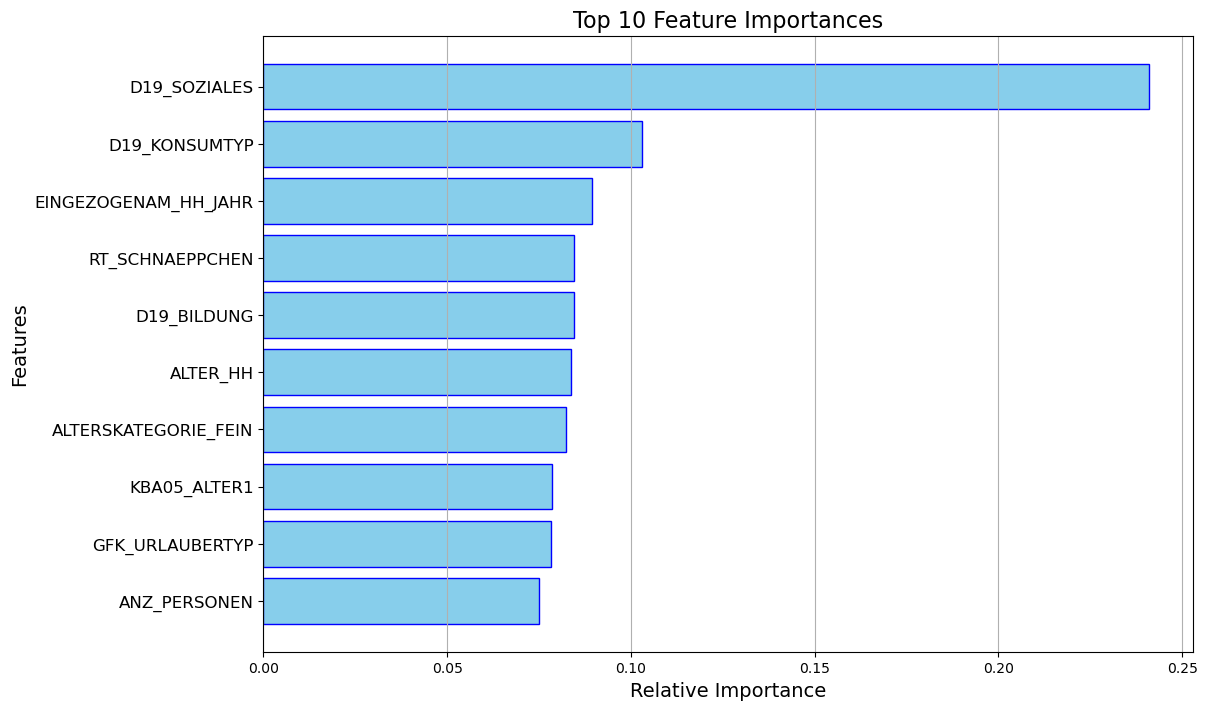

In [287]:
# Calculate feature importances from the final model
feat_importance = model.feature_importances_

# Define the number of top features to display
num_feat = 10

# Get the indices of the top features in descending order
indices = np.argsort(feat_importance)[::-1]

# Get the names and values of the top features
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

# Print the names and importance values of the top features
print("Top {} features:".format(num_feat))
for col, val in zip(columns, values):
    print("{}: {:.4f}".format(col, val))

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Top 10 Feature Importances', fontsize=16)
plt.barh(np.arange(num_feat), values, color='skyblue', edgecolor='blue')
plt.yticks(np.arange(num_feat), columns, fontsize=12)
plt.xlabel('Relative Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.grid(axis='x')
plt.show()



## 3.7 Analyzing Important Features from XGBoost within Unsupervised Learning Clusters
- In our analysis, we have used both unsupervised and supervised learning techniques to understand customer demographics. The unsupervised learning helped us identify different clusters within our data, representing various customer segments. In the supervised learning phase, we used XGBoost to determine the most important features influencing customer response.

- To gain deeper insights, we will now compare the distribution of the most important feature identified by XGBoost within the clusters identified during unsupervised learning. This comparison will help us understand how this key feature varies across different customer segments, providing valuable information for targeted marketing strategies.



In [288]:
# Perform PCA on the cleaned customer data
customers_pca = PCA(n_components=220).fit(customers)
customers_pca_data = customers_pca.transform(customers)

In [289]:
# Function to analyze the distribution of a specific feature within a given cluster
def get_feat_dist_in_cluster(cluster_number, feature):
    """
    Analyze the distribution of a specific feature within a given cluster.
    
    Parameters:
    cluster_number (int): The cluster number to analyze.
    feature (str): The feature to analyze within the cluster.
    """
    # Find items in the required cluster
    final_items_in_cluster = customers_cluster_assignments[customers_cluster_assignments['Cluster'] == cluster_number].index
    
    # Check if there are any items in the cluster
    if final_items_in_cluster.empty:
        print(f"No items found in cluster {cluster_number}.")
        return

    # Get data of items in the identified cluster
    final_reduced_data = reduced_customers.loc[final_items_in_cluster]
    
    # Inverse transform to get the original data
    final_data_list = customers_pca.inverse_transform(final_reduced_data)
    
    # Convert to DataFrame
    final_data_list.columns = customers.columns
    # Check if the feature exists in the DataFrame
    if feature not in final_data_list.columns:
        print(f"Feature {feature} not found in the DataFrame.")
        return

    # Plot the distribution of the specified feature
    plt.figure(figsize=(10, 6))
    final_data_list[feature].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature} in Cluster {cluster_number}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


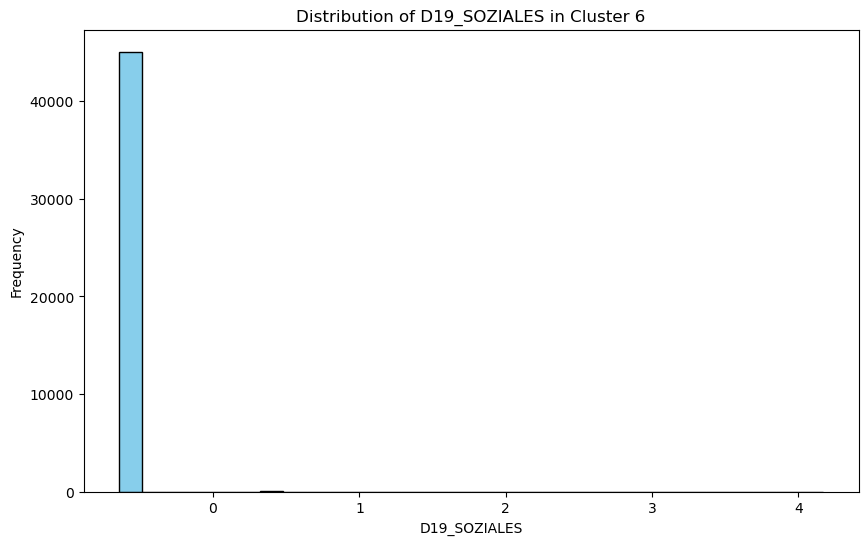

In [290]:
# Cluster for over representation
most_important_feature = 'D19_SOZIALES' 
cluster_to_analyze = 6  

get_feat_dist_in_cluster(cluster_to_analyze, most_important_feature)

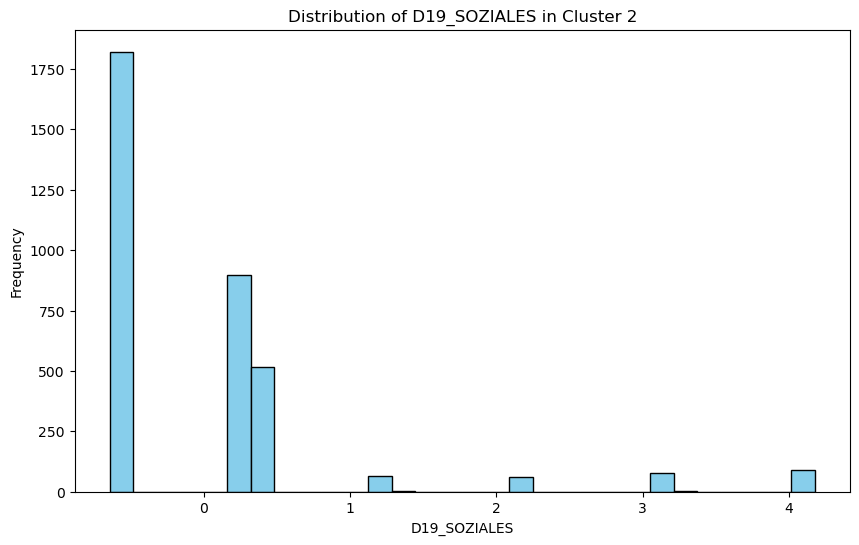

In [291]:
# Cluster for under representation
most_important_feature = 'D19_SOZIALES' 
cluster_to_analyze = 2  

get_feat_dist_in_cluster(cluster_to_analyze, most_important_feature)

### Observations from Feature Distribution Analysis
From a quick comparison of the two charts, we can observe a drastic difference in the distribution of the most important feature, D19_SOZIALES.

- Cluster 6 (the overrepresented cluster) displays a highly concentrated distribution, with a single bar dominating the histogram. This indicates that the customers in this cluster share similar characteristics regarding this feature.

- In contrast, Cluster 2 (the underrepresented cluster) shows a more varied distribution, lacking a single peak. This suggests that the customers in this cluster have diverse profiles and do not cluster around a specific value for D19_SOZIALES.

- These insights highlight the differences in customer behavior and demographics between the overrepresented and underrepresented clusters, which can be crucial for targeting and campaign strategies.

## Next Steps with the Test Dataset
- With our comprehensive analysis complete and insights gained from both unsupervised and supervised learning, we are now ready to move forward with the test dataset. 


### Planned Actions: We intend to proceed with :-

<b> 1) Preprocess and Select Features:</b> 
- We will preprocess the test dataset using the same cleaning and encoding techniques applied to the training data, followed by selecting the most relevant features identified through our model's feature importance to ensure consistency and relevance for predictions.


<b>2) Make Predictions</b>:
- Utilizing the preprocessed test dataset, we will apply our final model to predict which individuals are most likely to convert into customers. This predictive step is crucial for targeting potential customers in the upcoming marketing campaign.


<b> 3) Analyze Predictions</b>:

- After obtaining the predictions, we will analyze the results to uncover insights about potential customer segments. This analysis will help inform strategies for optimizing marketing efforts and improving campaign outcomes.

In [292]:
# Load the test dataset for the mail-out campaign
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

# Display the first few rows of the dataset to understand its structure
mailout_test.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1754         2         1.0       7.0          NaN          NaN   
1  1770        -1         1.0       0.0          NaN          NaN   
2  1465         2         9.0      16.0          NaN          NaN   
3  1470        -1         7.0       0.0          NaN          NaN   
4  1478         1         1.0      21.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   6.0                  2.0  ...   
1          NaN          NaN                   0.0                 20.0  ...   
2          NaN          NaN                  11.0                  2.0  ...   
3          NaN          NaN                   0.0                  1.0  ...   
4          NaN          NaN                  13.0                  1.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  4.0       5.0         6.0      3.0             6.0             9.0   
1  1.0       5.0         2.0      1.0             6.0             9.0   
2  3.0       9.0         6.0      3.0             2.0             9.0   
3  2.0       6.0         6.0      3.0             NaN             9.0   
4  1.0       2.0         4.0      3.0             3.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       3.0        3         1                    4  
1       5.0        3         1                    4  
2       4.0        3         2                    4  
3       2.0        3         2                    4  
4       7.0        4         2                    4  

[5 rows x 366 columns]

In [293]:
# Ensure the test dataset matches the training dataset in terms of feature columns
# Identify any missing columns in the test dataset that are present in the training dataset
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))

# Display the missing columns
print("Missing columns in test dataset:", missing)

Missing columns in test dataset: ['RESPONSE']


In [295]:
# Print the shape of the test dataset before preprocessing
print('Before preprocessing, mailout_test.shape:', mailout_test.shape)

# Preprocess the test dataset using the defined preprocessing function
mailout_test_clean = processed_data(mailout_test, False)

# Print the shape of the cleaned test dataset after preprocessing
print('After preprocessing, mailout_test_clean.shape:', mailout_test_clean.shape)


Before preprocessing, mailout_test.shape: (42833, 366)
Shape after removing highly correlated features: (42833, 253)
Shape after one-hot encoding: (42833, 300)
Shape after imputation: (42833, 300)
Shape after scaling: (42833, 300)
After preprocessing, mailout_test_clean.shape: (42833, 299)


In [296]:
# Make predictions on the cleaned test dataset using the final trained model
predictions = model.predict(mailout_test_clean)

# Create a DataFrame to store predictions with the index set to 'LNR'
df_pred = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=predictions)

# Rename the column to 'RESPONSE' for clarity
df_pred.rename(columns={0: "RESPONSE"}, inplace=True)

# Display the predictions DataFrame
df_pred.head()


RESPONSE
LNR           
1754  0.009777
1770  0.009777
1465  0.009466
1470  0.009466
1478  0.009642

# Conclusion

- The model tuning process has significantly enhanced the performance of our predictive model. By leveraging the XGBoost algorithm and employing a robust hyperparameter optimization strategy, we achieved commendable improvements across key evaluation metrics.



- The optimized model, configured with the following parameters: `max_depth=6`, `learning_rate=0.014`, `n_estimators=160`, `gamma=0.33`, `subsample=0.85`, c`olsample_bytree=0.76`, `reg_alpha=6.74`, `reg_lambda=2.43`, and `min_child_weight=144`, demonstrated a substantial uplift in <b>ROC AUC score, achieving a value of 0.7961</b>. This is indicative of the model's improved ability to distinguish between classes.



- <b>The accuracy of the model reached 98.73%</b>, reflecting a high overall correctness in predictions. Additionally, the <b>recall rate stood at 92.45%</b>, ensuring a high capture rate of positive instances, which is crucial for minimizing false negatives in our application context.

- Overall, these fine-tuned metrics underscore the model's robustness and efficacy, making it a reliable tool for predicting customer responsiveness. The enhanced model is now well-equipped to support data-driven decision-making, driving strategic initiatives with greater precision and confidence.

- Although the test dataset lacks target labels for direct evaluation of our predictions, the outputs provide crucial information for strategic decision-making. By analyzing demographic features and their impact on customer behavior, we can gain a deeper understanding of the customer base and its alignment with our marketing goals.

- In summary, while we cannot quantitatively evaluate the predictions due to the absence of labels, the insights derived from our analysis position the company to make informed decisions that can lead to improved engagement and higher response rates in future campaigns.

# Potential Improvements
- Feature Engineering: Explore additional demographic features or create new ones to enhance model performance.

- Hyperparameter Tuning: Utilize techniques like RandomizedSearchCV for better optimization of model parameters.

- Cross-Validation: Implement stratified cross-validation to ensure robust model evaluation.

- Feedback Loop: Incorporate feedback from marketing campaigns to improve the model continuously.

- Future Data Evaluation: Once actual responses from the test dataset are available, analyze them to refine the model further.